# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


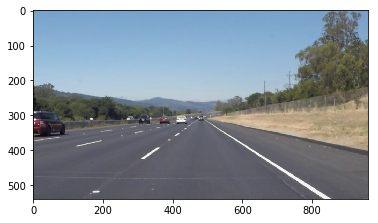

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [68]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lane_x_points = []
    left_lane_y_points = []
    right_lane_x_points = []
    right_lane_y_points = []
    for line in lines:
        print("START###")
        print(line)
        print("END$$$$$")
        for x1,y1,x2,y2 in line:
            slope = (y2-y1) / (x2-x1)
            if math.fabs(slope) < 0.5:
                continue
            if slope <=0:
                left_lane_x_points.extend([x1,x2])
                left_lane_y_points.extend([y1,y2])
            else: 
                right_lane_x_points.extend([x1,x2])
                right_lane_y_points.extend([y1,y2])
        print(slope)
    #print(right_lane_x_points)
    if len(left_lane_x_points) > 0 and len(right_lane_x_points):
        left_lane_fn = np.poly1d(np.polyfit(left_lane_y_points,left_lane_x_points,1))
        right_lane_fn = np.poly1d(np.polyfit(right_lane_y_points,right_lane_x_points,1))
        min_y = 340
        max_y = 538
        left_lane_x1 = int(left_lane_fn(max_y))
        left_lane_x2 = int(left_lane_fn(min_y))

        right_lane_x1 = int(right_lane_fn(max_y))
        right_lane_x2 = int(right_lane_fn(min_y))

        cv2.line(img, (left_lane_x1, max_y), (left_lane_x2, min_y), color, thickness)   
        cv2.line(img, (right_lane_x1, max_y), (right_lane_x2, min_y), color, thickness) 


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [81]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
def lane_finding_pipeline(img):
    #vertices = np.array([[(90,539),(400,320),(520,300),(900,539)]])
    vertices = np.array([[(135,538),(425,340),(560,340),(900,538)]])
    #vertices = np.array([[(135,538),(425,340),(560,340),(900,538)]])
    if( img.shape[0] > 540 or img.shape[1] > 960):
        img = cv2.resize(img,(960,540))
    gray = grayscale(img)
    blur = gaussian_blur(gray,5)
    canny_edges = canny(blur,50,150)
    masked_image = region_of_interest(canny_edges,vertices)
    lines = hough_lines(masked_image, 1, np.pi/90, 5, 20, 1)
    result = weighted_img(lines,img)
    return result
    
for img_name in os.listdir("test_images/"):
    image = mpimg.imread(os.path.join("test_images",img_name))
    cv2.imwrite(os.path.join('test_videos_output/',img_name),lane_finding_pipeline(image))
# image = mpimg.imread("test_images/solidWhiteCurve.jpg")
# plt.imshow(lane_finding_pipeline(image))

START###
[[196 538 295 460]]
END$$$$$
-0.787878787879
START###
[[764 479 826 517]]
END$$$$$
0.612903225806
START###
[[280 460 348 410]]
END$$$$$
-0.735294117647
START###
[[581 371 604 383]]
END$$$$$
0.521739130435
START###
[[815 499 870 531]]
END$$$$$
0.581818181818
START###
[[767 472 806 495]]
END$$$$$
0.589743589744
START###
[[357 410 392 384]]
END$$$$$
-0.742857142857
START###
[[379 387 405 369]]
END$$$$$
-0.692307692308
START###
[[189 528 276 464]]
END$$$$$
-0.735632183908
START###
[[328 433 356 412]]
END$$$$$
-0.75
START###
[[363 398 383 385]]
END$$$$$
-0.65
START###
[[743 467 779 489]]
END$$$$$
0.611111111111
START###
[[295 459 323 438]]
END$$$$$
-0.75
START###
[[796 498 858 536]]
END$$$$$
0.612903225806
START###
[[405 368 434 348]]
END$$$$$
-0.689655172414
START###
[[396 380 450 340]]
END$$$$$
-0.740740740741
START###
[[138 538 353 393]]
END$$$$$
-0.674418604651
START###
[[207 504 287 446]]
END$$$$$
-0.725
START###
[[692 436 727 457]]
END$$$$$
0.6
START###
[[393 370 431 340]]
EN

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lane_finding_pipeline(image) 
    return result

Let's try the one with the solid white lane on the right first ...

In [82]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

START###
[[534 340 619 393]]
END$$$$$
0.623529411765
START###
[[703 447 805 511]]
END$$$$$
0.627450980392
START###
[[249 479 281 455]]
END$$$$$
-0.75
START###
[[620 387 723 451]]
END$$$$$
0.621359223301
START###
[[733 456 811 504]]
END$$$$$
0.615384615385
START###
[[187 513 300 431]]
END$$$$$
-0.725663716814
START###
[[619 392 661 420]]
END$$$$$
0.666666666667
START###
[[202 514 250 479]]
END$$$$$
-0.729166666667
START###
[[749 477 819 521]]
END$$$$$
0.628571428571
START###
[[791 491 853 529]]
END$$$$$
0.612903225806
START###
[[280 455 310 433]]
END$$$$$
-0.733333333333
START###
[[567 357 602 376]]
END$$$$$
0.542857142857
START###
[[675 429 700 444]]
END$$$$$
0.6
START###
[[838 519 860 533]]
END$$$$$
0.636363636364
START###
[[586 368 607 379]]
END$$$$$
0.52380952381
START###
[[673 419 693 431]]
END$$$$$
0.6
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4



  2%|▏         | 3/126 [00:00<00:05, 20.67it/s]

START###
[[534 340 619 393]]
END$$$$$
0.623529411765
START###
[[703 447 805 511]]
END$$$$$
0.627450980392
START###
[[249 479 281 455]]
END$$$$$
-0.75
START###
[[620 387 723 451]]
END$$$$$
0.621359223301
START###
[[733 456 811 504]]
END$$$$$
0.615384615385
START###
[[187 513 300 431]]
END$$$$$
-0.725663716814
START###
[[619 392 661 420]]
END$$$$$
0.666666666667
START###
[[202 514 250 479]]
END$$$$$
-0.729166666667
START###
[[749 477 819 521]]
END$$$$$
0.628571428571
START###
[[791 491 853 529]]
END$$$$$
0.612903225806
START###
[[280 455 310 433]]
END$$$$$
-0.733333333333
START###
[[567 357 602 376]]
END$$$$$
0.542857142857
START###
[[675 429 700 444]]
END$$$$$
0.6
START###
[[838 519 860 533]]
END$$$$$
0.636363636364
START###
[[586 368 607 379]]
END$$$$$
0.52380952381
START###
[[673 419 693 431]]
END$$$$$
0.6
START###
[[697 434 823 512]]
END$$$$$
0.619047619048
START###
[[190 524 236 488]]
END$$$$$
-0.782608695652
START###
[[560 353 656 409]]
END$$$$$
0.583333333333
START###
[[648 412 72

START###
[[557 355 687 436]]
END$$$$$
0.623076923077
START###
[[598 380 656 416]]
END$$$$$


  5%|▍         | 6/126 [00:00<00:05, 21.35it/s]


0.620689655172
START###
[[693 431 795 494]]
END$$$$$
0.617647058824
START###
[[708 450 849 538]]
END$$$$$
0.624113475177
START###
[[573 361 666 415]]
END$$$$$
0.58064516129
START###
[[778 483 812 504]]
END$$$$$
0.617647058824
START###
[[797 494 859 532]]
END$$$$$
0.612903225806
START###
[[369 388 389 373]]
END$$$$$
-0.75
START###
[[361 387 385 370]]
END$$$$$
-0.708333333333
START###
[[834 516 855 529]]
END$$$$$
0.619047619048
START###
[[673 419 693 432]]
END$$$$$
0.65
START###
[[704 447 724 459]]
END$$$$$
0.6
START###
[[780 496 847 538]]
END$$$$$
0.626865671642
START###
[[358 395 384 376]]
END$$$$$
-0.730769230769
START###
[[534 340 742 470]]
END$$$$$
0.625
START###
[[580 365 680 423]]
END$$$$$
0.58
START###
[[718 446 825 512]]
END$$$$$
0.616822429907
START###
[[351 394 379 374]]
END$$$$$
-0.714285714286
START###
[[561 353 609 381]]
END$$$$$
0.583333333333
START###
[[758 482 785 498]]
END$$$$$
0.592592592593
START###
[[810 502 848 525]]
END$$$$$
0.605263157895
START###
[[545 343 568 3


  7%|▋         | 9/126 [00:00<00:05, 22.42it/s]

START###
[[310 422 353 391]]
END$$$$$
-0.720930232558
START###
[[670 419 751 466]]
END$$$$$
0.58024691358
START###
[[734 467 848 538]]
END$$$$$
0.622807017544
START###
[[541 340 633 397]]
END$$$$$
0.619565217391
START###
[[734 457 796 493]]
END$$$$$
0.58064516129
START###
[[772 480 832 515]]
END$$$$$
0.583333333333
START###
[[322 421 361 392]]
END$$$$$
-0.74358974359
START###
[[593 378 799 507]]
END$$$$$
0.626213592233
START###
[[535 340 575 365]]
END$$$$$
0.625
START###
[[646 405 679 423]]
END$$$$$
0.545454545455
START###
[[807 501 846 524]]
END$$$$$
0.589743589744
START###
[[535 343 567 362]]
END$$$$$
0.59375
START###
[[748 468 808 503]]
END$$$$$
0.583333333333
START###
[[757 484 844 538]]
END$$$$$
0.620689655172
START###
[[686 430 740 463]]
END$$$$$
0.611111111111
START###


  9%|▊         | 11/126 [00:00<00:05, 21.50it/s]


[[593 375 619 391]]
END$$$$$
0.615384615385
START###
[[596 381 617 396]]
END$$$$$
0.714285714286
START###
[[538 340 659 415]]
END$$$$$
0.619834710744
START###
[[642 404 696 437]]
END$$$$$
0.611111111111
START###
[[821 512 850 528]]
END$$$$$
0.551724137931
START###
[[289 439 325 414]]
END$$$$$
-0.694444444444
START###
[[310 433 351 401]]
END$$$$$
-0.780487804878
START###
[[711 455 745 475]]
END$$$$$
0.588235294118
START###
[[679 435 702 448]]
END$$$$$
0.565217391304
START###
[[325 413 346 399]]
END$$$$$
-0.666666666667
START###
[[607 388 652 418]]
END$$$$$
0.666666666667
START###
[[300 440 324 421]]
END$$$$$
-0.791666666667
START###
[[575 367 602 386]]
END$$$$$
0.703703703704
START###
[[313 421 335 407]]
END$$$$$
-0.636363636364
START###
[[641 410 678 434]]
END$$$$$
0.648648648649
START###
[[564 361 585 375]]
END$$$$$
0.666666666667
START###
[[548 347 574 363]]
END$$$$$
0.615384615385
START###
[[629 400 689 435]]
END$$$$$
0.583333333333
START###
[[526 340 600 386]]
END$$$$$
0.621621621

START###
[[773 499 818 529]]
END$$$$$
0.666666666667
START###
[[199 512 278 454]]
END$$$$$
-0.73417721519
START###
[[710 449 836 527]]
END$$$$$
0.619047619048
START###
[[186 509 234 476]]
END$$$$$
-0.6875
START###
[[819 516 855 538]]
END$$$$$
0.611111111111
START###
[[621 394 653 413]]
END$$$$$
0.59375
START###
[[558 353 599 380]]
END$$$$$
0.658536585366
START###
[[529 340 576 369]]
END$$$$$
0.617021276596
START###
[[707 456 773 500]]
END$$$$$
0.666666666667
START###
[[144 538 187 509]]
END$$$$$
-0.674418604651
START###
[[254 471 280 452]]
END$$$$$
-0.730769230769
START###
[[165 538 188 521]]
END$$$$$
-0.739130434783
START###
[[574 369 599 384]]
END$$$$$
0.6
START###
[[681 439 702 454]]
END$$$$$
0.714285714286
START###
[[223 483 243 470]]
END$$$$$
-0.65
START###
[[697 441 729 462]]
END$$$$$
0.65625
START###
[[163 525 185 510]]
END$$$$$
-0.681818181818



 13%|█▎        | 17/126 [00:00<00:04, 22.84it/s]

START###
[[538 340 697 439]]
END$$$$$
0.622641509434
START###
[[162 538 189 518]]
END$$$$$
-0.740740740741
START###
[[716 451 745 470]]
END$$$$$
0.655172413793
START###
[[184 521 258 467]]
END$$$$$
-0.72972972973
START###
[[554 353 715 461]]
END$$$$$
0.670807453416
START###
[[152 532 220 483]]
END$$$$$
-0.720588235294
START###
[[778 502 835 538]]
END$$$$$
0.631578947368
START###
[[740 466 769 485]]
END$$$$$
0.655172413793
START###
[[784 493 813 512]]
END$$$$$
0.655172413793
START###
[[836 526 857 538]]
END$$$$$
0.571428571429
START###
[[375 374 395 362]]
END$$$$$
-0.6
START###
[[761 479 784 494]]
END$$$$$
0.652173913043
START###
[[543 342 572 360]]
END$$$$$
0.620689655172
START###
[[616 389 674 425]]
END$$$$$
0.620689655172
START###
[[541 340 679 426]]
END$$$$$
0.623188405797
START###
[[552 350 710 456]]
END$$$$$
0.670886075949
START###
[[671 429 792 510]]
END$$$$$
0.669421487603
START###
[[158 538 207 502]]
END$$$$$
-0.734693877551
START###
[[183 519 221 491]]
END$$$$$
-0.736842105263


0.657142857143
START###
[[339 400 372 378]]
END$$$$$
-0.666666666667
START###
[[596 376 623 392]]
END$$$$$
0.592592592593
START###
[[832 523 855 538]]
END$$$$$
0.652173913043
START###
[[775 499 795 512]]
END$$$$$
0.65
START###
[[784 506 804 519]]
END$$$$$
0.65
START###
[[650 409 670 422]]
END$$$$$
0.65
START###
[[652 417 680 436]]
END$$$$$
0.678571428571



 16%|█▌        | 20/126 [00:00<00:04, 22.82it/s]

START###
[[574 367 683 440]]
END$$$$$
0.669724770642
START###
[[547 350 606 389]]
END$$$$$
0.661016949153
START###
[[729 469 832 538]]
END$$$$$
0.669902912621
START###
[[537 340 854 538]]
END$$$$$
0.624605678233
START###
[[326 411 366 384]]
END$$$$$
-0.675
START###
[[659 423 756 488]]
END$$$$$
0.670103092784
START###
[[531 340 560 359]]
END$$$$$
0.655172413793
START###
[[594 375 615 388]]
END$$$$$
0.619047619048
START###
[[570 360 593 374]]
END$$$$$
0.608695652174
START###
[[791 498 830 522]]
END$$$$$
0.615384615385
START###
[[535 340 853 538]]
END$$$$$
0.622641509434
START###
[[310 422 339 404]]
END$$$$$
-0.620689655172
START###
[[319 425 362 394]]
END$$$$$
-0.720930232558
START###
[[773 500 817 528]]
END$$$$$
0.636363636364
START###
[[563 362 617 396]]
END$$$$$
0.62962962963
START###
[[328 410 353 394]]
END$$$$$
-0.64
START###
[[645 416 697 449]]
END$$$$$
0.634615384615
START###
[[706 456 744 480]]
END$$$$$
0.631578947368
START###
[[528 340 588 377]]
END$$$$$
0.616666666667
START###



 18%|█▊        | 23/126 [00:01<00:04, 22.83it/s]

START###
[[536 340 854 538]]
END$$$$$
0.622641509434
START###
[[572 366 669 431]]
END$$$$$
0.670103092784
START###
[[244 479 327 419]]
END$$$$$
-0.722891566265
START###
[[741 479 803 518]]
END$$$$$
0.629032258065
START###
[[581 367 631 398]]
END$$$$$
0.62
START###
[[232 476 291 436]]
END$$$$$
-0.677966101695
START###
[[530 340 553 355]]
END$$$$$
0.652173913043
START###
[[810 524 833 538]]
END$$$$$
0.608695652174
START###
[[713 451 790 499]]
END$$$$$
0.623376623377
START###
[[290 436 313 421]]
END$$$$$
-0.652173913043
START###
[[696 449 734 473]]
END$$$$$
0.631578947368
START###
[[684 441 704 453]]
END$$$$$
0.6
START###
[[798 516 820 529]]
END$$$$$
0.590909090909
START###
[[729 471 754 486]]
END$$$$$
0.6
START###
[[265 453 287 438]]
END$$$$$
-0.681818181818
START###
[[243 479 286 448]]
END$$$$$
-0.720930232558
START###
[[632 399 690 435]]
END$$$$$
0.620689655172



 21%|██        | 26/126 [00:01<00:04, 22.88it/s]

START###
[[201 510 310 431]]
END$$$$$
-0.724770642202
START###
[[538 340 773 487]]
END$$$$$
0.625531914894
START###
[[200 498 227 480]]
END$$$$$
-0.666666666667
START###
[[245 467 300 430]]
END$$$$$
-0.672727272727
START###
[[786 508 834 538]]
END$$$$$
0.625
START###
[[652 418 780 504]]
END$$$$$
0.671875
START###
[[588 377 634 406]]
END$$$$$
0.630434782609
START###
[[805 507 834 526]]
END$$$$$
0.655172413793
START###
[[532 341 607 388]]
END$$$$$
0.626666666667
START###
[[774 488 803 507]]
END$$$$$
0.655172413793
START###
[[821 517 852 537]]
END$$$$$
0.645161290323
START###
[[733 463 753 475]]
END$$$$$
0.6
START###
[[241 470 262 456]]
END$$$$$
-0.666666666667
START###
[[745 480 769 496]]
END$$$$$
0.666666666667
START###
[[543 344 565 358]]
END$$$$$
0.636363636364
START###
[[163 538 289 446]]
END$$$$$
-0.730158730159
START###
[[609 384 691 435]]
END$$$$$
0.621951219512
START###
[[162 524 269 451]]
END$$$$$
-0.682242990654
START###
[[686 433 854 538]]
END$$$$$
0.625
START###
[[664 427 702


 23%|██▎       | 29/126 [00:01<00:04, 23.05it/s]

START###
[[606 383 855 538]]
END$$$$$
0.622489959839
START###
[[658 422 770 497]]
END$$$$$
0.669642857143
START###
[[559 358 604 388]]
END$$$$$
0.666666666667
START###
[[569 360 598 379]]
END$$$$$
0.655172413793
START###
[[606 388 691 445]]
END$$$$$
0.670588235294
START###
[[785 507 826 533]]
END$$$$$
0.634146341463
START###
[[368 389 390 373]]
END$$$$$
-0.727272727273
START###
[[806 521 834 538]]
END$$$$$
0.607142857143
START###
[[531 340 576 370]]
END$$$$$
0.666666666667
START###
[[776 501 796 513]]
END$$$$$
0.6
START###
[[538 340 558 354]]
END$$$$$
0.7
START###
[[560 355 585 371]]
END$$$$$
0.64
START###
[[671 424 708 447]]
END$$$$$
0.621621621622



 25%|██▌       | 32/126 [00:01<00:04, 23.43it/s]

START###
[[602 380 856 538]]
END$$$$$
0.622047244094
START###
[[671 430 771 497]]
END$$$$$
0.67
START###
[[569 365 639 409]]
END$$$$$
0.628571428571
START###
[[359 395 385 377]]
END$$$$$
-0.692307692308
START###
[[733 471 829 535]]
END$$$$$
0.666666666667
START###
[[554 351 617 390]]
END$$$$$
0.619047619048
START###
[[536 343 574 367]]
END$$$$$
0.631578947368
START###
[[357 391 381 374]]
END$$$$$
-0.708333333333
START###
[[640 410 719 463]]
END$$$$$
0.670886075949
START###
[[633 406 660 424]]
END$$$$$
0.666666666667
START###
[[638 403 672 424]]
END$$$$$
0.617647058824
START###
[[630 404 650 416]]
END$$$$$
0.6
START###
[[695 437 737 463]]
END$$$$$
0.619047619048
START###
[[665 427 687 440]]
END$$$$$
0.590909090909
START###
[[540 340 582 368]]
END$$$$$
0.666666666667
START###
[[790 508 835 538]]
END$$$$$
0.666666666667
START###
[[553 354 607 388]]
END$$$$$
0.62962962963
START###
[[607 384 632 399]]
END$$$$$
0.6
START###
[[793 498 822 517]]
END$$$$$
0.655172413793
START###
[[763 490 784 5

START###
[[546 345 788 496]]
END$$$$$
0.623966942149
START###
[[664 427 726 466]]
END$$$$$
0.629032258065
START###
[[292 434 347 397]]
END$$$$$
-0.672727272727
START###
[[549 350 571 366]]
END$$$$$
0.727272727273
START###
[[683 430 857 538]]
END$$$$$
0.620689655172
START###
[[305 434 353 399]]
END$$$$$
-0.729166666667
START###
[[621 399 683 438]]
END$$$$$
0.629032258065
START###
[[738 475 784 504]]
END$$$$$
0.630434782609
START###
[[785 506 836 538]]
END$$$$$
0.627450980392
START###
[[577 370 626 401]]
END$$$$$
0.632653061224
START###
[[292 435 314 420]]
END$$$$$
-0.681818181818
START###
[[303 436 340 409]]
END$$$$$
-0.72972972973
START###
[[718 462 740 475]]
END$$$$$
0.590909090909
START###
[[730 470 752 483]]
END$$$$$
0.590909090909
START###
[[779 502 806 518]]
END$$$$$
0.592592592593
START###
[[572 366 602 385]]
END$$$$$
0.633333333333
START###
[[837 525 858 538]]
END$$$$$
0.619047619048



 30%|███       | 38/126 [00:01<00:03, 23.73it/s]

START###
[[671 424 854 538]]
END$$$$$
0.622950819672
START###
[[532 340 641 413]]
END$$$$$
0.669724770642
START###
[[642 407 676 428]]
END$$$$$
0.617647058824
START###
[[267 452 336 406]]
END$$$$$
-0.666666666667
START###
[[538 340 591 375]]
END$$$$$
0.660377358491
START###
[[609 385 629 399]]
END$$$$$
0.7
START###
[[624 401 698 450]]
END$$$$$
0.662162162162
START###
[[286 450 318 425]]
END$$$$$
-0.78125
START###
[[684 440 753 486]]
END$$$$$
0.666666666667
START###
[[570 366 598 385]]
END$$$$$
0.678571428571
START###
[[810 523 834 538]]
END$$$$$
0.625
START###
[[782 505 804 518]]
END$$$$$
0.590909090909
START###
[[761 491 784 505]]
END$$$$$
0.608695652174
START###
[[278 455 299 439]]
END$$$$$
-0.761904761905
START###
[[627 397 650 411]]
END$$$$$
0.608695652174
START###
[[802 505 856 538]]
END$$$$$
0.611111111111
START###
[[553 351 787 497]]
END$$$$$
0.623931623932
START###
[[684 442 749 483]]
END$$$$$
0.630769230769
START###
[[247 478 328 419]]
END$$$$$
-0.728395061728
START###
[[531 3


 33%|███▎      | 41/126 [00:01<00:03, 23.72it/s]

START###
[[740 468 779 491]]
END$$$$$
0.589743589744
START###
[[534 340 687 443]]
END$$$$$
0.673202614379
START###
[[746 481 797 515]]
END$$$$$
0.666666666667
START###
[[164 525 207 494]]
END$$$$$
-0.720930232558
START###
[[794 512 833 538]]
END$$$$$
0.666666666667
START###
[[541 340 616 390]]
END$$$$$
0.666666666667
START###
[[695 447 720 465]]
END$$$$$
0.72
START###
[[190 520 217 499]]
END$$$$$
-0.777777777778
START###
[[371 380 391 366]]
END$$$$$
-0.7
START###
[[591 373 632 400]]
END$$$$$
0.658536585366
START###
[[675 426 710 449]]
END$$$$$
0.657142857143
START###
[[634 400 665 421]]
END$$$$$
0.677419354839
START###
[[831 523 854 538]]
END$$$$$
0.652173913043
START###
[[816 514 842 531]]
END$$$$$
0.653846153846
START###
[[146 537 178 514]]
END$$$$$
-0.71875
START###
[[718 453 739 467]]
END$$$$$
0.666666666667
START###
[[573 367 604 388]]
END$$$$$
0.677419354839
START###
[[535 340 697 449]]
END$$$$$
0.672839506173
START###
[[581 367 855 538]]
END$$$$$
0.624087591241
START###
[[363 38


 35%|███▍      | 44/126 [00:02<00:04, 16.60it/s]

START###
[[536 340 781 505]]
END$$$$$
0.673469387755
START###
[[602 380 776 489]]
END$$$$$
0.626436781609
START###
[[330 407 365 382]]
END$$$$$
-0.714285714286
START###
[[787 508 832 538]]
END$$$$$
0.666666666667
START###
[[800 504 829 523]]
END$$$$$
0.655172413793
START###
[[541 340 587 369]]
END$$$$$
0.630434782609
START###
[[338 409 372 383]]
END$$$$$
-0.764705882353
START###
[[824 519 847 534]]
END$$$$$
0.652173913043
START###
[[782 493 816 515]]
END$$$$$
0.647058823529
START###
[[597 382 677 436]]
END$$$$$
0.675
START###
[[620 397 794 514]]
END$$$$$
0.672413793103
START###
[[560 353 622 392]]
END$$$$$
0.629032258065
START###
[[669 422 704 445]]
END$$$$$
0.657142857143
START###
[[542 345 572 364]]
END$$$$$
0.633333333333
START###
[[314 418 343 397]]
END$$$$$
-0.724137931034
START###
[[626 396 660 416]]
END$$$$$
0.588235294118
START###
[[758 489 831 538]]
END$$$$$
0.671232876712
START###
[[758 478 796 503]]
END$$$$$
0.657894736842
START###
[[806 508 844 533]]
END$$$$$
0.657894736842


 38%|███▊      | 48/126 [00:02<00:05, 13.89it/s]

START###
[[589 371 667 420]]
END$$$$$
0.628205128205
START###
[[536 340 807 522]]
END$$$$$
0.671586715867
START###
[[542 340 586 369]]
END$$$$$
0.659090909091
START###
[[270 448 301 427]]
END$$$$$
-0.677419354839
START###
[[280 450 343 405]]
END$$$$$
-0.714285714286
START###
[[754 476 799 504]]
END$$$$$
0.622222222222
START###
[[818 515 847 534]]
END$$$$$
0.655172413793
START###
[[543 345 577 368]]
END$$$$$
0.676470588235
START###
[[708 446 740 467]]
END$$$$$
0.65625
START###
[[759 489 809 523]]
END$$$$$
0.68
START###
[[583 372 697 449]]
END$$$$$
0.675438596491
START###
[[282 450 306 432]]
END$$$$$
-0.75
START###
[[759 478 784 494]]
END$$$$$
0.64
START###
[[637 402 659 416]]
END$$$$$
0.636363636364
START###
[[570 358 597 375]]
END$$$$$
0.62962962963
START###
[[655 414 854 538]]
END$$$$$
0.623115577889
START###
[[572 364 603 385]]
END$$$$$
0.677419354839
START###
[[603 386 726 469]]
END$$$$$
0.674796747967
START###
[[607 383 701 442]]
END$$$$$
0.627659574468
START###
[[240 470 319 413]]


 40%|███▉      | 50/126 [00:02<00:05, 13.26it/s]

START###
[[534 340 769 498]]
END$$$$$
0.672340425532
START###
[[190 503 253 460]]
END$$$$$
-0.68253968254
START###
[[636 402 754 476]]
END$$$$$
0.627118644068
START###
[[242 479 278 451]]
END$$$$$
-0.777777777778
START###
[[586 374 632 405]]
END$$$$$
0.673913043478
START###
[[566 357 644 406]]
END$$$$$
0.628205128205
START###
[[539 340 583 367]]
END$$$$$
0.613636363636
START###
[[182 523 221 493]]
END$$$$$
-0.769230769231
START###
[[230 475 283 439]]
END$$$$$
-0.679245283019
START###
[[140 538 190 504]]
END$$$$$
-0.68
START###
[[793 514 831 538]]
END$$$$$
0.631578947368
START###
[[784 508 804 520]]
END$$$$$
0.6
START###
[[789 498 824 521]]
END$$$$$
0.657142857143
START###
[[824 520 844 533]]
END$$$$$
0.65
START###
[[748 483 776 502]]
END$$$$$
0.678571428571
START###
[[716 453 750 474]]
END$$$$$
0.617647058824
START###
[[672 432 709 457]]
END$$$$$
0.675675675676
START###
[[160 538 266 461]]
END$$$$$
-0.72641509434
START###
[[759 480 852 538]]
END$$$$$
0.623655913978
START###
[[539 340 6


 43%|████▎     | 54/126 [00:02<00:05, 12.53it/s]

START###
[[536 341 759 491]]
END$$$$$
0.67264573991
START###
[[539 340 616 388]]
END$$$$$
0.623376623377
START###
[[720 455 853 538]]
END$$$$$
0.624060150376
START###
[[663 417 684 432]]
END$$$$$
0.714285714286
START###
[[365 386 387 370]]
END$$$$$
-0.727272727273
START###
[[135 538 170 515]]
END$$$$$
-0.657142857143
START###
[[758 489 783 507]]
END$$$$$
0.72
START###
[[156 538 185 518]]
END$$$$$
-0.689655172414
START###
[[779 503 811 526]]
END$$$$$
0.71875
START###
[[648 408 673 425]]
END$$$$$
0.68
START###
[[145 531 169 515]]
END$$$$$
-0.666666666667
START###
[[533 340 556 355]]
END$$$$$
0.652173913043
START###
[[659 423 727 469]]
END$$$$$
0.676470588235
START###
[[557 355 783 507]]
END$$$$$
0.672566371681
START###
[[598 378 772 487]]
END$$$$$
0.626436781609
START###
[[726 459 853 538]]
END$$$$$
0.622047244094
START###
[[560 358 617 396]]
END$$$$$
0.666666666667
START###
[[602 380 703 443]]
END$$$$$
0.623762376238
START###
[[798 517 831 538]]
END$$$$$
0.636363636364
START###
[[353 39


 44%|████▍     | 56/126 [00:03<00:05, 12.14it/s]

START###
[[536 340 575 364]]
END$$$$$
0.615384615385
START###
[[580 366 601 381]]
END$$$$$
0.714285714286
START###
[[789 510 821 533]]
END$$$$$
0.71875
START###
[[580 372 659 425]]
END$$$$$
0.670886075949
START###
[[558 358 580 371]]
END$$$$$
0.590909090909
START###
[[741 478 769 498]]
END$$$$$
0.714285714286
START###
[[825 522 852 538]]
END$$$$$
0.592592592593
START###
[[639 404 668 423]]
END$$$$$
0.655172413793
START###
[[668 431 708 456]]
END$$$$$
0.625
START###
[[734 463 778 492]]
END$$$$$
0.659090909091
START###
[[330 411 366 385]]
END$$$$$
-0.722222222222
START###
[[729 470 751 486]]
END$$$$$
0.727272727273
START###
[[670 423 692 438]]
END$$$$$
0.681818181818
START###
[[767 484 793 501]]
END$$$$$
0.653846153846
START###
[[735 464 756 478]]
END$$$$$
0.666666666667
START###
[[606 384 627 396]]
END$$$$$
0.571428571429
START###
[[531 340 559 358]]
END$$$$$
0.642857142857
START###
[[591 379 633 407]]
END$$$$$
0.666666666667
START###
[[591 373 611 386]]
END$$$$$
0.65
START###
[[614 390


 48%|████▊     | 60/126 [00:03<00:05, 11.96it/s]

START###
[[543 349 747 486]]
END$$$$$
0.671568627451
START###
[[619 394 850 538]]
END$$$$$
0.623376623377
START###
[[723 469 826 538]]
END$$$$$
0.669902912621
START###
[[534 340 646 410]]
END$$$$$
0.625
START###
[[295 429 322 410]]
END$$$$$
-0.703703703704
START###
[[280 448 335 408]]
END$$$$$
-0.727272727273
START###
[[683 435 800 508]]
END$$$$$
0.623931623932
START###
[[800 520 822 534]]
END$$$$$
0.636363636364
START###
[[562 361 816 532]]
END$$$$$
0.673228346457
START###
[[529 340 595 384]]
END$$$$$
0.666666666667
START###
[[534 340 660 419]]
END$$$$$
0.626984126984
START###
[[683 435 848 538]]
END$$$$$
0.624242424242
START###
[[239 476 310 425]]
END$$$$$
-0.718309859155
START###
[[744 474 821 522]]
END$$$$$
0.623376623377
START###
[[775 504 816 531]]
END$$$$$
0.658536585366
START###
[[528 340 551 355]]
END$$$$$
0.652173913043
START###
[[635 404 656 417]]
END$$$$$
0.619047619048
START###
[[680 441 700 455]]
END$$$$$
0.7
START###
[[653 423 676 439]]
END$$$$$
0.695652173913
START###
[


 49%|████▉     | 62/126 [00:03<00:05, 11.90it/s]

START###
[[633 410 823 538]]
END$$$$$
0.673684210526
START###
[[533 340 664 422]]
END$$$$$
0.625954198473
START###
[[777 496 844 538]]
END$$$$$
0.626865671642
START###
[[668 426 754 480]]
END$$$$$
0.627906976744
START###
[[711 462 733 477]]
END$$$$$
0.681818181818
START###
[[531 343 585 377]]
END$$$$$
0.62962962963
START###
[[211 496 265 457]]
END$$$$$
-0.722222222222
START###
[[583 377 613 396]]
END$$$$$
0.633333333333
START###
[[615 398 645 417]]
END$$$$$
0.633333333333
START###
[[157 534 177 520]]
END$$$$$
-0.7
START###
[[777 495 815 519]]
END$$$$$
0.631578947368
START###
[[645 411 670 426]]
END$$$$$
0.6
START###
[[671 435 696 452]]
END$$$$$
0.68
START###
[[560 361 823 538]]
END$$$$$
0.673003802281
START###
[[570 364 696 443]]
END$$$$$
0.626984126984
START###
[[744 474 794 507]]
END$$$$$
0.66
START###
[[213 495 252 467]]
END$$$$$
-0.717948717949
START###
[[774 506 808 529]]
END$$$$$
0.676470588235
START###
[[159 533 223 487]]
END$$$$$
-0.71875
START###
[[531 342 552 357]]
END$$$$$
0


 51%|█████     | 64/126 [00:03<00:05, 11.72it/s]

START###
[[610 390 652 416]]
END$$$$$
0.619047619048
START###
[[698 455 728 474]]
END$$$$$
0.633333333333
START###
[[736 481 766 500]]
END$$$$$
0.633333333333
START###
[[723 472 750 489]]
END$$$$$
0.62962962963
START###
[[785 514 805 527]]
END$$$$$
0.65
START###
[[779 509 799 522]]
END$$$$$
0.65
START###
[[732 467 775 494]]
END$$$$$
0.627906976744
START###
[[172 524 215 493]]
END$$$$$
-0.720930232558
START###
[[561 358 595 379]]
END$$$$$
0.617647058824
START###
[[680 434 700 446]]
END$$$$$
0.6
START###
[[795 508 843 538]]
END$$$$$
0.625
START###
[[717 468 821 538]]
END$$$$$
0.673076923077
START###
[[531 340 602 384]]
END$$$$$
0.619718309859
START###
[[542 351 562 363]]
END$$$$$
0.6
START###
[[714 456 768 490]]
END$$$$$
0.62962962963
START###
[[583 378 613 397]]
END$$$$$
0.633333333333
START###
[[357 387 382 370]]
END$$$$$
-0.68
START###
[[760 486 787 502]]
END$$$$$
0.592592592593
START###
[[630 402 662 423]]
END$$$$$
0.65625
START###
[[802 513 829 529]]
END$$$$$
0.592592592593
START###


 54%|█████▍    | 68/126 [00:04<00:04, 11.62it/s]

START###
[[529 340 823 538]]
END$$$$$
0.673469387755
START###
[[540 344 626 398]]
END$$$$$
0.627906976744
START###
[[722 469 756 492]]
END$$$$$
0.676470588235
START###
[[652 416 810 515]]
END$$$$$
0.626582278481
START###
[[353 393 374 379]]
END$$$$$
-0.666666666667
START###
[[819 521 839 535]]
END$$$$$
0.7
START###
[[759 494 781 509]]
END$$$$$
0.681818181818
START###
[[635 405 657 418]]
END$$$$$
0.590909090909
START###
[[546 352 568 367]]
END$$$$$
0.681818181818
START###
[[682 435 847 538]]
END$$$$$
0.624242424242
START###
[[728 473 825 538]]
END$$$$$
0.670103092784
START###
[[528 340 584 377]]
END$$$$$
0.660714285714
START###
[[589 379 628 407]]
END$$$$$
0.717948717949
START###
[[592 376 654 417]]
END$$$$$
0.661290322581
START###
[[556 353 577 368]]
END$$$$$
0.714285714286
START###
[[650 422 677 439]]
END$$$$$
0.62962962963
START###
[[343 399 365 384]]
END$$$$$
-0.681818181818
START###
[[782 510 813 531]]
END$$$$$
0.677419354839
START###
[[721 459 768 488]]
END$$$$$
0.617021276596
STA


 56%|█████▌    | 70/126 [00:04<00:04, 11.86it/s]

START###
[[528 340 822 538]]
END$$$$$
0.673469387755
START###
[[556 355 658 419]]
END$$$$$
0.627450980392
START###
[[653 417 731 466]]
END$$$$$
0.628205128205
START###
[[533 340 558 355]]
END$$$$$
0.6
START###
[[759 484 803 513]]
END$$$$$
0.659090909091
START###
[[295 433 347 398]]
END$$$$$
-0.673076923077
START###
[[803 512 835 533]]
END$$$$$
0.65625
START###
[[761 486 844 538]]
END$$$$$
0.626506024096
START###
[[529 340 794 519]]
END$$$$$
0.675471698113
START###
[[533 340 594 378]]
END$$$$$
0.622950819672
START###
[[271 449 330 409]]
END$$$$$
-0.677966101695
START###
[[679 442 822 538]]
END$$$$$
0.671328671329
START###
[[671 428 733 467]]
END$$$$$
0.629032258065
START###
[[313 420 335 405]]
END$$$$$
-0.681818181818
START###
[[616 392 654 417]]
END$$$$$
0.657894736842
START###
[[273 449 296 433]]
END$$$$$
-0.695652173913
START###
[[589 376 614 391]]
END$$$$$
0.6
START###
[[756 482 786 501]]
END$$$$$
0.633333333333
START###
[[700 447 722 461]]
END$$$$$
0.636363636364
START###
[[528 340


 59%|█████▊    | 74/126 [00:04<00:04, 11.54it/s]

START###
[[576 373 619 402]]
END$$$$$
0.674418604651
START###
[[660 428 696 454]]
END$$$$$
0.722222222222
START###
[[582 372 708 451]]
END$$$$$
0.626984126984
START###
[[633 410 658 428]]
END$$$$$
0.72
START###
[[717 458 787 502]]
END$$$$$
0.628571428571
START###
[[533 340 587 374]]
END$$$$$
0.62962962963
START###
[[241 470 305 427]]
END$$$$$
-0.671875
START###
[[768 491 843 538]]
END$$$$$
0.626666666667
START###
[[212 490 234 476]]
END$$$$$
-0.636363636364
START###
[[539 347 567 367]]
END$$$$$
0.714285714286
START###
[[794 521 821 538]]
END$$$$$
0.62962962963
START###
[[724 473 746 487]]
END$$$$$
0.636363636364
START###
[[762 499 792 518]]
END$$$$$
0.633333333333
START###
[[278 444 304 426]]
END$$$$$
-0.692307692308
START###
[[683 436 742 473]]
END$$$$$
0.627118644068
START###
[[581 376 603 390]]
END$$$$$
0.636363636364
START###
[[527 340 794 520]]
END$$$$$
0.674157303371
START###
[[532 340 557 355]]
END$$$$$
0.6
START###
[[142 538 234 476]]
END$$$$$
-0.673913043478
START###
[[589 377


 60%|██████    | 76/126 [00:04<00:04, 11.56it/s]


[[526 340 555 358]]
END$$$$$
0.620689655172
START###
[[595 381 689 440]]
END$$$$$
0.627659574468
START###
[[194 502 256 460]]
END$$$$$
-0.677419354839
START###
[[733 468 753 482]]
END$$$$$
0.7
START###
[[535 342 557 355]]
END$$$$$
0.590909090909
START###
[[635 407 734 469]]
END$$$$$
0.626262626263
START###
[[629 403 731 467]]
END$$$$$
0.627450980392
START###
[[527 340 666 434]]
END$$$$$
0.676258992806
START###
[[799 512 826 528]]
END$$$$$
0.592592592593
START###
[[151 531 173 516]]
END$$$$$
-0.681818181818
START###
[[568 363 614 392]]
END$$$$$
0.630434782609
START###
[[533 340 573 365]]
END$$$$$
0.625
START###
[[761 499 783 513]]
END$$$$$
0.636363636364
START###
[[179 512 211 489]]
END$$$$$
-0.71875
START###
[[728 477 766 501]]
END$$$$$
0.631578947368
START###
[[796 523 818 537]]
END$$$$$
0.636363636364
START###
[[367 381 390 366]]
END$$$$$
-0.652173913043
START###
[[679 444 708 462]]
END$$$$$
0.620689655172
START###
[[715 468 745 487]]
END$$$$$
0.633333333333
START###
[[743 476 764 4


 62%|██████▏   | 78/126 [00:05<00:04, 11.28it/s]

START###
[[597 388 691 452]]
END$$$$$
0.68085106383
START###
[[575 368 624 399]]
END$$$$$
0.632653061224
START###
[[742 477 839 538]]
END$$$$$
0.628865979381
START###
[[527 340 549 354]]
END$$$$$
0.636363636364
START###
[[668 437 818 538]]
END$$$$$
0.673333333333
START###
[[625 401 647 414]]
END$$$$$
0.590909090909
START###
[[537 347 561 362]]
END$$$$$
0.625
START###
[[656 421 678 434]]
END$$$$$
0.590909090909
START###
[[351 392 378 374]]
END$$$$$
-0.666666666667
START###
[[555 355 577 368]]
END$$$$$
0.590909090909
START###
[[772 508 794 523]]
END$$$$$
0.681818181818
START###
[[707 453 728 468]]
END$$$$$
0.714285714286
START###
[[639 410 661 423]]
END$$$$$
0.590909090909
START###
[[687 440 711 457]]
END$$$$$
0.708333333333
START###
[[796 524 817 538]]
END$$$$$
0.666666666667
START###
[[356 388 377 374]]
END$$$$$
-0.666666666667
START###
[[739 474 777 498]]
END$$$$$
0.631578947368
START###
[[711 467 733 482]]
END$$$$$
0.681818181818
START###
[[622 406 710 466]]
END$$$$$
0.681818181818
S


 63%|██████▎   | 80/126 [00:05<00:04, 11.21it/s]


START###
[[573 367 600 385]]
END$$$$$
0.666666666667
START###
[[777 500 798 515]]
END$$$$$
0.714285714286
START###
[[533 344 558 361]]
END$$$$$
0.68
START###
[[656 430 741 488]]
END$$$$$
0.682352941176
START###
[[626 409 683 448]]
END$$$$$
0.684210526316
START###
[[755 487 809 521]]
END$$$$$
0.62962962963
START###
[[786 507 832 536]]
END$$$$$
0.630434782609
START###
[[533 340 629 404]]
END$$$$$
0.666666666667
START###
[[310 419 355 389]]
END$$$$$
-0.666666666667
START###
[[741 489 814 538]]
END$$$$$
0.671232876712
START###
[[644 414 682 438]]
END$$$$$
0.631578947368
START###
[[732 472 780 502]]
END$$$$$
0.625
START###
[[670 431 714 459]]
END$$$$$
0.636363636364
START###
[[538 348 626 408]]
END$$$$$
0.681818181818
START###
[[530 342 561 363]]
END$$$$$
0.677419354839
START###
[[704 454 731 470]]
END$$$$$
0.592592592593
START###
[[723 466 743 478]]
END$$$$$
0.6
START###
[[677 436 715 460]]
END$$$$$
0.631578947368
START###
[[560 359 606 388]]
END$$$$$
0.630434782609
START###
[[533 340 557


 67%|██████▋   | 84/126 [00:05<00:03, 11.75it/s]

START###
[[534 340 563 361]]
END$$$$$
0.724137931034
START###
[[621 398 736 475]]
END$$$$$
0.669565217391
START###
[[574 367 595 382]]
END$$$$$
0.714285714286
START###
[[584 379 627 410]]
END$$$$$
0.720930232558
START###
[[693 456 744 491]]
END$$$$$
0.686274509804
START###
[[267 448 333 404]]
END$$$$$
-0.666666666667
START###
[[757 501 812 538]]
END$$$$$
0.672727272727
START###
[[742 478 830 537]]
END$$$$$
0.670454545455
START###
[[294 431 319 414]]
END$$$$$
-0.68
START###
[[527 340 571 370]]
END$$$$$
0.681818181818
START###
[[792 511 816 527]]
END$$$$$
0.666666666667
START###
[[581 378 601 392]]
END$$$$$
0.7
START###
[[680 447 707 465]]
END$$$$$
0.666666666667
START###
[[640 419 694 456]]
END$$$$$
0.685185185185
START###
[[577 375 597 388]]
END$$$$$
0.65
START###
[[700 450 831 538]]
END$$$$$
0.671755725191
START###
[[747 493 808 537]]
END$$$$$
0.72131147541
START###
[[282 438 319 413]]
END$$$$$
-0.675675675676
START###
[[533 340 648 417]]
END$$$$$
0.669565217391
START###
[[261 452 291


 68%|██████▊   | 86/126 [00:05<00:03, 11.84it/s]

START###
[[210 488 266 450]]
END$$$$$
-0.678571428571
START###
[[738 487 792 526]]
END$$$$$
0.722222222222
START###
[[716 461 825 534]]
END$$$$$
0.669724770642
START###
[[575 373 625 409]]
END$$$$$
0.72
START###
[[570 366 611 392]]
END$$$$$
0.634146341463
START###
[[655 422 696 448]]
END$$$$$
0.634146341463
START###
[[184 505 214 486]]
END$$$$$
-0.633333333333
START###
[[714 470 736 487]]
END$$$$$
0.772727272727
START###
[[675 443 712 470]]
END$$$$$
0.72972972973
START###
[[609 392 655 421]]
END$$$$$
0.630434782609
START###
[[550 355 573 373]]
END$$$$$
0.782608695652
START###
[[140 536 171 514]]
END$$$$$
-0.709677419355
START###
[[743 480 770 498]]
END$$$$$
0.666666666667
START###
[[217 484 242 467]]
END$$$$$
-0.68
START###
[[562 359 594 382]]
END$$$$$
0.71875
START###
[[770 497 831 538]]
END$$$$$
0.672131147541
START###
[[136 538 254 459]]
END$$$$$
-0.669491525424
START###
[[748 494 769 510]]
END$$$$$
0.761904761905
START###
[[585 375 697 450]]
END$$$$$
0.669642857143
START###
[[591 3


 71%|███████▏  | 90/126 [00:06<00:03, 11.97it/s]

START###
[[681 439 814 528]]
END$$$$$
0.669172932331
START###
[[634 416 691 455]]
END$$$$$
0.684210526316
START###
[[535 340 593 382]]
END$$$$$
0.724137931034
START###
[[742 492 799 531]]
END$$$$$
0.684210526316
START###
[[684 451 729 482]]
END$$$$$
0.688888888889
START###
[[563 365 586 382]]
END$$$$$
0.739130434783
START###
[[615 395 640 413]]
END$$$$$
0.72
START###
[[655 423 675 435]]
END$$$$$
0.6
START###
[[528 340 550 355]]
END$$$$$
0.681818181818
START###
[[793 513 831 538]]
END$$$$$
0.657894736842
START###
[[720 477 742 491]]
END$$$$$
0.636363636364
START###
[[684 442 707 457]]
END$$$$$
0.652173913043
START###
[[551 352 696 450]]
END$$$$$
0.675862068966
START###
[[615 401 705 466]]
END$$$$$
0.722222222222
START###
[[731 472 830 538]]
END$$$$$
0.666666666667
START###
[[529 340 607 397]]
END$$$$$
0.730769230769
START###
[[755 501 809 538]]
END$$$$$
0.685185185185
START###
[[660 425 788 511]]
END$$$$$
0.671875
START###
[[352 393 378 375]]
END$$$$$
-0.692307692308
START###
[[694 457 


 73%|███████▎  | 92/126 [00:06<00:02, 11.90it/s]

START###
[[615 403 675 444]]
END$$$$$
0.683333333333
START###
[[328 410 364 386]]
END$$$$$
-0.666666666667
START###
[[561 359 755 490]]
END$$$$$
0.675257731959
START###
[[757 490 829 538]]
END$$$$$
0.666666666667
START###
[[734 487 797 530]]
END$$$$$
0.68253968254
START###
[[586 382 631 413]]
END$$$$$
0.688888888889
START###
[[679 448 724 479]]
END$$$$$
0.688888888889
START###
[[578 376 600 391]]
END$$$$$
0.681818181818
START###
[[544 347 564 360]]
END$$$$$
0.65
START###
[[718 476 738 489]]
END$$$$$
0.65
START###
[[743 481 764 496]]
END$$$$$
0.714285714286
START###
[[807 523 828 537]]
END$$$$$
0.666666666667
START###
[[546 348 616 396]]
END$$$$$
0.685714285714
START###
[[634 415 692 457]]
END$$$$$
0.724137931034
START###
[[632 408 679 438]]
END$$$$$
0.63829787234
START###
[[731 474 764 495]]
END$$$$$
0.636363636364
START###
[[312 421 356 392]]
END$$$$$
-0.659090909091
START###
[[530 340 633 415]]
END$$$$$
0.728155339806
START###
[[768 511 808 538]]
END$$$$$
0.675
START###
[[733 486 775


 76%|███████▌  | 96/126 [00:06<00:02, 12.46it/s]

START###
[[613 393 733 474]]
END$$$$$
0.675
START###
[[694 456 752 498]]
END$$$$$
0.724137931034
START###
[[723 466 830 538]]
END$$$$$
0.672897196262
START###
[[538 340 558 355]]
END$$$$$
0.75
START###
[[727 479 809 538]]
END$$$$$
0.719512195122
START###
[[532 340 682 449]]
END$$$$$
0.726666666667
START###
[[269 449 335 405]]
END$$$$$
-0.666666666667
START###
[[562 358 582 371]]
END$$$$$
0.65
START###
[[275 446 330 409]]
END$$$$$
-0.672727272727
START###
[[555 352 576 366]]
END$$$$$
0.666666666667
START###
[[790 524 810 538]]
END$$$$$
0.7
START###
[[764 493 831 538]]
END$$$$$
0.671641791045
START###
[[574 364 600 383]]
END$$$$$
0.730769230769
START###
[[632 411 730 482]]
END$$$$$
0.724489795918
START###
[[534 340 697 459]]
END$$$$$
0.730061349693
START###
[[739 487 800 531]]
END$$$$$
0.72131147541
START###
[[639 410 744 481]]
END$$$$$
0.67619047619
START###
[[241 468 322 414]]
END$$$$$
-0.666666666667
START###
[[247 465 274 447]]
END$$$$$
-0.666666666667
START###
[[744 480 764 494]]
EN


 78%|███████▊  | 98/126 [00:06<00:02, 12.61it/s]

START###
[[553 349 653 417]]
END$$$$$
0.68
START###
[[535 340 731 482]]
END$$$$$
0.724489795918
START###
[[158 524 285 439]]
END$$$$$
-0.669291338583
START###
[[775 512 811 538]]
END$$$$$
0.722222222222
START###
[[732 472 809 524]]
END$$$$$
0.675324675325
START###
[[214 487 235 473]]
END$$$$$
-0.666666666667
START###
[[728 468 761 491]]
END$$$$$
0.69696969697
START###
[[176 513 198 498]]
END$$$$$
-0.681818181818
START###
[[767 495 792 512]]
END$$$$$
0.68
START###
[[691 452 714 469]]
END$$$$$
0.739130434783
START###
[[553 348 656 418]]
END$$$$$
0.679611650485
START###
[[656 419 817 528]]
END$$$$$
0.67701863354
START###
[[588 377 766 506]]
END$$$$$
0.724719101124
START###
[[378 375 398 362]]
END$$$$$
-0.65
START###
[[537 340 564 361]]
END$$$$$
0.777777777778
START###
[[776 512 805 533]]
END$$$$$
0.724137931034
START###
[[136 538 259 455]]
END$$$$$
-0.674796747967
START###
[[773 511 793 525]]
END$$$$$
0.7
START###
[[577 369 599 386]]
END$$$$$
0.772727272727
START###
[[745 480 776 501]]
EN


 81%|████████  | 102/126 [00:06<00:01, 12.88it/s]

START###
[[690 442 832 538]]
END$$$$$
0.676056338028
START###
[[537 340 745 491]]
END$$$$$
0.725961538462
START###
[[542 340 581 368]]
END$$$$$
0.717948717949
START###
[[763 504 813 538]]
END$$$$$
0.68
START###
[[606 384 638 407]]
END$$$$$
0.71875
START###
[[136 538 158 523]]
END$$$$$
-0.681818181818
START###
[[545 341 610 388]]
END$$$$$
0.723076923077
START###
[[770 497 792 512]]
END$$$$$
0.681818181818
START###
[[794 513 822 532]]
END$$$$$
0.678571428571
START###
[[563 356 832 538]]
END$$$$$
0.676579925651
START###
[[654 425 792 525]]
END$$$$$
0.724637681159
START###
[[535 340 627 407]]
END$$$$$
0.728260869565
START###
[[353 389 380 372]]
END$$$$$
-0.62962962963
START###
[[770 508 812 538]]
END$$$$$
0.714285714286
START###
[[760 490 831 538]]
END$$$$$
0.676056338028
START###
[[616 398 638 415]]
END$$$$$
0.772727272727
START###
[[630 408 675 441]]
END$$$$$
0.733333333333
START###
[[554 350 832 538]]
END$$$$$
0.676258992806
START###
[[611 395 701 460]]
END$$$$$
0.722222222222
START###



 83%|████████▎ | 104/126 [00:07<00:01, 12.63it/s]

START###
[[539 340 573 363]]
END$$$$$
0.676470588235
START###
[[534 340 654 427]]
END$$$$$
0.725
START###
[[336 403 360 386]]
END$$$$$
-0.708333333333
START###
[[677 443 725 476]]
END$$$$$
0.6875
START###
[[705 452 730 470]]
END$$$$$
0.72
START###
[[612 390 640 410]]
END$$$$$
0.714285714286
START###
[[335 410 363 391]]
END$$$$$
-0.678571428571
START###
[[755 498 800 529]]
END$$$$$
0.688888888889
START###
[[718 472 769 507]]
END$$$$$
0.686274509804
START###
[[805 519 832 538]]
END$$$$$
0.703703703704
START###
[[787 507 812 525]]
END$$$$$
0.72
START###
[[657 420 682 438]]
END$$$$$
0.72
START###
[[319 420 363 391]]
END$$$$$
-0.659090909091
START###
[[535 340 645 420]]
END$$$$$
0.727272727273
START###
[[664 432 740 487]]
END$$$$$
0.723684210526
START###
[[566 358 809 522]]
END$$$$$
0.674897119342
START###
[[311 418 351 393]]
END$$$$$
-0.625
START###
[[739 485 797 527]]
END$$$$$
0.724137931034
START###
[[799 514 820 529]]
END$$$$$
0.714285714286
START###
[[642 417 672 439]]
END$$$$$
0.73333


 86%|████████▌ | 108/126 [00:07<00:01, 12.56it/s]

START###
[[312 417 333 403]]
END$$$$$
-0.666666666667
START###
[[542 340 601 380]]
END$$$$$
0.677966101695
START###
[[746 489 803 528]]
END$$$$$
0.684210526316
START###
[[601 381 631 400]]
END$$$$$
0.633333333333
START###
[[284 444 308 427]]
END$$$$$
-0.708333333333
START###
[[549 348 687 448]]
END$$$$$
0.724637681159
START###
[[791 508 811 520]]
END$$$$$
0.6
START###
[[705 450 726 465]]
END$$$$$
0.714285714286
START###
[[798 513 823 528]]
END$$$$$
0.6
START###
[[666 424 687 439]]
END$$$$$
0.714285714286
START###
[[537 340 607 391]]
END$$$$$
0.728571428571
START###
[[581 367 602 381]]
END$$$$$
0.666666666667
START###
[[649 412 810 520]]
END$$$$$
0.670807453416
START###
[[285 444 329 412]]
END$$$$$
-0.727272727273
START###
[[543 340 564 355]]
END$$$$$
0.714285714286
START###
[[735 480 756 496]]
END$$$$$
0.761904761905
START###
[[537 340 587 376]]
END$$$$$
0.72
START###
[[555 352 689 449]]
END$$$$$
0.723880597015
START###
[[624 395 649 413]]
END$$$$$
0.72
START###
[[275 442 313 416]]
END


 87%|████████▋ | 110/126 [00:07<00:01, 12.31it/s]

START###
[[214 494 280 449]]
END$$$$$
-0.681818181818
START###
[[630 406 706 461]]
END$$$$$
0.723684210526
START###
[[541 340 773 496]]
END$$$$$
0.672413793103
START###
[[209 487 281 439]]
END$$$$$
-0.666666666667
START###
[[556 349 599 378]]
END$$$$$
0.674418604651
START###
[[536 340 580 370]]
END$$$$$
0.681818181818
START###
[[709 463 769 504]]
END$$$$$
0.683333333333
START###
[[608 391 628 405]]
END$$$$$
0.7
START###
[[193 509 219 491]]
END$$$$$
-0.692307692308
START###
[[534 340 601 385]]
END$$$$$
0.671641791045
START###
[[776 510 817 538]]
END$$$$$
0.682926829268
START###
[[807 517 832 535]]
END$$$$$
0.72
START###
[[790 506 815 524]]
END$$$$$
0.72
START###
[[263 460 293 440]]
END$$$$$
-0.666666666667
START###
[[775 496 800 514]]
END$$$$$
0.72
START###
[[541 340 779 500]]
END$$$$$
0.672268907563
START###
[[665 431 712 465]]
END$$$$$
0.723404255319
START###
[[555 353 624 403]]
END$$$$$
0.724637681159
START###
[[208 488 256 456]]
END$$$$$
-0.666666666667
START###
[[800 514 838 538]]



 90%|█████████ | 114/126 [00:07<00:00, 12.30it/s]

START###
[[613 393 700 456]]
END$$$$$
0.724137931034
START###
[[557 350 758 485]]
END$$$$$
0.671641791045
START###
[[760 485 839 538]]
END$$$$$
0.670886075949
START###
[[549 345 569 359]]
END$$$$$
0.7
START###
[[570 363 628 405]]
END$$$$$
0.724137931034
START###
[[155 524 175 511]]
END$$$$$
-0.65
START###
[[819 524 840 538]]
END$$$$$
0.666666666667
START###
[[739 483 820 538]]
END$$$$$
0.679012345679
START###
[[704 459 729 475]]
END$$$$$
0.64
START###
[[749 478 770 493]]
END$$$$$
0.714285714286
START###
[[626 403 652 420]]
END$$$$$
0.653846153846
START###
[[586 375 612 392]]
END$$$$$
0.653846153846
START###
[[735 468 825 528]]
END$$$$$
0.666666666667
START###
[[780 511 810 530]]
END$$$$$
0.633333333333
START###
[[549 345 600 379]]
END$$$$$
0.666666666667
START###
[[707 460 779 509]]
END$$$$$
0.680555555556
START###
[[534 340 569 362]]
END$$$$$
0.628571428571
START###
[[672 427 693 441]]
END$$$$$
0.666666666667
START###
[[353 390 378 372]]
END$$$$$
-0.72
START###
[[709 451 730 466]]
END


 92%|█████████▏| 116/126 [00:08<00:00, 12.39it/s]

START###
[[616 387 752 478]]
END$$$$$
0.669117647059
START###
[[616 393 663 427]]
END$$$$$
0.723404255319
START###
[[578 362 599 377]]
END$$$$$
0.714285714286
START###
[[761 494 808 528]]
END$$$$$
0.723404255319
START###
[[705 455 755 491]]
END$$$$$
0.72
START###
[[337 406 371 381]]
END$$$$$
-0.735294117647
START###
[[743 471 840 536]]
END$$$$$
0.670103092784
START###
[[572 363 604 386]]
END$$$$$
0.71875
START###
[[685 441 706 457]]
END$$$$$
0.761904761905
START###
[[799 508 823 524]]
END$$$$$
0.666666666667
START###
[[641 403 768 488]]
END$$$$$
0.669291338583
START###
[[645 413 692 447]]
END$$$$$
0.723404255319
START###
[[800 508 845 538]]
END$$$$$
0.666666666667
START###
[[785 510 824 538]]
END$$$$$
0.717948717949
START###
[[566 356 593 372]]
END$$$$$
0.592592592593
START###
[[323 416 363 387]]
END$$$$$
-0.725
START###
[[569 361 601 384]]
END$$$$$
0.71875
START###
[[597 376 619 389]]
END$$$$$
0.590909090909
START###
[[613 391 656 422]]
END$$$$$
0.720930232558
START###
[[768 487 792 5


 95%|█████████▌| 120/126 [00:08<00:00, 12.21it/s]

START###
[[540 340 636 400]]
END$$$$$
0.625
START###
[[642 412 742 480]]
END$$$$$
0.68
START###
[[798 507 848 538]]
END$$$$$
0.62
START###
[[623 393 650 409]]
END$$$$$
0.592592592593
START###
[[557 355 603 384]]
END$$$$$
0.630434782609
START###
[[534 340 579 368]]
END$$$$$
0.622222222222
START###
[[295 436 321 416]]
END$$$$$
-0.769230769231
START###
[[719 465 827 538]]
END$$$$$
0.675925925926
START###
[[670 423 740 467]]
END$$$$$
0.628571428571
START###
[[541 340 564 354]]
END$$$$$
0.608695652174
START###
[[745 470 769 487]]
END$$$$$
0.708333333333
START###
[[623 399 645 413]]
END$$$$$
0.636363636364
START###
[[700 451 736 477]]
END$$$$$
0.722222222222
START###
[[256 464 325 414]]
END$$$$$
-0.724637681159
START###
[[653 413 763 482]]
END$$$$$
0.627272727273
START###
[[624 394 699 441]]
END$$$$$
0.626666666667
START###
[[571 365 609 389]]
END$$$$$
0.631578947368
START###
[[806 511 847 537]]
END$$$$$
0.634146341463
START###
[[600 384 628 402]]
END$$$$$
0.642857142857
START###
[[753 477 7


 97%|█████████▋| 122/126 [00:08<00:00, 12.22it/s]

START###
[[551 352 827 538]]
END$$$$$
0.673913043478
START###
[[679 430 851 538]]
END$$$$$
0.627906976744
START###
[[537 340 684 432]]
END$$$$$
0.625850340136
START###
[[193 510 280 447]]
END$$$$$
-0.724137931034
START###
[[250 459 272 445]]
END$$$$$
-0.636363636364
START###
[[248 471 293 438]]
END$$$$$
-0.733333333333
START###
[[759 481 785 497]]
END$$$$$
0.615384615385
START###
[[543 343 575 363]]
END$$$$$
0.625
START###
[[590 377 667 429]]
END$$$$$
0.675324675325
START###
[[720 456 851 538]]
END$$$$$
0.625954198473
START###
[[556 355 828 538]]
END$$$$$
0.672794117647
START###
[[538 340 669 422]]
END$$$$$
0.625954198473
START###
[[154 537 230 482]]
END$$$$$
-0.723684210526
START###
[[635 407 712 459]]
END$$$$$
0.675324675325
START###
[[532 340 582 373]]
END$$$$$
0.66
START###
[[220 490 270 454]]
END$$$$$
-0.72
START###
[[682 430 703 445]]
END$$$$$
0.714285714286
START###
[[700 442 722 456]]
END$$$$$
0.636363636364
START###
[[672 424 692 438]]
END$$$$$
0.7
START###
[[639 404 671 424]]


 99%|█████████▉| 125/126 [00:08<00:00, 14.16it/s]

START###
[[649 409 775 488]]
END$$$$$
0.626984126984
START###
[[562 358 631 404]]
END$$$$$
0.666666666667
START###
[[737 465 854 538]]
END$$$$$
0.623931623932
START###
[[807 521 832 538]]
END$$$$$
0.68
START###
[[736 473 768 496]]
END$$$$$
0.71875
START###
[[602 379 676 425]]
END$$$$$
0.621621621622
START###
[[157 534 196 506]]
END$$$$$
-0.717948717949
START###
[[566 356 602 380]]
END$$$$$
0.666666666667
START###
[[814 514 853 538]]
END$$$$$
0.615384615385
START###
[[676 434 706 453]]
END$$$$$
0.633333333333
START###
[[646 414 676 433]]
END$$$$$
0.633333333333
START###
[[619 395 640 410]]
END$$$$$
0.714285714286
START###
[[811 525 831 538]]
END$$$$$
0.65
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.04 s, sys: 401 ms, total: 3.44 s
Wall time: 10.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [83]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [71]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

START###
[[727 465 758 486]]
END$$$$$
0.677419354839
START###
[[280 439 410 358]]
END$$$$$
-0.623076923077
START###
[[406 361 437 340]]
END$$$$$
-0.677419354839
START###
[[388 367 430 340]]
END$$$$$
-0.642857142857
START###
[[658 427 758 497]]
END$$$$$
0.7
START###
[[360 384 380 371]]
END$$$$$
-0.65
START###
[[253 457 299 428]]
END$$$$$
-0.630434782609
START###
[[732 468 760 486]]
END$$$$$
0.642857142857
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



  0%|          | 3/682 [00:00<00:25, 27.06it/s]

START###
[[727 465 758 486]]
END$$$$$
0.677419354839
START###
[[280 439 410 358]]
END$$$$$
-0.623076923077
START###
[[406 361 437 340]]
END$$$$$
-0.677419354839
START###
[[388 367 430 340]]
END$$$$$
-0.642857142857
START###
[[658 427 758 497]]
END$$$$$
0.7
START###
[[360 384 380 371]]
END$$$$$
-0.65
START###
[[253 457 299 428]]
END$$$$$
-0.630434782609
START###
[[732 468 760 486]]
END$$$$$
0.642857142857
START###
[[256 455 425 349]]
END$$$$$
-0.627218934911
START###
[[717 458 810 520]]
END$$$$$
0.666666666667
START###
[[353 389 398 361]]
END$$$$$
-0.622222222222
START###
[[707 461 813 535]]
END$$$$$
0.698113207547
START###
[[381 372 431 340]]
END$$$$$
-0.64
START###
[[692 450 712 465]]
END$$$$$
0.75
START###
[[786 503 811 520]]
END$$$$$
0.68
START###
[[725 464 750 481]]
END$$$$$
0.68
START###
[[764 489 813 521]]
END$$$$$
0.65306122449
START###
[[301 427 427 348]]
END$$$$$
-0.626984126984
START###
[[704 458 797 524]]
END$$$$$
0.709677419355
START###
[[257 456 279 441]]
END$$$$$
-0.68181

-0.6
START###
[[818 523 841 538]]
END$$$$$
0.652173913043
START###
[[412 353 434 340]]
END$$$$$
-0.590909090909
START###
[[345 401 383 378]]
END$$$$$
-0.605263157895
START###
[[585 370 608 385]]
END$$$$$
0.652173913043
START###
[[171 515 200 495]]
END$$$$$
-0.689655172414
START###
[[416 355 436 343]]
END$$$$$
-0.6
START###
[[375 382 399 369]]
END$$$$$
-0.541666666667



  1%|▏         | 9/682 [00:00<00:25, 26.28it/s]

START###
[[137 538 416 357]]
END$$$$$
-0.648745519713
START###
[[367 384 412 355]]
END$$$$$
-0.644444444444
START###
[[327 414 361 392]]
END$$$$$
-0.647058823529
START###
[[586 376 608 390]]
END$$$$$
0.636363636364
START###
[[344 398 434 340]]
END$$$$$
-0.644444444444
START###
[[294 429 325 409]]
END$$$$$
-0.645161290323
START###
[[171 517 200 498]]
END$$$$$
-0.655172413793
START###
[[329 407 352 392]]
END$$$$$
-0.652173913043
START###
[[261 457 326 415]]
END$$$$$
-0.646153846154
START###
[[388 376 441 340]]
END$$$$$
-0.679245283019
START###
[[337 403 434 340]]
END$$$$$
-0.649484536082
START###
[[598 378 630 398]]
END$$$$$
0.625
START###
[[325 416 386 378]]
END$$$$$
-0.622950819672
START###
[[200 499 288 440]]
END$$$$$
-0.670454545455
START###
[[164 523 189 505]]
END$$$$$
-0.72
START###
[[594 379 617 396]]
END$$$$$
0.739130434783
START###
[[294 430 324 410]]
END$$$$$
-0.666666666667
START###
[[324 411 353 392]]
END$$$$$
-0.655172413793
START###
[[138 538 159 526]]
END$$$$$
-0.571428571


  2%|▏         | 12/682 [00:00<00:25, 25.77it/s]

START###
[[386 371 431 340]]
END$$$$$
-0.688888888889
START###
[[311 427 344 405]]
END$$$$$
-0.666666666667
START###
[[144 538 271 453]]
END$$$$$
-0.669291338583
START###
[[696 437 728 458]]
END$$$$$
0.65625
START###
[[292 431 353 393]]
END$$$$$
-0.622950819672
START###
[[253 466 286 443]]
END$$$$$
-0.69696969697
START###
[[646 412 672 430]]
END$$$$$
0.692307692308
START###
[[411 359 437 340]]
END$$$$$
-0.730769230769
START###
[[683 437 706 453]]
END$$$$$
0.695652173913
START###
[[651 409 678 425]]
END$$$$$
0.592592592593
START###
[[275 442 300 427]]
END$$$$$
-0.6
START###
[[675 424 695 436]]
END$$$$$
0.6
START###
[[299 427 324 412]]
END$$$$$
-0.6
START###
[[206 498 330 415]]
END$$$$$
-0.66935483871
START###
[[376 378 431 340]]
END$$$$$
-0.690909090909
START###
[[722 453 767 481]]
END$$$$$
0.622222222222
START###
[[265 449 306 424]]
END$$$$$
-0.609756097561
START###
[[196 504 226 484]]
END$$$$$
-0.666666666667
START###
[[335 404 373 380]]
END$$$$$
-0.631578947368
START###
[[361 394 393


  2%|▏         | 15/682 [00:00<00:27, 24.25it/s]

START###
[[167 516 322 415]]
END$$$$$
-0.651612903226
START###
[[280 451 405 364]]
END$$$$$
-0.696
START###
[[746 468 814 509]]
END$$$$$
0.602941176471
START###
[[216 495 308 431]]
END$$$$$
-0.695652173913
START###
[[830 520 850 531]]
END$$$$$
0.55
START###
[[350 396 381 374]]
END$$$$$
-0.709677419355
START###
[[785 503 840 538]]
END$$$$$
0.636363636364
START###
[[740 474 763 489]]
END$$$$$
0.652173913043
START###
[[371 382 431 340]]
END$$$$$
-0.7
START###
[[152 538 204 502]]
END$$$$$
-0.692307692308
START###
[[579 364 602 378]]
END$$$$$
0.608695652174
START###
[[809 507 832 520]]
END$$$$$
0.565217391304
START###
[[287 437 331 409]]
END$$$$$
-0.636363636364
START###
[[754 482 778 499]]
END$$$$$
0.708333333333
START###
[[179 520 212 497]]
END$$$$$
-0.69696969697



  3%|▎         | 18/682 [00:00<00:27, 23.81it/s]

START###
[[168 516 239 470]]
END$$$$$
-0.647887323944
START###
[[193 511 295 440]]
END$$$$$
-0.696078431373
START###
[[167 516 190 501]]
END$$$$$
-0.652173913043
START###
[[294 442 326 418]]
END$$$$$
-0.75
START###
[[785 502 834 535]]
END$$$$$
0.673469387755
START###
[[805 504 861 538]]
END$$$$$
0.607142857143
START###
[[581 369 603 384]]
END$$$$$
0.681818181818
START###
[[286 439 335 405]]
END$$$$$
-0.69387755102
START###
[[322 415 378 376]]
END$$$$$
-0.696428571429
START###
[[585 368 610 383]]
END$$$$$
0.6
START###
[[360 394 389 374]]
END$$$$$
-0.689655172414
START###
[[404 364 437 340]]
END$$$$$
-0.727272727273
START###
[[310 431 336 411]]
END$$$$$
-0.769230769231
START###
[[396 365 428 342]]
END$$$$$
-0.71875
START###
[[225 478 249 463]]
END$$$$$
-0.625
START###
[[135 538 272 449]]
END$$$$$
-0.649635036496
START###
[[156 538 256 468]]
END$$$$$
-0.7
START###
[[401 362 430 340]]
END$$$$$
-0.758620689655
START###
[[271 459 293 442]]
END$$$$$
-0.772727272727
START###
[[322 414 352 395]

START###
[[184 507 415 351]]
END$$$$$
-0.675324675325
START###
[[156 538 297 439]]
END$$$$$
-0.702127659574
START###
[[226 478 343 399]]
END$$$$$
-0.675213675214
START###
[[618 388 642 402]]
END$$$$$
0.583333333333
START###
[[387 374 412 357]]
END$$$$$
-0.68
START###
[[170 516 202 494]]
END$$$$$
-0.6875
START###
[[600 381 629 400]]
END$$$$$
0.655172413793
START###
[[147 531 176 511]]
END$$$$$
-0.689655172414
START###
[[411 359 435 340]]
END$$$$$
-0.791666666667
START###
[[315 425 378 382]]
END$$$$$
-0.68253968254
START###
[[286 446 306 433]]
END$$$$$
-0.65
START###
[[606 380 631 395]]
END$$$$$
0.6
START###
[[608 387 632 403]]
END$$$$$
0.666666666667
START###
[[191 514 214 498]]
END$$$$$
-0.695652173913



  3%|▎         | 21/682 [00:00<00:28, 23.55it/s]

START###
[[286 437 412 352]]
END$$$$$
-0.674603174603
START###
[[149 528 219 482]]
END$$$$$
-0.657142857143
START###
[[256 467 335 410]]
END$$$$$
-0.721518987342
START###
[[154 538 211 499]]
END$$$$$
-0.684210526316
START###
[[355 397 377 381]]
END$$$$$
-0.727272727273
START###
[[207 501 249 472]]
END$$$$$
-0.690476190476
START###
[[609 386 641 407]]
END$$$$$
0.65625
START###
[[155 538 177 523]]
END$$$$$
-0.681818181818
START###
[[628 393 658 410]]
END$$$$$
0.566666666667
START###
[[380 378 421 350]]
END$$$$$
-0.682926829268
START###
[[395 363 417 348]]
END$$$$$
-0.681818181818
START###
[[249 462 277 442]]
END$$$$$
-0.714285714286
START###
[[341 407 365 389]]
END$$$$$
-0.75
START###
[[279 442 302 425]]
END$$$$$
-0.739130434783
START###
[[145 531 167 517]]
END$$$$$
-0.636363636364



  4%|▎         | 24/682 [00:00<00:27, 23.89it/s]

START###
[[251 460 279 441]]
END$$$$$
-0.678571428571
START###
[[206 502 242 475]]
END$$$$$
-0.75
START###
[[326 417 394 368]]
END$$$$$
-0.720588235294
START###
[[273 444 342 399]]
END$$$$$
-0.652173913043
START###
[[384 371 427 340]]
END$$$$$
-0.720930232558
START###
[[238 479 263 460]]
END$$$$$
-0.76
START###
[[153 538 191 511]]
END$$$$$
-0.710526315789
START###
[[617 391 638 404]]
END$$$$$
0.619047619048
START###
[[187 502 245 464]]
END$$$$$
-0.655172413793
START###
[[383 377 406 360]]
END$$$$$
-0.739130434783
START###
[[624 390 673 420]]
END$$$$$
0.612244897959
START###
[[272 455 330 413]]
END$$$$$
-0.724137931034
START###
[[628 399 657 417]]
END$$$$$
0.620689655172
START###
[[153 538 260 463]]
END$$$$$
-0.700934579439
START###
[[338 409 403 362]]
END$$$$$
-0.723076923077
START###
[[186 503 311 419]]
END$$$$$
-0.672
START###
[[305 432 326 416]]
END$$$$$
-0.761904761905
START###
[[635 397 697 436]]
END$$$$$
0.629032258065
START###
[[633 401 668 425]]
END$$$$$
0.685714285714
START###

START###
[[137 538 179 511]]
END$$$$$
-0.642857142857
START###
[[157 538 207 503]]
END$$$$$
-0.7
START###
[[372 382 428 340]]
END$$$$$
-0.75
START###
[[737 470 771 492]]
END$$$$$
0.647058823529
START###
[[751 469 789 492]]
END$$$$$
0.605263157895
START###
[[144 533 242 469]]
END$$$$$
-0.65306122449
START###
[[250 474 308 432]]
END$$$$$
-0.724137931034
START###
[[393 373 434 340]]
END$$$$$
-0.80487804878
START###
[[269 450 295 434]]
END$$$$$
-0.615384615385
START###
[[676 430 698 444]]
END$$$$$
0.636363636364
START###
[[193 514 213 499]]
END$$$$$
-0.75
START###
[[688 431 711 445]]
END$$$$$
0.608695652174
START###
[[333 415 356 398]]
END$$$$$
-0.739130434783
START###
[[293 444 325 420]]
END$$$$$
-0.75
START###
[[371 387 391 374]]
END$$$$$
-0.65
START###
[[329 411 360 389]]
END$$$$$
-0.709677419355
START###
[[704 449 726 462]]
END$$$$$
0.590909090909
START###
[[697 436 719 449]]
END$$$$$
0.590909090909
START###
[[213 500 244 477]]
END$$$$$
-0.741935483871
START###
[[747 476 768 489]]
END$


  4%|▍         | 27/682 [00:01<00:28, 22.88it/s]

START###
[[211 490 383 374]]
END$$$$$
-0.674418604651
START###
[[370 389 433 340]]
END$$$$$
-0.777777777778
START###
[[383 373 403 359]]
END$$$$$
-0.7
START###
[[158 538 313 430]]
END$$$$$
-0.696774193548
START###
[[736 467 770 489]]
END$$$$$
0.647058823529
START###
[[715 445 745 463]]
END$$$$$
0.6
START###
[[809 503 836 518]]
END$$$$$
0.555555555556
START###
[[168 519 196 499]]
END$$$$$
-0.714285714286
START###
[[712 451 735 467]]
END$$$$$
0.695652173913
START###
[[328 419 350 402]]
END$$$$$
-0.772727272727
START###
[[778 494 810 513]]
END$$$$$
0.59375
START###
[[763 474 787 489]]
END$$$$$
0.625
START###
[[796 495 820 508]]
END$$$$$
0.541666666667
START###
[[302 428 324 413]]
END$$$$$
-0.681818181818
START###
[[244 479 291 445]]
END$$$$$
-0.723404255319
START###
[[224 481 392 367]]
END$$$$$
-0.678571428571
START###
[[792 490 845 522]]
END$$$$$
0.603773584906
START###
[[728 460 770 487]]
END$$$$$
0.642857142857
START###
[[339 404 364 387]]
END$$$$$
-0.68
START###
[[141 536 236 474]]
EN


  4%|▍         | 30/682 [00:01<00:29, 21.95it/s]

START###
[[200 511 233 487]]
END$$$$$
-0.727272727273
START###
[[217 486 369 383]]
END$$$$$
-0.677631578947
START###
[[141 538 208 493]]
END$$$$$
-0.671641791045
START###
[[313 430 369 388]]
END$$$$$
-0.75
START###
[[586 368 606 381]]
END$$$$$
0.65
START###
[[285 450 321 423]]
END$$$$$
-0.75
START###
[[849 521 877 538]]
END$$$$$
0.607142857143
START###
[[831 522 851 535]]
END$$$$$
0.65
START###
[[161 538 207 505]]
END$$$$$
-0.717391304348
START###
[[360 396 430 341]]
END$$$$$
-0.785714285714
START###
[[591 367 613 381]]
END$$$$$
0.636363636364
START###
[[268 462 290 445]]
END$$$$$
-0.772727272727
START###
[[836 525 856 538]]
END$$$$$
0.65
START###
[[352 394 384 372]]
END$$$$$
-0.6875
START###
[[183 509 212 490]]
END$$$$$
-0.655172413793
START###
[[194 515 298 440]]
END$$$$$
-0.721153846154
START###
[[262 467 376 384]]
END$$$$$
-0.728070175439
START###
[[141 538 355 393]]
END$$$$$
-0.677570093458
START###
[[593 372 621 390]]
END$$$$$
0.642857142857
START###
[[386 375 418 351]]
END$$$$$



  5%|▍         | 33/682 [00:01<00:28, 22.87it/s]


END$$$$$
-0.7
START###
[[593 373 620 390]]
END$$$$$
0.62962962963
START###
[[368 389 390 373]]
END$$$$$
-0.727272727273
START###
[[164 538 377 383]]
END$$$$$
-0.727699530516
START###
[[185 510 261 457]]
END$$$$$
-0.697368421053
START###
[[336 407 381 374]]
END$$$$$
-0.733333333333
START###
[[314 422 398 361]]
END$$$$$
-0.72619047619
START###
[[270 462 307 435]]
END$$$$$
-0.72972972973
START###
[[599 376 631 397]]
END$$$$$
0.65625
START###
[[398 367 430 340]]
END$$$$$
-0.84375
START###
[[143 538 176 515]]
END$$$$$
-0.69696969697
START###
[[609 378 639 395]]
END$$$$$
0.566666666667
START###
[[285 442 305 427]]
END$$$$$
-0.75
START###
[[164 538 241 482]]
END$$$$$
-0.727272727273
START###
[[254 463 375 378]]
END$$$$$
-0.702479338843
START###
[[607 381 645 405]]
END$$$$$
0.631578947368
START###
[[288 449 411 356]]
END$$$$$
-0.756097560976
START###
[[166 523 245 468]]
END$$$$$
-0.696202531646
START###
[[222 497 278 455]]
END$$$$$
-0.75
START###
[[311 424 342 402]]
END$$$$$
-0.709677419355
S

START###
[[266 456 409 352]]
END$$$$$
-0.727272727273
START###
[[266 466 364 392]]
END$$$$$
-0.755102040816
START###
[[631 391 690 425]]
END$$$$$
0.576271186441
START###
[[388 373 420 348]]
END$$$$$
-0.78125
START###
[[166 538 189 521]]
END$$$$$
-0.739130434783
START###
[[241 473 284 442]]
END$$$$$
-0.720930232558
START###
[[626 394 680 427]]
END$$$$$
0.611111111111
START###
[[180 515 216 489]]
END$$$$$
-0.722222222222
START###
[[668 413 690 426]]
END$$$$$
0.590909090909
START###
[[626 393 652 409]]
END$$$$$
0.615384615385
START###
[[253 475 283 452]]
END$$$$$
-0.766666666667
START###
[[225 484 245 469]]
END$$$$$
-0.75
START###
[[159 529 183 512]]
END$$$$$
-0.708333333333
START###
[[208 507 236 488]]
END$$$$$
-0.678571428571
START###
[[372 385 394 369]]
END$$$$$
-0.727272727273
START###


  5%|▌         | 36/682 [00:01<00:28, 22.64it/s]


[[148 537 341 402]]
END$$$$$
-0.699481865285
START###
[[380 374 417 345]]
END$$$$$
-0.783783783784
START###
[[166 538 302 439]]
END$$$$$
-0.727941176471
START###
[[681 427 701 441]]
END$$$$$
0.7
START###
[[645 399 714 440]]
END$$$$$
0.594202898551
START###
[[365 391 401 362]]
END$$$$$
-0.805555555556
START###
[[394 369 419 347]]
END$$$$$
-0.88
START###
[[317 427 352 401]]
END$$$$$
-0.742857142857
START###
[[340 402 379 374]]
END$$$$$
-0.717948717949
START###
[[258 461 284 443]]
END$$$$$
-0.692307692308
START###
[[146 538 221 486]]
END$$$$$
-0.693333333333
START###
[[254 464 409 351]]
END$$$$$
-0.729032258065
START###
[[254 475 308 433]]
END$$$$$
-0.777777777778
START###
[[695 436 733 460]]
END$$$$$
0.631578947368
START###
[[378 381 427 341]]
END$$$$$
-0.816326530612
START###
[[167 538 202 513]]
END$$$$$
-0.714285714286
START###
[[662 408 715 440]]
END$$$$$
0.603773584906
START###
[[319 426 343 407]]
END$$$$$
-0.791666666667
START###
[[210 506 232 491]]
END$$$$$
-0.681818181818
START##


  6%|▌         | 39/682 [00:01<00:28, 22.86it/s]

START###
[[179 516 244 469]]
END$$$$$
-0.723076923077
START###
[[167 538 222 497]]
END$$$$$
-0.745454545455
START###
[[743 457 773 474]]
END$$$$$
0.566666666667
START###
[[300 430 400 357]]
END$$$$$
-0.73
START###
[[689 431 809 506]]
END$$$$$
0.625
START###
[[250 477 305 434]]
END$$$$$
-0.781818181818
START###
[[777 477 826 504]]
END$$$$$
0.551020408163
START###
[[397 364 426 340]]
END$$$$$
-0.827586206897
START###
[[335 413 415 350]]
END$$$$$
-0.7875
START###
[[698 430 764 468]]
END$$$$$
0.575757575758
START###
[[233 478 265 454]]
END$$$$$
-0.75
START###
[[295 443 321 422]]
END$$$$$
-0.807692307692
START###
[[261 458 283 441]]
END$$$$$
-0.772727272727
START###
[[160 529 180 514]]
END$$$$$
-0.75
START###
[[273 447 382 370]]
END$$$$$
-0.706422018349
START###
[[237 474 259 457]]
END$$$$$
-0.772727272727
START###
[[785 480 883 538]]
END$$$$$
0.591836734694
START###
[[300 438 337 409]]
END$$$$$
-0.783783783784
START###
[[575 354 597 368]]
END$$$$$
0.636363636364
START###
[[722 452 753 471]


  6%|▌         | 42/682 [00:01<00:28, 22.21it/s]

START###
[[246 466 280 442]]
END$$$$$
-0.705882352941
START###
[[286 439 391 363]]
END$$$$$
-0.72380952381
START###
[[182 526 289 445]]
END$$$$$
-0.757009345794
START###
[[759 466 867 528]]
END$$$$$
0.574074074074
START###
[[205 495 235 475]]
END$$$$$
-0.666666666667
START###
[[315 427 426 340]]
END$$$$$
-0.783783783784
START###
[[796 498 862 538]]
END$$$$$
0.606060606061
START###
[[805 503 860 536]]
END$$$$$
0.6
START###
[[146 538 174 517]]
END$$$$$
-0.75
START###
[[747 468 785 490]]
END$$$$$
0.578947368421
START###
[[273 448 297 430]]
END$$$$$
-0.75
START###
[[263 466 294 442]]
END$$$$$
-0.774193548387
START###
[[832 509 861 525]]
END$$$$$
0.551724137931
START###
[[264 465 371 384]]
END$$$$$
-0.757009345794
START###
[[165 538 229 490]]
END$$$$$
-0.75
START###
[[202 497 256 459]]
END$$$$$
-0.703703703704
START###
[[820 502 882 538]]
END$$$$$
0.58064516129
START###
[[289 437 350 393]]
END$$$$$
-0.72131147541
START###
[[224 495 250 474]]
END$$$$$
-0.807692307692
START###
[[803 502 856 5


-0.701492537313
START###
[[252 474 298 438]]
END$$$$$
-0.782608695652
START###
[[334 405 354 389]]
END$$$$$
-0.8
START###
[[163 538 204 509]]
END$$$$$
-0.707317073171
START###
[[332 414 369 384]]
END$$$$$
-0.810810810811
START###
[[144 538 172 517]]
END$$$$$
-0.75
START###
[[385 373 417 346]]
END$$$$$
-0.84375
START###
[[591 365 621 384]]
END$$$$$
0.633333333333
START###
[[215 501 247 476]]
END$$$$$
-0.78125
START###
[[246 466 266 452]]
END$$$$$
-0.7
START###
[[355 390 376 373]]
END$$$$$
-0.809523809524
START###
[[287 448 333 412]]
END$$$$$
-0.782608695652
START###
[[298 430 330 408]]


  7%|▋         | 45/682 [00:02<00:44, 14.26it/s]


END$$$$$
-0.6875
START###
[[245 467 290 436]]
END$$$$$
-0.688888888889
START###
[[235 487 285 448]]
END$$$$$
-0.78
START###
[[357 395 415 348]]
END$$$$$
-0.810344827586
START###
[[335 412 359 392]]
END$$$$$
-0.833333333333
START###
[[608 377 632 391]]
END$$$$$
0.583333333333
START###
[[143 538 170 519]]
END$$$$$
-0.703703703704
START###
[[182 512 229 478]]
END$$$$$
-0.723404255319
START###
[[594 372 624 392]]
END$$$$$
0.666666666667
START###
[[336 404 357 387]]
END$$$$$
-0.809523809524
START###
[[191 519 214 501]]
END$$$$$
-0.782608695652
START###
[[596 370 617 381]]
END$$$$$
0.52380952381
START###
[[300 439 355 396]]
END$$$$$
-0.781818181818
START###
[[145 538 349 395]]
END$$$$$
-0.700980392157
START###
[[375 376 398 358]]
END$$$$$
-0.782608695652
START###
[[335 413 388 370]]
END$$$$$
-0.811320754717
START###
[[603 379 629 397]]
END$$$$$
0.692307692308
START###
[[205 509 284 451]]
END$$$$$
-0.73417721519
START###
[[390 370 421 344]]
END$$$$$
-0.838709677419
START###
[[614 382 643 399


  7%|▋         | 47/682 [00:02<00:48, 13.07it/s]

START###
[[289 438 399 358]]
END$$$$$
-0.727272727273
START###
[[172 534 269 461]]
END$$$$$
-0.752577319588
START###
[[145 538 212 492]]
END$$$$$
-0.686567164179
START###
[[316 427 421 345]]
END$$$$$
-0.780952380952
START###
[[623 388 678 421]]
END$$$$$
0.6
START###
[[256 472 297 440]]
END$$$$$
-0.780487804878
START###
[[377 380 428 340]]
END$$$$$
-0.78431372549
START###
[[291 436 311 421]]
END$$$$$
-0.75
START###
[[620 391 668 422]]
END$$$$$
0.645833333333
START###
[[291 446 360 392]]
END$$$$$
-0.782608695652
START###
[[247 468 404 354]]
END$$$$$
-0.726114649682
START###
[[631 398 661 418]]
END$$$$$
0.666666666667
START###
[[167 538 198 515]]
END$$$$$
-0.741935483871
START###
[[350 401 379 378]]
END$$$$$
-0.793103448276
START###
[[635 395 659 409]]
END$$$$$
0.583333333333
START###
[[375 382 423 343]]
END$$$$$
-0.8125
START###
[[668 415 691 428]]
END$$$$$
0.565217391304
START###
[[232 490 258 470]]
END$$$$$
-0.769230769231
START###
[[214 491 268 452]]
END$$$$$
-0.722222222222
START###



  7%|▋         | 49/682 [00:02<00:50, 12.60it/s]

START###
[[399 361 422 344]]
END$$$$$
-0.739130434783
START###
[[344 403 367 387]]
END$$$$$
-0.695652173913
START###
[[184 525 233 487]]
END$$$$$
-0.775510204082
START###
[[714 441 741 457]]
END$$$$$
0.592592592593
START###
[[193 505 309 421]]
END$$$$$
-0.724137931034
START###
[[268 461 319 423]]
END$$$$$
-0.745098039216
START###
[[279 444 303 426]]
END$$$$$
-0.75
START###
[[660 416 748 471]]
END$$$$$
0.625
START###
[[154 532 197 501]]
END$$$$$
-0.720930232558
START###
[[219 499 250 474]]
END$$$$$
-0.806451612903
START###
[[677 419 701 433]]
END$$$$$
0.583333333333
START###
[[305 433 331 414]]
END$$$$$
-0.730769230769
START###
[[170 535 190 519]]
END$$$$$
-0.8
START###
[[677 426 698 439]]
END$$$$$
0.619047619048
START###
[[181 512 350 393]]
END$$$$$
-0.704142011834
START###
[[706 445 772 485]]
END$$$$$
0.606060606061
START###
[[165 538 261 466]]
END$$$$$
-0.75
START###
[[712 440 781 481]]
END$$$$$
0.594202898551
START###
[[356 389 376 373]]
END$$$$$
-0.8
START###
[[336 410 417 347]]
EN


  7%|▋         | 51/682 [00:02<00:51, 12.20it/s]

START###
[[144 538 315 418]]
END$$$$$
-0.701754385965
START###
[[373 382 428 340]]
END$$$$$
-0.763636363636
START###
[[845 518 873 535]]
END$$$$$
0.607142857143
START###
[[786 484 834 513]]
END$$$$$
0.604166666667
START###
[[699 440 855 537]]
END$$$$$
0.621794871795
START###
[[257 458 379 372]]
END$$$$$
-0.704918032787
START###
[[266 462 316 425]]
END$$$$$
-0.74
START###
[[739 456 779 480]]
END$$$$$
0.6
START###
[[241 481 283 450]]
END$$$$$
-0.738095238095
START###
[[190 519 210 505]]
END$$$$$
-0.7
START###
[[310 429 355 396]]
END$$$$$
-0.733333333333
START###
[[206 507 242 481]]
END$$$$$
-0.722222222222
START###
[[164 538 198 514]]
END$$$$$
-0.705882352941
START###
[[698 440 733 462]]


  8%|▊         | 53/682 [00:02<00:53, 11.87it/s]


END$$$$$
0.628571428571
START###
[[706 437 734 454]]
END$$$$$
0.607142857143
START###
[[712 440 737 455]]
END$$$$$
0.6
START###
[[161 527 181 513]]
END$$$$$
-0.7
START###
[[841 517 877 538]]
END$$$$$
0.583333333333
START###
[[167 522 221 484]]
END$$$$$
-0.703703703704
START###
[[358 393 428 340]]
END$$$$$
-0.757142857143
START###
[[300 437 414 351]]
END$$$$$
-0.754385964912
START###
[[769 484 856 538]]
END$$$$$
0.620689655172
START###
[[728 458 771 486]]
END$$$$$
0.651162790698
START###
[[142 538 184 509]]
END$$$$$
-0.690476190476
START###
[[337 403 369 378]]
END$$$$$
-0.78125
START###
[[228 491 265 462]]
END$$$$$
-0.783783783784
START###
[[741 458 766 473]]
END$$$$$
0.6
START###
[[799 493 820 504]]
END$$$$$
0.52380952381
START###
[[271 459 300 436]]
END$$$$$
-0.793103448276
START###
[[748 462 772 476]]
END$$$$$
0.583333333333
START###
[[804 496 841 516]]
END$$$$$
0.540540540541
START###
[[789 497 821 517]]
END$$$$$
0.625
START###
[[225 493 294 441]]
END$$$$$
-0.753623188406
START###



  8%|▊         | 55/682 [00:03<00:53, 11.81it/s]

START###
[[244 479 429 340]]
END$$$$$
-0.751351351351
START###
[[162 525 346 396]]
END$$$$$
-0.701086956522
START###
[[142 538 191 504]]
END$$$$$
-0.69387755102
START###
[[352 392 374 375]]
END$$$$$
-0.772727272727
START###
[[224 494 252 472]]
END$$$$$
-0.785714285714
START###
[[834 513 876 538]]
END$$$$$
0.595238095238
START###
[[582 369 605 384]]
END$$$$$
0.652173913043
START###
[[163 538 191 518]]
END$$$$$
-0.714285714286
START###
[[820 516 856 538]]
END$$$$$
0.611111111111
START###
[[587 367 612 382]]
END$$$$$
0.6
START###
[[373 377 398 358]]
END$$$$$
-0.76
START###
[[816 514 855 538]]
END$$$$$
0.615384615385
START###
[[162 538 280 452]]
END$$$$$
-0.728813559322
START###
[[291 443 348 401]]
END$$$$$
-0.736842105263
START###
[[298 429 400 357]]
END$$$$$
-0.705882352941
START###
[[225 480 288 437]]
END$$$$$
-0.68253968254
START###
[[365 387 387 372]]
END$$$$$
-0.681818181818
START###
[[595 373 622 388]]
END$$$$$
0.555555555556
START###
[[587 373 616 390]]
END$$$$$
0.586206896552
STAR


  8%|▊         | 57/682 [00:03<00:53, 11.73it/s]

START###
[[218 498 367 386]]
END$$$$$
-0.751677852349
START###
[[326 410 380 372]]
END$$$$$
-0.703703703704
START###
[[312 419 423 341]]
END$$$$$
-0.702702702703
START###
[[163 538 196 513]]
END$$$$$
-0.757575757576
START###
[[224 481 278 444]]
END$$$$$
-0.685185185185
START###
[[608 387 635 403]]
END$$$$$
0.592592592593
START###
[[159 526 231 477]]
END$$$$$
-0.680555555556
START###
[[606 380 646 404]]
END$$$$$
0.6
START###
[[386 373 430 340]]
END$$$$$
-0.75
START###
[[363 390 395 365]]
END$$$$$
-0.78125
START###
[[228 490 262 464]]
END$$$$$
-0.764705882353
START###
[[236 484 378 377]]
END$$$$$
-0.753521126761
START###
[[142 538 393 362]]
END$$$$$
-0.701195219124
START###
[[162 538 187 520]]
END$$$$$
-0.72
START###
[[397 363 429 340]]
END$$$$$
-0.71875
START###
[[187 519 217 498]]
END$$$$$
-0.7
START###
[[611 388 655 415]]
END$$$$$
0.613636363636
START###
[[308 421 341 398]]
END$$$$$
-0.69696969697
START###
[[618 387 639 400]]
END$$$$$
0.619047619048
START###
[[627 392 654 409]]
END$$$


  9%|▊         | 59/682 [00:03<00:52, 11.79it/s]

START###
[[144 535 229 477]]
END$$$$$
-0.682352941176
START###
[[373 381 412 353]]
END$$$$$
-0.717948717949
START###
[[619 394 671 426]]
END$$$$$
0.615384615385
START###
[[229 476 283 439]]
END$$$$$
-0.685185185185
START###
[[629 394 670 418]]
END$$$$$
0.585365853659
START###
[[161 538 228 488]]
END$$$$$
-0.746268656716
START###
[[354 395 377 379]]
END$$$$$
-0.695652173913
START###
[[230 488 257 466]]
END$$$$$
-0.814814814815
START###
[[365 381 407 352]]
END$$$$$
-0.690476190476
START###
[[305 431 347 401]]
END$$$$$
-0.714285714286
START###
[[293 431 372 377]]
END$$$$$
-0.683544303797
START###
[[259 465 305 432]]
END$$$$$
-0.717391304348
START###
[[619 393 662 420]]
END$$$$$
0.627906976744
START###
[[393 366 415 350]]
END$$$$$
-0.727272727273



  9%|▉         | 61/682 [00:03<00:53, 11.67it/s]

START###
[[141 538 321 412]]
END$$$$$
-0.7
START###
[[636 399 695 434]]
END$$$$$
0.593220338983
START###
[[341 405 427 342]]
END$$$$$
-0.732558139535
START###
[[631 401 688 438]]
END$$$$$
0.649122807018
START###
[[161 538 245 475]]
END$$$$$
-0.75
START###
[[312 426 358 393]]
END$$$$$
-0.717391304348
START###
[[353 391 375 374]]
END$$$$$
-0.772727272727
START###
[[244 477 268 458]]
END$$$$$
-0.791666666667
START###
[[267 460 294 439]]
END$$$$$
-0.777777777778
START###
[[308 422 328 407]]
END$$$$$
-0.75
START###
[[378 372 398 359]]
END$$$$$
-0.65
START###
[[244 464 350 392]]
END$$$$$
-0.679245283019
START###
[[162 535 424 344]]
END$$$$$
-0.729007633588
START###
[[650 407 721 449]]
END$$$$$
0.591549295775
START###
[[644 409 700 445]]
END$$$$$
0.642857142857
START###
[[137 538 157 524]]
END$$$$$
-0.7
START###
[[166 519 209 488]]
END$$$$$
-0.720930232558
START###
[[330 405 381 370]]
END$$$$$
-0.686274509804
START###
[[695 441 721 458]]
END$$$$$
0.653846153846
START###
[[234 472 257 456]]
EN


  9%|▉         | 63/682 [00:03<00:53, 11.56it/s]

START###
[[297 436 408 355]]
END$$$$$
-0.72972972973
START###
[[201 493 344 396]]
END$$$$$
-0.678321678322
START###
[[679 432 795 504]]
END$$$$$
0.620689655172
START###
[[748 474 782 495]]
END$$$$$
0.617647058824
START###
[[241 477 317 422]]
END$$$$$
-0.723684210526
START###
[[156 538 184 517]]
END$$$$$
-0.75
START###
[[331 404 404 354]]
END$$$$$
-0.684931506849
START###
[[694 433 717 447]]
END$$$$$
0.608695652174
START###
[[759 471 801 496]]
END$$$$$
0.595238095238
START###
[[160 522 217 483]]
END$$$$$
-0.684210526316
START###
[[723 451 745 463]]
END$$$$$
0.545454545455
START###
[[760 473 786 488]]
END$$$$$
0.576923076923
START###
[[212 497 237 480]]
END$$$$$
-0.68
START###
[[693 440 729 462]]
END$$$$$
0.611111111111
START###
[[736 459 760 471]]
END$$$$$
0.5
START###
[[370 384 419 348]]
END$$$$$
-0.734693877551
START###
[[188 502 218 483]]
END$$$$$
-0.633333333333
START###
[[703 447 849 538]]
END$$$$$
0.623287671233
START###
[[721 449 751 467]]
END$$$$$
0.6
START###
[[267 459 319 420]


 10%|▉         | 65/682 [00:03<00:56, 10.97it/s]


END$$$$$
-0.78125
START###
[[314 425 342 403]]
END$$$$$
-0.785714285714
START###
[[302 433 429 340]]
END$$$$$
-0.732283464567
START###
[[802 498 857 531]]
END$$$$$
0.6
START###
[[179 510 255 457]]
END$$$$$
-0.697368421053
START###
[[163 533 202 505]]
END$$$$$
-0.717948717949
START###
[[373 377 401 356]]
END$$$$$
-0.75
START###
[[571 364 593 377]]
END$$$$$
0.590909090909
START###
[[777 494 803 510]]
END$$$$$
0.615384615385
START###
[[233 484 260 463]]
END$$$$$
-0.777777777778
START###
[[828 525 848 538]]
END$$$$$
0.65
START###
[[765 477 803 498]]
END$$$$$
0.552631578947
START###
[[208 502 231 484]]
END$$$$$
-0.782608695652
START###
[[257 457 281 439]]
END$$$$$
-0.75
START###
[[262 463 282 447]]
END$$$$$
-0.8
START###
[[136 538 160 523]]
END$$$$$
-0.625
START###
[[157 538 191 514]]
END$$$$$
-0.705882352941
START###
[[572 361 596 374]]
END$$$$$
0.541666666667
START###
[[733 466 771 489]]
END$$$$$
0.605263157895
START###
[[326 409 358 386]]
END$$$$$
-0.71875
START###
[[277 443 297 428]]
E


 10%|▉         | 67/682 [00:04<00:57, 10.70it/s]

END$$$$$
-0.7
START###
[[397 361 420 343]]
END$$$$$
-0.782608695652
START###
[[800 498 820 510]]
END$$$$$
0.6
START###
[[159 538 431 340]]
END$$$$$
-0.727941176471
START###
[[245 466 351 392]]
END$$$$$
-0.698113207547
START###
[[827 524 848 538]]
END$$$$$
0.666666666667
START###
[[139 538 211 488]]
END$$$$$
-0.694444444444
START###
[[223 481 254 459]]
END$$$$$
-0.709677419355
START###
[[357 389 425 340]]
END$$$$$
-0.720588235294
START###
[[582 371 607 387]]
END$$$$$
0.64
START###
[[585 369 612 385]]
END$$$$$
0.592592592593
START###
[[160 537 357 394]]
END$$$$$
-0.725888324873
START###
[[226 479 322 412]]
END$$$$$
-0.697916666667
START###
[[369 387 401 362]]
END$$$$$
-0.78125
START###
[[353 392 425 340]]
END$$$$$
-0.722222222222
START###
[[160 524 236 471]]
END$$$$$
-0.697368421053
START###
[[594 375 624 393]]
END$$$$$
0.6
START###
[[587 376 618 394]]
END$$$$$
0.58064516129
START###
[[138 538 167 518]]
END$$$$$
-0.689655172414
START###
[[345 404 367 387]]
END$$$$$
-0.772727272727
START#


 10%|█         | 69/682 [00:04<00:56, 10.76it/s]

START###
[[159 538 356 395]]
END$$$$$
-0.725888324873
START###
[[348 402 396 366]]
END$$$$$
-0.75
START###
[[157 525 309 422]]
END$$$$$
-0.677631578947
START###
[[139 538 214 487]]
END$$$$$
-0.68
START###
[[321 413 362 386]]
END$$$$$
-0.658536585366
START###
[[597 377 636 399]]
END$$$$$
0.564102564103
START###
[[594 380 618 394]]
END$$$$$
0.583333333333
START###
[[375 376 404 356]]
END$$$$$
-0.689655172414
START###
[[269 448 327 410]]
END$$$$$
-0.655172413793
START###
[[158 538 195 511]]
END$$$$$
-0.72972972973



 10%|█         | 71/682 [00:04<00:55, 11.01it/s]

START###
[[164 520 359 388]]
END$$$$$
-0.676923076923
START###
[[158 538 324 418]]
END$$$$$
-0.722891566265
START###
[[602 385 641 409]]
END$$$$$
0.615384615385
START###
[[337 410 389 371]]
END$$$$$
-0.75
START###
[[609 384 649 408]]
END$$$$$
0.6
START###
[[405 359 425 345]]
END$$$$$
-0.7
START###
[[605 382 632 397]]
END$$$$$
0.555555555556
START###
[[619 396 640 409]]
END$$$$$
0.619047619048
START###
[[162 522 189 504]]
END$$$$$
-0.666666666667
START###
[[324 411 351 393]]
END$$$$$
-0.666666666667
START###
[[138 538 219 483]]
END$$$$$
-0.679012345679
START###
[[271 457 417 351]]
END$$$$$
-0.72602739726
START###
[[157 538 225 489]]
END$$$$$
-0.720588235294
START###
[[385 369 424 341]]
END$$$$$
-0.717948717949
START###
[[206 491 389 367]]
END$$$$$
-0.677595628415
START###
[[610 390 634 405]]
END$$$$$
0.625
START###
[[615 388 656 413]]
END$$$$$
0.609756097561
START###
[[635 407 658 420]]
END$$$$$
0.565217391304
START###
[[190 515 220 493]]
END$$$$$
-0.733333333333
START###
[[225 479 249 


 11%|█         | 73/682 [00:04<00:54, 11.12it/s]

START###
[[138 538 354 392]]
END$$$$$
-0.675925925926
START###
[[212 500 328 416]]
END$$$$$
-0.724137931034
START###
[[334 413 355 396]]
END$$$$$
-0.809523809524
START###
[[638 403 666 419]]
END$$$$$
0.571428571429
START###
[[642 412 686 439]]
END$$$$$
0.613636363636
START###
[[158 538 237 481]]
END$$$$$
-0.721518987342
START###
[[371 386 420 348]]
END$$$$$
-0.775510204082
START###
[[680 428 711 446]]
END$$$$$
0.58064516129
START###
[[395 362 415 348]]
END$$$$$
-0.7
START###
[[630 405 663 424]]
END$$$$$
0.575757575758
START###
[[331 407 365 384]]
END$$$$$
-0.676470588235
START###
[[370 380 395 363]]
END$$$$$
-0.68
START###
[[675 433 700 448]]
END$$$$$
0.6
START###
[[321 422 343 405]]
END$$$$$
-0.772727272727
START###
[[240 470 277 445]]
END$$$$$
-0.675675675676
START###
[[277 445 414 349]]
END$$$$$
-0.700729927007
START###
[[653 412 708 445]]
END$$$$$
0.6
START###
[[197 511 335 411]]
END$$$$$
-0.724637681159
START###
[[158 538 195 511]]
END$$$$$
-0.72972972973
START###
[[341 406 374 38


 11%|█         | 75/682 [00:04<00:54, 11.04it/s]


-0.660714285714
START###
[[387 373 423 347]]
END$$$$$
-0.722222222222
START###
[[169 518 215 486]]
END$$$$$
-0.695652173913
START###
[[404 360 432 340]]
END$$$$$
-0.714285714286
START###
[[274 456 335 412]]
END$$$$$
-0.72131147541
START###
[[138 538 181 510]]
END$$$$$
-0.651162790698
START###
[[394 363 426 340]]
END$$$$$
-0.71875
START###
[[207 504 366 389]]
END$$$$$
-0.723270440252
START###
[[661 425 733 471]]
END$$$$$
0.638888888889
START###
[[235 474 271 448]]
END$$$$$
-0.722222222222
START###
[[671 424 727 457]]
END$$$$$
0.589285714286
START###
[[298 431 402 358]]
END$$$$$
-0.701923076923
START###
[[366 390 406 359]]
END$$$$$
-0.775
START###
[[717 460 758 487]]
END$$$$$
0.658536585366
START###
[[158 538 194 512]]
END$$$$$
-0.722222222222
START###
[[270 450 302 427]]
END$$$$$
-0.71875
START###
[[220 484 243 467]]
END$$$$$
-0.739130434783
START###
[[747 470 772 484]]
END$$$$$
0.56
START###
[[689 442 709 455]]
END$$$$$
0.65
START###
[[159 538 238 481]]
END$$$$$
-0.721518987342
START#


 11%|█▏        | 77/682 [00:05<00:55, 10.95it/s]

START###
[[138 538 342 400]]
END$$$$$
-0.676470588235
START###
[[162 536 322 420]]
END$$$$$
-0.725
START###
[[339 409 431 340]]
END$$$$$
-0.75
START###
[[764 480 809 507]]
END$$$$$
0.6
START###
[[747 479 814 522]]
END$$$$$
0.641791044776
START###
[[823 515 855 535]]
END$$$$$
0.625
START###
[[570 360 590 373]]
END$$$$$
0.65
START###
[[708 455 754 484]]
END$$$$$
0.630434782609
START###
[[343 399 425 340]]
END$$$$$
-0.719512195122
START###
[[762 478 790 495]]
END$$$$$
0.607142857143
START###
[[803 514 833 534]]
END$$$$$
0.666666666667
START###
[[314 427 337 409]]
END$$$$$
-0.782608695652
START###
[[191 503 225 480]]
END$$$$$
-0.676470588235
START###
[[158 538 183 520]]
END$$$$$
-0.72
START###
[[411 356 432 340]]
END$$$$$
-0.761904761905
START###
[[139 538 160 524]]
END$$$$$
-0.666666666667
START###
[[353 398 382 376]]
END$$$$$
-0.758620689655
START###
[[189 516 216 496]]
END$$$$$
-0.740740740741
START###
[[161 523 190 504]]
END$$$$$
-0.655172413793



 12%|█▏        | 79/682 [00:05<00:55, 10.82it/s]

START###
[[161 523 217 484]]
END$$$$$
-0.696428571429
START###
[[754 474 861 538]]
END$$$$$
0.598130841121
START###
[[253 461 424 341]]
END$$$$$
-0.701754385965
START###
[[308 430 367 388]]
END$$$$$
-0.71186440678
START###
[[799 512 834 535]]
END$$$$$
0.657142857143
START###
[[575 363 597 378]]
END$$$$$
0.681818181818
START###
[[220 493 309 430]]
END$$$$$
-0.707865168539
START###
[[764 491 784 503]]
END$$$$$
0.6
START###
[[157 538 220 494]]
END$$$$$
-0.698412698413
START###
[[737 475 758 486]]
END$$$$$
0.52380952381
START###
[[138 538 170 516]]
END$$$$$
-0.6875
START###
[[223 481 279 442]]
END$$$$$
-0.696428571429
START###
[[570 365 592 379]]
END$$$$$
0.636363636364
START###
[[374 383 399 363]]
END$$$$$
-0.8
START###
[[405 360 430 340]]
END$$$$$
-0.8
START###
[[813 510 845 529]]
END$$$$$
0.59375
START###
[[323 413 360 387]]
END$$$$$
-0.702702702703
START###
[[313 427 339 409]]
END$$$$$
-0.692307692308
START###
[[202 506 241 479]]
END$$$$$
-0.692307692308
START###
[[760 478 791 497]]
EN


 12%|█▏        | 81/682 [00:05<00:53, 11.17it/s]

START###
[[304 432 430 340]]
END$$$$$
-0.730158730159
START###
[[335 403 419 344]]
END$$$$$
-0.702380952381
START###
[[221 491 252 469]]
END$$$$$
-0.709677419355
START###
[[213 486 258 455]]
END$$$$$
-0.688888888889
START###
[[155 538 236 481]]
END$$$$$
-0.703703703704
START###
[[585 375 617 396]]
END$$$$$
0.65625
START###
[[591 373 618 391]]
END$$$$$
0.666666666667
START###
[[270 448 316 415]]
END$$$$$
-0.717391304348
START###
[[248 473 272 456]]
END$$$$$
-0.708333333333
START###
[[153 526 177 511]]
END$$$$$
-0.625
START###
[[289 443 309 429]]
END$$$$$
-0.7
START###
[[310 428 350 399]]
END$$$$$
-0.725
START###
[[156 538 182 520]]
END$$$$$
-0.692307692308



 12%|█▏        | 83/682 [00:05<00:52, 11.37it/s]

START###
[[238 480 431 340]]
END$$$$$
-0.725388601036
START###
[[135 538 240 467]]
END$$$$$
-0.67619047619
START###
[[332 405 423 341]]
END$$$$$
-0.703296703297
START###
[[155 538 209 499]]
END$$$$$
-0.722222222222
START###
[[222 480 278 441]]
END$$$$$
-0.696428571429
START###
[[597 377 638 402]]
END$$$$$
0.609756097561
START###
[[609 391 630 404]]
END$$$$$
0.619047619048
START###
[[405 358 427 342]]
END$$$$$
-0.727272727273
START###
[[372 382 398 363]]
END$$$$$
-0.730769230769
START###
[[175 524 225 488]]
END$$$$$
-0.72
START###
[[221 492 273 453]]
END$$$$$
-0.75
START###
[[340 398 388 365]]
END$$$$$
-0.6875
START###
[[161 520 183 506]]
END$$$$$
-0.636363636364
START###
[[407 356 431 340]]
END$$$$$
-0.666666666667
START###
[[226 477 322 410]]
END$$$$$
-0.697916666667
START###
[[599 384 620 397]]
END$$$$$
0.619047619048
START###
[[623 400 643 412]]
END$$$$$
0.6
START###
[[604 382 651 410]]
END$$$$$
0.595744680851
START###
[[313 424 372 382]]
END$$$$$
-0.71186440678
START###
[[199 494 2


 12%|█▏        | 85/682 [00:05<00:53, 11.25it/s]

START###
[[223 488 325 416]]
END$$$$$
-0.705882352941
START###
[[635 401 690 435]]
END$$$$$
0.618181818182
START###
[[249 460 389 365]]
END$$$$$
-0.678571428571
START###
[[648 416 680 437]]
END$$$$$
0.65625
START###
[[332 410 418 349]]
END$$$$$
-0.709302325581
START###
[[156 536 192 511]]
END$$$$$
-0.694444444444
START###
[[396 364 430 340]]
END$$$$$
-0.705882352941
START###
[[638 409 670 431]]
END$$$$$
0.6875
START###
[[191 510 320 419]]
END$$$$$
-0.705426356589
START###
[[642 405 674 425]]
END$$$$$
0.625
START###
[[324 416 346 400]]
END$$$$$
-0.727272727273
START###
[[345 400 390 369]]
END$$$$$
-0.688888888889
START###
[[265 449 333 403]]
END$$$$$
-0.676470588235
START###
[[347 393 383 369]]
END$$$$$
-0.666666666667
START###
[[648 415 690 444]]
END$$$$$
0.690476190476
START###
[[681 430 717 451]]
END$$$$$
0.583333333333
START###
[[152 538 223 488]]
END$$$$$
-0.704225352113
START###
[[390 368 431 340]]
END$$$$$
-0.682926829268
START###
[[379 371 403 355]]
END$$$$$
-0.666666666667



 13%|█▎        | 87/682 [00:05<00:54, 11.00it/s]

START###
[[310 425 431 340]]
END$$$$$
-0.702479338843
START###
[[150 538 314 423]]
END$$$$$
-0.701219512195
START###
[[659 415 751 472]]
END$$$$$
0.619565217391
START###
[[646 414 681 437]]
END$$$$$
0.657142857143
START###


 13%|█▎        | 89/682 [00:06<00:52, 11.35it/s]


[[331 404 397 359]]
END$$$$$
-0.681818181818
START###
[[712 458 733 471]]
END$$$$$
0.619047619048
START###
[[286 442 306 428]]
END$$$$$
-0.7
START###
[[380 375 401 360]]
END$$$$$
-0.714285714286
START###
[[232 480 394 366]]
END$$$$$
-0.703703703704
START###
[[740 466 763 480]]
END$$$$$
0.608695652174
START###
[[675 426 750 471]]
END$$$$$
0.6
START###
[[150 538 314 423]]
END$$$$$
-0.701219512195
START###
[[667 428 781 502]]
END$$$$$
0.649122807018
START###
[[376 378 430 340]]
END$$$$$
-0.703703703704
START###
[[331 404 394 361]]
END$$$$$
-0.68253968254
START###
[[771 485 796 500]]
END$$$$$
0.6
START###
[[678 427 705 443]]
END$$$$$
0.592592592593
START###
[[749 471 770 483]]
END$$$$$
0.571428571429
START###
[[302 431 401 361]]
END$$$$$
-0.707070707071
START###
[[150 538 304 430]]
END$$$$$
-0.701298701299
START###
[[287 434 327 407]]
END$$$$$
-0.675
START###
[[754 485 788 507]]
END$$$$$
0.647058823529
START###
[[712 457 740 476]]
END$$$$$
0.678571428571
START###
[[701 441 817 513]]
END$$


 13%|█▎        | 91/682 [00:06<00:51, 11.42it/s]

START###
[[403 361 433 340]]
END$$$$$
-0.7
START###
[[729 460 774 487]]
END$$$$$
0.6
START###
[[152 538 280 448]]
END$$$$$
-0.703125
START###
[[802 517 834 538]]
END$$$$$
0.65625
START###
[[230 473 427 340]]
END$$$$$
-0.675126903553
START###
[[767 484 820 515]]
END$$$$$
0.584905660377
START###
[[327 415 406 358]]
END$$$$$
-0.721518987342
START###
[[809 521 835 538]]
END$$$$$
0.653846153846
START###
[[745 480 801 517]]
END$$$$$
0.660714285714
START###
[[569 361 589 373]]
END$$$$$
0.6
START###
[[297 435 320 420]]
END$$$$$
-0.652173913043
START###
[[824 519 849 533]]
END$$$$$
0.56
START###
[[371 384 401 362]]
END$$$$$
-0.733333333333
START###
[[229 483 255 465]]
END$$$$$
-0.692307692308
START###
[[763 491 783 504]]
END$$$$$
0.65
START###
[[154 536 179 518]]
END$$$$$
-0.72
START###
[[167 516 287 435]]
END$$$$$
-0.675
START###
[[402 363 435 340]]
END$$$$$
-0.69696969697
START###
[[154 538 194 509]]
END$$$$$
-0.725
START###
[[339 408 361 391]]
END$$$$$
-0.772727272727
START###
[[764 484 795 


 14%|█▍        | 95/682 [00:06<00:50, 11.60it/s]


0.619047619048
START###
[[340 402 362 387]]
END$$$$$
-0.681818181818
START###
[[154 538 176 523]]
END$$$$$
-0.681818181818
START###
[[326 411 431 340]]
END$$$$$
-0.67619047619
START###
[[176 511 283 441]]
END$$$$$
-0.654205607477
START###
[[198 509 361 394]]
END$$$$$
-0.705521472393
START###
[[254 459 332 408]]
END$$$$$
-0.653846153846
START###
[[161 535 192 513]]
END$$$$$
-0.709677419355
START###
[[329 416 411 358]]
END$$$$$
-0.707317073171
START###
[[580 376 605 392]]
END$$$$$
0.64
START###
[[590 377 612 390]]
END$$$$$
0.590909090909
START###
[[580 375 606 392]]
END$$$$$
0.653846153846
START###
[[137 538 173 513]]
END$$$$$
-0.694444444444
START###
[[175 513 197 498]]
END$$$$$
-0.681818181818
START###
[[345 399 367 384]]
END$$$$$
-0.681818181818
START###
[[316 419 365 385]]
END$$$$$
-0.69387755102
START###
[[157 538 342 408]]
END$$$$$
-0.702702702703
START###
[[393 371 429 347]]
END$$$$$
-0.666666666667
START###
[[225 479 269 451]]
END$$$$$
-0.636363636364
START###
[[587 380 616 399]


 14%|█▍        | 97/682 [00:06<00:52, 11.18it/s]

START###
[[137 538 194 500]]
END$$$$$
-0.666666666667
START###
[[242 469 297 432]]
END$$$$$
-0.672727272727
START###
[[157 538 338 411]]
END$$$$$
-0.701657458564
START###
[[356 392 431 340]]
END$$$$$
-0.693333333333
START###
[[317 425 356 398]]
END$$$$$
-0.692307692308
START###
[[363 392 426 349]]
END$$$$$
-0.68253968254
START###
[[595 385 626 406]]
END$$$$$
0.677419354839
START###
[[194 501 233 474]]
END$$$$$
-0.692307692308
START###
[[598 382 631 402]]
END$$$$$
0.606060606061
START###
[[153 528 175 513]]
END$$$$$
-0.681818181818
START###
[[314 420 341 401]]
END$$$$$
-0.703703703704
START###
[[348 397 369 382]]
END$$$$$
-0.714285714286
START###
[[224 492 248 475]]
END$$$$$
-0.708333333333
START###
[[271 449 295 433]]
END$$$$$
-0.666666666667
START###
[[199 508 250 473]]
END$$$$$
-0.686274509804
START###
[[151 529 415 351]]
END$$$$$
-0.674242424242
START###
[[355 397 379 380]]
END$$$$$
-0.708333333333
START###
[[173 526 209 502]]
END$$$$$
-0.666666666667
START###
[[601 388 640 414]]
EN


 15%|█▍        | 99/682 [00:07<00:50, 11.45it/s]


START###
[[632 408 656 424]]
END$$$$$
0.666666666667
START###
[[207 491 427 342]]
END$$$$$
-0.677272727273
START###
[[136 538 167 519]]
END$$$$$
-0.612903225806
START###
[[275 454 307 432]]
END$$$$$
-0.6875
START###
[[254 469 282 450]]
END$$$$$
-0.678571428571
START###
[[610 394 635 411]]
END$$$$$
0.68
START###
[[194 501 223 481]]
END$$$$$
-0.689655172414
START###
[[174 526 300 437]]
END$$$$$
-0.706349206349
START###
[[258 466 354 398]]
END$$$$$
-0.708333333333
START###
[[626 398 680 431]]
END$$$$$
0.611111111111
START###
[[198 497 424 344]]
END$$$$$
-0.676991150442
START###
[[366 390 435 340]]
END$$$$$
-0.724637681159
START###
[[620 400 674 436]]
END$$$$$
0.666666666667
START###
[[139 538 171 515]]
END$$$$$
-0.71875
START###
[[157 538 182 521]]
END$$$$$
-0.68
START###
[[164 521 184 506]]
END$$$$$
-0.75
START###
[[183 507 414 351]]
END$$$$$
-0.675324675325
START###
[[272 456 411 358]]
END$$$$$
-0.705035971223
START###
[[655 422 697 451]]
END$$$$$
0.690476190476
START###
[[220 493 268 


 15%|█▍        | 101/682 [00:07<00:50, 11.52it/s]

START###
[[320 414 348 395]]
END$$$$$
-0.678571428571
START###
[[680 431 731 463]]
END$$$$$
0.627450980392
START###
[[141 535 175 512]]
END$$$$$
-0.676470588235
START###
[[284 447 430 344]]
END$$$$$
-0.705479452055
START###
[[350 395 399 361]]
END$$$$$
-0.69387755102
START###
[[673 434 709 459]]
END$$$$$
0.694444444444
START###
[[183 519 292 442]]
END$$$$$
-0.706422018349
START###
[[258 457 290 434]]
END$$$$$
-0.71875
START###
[[156 538 228 488]]
END$$$$$
-0.694444444444
START###
[[198 497 244 465]]
END$$$$$
-0.695652173913
START###
[[403 358 425 343]]
END$$$$$
-0.681818181818
START###
[[338 403 359 388]]
END$$$$$
-0.714285714286
START###
[[162 520 182 507]]
END$$$$$
-0.65
START###
[[315 418 411 353]]
END$$$$$
-0.677083333333
START###
[[178 509 239 469]]
END$$$$$
-0.655737704918
START###
[[260 454 293 433]]
END$$$$$
-0.636363636364
START###
[[135 538 190 502]]
END$$$$$
-0.654545454545
START###
[[191 514 300 435]]
END$$$$$
-0.724770642202
START###
[[679 430 706 446]]
END$$$$$
0.59259259


 15%|█▌        | 103/682 [00:07<00:51, 11.27it/s]


END$$$$$
-0.628571428571
START###
[[730 471 751 486]]
END$$$$$
0.714285714286
START###
[[154 538 401 365]]
END$$$$$
-0.7004048583
START###
[[237 470 418 348]]
END$$$$$
-0.674033149171
START###
[[828 522 854 538]]
END$$$$$
0.615384615385
START###
[[722 466 748 484]]
END$$$$$
0.692307692308
START###
[[779 503 832 538]]
END$$$$$
0.660377358491
START###
[[778 491 819 517]]
END$$$$$
0.634146341463
START###
[[158 522 237 469]]
END$$$$$
-0.670886075949
START###
[[349 401 428 345]]
END$$$$$
-0.708860759494
START###
[[708 457 732 474]]
END$$$$$
0.708333333333
START###
[[750 484 805 521]]
END$$$$$
0.672727272727
START###
[[742 470 762 481]]
END$$$$$
0.55
START###
[[732 463 752 475]]
END$$$$$
0.6
START###
[[253 459 289 434]]
END$$$$$
-0.694444444444
START###
[[742 479 768 497]]
END$$$$$
0.692307692308
START###
[[154 538 375 383]]
END$$$$$
-0.701357466063
START###
[[741 478 834 538]]
END$$$$$
0.645161290323
START###
[[254 458 417 348]]
END$$$$$
-0.674846625767
START###
[[167 516 286 436]]
END$$$$


 16%|█▌        | 107/682 [00:07<00:50, 11.36it/s]


START###
[[355 391 380 374]]
END$$$$$
-0.68
START###
[[577 366 597 378]]
END$$$$$
0.6
START###
[[573 367 595 381]]
END$$$$$
0.636363636364
START###
[[836 527 856 538]]
END$$$$$
0.55
START###
[[771 486 795 502]]
END$$$$$
0.666666666667
START###
[[757 489 783 506]]
END$$$$$
0.653846153846
START###
[[364 391 434 340]]
END$$$$$
-0.728571428571
START###
[[196 497 218 482]]
END$$$$$
-0.681818181818
START###
[[272 456 344 404]]
END$$$$$
-0.722222222222
START###
[[813 526 833 538]]
END$$$$$
0.6
START###
[[334 405 396 362]]
END$$$$$
-0.693548387097
START###
[[240 478 289 443]]
END$$$$$
-0.714285714286
START###
[[166 530 188 513]]
END$$$$$
-0.772727272727
START###
[[577 371 603 386]]
END$$$$$
0.576923076923
START###
[[259 455 286 436]]
END$$$$$
-0.703703703704
START###
[[786 508 809 522]]
END$$$$$
0.608695652174
START###
[[582 369 607 384]]
END$$$$$
0.6
START###
[[405 357 427 340]]
END$$$$$
-0.772727272727
START###
[[823 518 849 534]]
END$$$$$
0.615384615385
START###
[[188 502 218 481]]
END$$$$


 16%|█▌        | 109/682 [00:07<00:50, 11.36it/s]

START###
[[154 538 382 378]]
END$$$$$
-0.701754385965
START###
[[252 460 412 352]]
END$$$$$
-0.675
START###
[[589 379 618 398]]
END$$$$$
0.655172413793
START###
[[155 524 258 455]]
END$$$$$
-0.669902912621
START###
[[380 379 408 359]]
END$$$$$
-0.714285714286
START###
[[603 382 624 396]]
END$$$$$
0.666666666667
START###
[[597 384 621 399]]
END$$$$$
0.625
START###
[[156 538 251 471]]
END$$$$$
-0.705263157895
START###
[[395 365 428 340]]
END$$$$$
-0.757575757576
START###
[[179 508 294 433]]
END$$$$$
-0.652173913043
START###
[[282 450 365 390]]
END$$$$$
-0.722891566265
START###
[[361 394 435 340]]
END$$$$$
-0.72972972973
START###
[[597 384 632 407]]
END$$$$$
0.657142857143
START###
[[600 382 631 400]]
END$$$$$
0.58064516129
START###
[[271 447 369 383]]
END$$$$$
-0.65306122449
START###
[[370 382 393 365]]
END$$$$$
-0.739130434783
START###
[[597 385 631 407]]
END$$$$$
0.647058823529
START###
[[304 434 416 355]]
END$$$$$
-0.705357142857
START###
[[228 477 409 355]]
END$$$$$
-0.674033149171
S


 16%|█▋        | 111/682 [00:08<00:59,  9.58it/s]

START###
[[398 368 436 340]]
END$$$$$
-0.736842105263
START###
[[157 538 349 403]]
END$$$$$
-0.703125
START###
[[222 482 400 362]]
END$$$$$
-0.674157303371
START###
[[137 538 258 457]]
END$$$$$
-0.669421487603
START###
[[404 358 430 340]]
END$$$$$
-0.692307692308
START###
[[364 392 397 370]]
END$$$$$
-0.666666666667
START###
[[625 403 684 441]]
END$$$$$
0.64406779661
START###
[[653 414 684 433]]
END$$$$$
0.612903225806
START###
[[626 404 652 421]]
END$$$$$
0.653846153846
START###
[[348 403 375 385]]
END$$$$$
-0.666666666667
START###
[[224 481 393 367]]
END$$$$$
-0.674556213018
START###
[[158 538 289 446]]
END$$$$$
-0.702290076336
START###
[[364 393 405 363]]
END$$$$$
-0.731707317073
START###
[[671 425 698 441]]
END$$$$$
0.592592592593
START###
[[139 537 294 433]]
END$$$$$
-0.670967741935
START###
[[400 366 432 343]]
END$$$$$
-0.71875
START###
[[313 428 333 414]]
END$$$$$
-0.7
START###
[[660 425 709 458]]
END$$$$$
0.673469387755
START###
[[408 356 429 340]]
END$$$$$
-0.761904761905
STAR


 17%|█▋        | 114/682 [00:08<01:13,  7.74it/s]

START###
[[255 459 275 447]]
END$$$$$
-0.6
START###
[[662 419 716 452]]
END$$$$$
0.611111111111
START###
[[183 520 325 420]]
END$$$$$
-0.704225352113
START###
[[158 538 265 463]]
END$$$$$
-0.700934579439
START###
[[654 421 679 438]]
END$$$$$
0.68
START###
[[137 538 218 484]]
END$$$$$
-0.666666666667
START###
[[693 446 742 479]]
END$$$$$
0.673469387755
START###
[[318 417 382 375]]
END$$$$$
-0.65625
START###
[[336 413 428 346]]
END$$$$$
-0.728260869565
START###
[[727 460 758 477]]
END$$$$$
0.548387096774
START###
[[215 487 242 468]]
END$$$$$
-0.703703703704
START###
[[398 362 430 340]]
END$$$$$
-0.6875
START###
[[314 420 335 407]]
END$$$$$
-0.619047619048
START###
[[313 429 436 340]]
END$$$$$
-0.723577235772
START###
[[698 449 760 490]]
END$$$$$
0.661290322581
START###
[[755 476 795 500]]
END$$$$$
0.6
START###
[[240 470 387 371]]
END$$$$$
-0.673469387755
START###
[[137 538 201 495]]
END$$$$$
-0.671875
START###
[[190 516 255 469]]
END$$$$$
-0.723076923077
START###
[[719 454 750 472]]
END$


 17%|█▋        | 115/682 [00:08<01:12,  7.87it/s]


END$$$$$
-0.666666666667
START###
[[381 380 436 340]]
END$$$$$
-0.727272727273
START###
[[138 538 270 449]]
END$$$$$
-0.674242424242
START###
[[158 538 252 472]]
END$$$$$
-0.702127659574
START###
[[783 504 835 538]]
END$$$$$
0.653846153846
START###
[[367 385 389 368]]
END$$$$$
-0.772727272727
START###
[[719 454 747 471]]
END$$$$$
0.607142857143
START###
[[269 459 311 430]]
END$$$$$
-0.690476190476
START###
[[804 505 825 519]]
END$$$$$
0.666666666667
START###
[[285 439 311 423]]
END$$$$$
-0.615384615385
START###
[[720 464 798 513]]
END$$$$$
0.628205128205
START###
[[250 473 286 448]]
END$$$$$
-0.694444444444
START###
[[749 471 791 498]]
END$$$$$
0.642857142857
START###
[[820 515 855 537]]
END$$$$$
0.628571428571
START###
[[709 456 732 471]]
END$$$$$
0.652173913043
START###
[[260 457 287 439]]
END$$$$$
-0.666666666667
START###
[[209 491 240 470]]
END$$$$$
-0.677419354839



 17%|█▋        | 118/682 [00:09<01:09,  8.09it/s]

START###
[[151 529 279 443]]
END$$$$$
-0.671875
START###
[[159 537 243 478]]
END$$$$$
-0.702380952381
START###
[[302 437 436 340]]
END$$$$$
-0.723880597015
START###
[[734 463 824 517]]
END$$$$$
0.6
START###
[[309 424 355 392]]
END$$$$$
-0.695652173913
START###
[[272 458 296 440]]
END$$$$$
-0.75
START###
[[724 466 814 524]]
END$$$$$
0.644444444444
START###
[[136 538 175 512]]
END$$$$$
-0.666666666667
START###
[[352 395 429 340]]
END$$$$$
-0.714285714286
START###
[[798 513 823 529]]
END$$$$$
0.64
START###
[[273 448 304 426]]
END$$$$$
-0.709677419355
START###
[[835 525 857 537]]
END$$$$$
0.545454545455
START###
[[764 482 790 497]]
END$$$$$
0.576923076923
START###
[[825 519 847 531]]
END$$$$$
0.545454545455
START###
[[809 509 834 523]]
END$$$$$
0.56
START###
[[311 430 334 413]]
END$$$$$
-0.739130434783
START###
[[178 510 282 442]]
END$$$$$
-0.653846153846
START###
[[157 538 368 390]]
END$$$$$
-0.701421800948
START###
[[358 390 429 340]]
END$$$$$
-0.704225352113
START###
[[765 492 837 538]]


 18%|█▊        | 120/682 [00:09<01:03,  8.89it/s]

START###
[[200 497 363 387]]
END$$$$$
-0.674846625767
START###
[[291 435 328 410]]
END$$$$$
-0.675675675676
START###
[[158 538 316 427]]
END$$$$$
-0.70253164557
START###
[[345 407 371 386]]
END$$$$$
-0.807692307692
START###
[[138 538 183 507]]
END$$$$$
-0.688888888889
START###
[[829 520 852 533]]
END$$$$$
0.565217391304
START###
[[364 385 399 362]]
END$$$$$
-0.657142857143
START###
[[583 373 611 391]]
END$$$$$
0.642857142857
START###
[[812 522 832 535]]
END$$$$$
0.65
START###
[[406 362 432 342]]
END$$$$$
-0.769230769231
START###
[[592 375 615 388]]
END$$$$$
0.565217391304
START###
[[586 376 608 390]]
END$$$$$
0.636363636364
START###
[[182 509 203 494]]
END$$$$$
-0.714285714286
START###
[[274 456 297 440]]
END$$$$$
-0.695652173913
START###
[[138 538 320 416]]
END$$$$$
-0.67032967033
START###
[[158 538 315 428]]
END$$$$$
-0.700636942675
START###
[[592 376 626 395]]
END$$$$$
0.558823529412
START###
[[308 425 429 340]]
END$$$$$
-0.702479338843
START###
[[387 375 436 340]]
END$$$$$
-0.71428


 18%|█▊        | 122/682 [00:09<01:00,  9.29it/s]

START###
[[604 387 645 414]]
END$$$$$
0.658536585366
START###
[[184 522 282 451]]
END$$$$$
-0.724489795918
START###
[[315 429 351 401]]
END$$$$$
-0.777777777778
START###
[[279 445 430 340]]
END$$$$$
-0.695364238411
START###
[[225 481 261 456]]
END$$$$$
-0.694444444444
START###
[[608 385 636 401]]
END$$$$$
0.571428571429
START###
[[372 386 437 340]]
END$$$$$
-0.707692307692
START###
[[139 538 182 510]]
END$$$$$
-0.651162790698
START###
[[264 455 287 439]]
END$$$$$
-0.695652173913
START###
[[175 514 201 497]]
END$$$$$
-0.653846153846
START###
[[343 408 366 390]]
END$$$$$
-0.782608695652
START###
[[198 511 226 491]]
END$$$$$
-0.714285714286
START###
[[179 526 255 471]]
END$$$$$
-0.723684210526
START###
[[323 414 408 356]]
END$$$$$
-0.682352941176
START###
[[141 538 323 415]]
END$$$$$
-0.675824175824
START###
[[255 472 332 416]]
END$$$$$
-0.727272727273
START###
[[375 385 395 369]]
END$$$$$
-0.8
START###
[[258 460 283 443]]
END$$$$$
-0.68
START###
[[613 394 643 412]]
END$$$$$
0.6
START###



 18%|█▊        | 124/682 [00:09<00:56,  9.82it/s]


END$$$$$
0.645161290323
START###
[[248 478 316 427]]
END$$$$$
-0.75
START###
[[357 392 432 340]]
END$$$$$
-0.693333333333
START###
[[287 440 383 373]]
END$$$$$
-0.697916666667
START###
[[142 538 274 449]]
END$$$$$
-0.674242424242
START###
[[643 406 681 429]]
END$$$$$
0.605263157895
START###
[[172 531 223 496]]
END$$$$$
-0.686274509804
START###
[[344 407 413 358]]
END$$$$$
-0.710144927536
START###
[[395 370 434 343]]
END$$$$$
-0.692307692308
START###
[[636 408 706 453]]
END$$$$$
0.642857142857
START###
[[163 538 186 522]]
END$$$$$
-0.695652173913
START###
[[685 432 712 448]]
END$$$$$
0.592592592593
START###
[[637 409 664 427]]
END$$$$$
0.666666666667
START###
[[413 357 437 340]]
END$$$$$
-0.708333333333
START###
[[279 455 323 422]]
END$$$$$
-0.75
START###
[[190 520 238 484]]
END$$$$$
-0.75
START###
[[709 446 736 463]]
END$$$$$
0.62962962963
START###
[[341 403 431 340]]
END$$$$$
-0.7
START###
[[659 416 683 430]]
END$$$$$
0.583333333333
START###
[[651 418 738 474]]
END$$$$$
0.64367816092


 19%|█▉        | 128/682 [00:10<00:52, 10.62it/s]

START###
[[667 429 778 501]]
END$$$$$
0.648648648649
START###
[[232 489 321 424]]
END$$$$$
-0.730337078652
START###
[[184 510 269 452]]
END$$$$$
-0.682352941176
START###
[[328 412 404 359]]
END$$$$$
-0.697368421053
START###
[[343 408 365 393]]
END$$$$$
-0.681818181818
START###
[[695 438 718 453]]
END$$$$$
0.652173913043
START###
[[404 364 429 347]]
END$$$$$
-0.68
START###
[[741 467 775 487]]
END$$$$$
0.588235294118
START###
[[266 453 287 440]]
END$$$$$
-0.619047619048
START###
[[164 538 208 506]]
END$$$$$
-0.727272727273
START###
[[391 369 419 349]]
END$$$$$
-0.714285714286
START###
[[753 484 776 499]]
END$$$$$
0.652173913043
START###
[[225 495 269 462]]
END$$$$$
-0.75
START###
[[178 514 389 371]]
END$$$$$
-0.677725118483
START###
[[780 490 830 520]]
END$$$$$
0.6
START###
[[693 445 836 538]]
END$$$$$
0.65034965035
START###
[[301 439 377 385]]
END$$$$$
-0.710526315789
START###
[[373 381 433 340]]
END$$$$$
-0.683333333333
START###
[[168 535 201 512]]
END$$$$$
-0.69696969697
START###
[[70


 19%|█▉        | 130/682 [00:10<00:51, 10.82it/s]

START###
[[142 538 323 416]]
END$$$$$
-0.674033149171
START###
[[756 485 838 538]]
END$$$$$
0.646341463415
START###
[[375 386 438 340]]
END$$$$$
-0.730158730159
START###
[[775 486 836 523]]
END$$$$$
0.606557377049
START###
[[323 415 423 347]]
END$$$$$
-0.68
START###
[[315 429 374 387]]
END$$$$$
-0.71186440678
START###
[[580 367 602 381]]
END$$$$$
0.636363636364
START###
[[247 478 302 439]]
END$$$$$
-0.709090909091
START###
[[189 520 248 478]]
END$$$$$
-0.71186440678
START###
[[753 484 806 518]]
END$$$$$
0.641509433962
START###
[[837 525 861 538]]
END$$$$$
0.541666666667
START###
[[163 538 183 525]]
END$$$$$
-0.65
START###
[[413 353 433 340]]
END$$$$$
-0.65
START###
[[775 487 796 500]]
END$$$$$
0.619047619048
START###
[[361 390 383 375]]
END$$$$$
-0.681818181818
START###
[[310 424 339 405]]
END$$$$$
-0.655172413793
START###
[[143 538 354 395]]
END$$$$$
-0.677725118483
START###
[[333 417 356 400]]
END$$$$$
-0.739130434783
START###
[[378 379 402 361]]
END$$$$$
-0.75
START###
[[380 383 420


 20%|█▉        | 134/682 [00:10<00:48, 11.23it/s]

START###
[[142 538 355 394]]
END$$$$$
-0.676056338028
START###
[[202 511 428 347]]
END$$$$$
-0.725663716814
START###
[[163 538 227 492]]
END$$$$$
-0.71875
START###
[[399 363 432 340]]
END$$$$$
-0.69696969697
START###
[[593 380 623 400]]
END$$$$$
0.666666666667
START###
[[598 379 621 392]]
END$$$$$
0.565217391304
START###
[[330 410 388 372]]
END$$$$$
-0.655172413793
START###
[[383 374 405 360]]
END$$$$$
-0.636363636364
START###
[[143 538 242 471]]
END$$$$$
-0.676767676768
START###
[[300 431 419 350]]
END$$$$$
-0.680672268908
START###
[[234 488 438 340]]
END$$$$$
-0.725490196078
START###
[[611 387 641 404]]
END$$$$$
0.566666666667
START###
[[401 362 433 340]]
END$$$$$
-0.6875
START###
[[320 418 341 404]]
END$$$$$
-0.666666666667
START###
[[376 386 428 348]]
END$$$$$
-0.730769230769
START###
[[205 509 354 401]]
END$$$$$
-0.724832214765
START###
[[284 442 415 353]]
END$$$$$
-0.679389312977
START###
[[608 391 652 418]]
END$$$$$
0.613636363636
START###
[[143 538 248 467]]
END$$$$$
-0.6761904


 20%|█▉        | 136/682 [00:10<00:48, 11.24it/s]

START###
[[221 498 439 340]]
END$$$$$
-0.724770642202
START###
[[143 538 340 405]]
END$$$$$
-0.675126903553
START###
[[186 523 227 493]]
END$$$$$
-0.731707317073
START###
[[274 449 411 356]]
END$$$$$
-0.678832116788
START###
[[618 396 643 413]]
END$$$$$
0.68
START###
[[626 396 678 428]]
END$$$$$
0.615384615385
START###
[[625 402 670 430]]
END$$$$$
0.622222222222
START###
[[397 365 433 340]]
END$$$$$
-0.694444444444
START###
[[646 415 672 433]]
END$$$$$
0.692307692308
START###
[[262 469 440 340]]
END$$$$$
-0.724719101124
START###
[[636 403 691 437]]
END$$$$$
0.618181818182
START###
[[144 538 285 443]]
END$$$$$
-0.673758865248
START###
[[228 494 251 476]]
END$$$$$
-0.782608695652
START###
[[362 391 433 340]]
END$$$$$
-0.718309859155
START###
[[681 430 701 443]]
END$$$$$
0.65
START###
[[353 397 383 375]]
END$$$$$
-0.733333333333
START###
[[260 459 296 435]]
END$$$$$
-0.666666666667
START###
[[300 441 329 420]]
END$$$$$
-0.724137931034
START###
[[207 508 439 340]]
END$$$$$
-0.724137931034



 21%|██        | 140/682 [00:11<00:46, 11.62it/s]

START###
[[294 436 360 390]]
END$$$$$
-0.69696969697
START###
[[220 498 336 414]]
END$$$$$
-0.724137931034
START###
[[346 401 369 384]]
END$$$$$
-0.739130434783
START###
[[188 508 254 462]]
END$$$$$
-0.69696969697
START###
[[681 438 751 483]]
END$$$$$
0.642857142857
START###
[[666 421 767 481]]
END$$$$$
0.594059405941
START###
[[232 478 301 430]]
END$$$$$
-0.695652173913
START###
[[351 404 373 387]]
END$$$$$
-0.772727272727
START###
[[167 535 206 508]]
END$$$$$
-0.692307692308
START###
[[391 375 423 351]]
END$$$$$
-0.75
START###
[[390 369 420 349]]
END$$$$$
-0.666666666667
START###
[[153 531 189 506]]
END$$$$$
-0.694444444444
START###
[[731 461 752 473]]
END$$$$$
0.571428571429
START###
[[715 459 735 472]]
END$$$$$
0.65
START###
[[142 538 358 392]]
END$$$$$
-0.675925925926
START###
[[706 454 770 495]]
END$$$$$
0.640625
START###
[[757 476 806 505]]
END$$$$$
0.591836734694
START###
[[232 489 436 341]]
END$$$$$
-0.725490196078
START###
[[192 517 218 499]]
END$$$$$
-0.692307692308
START###


 21%|██        | 142/682 [00:11<00:46, 11.53it/s]

-0.65
START###
[[412 353 433 340]]
END$$$$$
-0.619047619048
START###
[[143 538 353 396]]
END$$$$$
-0.67619047619
START###
[[164 538 240 483]]
END$$$$$
-0.723684210526
START###
[[219 499 434 343]]
END$$$$$
-0.725581395349
START###
[[753 474 806 505]]
END$$$$$
0.584905660377
START###
[[299 432 393 368]]
END$$$$$
-0.68085106383
START###
[[784 504 833 535]]
END$$$$$
0.632653061224
START###
[[393 367 433 340]]
END$$$$$
-0.675
START###
[[576 366 598 378]]
END$$$$$
0.545454545455
START###
[[803 504 836 523]]
END$$$$$
0.575757575758
START###
[[827 519 852 533]]
END$$$$$
0.56
START###
[[748 480 775 499]]
END$$$$$
0.703703703704
START###
[[144 538 187 509]]
END$$$$$
-0.674418604651
START###
[[143 538 316 421]]
END$$$$$
-0.676300578035
START###
[[182 511 204 496]]
END$$$$$
-0.681818181818
START###
[[230 491 399 368]]
END$$$$$
-0.727810650888
START###
[[354 395 421 347]]
END$$$$$
-0.716417910448
START###
[[777 499 821 527]]
END$$$$$
0.636363636364
START###
[[799 501 863 538]]
END$$$$$
0.578125
STA


 21%|██        | 144/682 [00:11<00:46, 11.54it/s]

START###
[[334 415 426 348]]
END$$$$$
-0.728260869565
START###
[[142 538 326 414]]
END$$$$$
-0.673913043478
START###
[[180 526 262 468]]
END$$$$$
-0.707317073171
START###
[[326 413 389 370]]
END$$$$$
-0.68253968254
START###
[[288 448 327 421]]
END$$$$$
-0.692307692308
START###
[[586 372 615 389]]
END$$$$$
0.586206896552
START###
[[583 375 611 391]]
END$$$$$
0.571428571429
START###
[[392 367 433 340]]
END$$$$$
-0.658536585366
START###
[[164 538 219 499]]
END$$$$$
-0.709090909091
START###
[[278 455 299 441]]
END$$$$$
-0.666666666667
START###
[[412 353 432 340]]
END$$$$$
-0.65
START###
[[240 483 273 460]]
END$$$$$
-0.69696969697
START###
[[164 538 203 510]]
END$$$$$
-0.717948717949
START###
[[145 537 195 504]]
END$$$$$
-0.66
START###
[[264 457 420 348]]
END$$$$$
-0.698717948718
START###
[[237 486 388 376]]
END$$$$$
-0.728476821192
START###
[[589 379 617 397]]
END$$$$$
0.642857142857
START###
[[388 375 440 340]]
END$$$$$
-0.673076923077
START###
[[594 377 615 389]]
END$$$$$
0.571428571429



 22%|██▏       | 148/682 [00:11<00:44, 11.87it/s]

START###
[[231 490 338 412]]
END$$$$$
-0.728971962617
START###
[[175 529 220 498]]
END$$$$$
-0.688888888889
START###
[[286 441 415 351]]
END$$$$$
-0.697674418605
START###
[[392 373 414 356]]
END$$$$$
-0.772727272727
START###
[[198 501 254 462]]
END$$$$$
-0.696428571429
START###
[[143 538 180 512]]
END$$$$$
-0.702702702703
START###
[[322 423 375 385]]
END$$$$$
-0.716981132075
START###
[[610 386 652 411]]
END$$$$$
0.595238095238
START###
[[604 387 644 413]]
END$$$$$
0.65
START###
[[179 514 199 499]]
END$$$$$
-0.75
START###
[[244 470 277 446]]
END$$$$$
-0.727272727273
START###
[[162 538 182 525]]
END$$$$$
-0.65
START###
[[604 388 639 411]]
END$$$$$
0.657142857143
START###
[[164 538 416 355]]
END$$$$$
-0.72619047619
START###
[[213 490 325 414]]
END$$$$$
-0.678571428571
START###
[[277 446 383 374]]
END$$$$$
-0.679245283019
START###
[[390 368 433 340]]
END$$$$$
-0.651162790698
START###
[[616 396 643 412]]
END$$$$$
0.592592592593
START###
[[618 391 645 407]]
END$$$$$
0.592592592593
START###
[


 22%|██▏       | 150/682 [00:11<00:46, 11.54it/s]

START###
[[141 538 285 441]]
END$$$$$
-0.673611111111
START###
[[227 492 274 457]]
END$$$$$
-0.744680851064
START###
[[244 468 434 340]]
END$$$$$
-0.673684210526
START###
[[644 406 680 428]]
END$$$$$
0.611111111111
START###
[[650 416 676 434]]
END$$$$$
0.692307692308
START###
[[334 414 432 345]]
END$$$$$
-0.704081632653
START###
[[288 447 316 428]]
END$$$$$
-0.678571428571
START###
[[687 432 714 449]]
END$$$$$
0.62962962963
START###
[[172 531 211 504]]
END$$$$$
-0.692307692308
START###
[[380 375 411 354]]
END$$$$$
-0.677419354839
START###
[[197 513 222 496]]
END$$$$$
-0.68
START###
[[162 538 192 518]]
END$$$$$
-0.666666666667
START###
[[375 384 412 358]]
END$$$$$
-0.702702702703
START###
[[213 503 333 416]]
END$$$$$
-0.725
START###
[[180 527 220 497]]
END$$$$$
-0.75
START###
[[408 358 436 340]]
END$$$$$
-0.642857142857
START###
[[183 510 241 472]]
END$$$$$
-0.655172413793
START###
[[307 427 402 361]]
END$$$$$
-0.694736842105
START###
[[338 412 362 395]]
END$$$$$
-0.708333333333
START##


 22%|██▏       | 152/682 [00:12<00:46, 11.44it/s]


END$$$$$
0.65
START###
[[691 442 779 499]]
END$$$$$
0.647727272727
START###
[[165 538 395 371]]
END$$$$$
-0.726086956522
START###
[[143 538 313 423]]
END$$$$$
-0.676470588235
START###
[[760 486 818 523]]
END$$$$$
0.637931034483
START###
[[710 446 735 461]]
END$$$$$
0.6
START###
[[313 422 417 352]]
END$$$$$
-0.673076923077
START###
[[797 499 823 514]]
END$$$$$
0.576923076923
START###
[[400 369 428 349]]
END$$$$$
-0.714285714286
START###
[[747 469 777 485]]
END$$$$$
0.533333333333
START###
[[162 526 190 507]]
END$$$$$
-0.678571428571
START###
[[164 538 190 519]]
END$$$$$
-0.730769230769
START###
[[287 440 308 426]]
END$$$$$
-0.666666666667
START###
[[784 491 811 506]]
END$$$$$
0.555555555556
START###
[[691 443 714 458]]
END$$$$$
0.652173913043
START###
[[307 426 328 413]]
END$$$$$
-0.619047619048
START###
[[193 505 227 482]]
END$$$$$
-0.676470588235
START###
[[740 464 793 495]]
END$$$$$
0.584905660377
START###
[[274 459 344 408]]
END$$$$$
-0.728571428571
START###
[[144 538 296 435]]
END


 23%|██▎       | 156/682 [00:12<00:46, 11.31it/s]

START###
[[211 506 354 402]]
END$$$$$
-0.727272727273
START###
[[781 488 829 517]]
END$$$$$
0.604166666667
START###
[[147 538 209 496]]
END$$$$$
-0.677419354839
START###
[[767 490 839 536]]
END$$$$$
0.638888888889
START###
[[174 534 199 515]]
END$$$$$
-0.76
START###
[[276 450 352 397]]
END$$$$$
-0.697368421053
START###
[[579 371 600 384]]
END$$$$$
0.619047619048
START###
[[209 495 260 461]]
END$$$$$
-0.666666666667
START###
[[374 389 416 359]]
END$$$$$
-0.714285714286
START###
[[753 481 805 515]]
END$$$$$
0.653846153846
START###
[[356 402 382 382]]
END$$$$$
-0.769230769231
START###
[[320 420 365 388]]
END$$$$$
-0.711111111111
START###
[[424 355 444 340]]
END$$$$$
-0.75
START###
[[810 517 843 538]]
END$$$$$
0.636363636364
START###
[[200 501 228 483]]
END$$$$$
-0.642857142857
START###
[[276 450 417 355]]
END$$$$$
-0.673758865248
START###
[[347 408 374 390]]
END$$$$$
-0.666666666667
START###
[[590 374 615 389]]
END$$$$$
0.6
START###
[[149 538 245 471]]
END$$$$$
-0.697916666667
START###
[[


 23%|██▎       | 158/682 [00:12<00:45, 11.47it/s]

START###
[[151 538 188 512]]
END$$$$$
-0.702702702703
START###
[[216 493 334 413]]
END$$$$$
-0.677966101695
START###
[[213 508 265 469]]
END$$$$$
-0.75
START###
[[598 384 630 404]]
END$$$$$
0.625
START###
[[304 441 422 358]]
END$$$$$
-0.703389830508
START###
[[334 412 424 353]]
END$$$$$
-0.655555555556
START###
[[412 360 442 340]]
END$$$$$
-0.666666666667
START###
[[313 426 343 407]]
END$$$$$
-0.633333333333
START###
[[282 457 304 442]]
END$$$$$
-0.681818181818
START###
[[424 358 447 340]]
END$$$$$
-0.782608695652
START###
[[172 538 368 396]]
END$$$$$
-0.724489795918
START###
[[308 430 338 411]]
END$$$$$
-0.633333333333
START###
[[211 498 233 483]]
END$$$$$
-0.681818181818
START###
[[152 538 211 497]]
END$$$$$
-0.694915254237
START###
[[374 387 410 362]]
END$$$$$
-0.694444444444
START###
[[611 388 633 400]]
END$$$$$
0.545454545455
START###
[[230 484 268 459]]
END$$$$$
-0.657894736842
START###
[[401 373 449 340]]
END$$$$$
-0.6875
START###
[[609 391 640 410]]
END$$$$$
0.612903225806
STAR


 24%|██▍       | 162/682 [00:12<00:44, 11.77it/s]

START###
[[232 484 428 351]]
END$$$$$
-0.678571428571
START###
[[173 538 372 394]]
END$$$$$
-0.723618090452
START###
[[625 402 670 428]]
END$$$$$
0.577777777778
START###
[[167 529 236 482]]
END$$$$$
-0.68115942029
START###
[[633 400 687 432]]
END$$$$$
0.592592592593
START###
[[155 538 196 510]]
END$$$$$
-0.682926829268
START###
[[392 381 449 340]]
END$$$$$
-0.719298245614
START###
[[300 437 322 422]]
END$$$$$
-0.681818181818
START###
[[235 482 424 354]]
END$$$$$
-0.677248677249
START###
[[179 535 253 481]]
END$$$$$
-0.72972972973
START###
[[352 409 433 352]]
END$$$$$
-0.703703703704
START###
[[644 406 701 439]]
END$$$$$
0.578947368421
START###
[[277 463 343 415]]
END$$$$$
-0.727272727273
START###
[[185 517 257 468]]
END$$$$$
-0.680555555556
START###
[[637 409 671 428]]
END$$$$$
0.558823529412
START###
[[155 538 185 518]]
END$$$$$
-0.666666666667
START###
[[371 395 395 378]]
END$$$$$
-0.708333333333
START###
[[222 503 248 484]]
END$$$$$
-0.730769230769
START###
[[672 430 692 441]]
END$$


 24%|██▍       | 164/682 [00:13<00:46, 11.18it/s]

START###
[[294 442 415 360]]
END$$$$$
-0.677685950413
START###
[[175 538 296 450]]
END$$$$$
-0.727272727273
START###
[[214 497 323 423]]
END$$$$$
-0.678899082569
START###
[[668 426 764 484]]
END$$$$$
0.604166666667
START###
[[169 528 207 503]]
END$$$$$
-0.657894736842
START###
[[217 507 313 437]]
END$$$$$
-0.729166666667
START###
[[400 376 448 340]]
END$$$$$
-0.75
START###
[[709 443 730 455]]
END$$$$$
0.571428571429
START###
[[363 402 391 381]]
END$$$$$
-0.75
START###
[[155 538 181 521]]
END$$$$$
-0.653846153846
START###
[[708 442 732 455]]
END$$$$$
0.541666666667
START###
[[738 460 762 473]]
END$$$$$
0.541666666667
START###
[[668 425 694 441]]
END$$$$$
0.615384615385
START###
[[201 506 224 491]]
END$$$$$
-0.652173913043
START###
[[350 411 375 392]]
END$$$$$
-0.76
START###
[[698 443 736 467]]
END$$$$$
0.631578947368
START###
[[200 507 334 416]]
END$$$$$
-0.679104477612
START###
[[207 515 376 392]]
END$$$$$
-0.727810650888
START###
[[182 534 209 514]]
END$$$$$
-0.740740740741
START###
[


 24%|██▍       | 166/682 [00:13<00:46, 11.21it/s]


[[831 512 857 528]]
END$$$$$
0.615384615385
START###
[[717 454 742 469]]
END$$$$$
0.6
START###
[[198 508 223 491]]
END$$$$$
-0.68
START###
[[175 538 243 489]]
END$$$$$
-0.720588235294
START###
[[212 500 318 426]]
END$$$$$
-0.698113207547
START###
[[746 472 857 538]]
END$$$$$
0.594594594595
START###
[[299 449 319 433]]
END$$$$$
-0.8
START###
[[356 401 399 370]]
END$$$$$
-0.720930232558
START###
[[387 385 446 340]]
END$$$$$
-0.762711864407
START###
[[584 368 604 379]]
END$$$$$
0.55
START###
[[822 506 877 538]]
END$$$$$
0.581818181818
START###
[[336 422 366 399]]
END$$$$$
-0.766666666667
START###
[[582 371 602 383]]
END$$$$$
0.6
START###
[[197 509 222 492]]
END$$$$$
-0.68
START###
[[771 477 802 494]]
END$$$$$
0.548387096774
START###
[[370 398 447 340]]
END$$$$$
-0.753246753247
START###
[[400 371 440 340]]
END$$$$$
-0.775
START###
[[821 506 856 525]]
END$$$$$
0.542857142857
START###
[[193 514 240 480]]
END$$$$$
-0.723404255319
START###
[[230 499 286 459]]
END$$$$$
-0.714285714286
START###


 25%|██▍       | 170/682 [00:13<00:45, 11.31it/s]

START###
[[201 521 415 365]]
END$$$$$
-0.728971962617
START###
[[214 500 343 410]]
END$$$$$
-0.697674418605
START###
[[352 405 440 341]]
END$$$$$
-0.727272727273
START###
[[168 532 207 504]]
END$$$$$
-0.717948717949
START###
[[407 370 436 349]]
END$$$$$
-0.724137931034
START###
[[177 538 201 522]]
END$$$$$
-0.666666666667
START###
[[595 378 620 393]]
END$$$$$
0.6
START###
[[597 375 625 391]]
END$$$$$
0.571428571429
START###
[[159 538 179 523]]
END$$$$$
-0.75
START###
[[594 378 618 393]]
END$$$$$
0.625
START###
[[217 510 246 489]]
END$$$$$
-0.724137931034
START###
[[383 388 437 348]]
END$$$$$
-0.740740740741
START###
[[211 514 393 381]]
END$$$$$
-0.730769230769
START###
[[240 482 417 358]]
END$$$$$
-0.700564971751
START###
[[178 538 220 508]]
END$$$$$
-0.714285714286
START###
[[164 535 211 501]]
END$$$$$
-0.723404255319
START###
[[600 381 632 400]]
END$$$$$
0.59375
START###
[[604 379 636 397]]
END$$$$$
0.5625
START###
[[409 363 429 349]]
END$$$$$
-0.7
START###
[[336 416 380 385]]
END$$$


 25%|██▌       | 172/682 [00:13<00:45, 11.27it/s]

START###
[[217 511 347 416]]
END$$$$$
-0.730769230769
START###
[[256 472 390 378]]
END$$$$$
-0.701492537313
START###
[[375 394 418 362]]
END$$$$$
-0.744186046512
START###
[[180 538 222 508]]
END$$$$$
-0.714285714286
START###
[[621 388 655 407]]
END$$$$$
0.558823529412
START###
[[185 522 246 478]]
END$$$$$
-0.72131147541
START###
[[616 390 657 415]]
END$$$$$
0.609756097561
START###
[[398 371 421 355]]
END$$$$$
-0.695652173913
START###
[[335 424 367 401]]
END$$$$$
-0.71875
START###
[[169 533 217 498]]
END$$$$$
-0.729166666667
START###
[[617 390 637 402]]
END$$$$$
0.6
START###
[[181 538 202 523]]
END$$$$$
-0.714285714286
START###
[[271 461 292 446]]
END$$$$$
-0.714285714286
START###
[[162 538 292 447]]
END$$$$$
-0.7
START###
[[260 480 354 411]]
END$$$$$
-0.734042553191
START###
[[305 439 430 348]]
END$$$$$
-0.728
START###
[[626 396 676 426]]
END$$$$$
0.6
START###
[[399 377 446 340]]
END$$$$$
-0.787234042553
START###
[[181 538 254 485]]
END$$$$$
-0.72602739726
START###
[[633 394 680 421]]



 26%|██▌       | 176/682 [00:14<00:44, 11.42it/s]

START###
[[284 463 354 410]]
END$$$$$
-0.757142857143
START###
[[163 538 220 498]]
END$$$$$
-0.701754385965
START###
[[328 422 433 345]]
END$$$$$
-0.733333333333
START###
[[652 410 720 451]]
END$$$$$
0.602941176471
START###
[[220 499 264 468]]
END$$$$$
-0.704545454545
START###
[[341 421 445 340]]
END$$$$$
-0.778846153846
START###
[[664 411 693 427]]
END$$$$$
0.551724137931
START###
[[204 523 280 467]]
END$$$$$
-0.736842105263
START###
[[702 433 723 445]]
END$$$$$
0.571428571429
START###
[[331 420 382 383]]
END$$$$$
-0.725490196078
START###
[[245 481 283 453]]
END$$$$$
-0.736842105263
START###
[[267 476 293 457]]
END$$$$$
-0.730769230769
START###
[[186 538 346 417]]
END$$$$$
-0.75625
START###
[[668 419 725 453]]
END$$$$$
0.59649122807
START###
[[165 538 266 467]]
END$$$$$
-0.70297029703
START###
[[701 432 723 444]]
END$$$$$
0.545454545455
START###
[[383 389 441 342]]
END$$$$$
-0.810344827586
START###
[[286 453 411 362]]
END$$$$$
-0.728
START###
[[733 451 757 464]]
END$$$$$
0.54166666666


 26%|██▌       | 178/682 [00:14<00:44, 11.45it/s]


END$$$$$
-0.767857142857
START###
[[697 429 719 441]]
END$$$$$
0.545454545455
START###
[[205 512 227 495]]
END$$$$$
-0.772727272727
START###
[[728 447 751 460]]
END$$$$$
0.565217391304
START###
[[213 519 234 502]]
END$$$$$
-0.809523809524
START###
[[711 444 866 537]]
END$$$$$
0.6
START###
[[231 507 295 457]]
END$$$$$
-0.78125
START###
[[223 500 384 383]]
END$$$$$
-0.726708074534
START###
[[763 467 797 486]]
END$$$$$
0.558823529412
START###
[[388 386 442 343]]
END$$$$$
-0.796296296296
START###
[[806 491 854 519]]
END$$$$$
0.583333333333
START###
[[320 439 376 394]]
END$$$$$
-0.803571428571
START###
[[727 446 765 467]]
END$$$$$
0.552631578947
START###
[[403 368 435 344]]
END$$$$$
-0.75
START###
[[184 528 220 501]]
END$$$$$
-0.75
START###
[[289 463 320 438]]
END$$$$$
-0.806451612903
START###
[[776 474 799 486]]
END$$$$$
0.521739130435
START###
[[833 506 857 521]]
END$$$$$
0.625
START###
[[354 404 379 386]]
END$$$$$
-0.72
START###
[[174 536 361 400]]
END$$$$$
-0.727272727273
START###
[[38


 26%|██▋       | 180/682 [00:14<00:43, 11.47it/s]

START###
[[172 538 345 412]]
END$$$$$
-0.728323699422
START###
[[786 488 870 538]]
END$$$$$
0.595238095238
START###
[[197 534 251 492]]
END$$$$$
-0.777777777778
START###
[[352 406 394 376]]
END$$$$$
-0.714285714286
START###
[[389 386 419 361]]
END$$$$$
-0.833333333333
START###
[[780 485 834 517]]
END$$$$$
0.592592592593
START###
[[343 422 363 405]]
END$$$$$
-0.85
START###
[[587 372 612 386]]
END$$$$$
0.56
START###
[[302 454 327 433]]
END$$$$$
-0.84
START###
[[805 490 854 517]]
END$$$$$
0.551020408163
START###
[[250 494 286 465]]
END$$$$$
-0.805555555556
START###
[[861 520 890 538]]
END$$$$$
0.620689655172
START###
[[593 372 615 383]]
END$$$$$
0.5
START###
[[284 468 309 447]]
END$$$$$
-0.84
START###
[[269 467 400 371]]
END$$$$$
-0.732824427481
START###
[[236 505 403 374]]
END$$$$$
-0.784431137725
START###
[[832 514 872 538]]
END$$$$$
0.6
START###
[[172 538 289 453]]
END$$$$$
-0.726495726496
START###
[[861 519 894 538]]
END$$$$$
0.575757575758
START###
[[199 533 259 486]]
END$$$$$
-0.783


 27%|██▋       | 184/682 [00:14<00:41, 11.88it/s]

START###
[[389 384 445 340]]
END$$$$$
-0.785714285714
START###
[[177 535 250 480]]
END$$$$$
-0.753424657534
START###
[[202 531 363 405]]
END$$$$$
-0.782608695652
START###
[[263 472 340 414]]
END$$$$$
-0.753246753247
START###
[[609 381 649 401]]
END$$$$$
0.5
START###
[[339 416 374 389]]
END$$$$$
-0.771428571429
START###
[[606 383 630 397]]
END$$$$$
0.583333333333
START###
[[237 491 269 466]]
END$$$$$
-0.78125
START###
[[410 363 431 346]]
END$$$$$
-0.809523809524
START###
[[381 385 404 366]]
END$$$$$
-0.826086956522
START###
[[614 387 640 402]]
END$$$$$
0.576923076923
START###
[[347 417 371 398]]
END$$$$$
-0.791666666667
START###
[[317 440 339 423]]
END$$$$$
-0.772727272727
START###
[[292 460 313 443]]
END$$$$$
-0.809523809524
START###
[[198 534 387 386]]
END$$$$$
-0.783068783069
START###
[[388 380 439 340]]
END$$$$$
-0.78431372549
START###
[[206 514 294 448]]
END$$$$$
-0.75
START###
[[614 388 657 412]]
END$$$$$
0.558139534884
START###
[[304 441 334 420]]
END$$$$$
-0.7
START###
[[320 429


 27%|██▋       | 186/682 [00:15<00:42, 11.73it/s]

START###
[[332 422 423 353]]
END$$$$$
-0.758241758242
START###
[[642 399 701 432]]
END$$$$$
0.559322033898
START###
[[375 396 422 359]]
END$$$$$
-0.787234042553
START###
[[177 535 330 423]]
END$$$$$
-0.732026143791
START###
[[633 399 675 424]]
END$$$$$
0.595238095238
START###
[[199 534 346 419]]
END$$$$$
-0.78231292517
START###
[[387 386 446 340]]
END$$$$$
-0.779661016949
START###
[[664 417 692 433]]
END$$$$$
0.571428571429
START###
[[271 467 440 340]]
END$$$$$
-0.751479289941
START###
[[653 406 674 416]]
END$$$$$
0.47619047619
START###
[[415 364 445 340]]
END$$$$$
-0.8
START###
[[292 462 370 399]]
END$$$$$
-0.807692307692
START###
[[656 408 698 430]]
END$$$$$
0.52380952381
START###
[[221 517 269 480]]
END$$$$$
-0.770833333333
START###
[[649 409 707 443]]
END$$$$$
0.586206896552
START###
[[218 506 307 439]]
END$$$$$
-0.752808988764
START###
[[397 378 418 362]]
END$$$$$
-0.761904761905
START###
[[684 429 716 448]]
END$$$$$
0.59375
START###
[[197 521 219 504]]
END$$$$$
-0.772727272727
ST


 28%|██▊       | 188/682 [00:15<00:43, 11.39it/s]


END$$$$$
0.55
START###
[[235 506 267 481]]
END$$$$$
-0.78125
START###
[[671 422 697 436]]
END$$$$$
0.538461538462
START###
[[688 425 714 439]]
END$$$$$
0.538461538462
START###
[[210 512 335 418]]
END$$$$$
-0.752
START###
[[280 471 349 415]]
END$$$$$
-0.811594202899
START###
[[217 521 248 495]]
END$$$$$
-0.838709677419
START###
[[737 459 767 476]]
END$$$$$
0.566666666667
START###
[[240 503 278 471]]
END$$$$$
-0.842105263158
START###
[[370 393 438 340]]
END$$$$$
-0.779411764706
START###
[[738 452 781 476]]
END$$$$$
0.558139534884
START###
[[385 388 435 346]]
END$$$$$
-0.84
START###
[[749 467 786 487]]
END$$$$$
0.540540540541
START###
[[700 438 746 465]]
END$$$$$
0.586956521739
START###
[[326 426 352 405]]
END$$$$$
-0.807692307692
START###
[[351 415 383 388]]
END$$$$$
-0.84375
START###
[[192 525 218 505]]
END$$$$$
-0.769230769231
START###
[[764 466 784 477]]
END$$$$$
0.55
START###
[[230 497 438 340]]
END$$$$$
-0.754807692308
START###
[[736 460 818 506]]
END$$$$$
0.560975609756
START###
[


 28%|██▊       | 192/682 [00:15<00:44, 11.12it/s]

START###
[[324 436 443 340]]
END$$$$$
-0.806722689076
START###
[[343 413 397 372]]
END$$$$$
-0.759259259259
START###
[[575 368 596 380]]
END$$$$$
0.571428571429
START###
[[841 509 893 538]]
END$$$$$
0.557692307692
START###
[[405 365 438 340]]
END$$$$$
-0.757575757576
START###
[[199 534 248 495]]
END$$$$$
-0.795918367347
START###
[[190 527 231 495]]
END$$$$$
-0.780487804878
START###
[[727 455 760 474]]
END$$$$$
0.575757575758
START###
[[763 476 875 538]]
END$$$$$
0.553571428571
START###
[[284 457 325 425]]
END$$$$$
-0.780487804878
START###
[[256 478 282 457]]
END$$$$$
-0.807692307692
START###
[[739 454 781 476]]
END$$$$$
0.52380952381
START###
[[795 484 828 503]]
END$$$$$
0.575757575758
START###
[[578 366 600 377]]
END$$$$$
0.5
START###
[[315 434 341 413]]
END$$$$$
-0.807692307692
START###
[[318 440 340 422]]
END$$$$$
-0.818181818182
START###
[[348 408 383 382]]
END$$$$$
-0.742857142857
START###
[[739 461 762 474]]
END$$$$$
0.565217391304
START###
[[835 517 857 529]]
END$$$$$
0.54545454


 28%|██▊       | 194/682 [00:15<00:46, 10.59it/s]


[[832 514 853 526]]
END$$$$$
0.571428571429
START###
[[173 538 334 417]]
END$$$$$
-0.751552795031
START###
[[191 538 342 420]]
END$$$$$
-0.781456953642
START###
[[364 396 402 366]]
END$$$$$
-0.789473684211
START###
[[595 380 619 393]]
END$$$$$
0.541666666667
START###
[[397 375 430 349]]
END$$$$$
-0.787878787879
START###
[[357 401 427 346]]
END$$$$$
-0.785714285714
START###
[[341 420 386 385]]
END$$$$$
-0.777777777778
START###
[[317 439 340 421]]
END$$$$$
-0.782608695652
START###
[[377 384 435 340]]
END$$$$$
-0.758620689655
START###
[[309 435 377 385]]
END$$$$$
-0.735294117647
START###
[[324 434 361 403]]
END$$$$$
-0.837837837838
START###
[[599 382 631 399]]
END$$$$$
0.53125
START###
[[249 481 294 446]]
END$$$$$
-0.777777777778
START###
[[171 538 246 483]]
END$$$$$
-0.733333333333
START###
[[198 533 264 481]]
END$$$$$
-0.787878787879
START###
[[401 371 441 340]]
END$$$$$
-0.775
START###
[[257 486 292 459]]
END$$$$$


 29%|██▊       | 196/682 [00:16<00:44, 10.82it/s]


-0.771428571429
START###
[[616 386 636 397]]
END$$$$$
0.55
START###
[[363 403 387 382]]
END$$$$$
-0.875
START###
[[264 480 377 391]]
END$$$$$
-0.787610619469
START###
[[171 538 243 484]]
END$$$$$
-0.75
START###
[[604 385 641 406]]
END$$$$$
0.567567567568
START###
[[397 368 435 340]]
END$$$$$
-0.736842105263
START###
[[210 524 236 502]]
END$$$$$
-0.846153846154
START###
[[381 387 418 358]]
END$$$$$
-0.783783783784
START###
[[210 510 358 398]]
END$$$$$
-0.756756756757
START###
[[609 383 636 397]]
END$$$$$
0.518518518519
START###
[[365 400 387 383]]
END$$$$$
-0.772727272727
START###
[[278 459 377 384]]
END$$$$$
-0.757575757576
START###
[[190 538 318 438]]
END$$$$$
-0.78125
START###
[[358 398 435 340]]
END$$$$$
-0.753246753247
START###
[[221 500 244 484]]
END$$$$$
-0.695652173913
START###
[[306 447 373 394]]
END$$$$$
-0.791044776119
START###
[[419 357 440 340]]
END$$$$$
-0.809523809524
START###
[[612 389 657 415]]
END$$$$$
0.577777777778
START###
[[385 383 406 367]]
END$$$$$
-0.7619047619


 29%|██▉       | 198/682 [00:16<00:44, 10.78it/s]

START###
[[245 483 331 420]]
END$$$$$
-0.732558139535
START###
[[319 438 372 395]]
END$$$$$
-0.811320754717
START###
[[622 397 669 423]]
END$$$$$
0.553191489362
START###
[[267 479 320 436]]
END$$$$$
-0.811320754717
START###
[[223 514 254 488]]
END$$$$$
-0.838709677419
START###
[[629 395 659 411]]
END$$$$$
0.533333333333
START###
[[335 416 357 400]]
END$$$$$
-0.727272727273
START###
[[173 537 200 516]]
END$$$$$
-0.777777777778
START###
[[391 373 436 340]]
END$$$$$
-0.733333333333
START###
[[381 387 405 368]]
END$$$$$
-0.791666666667
START###
[[211 508 257 475]]
END$$$$$
-0.717391304348
START###
[[663 414 684 425]]
END$$$$$
0.52380952381
START###
[[338 422 360 404]]
END$$$$$
-0.818181818182
START###
[[236 502 358 406]]
END$$$$$
-0.786885245902
START###
[[169 538 271 464]]
END$$$$$
-0.725490196078
START###
[[633 401 696 439]]
END$$$$$
0.603174603175
START###
[[406 367 426 351]]
END$$$$$
-0.8
START###
[[346 407 378 383]]
END$$$$$
-0.75
START###
[[375 391 442 340]]
END$$$$$
-0.761194029851



 29%|██▉       | 200/682 [00:16<00:43, 11.04it/s]


START###
[[410 364 433 346]]
END$$$$$
-0.782608695652
START###
[[666 423 722 455]]
END$$$$$
0.571428571429
START###
[[647 411 694 438]]
END$$$$$
0.574468085106
START###
[[703 437 724 448]]
END$$$$$
0.52380952381
START###
[[343 417 367 398]]
END$$$$$
-0.791666666667
START###
[[167 538 280 456]]
END$$$$$
-0.725663716814
START###
[[251 489 341 418]]
END$$$$$
-0.788888888889
START###
[[276 458 305 437]]
END$$$$$
-0.724137931034
START###
[[366 397 441 340]]
END$$$$$
-0.76
START###
[[308 435 354 399]]
END$$$$$
-0.782608695652
START###
[[700 435 725 448]]
END$$$$$
0.52
START###
[[198 531 223 510]]
END$$$$$
-0.84
START###
[[377 382 433 342]]
END$$$$$
-0.714285714286
START###
[[663 420 752 472]]
END$$$$$
0.584269662921
START###
[[730 452 758 467]]
END$$$$$
0.535714285714
START###
[[349 411 373 392]]
END$$$$$
-0.791666666667
START###
[[662 421 758 476]]
END$$$$$
0.572916666667
START###
[[230 505 252 489]]
END$$$$$
-0.727272727273
START###
[[407 360 435 340]]
END$$$$$
-0.714285714286
START###
[[


 30%|██▉       | 204/682 [00:16<00:43, 11.00it/s]

START###
[[366 397 425 351]]
END$$$$$
-0.779661016949
START###
[[706 447 863 538]]
END$$$$$
0.579617834395
START###
[[297 441 343 407]]
END$$$$$
-0.739130434783
START###
[[196 532 254 485]]
END$$$$$
-0.810344827586
START###
[[269 462 296 442]]
END$$$$$
-0.740740740741
START###
[[815 501 860 526]]
END$$$$$
0.555555555556
START###
[[167 538 242 483]]
END$$$$$
-0.733333333333
START###
[[332 424 384 382]]
END$$$$$
-0.807692307692
START###
[[809 497 862 526]]
END$$$$$
0.547169811321
START###
[[272 472 298 450]]
END$$$$$
-0.846153846154
START###
[[326 419 349 402]]
END$$$$$
-0.739130434783
START###
[[761 470 785 483]]
END$$$$$
0.541666666667
START###
[[569 366 590 377]]
END$$$$$
0.52380952381
START###
[[351 401 374 384]]
END$$$$$
-0.739130434783
START###
[[300 450 325 428]]
END$$$$$
-0.88
START###
[[777 480 800 491]]
END$$$$$
0.478260869565
START###
[[234 488 290 447]]
END$$$$$
-0.732142857143
START###
[[839 525 862 538]]
END$$$$$
0.565217391304
START###
[[710 449 730 460]]
END$$$$$
0.55
STA


 30%|███       | 206/682 [00:16<00:43, 11.00it/s]

END$$$$$
0.611111111111
START###
[[201 527 225 508]]
END$$$$$
-0.791666666667
START###
[[582 371 608 385]]
END$$$$$
0.538461538462
START###
[[260 481 284 462]]
END$$$$$
-0.791666666667
START###
[[189 522 318 425]]
END$$$$$
-0.751937984496
START###
[[187 538 262 479]]
END$$$$$
-0.786666666667
START###
[[294 453 362 401]]
END$$$$$
-0.764705882353
START###
[[353 400 422 351]]
END$$$$$
-0.710144927536
START###
[[827 521 856 538]]
END$$$$$
0.586206896552
START###
[[374 391 412 362]]
END$$$$$
-0.763157894737
START###
[[407 367 442 340]]
END$$$$$
-0.771428571429
START###
[[588 375 616 390]]
END$$$$$
0.535714285714
START###
[[279 465 304 446]]
END$$$$$
-0.76
START###
[[189 521 210 505]]
END$$$$$
-0.761904761905
START###
[[584 377 610 392]]
END$$$$$
0.576923076923
START###
[[305 436 326 419]]
END$$$$$
-0.809523809524
START###
[[393 371 416 355]]
END$$$$$
-0.695652173913
START###
[[331 424 352 408]]
END$$$$$
-0.761904761905
START###
[[832 523 858 538]]
END$$$$$
0.576923076923
START###
[[247 477 


 30%|███       | 208/682 [00:17<00:42, 11.24it/s]

START###
[[329 426 381 385]]
END$$$$$
-0.788461538462
START###
[[163 538 243 480]]
END$$$$$
-0.725
START###
[[265 463 347 405]]
END$$$$$
-0.707317073171
START###
[[407 362 429 344]]
END$$$$$
-0.818181818182
START###
[[184 538 321 431]]
END$$$$$
-0.78102189781
START###
[[597 385 632 405]]
END$$$$$
0.571428571429
START###
[[239 482 287 448]]
END$$$$$
-0.708333333333
START###
[[389 380 425 352]]
END$$$$$
-0.777777777778
START###
[[372 386 405 363]]
END$$$$$
-0.69696969697
START###
[[411 364 442 340]]
END$$$$$
-0.774193548387
START###
[[363 393 426 347]]
END$$$$$
-0.730158730159
START###
[[268 461 313 428]]
END$$$$$
-0.733333333333
START###
[[197 512 256 470]]
END$$$$$
-0.71186440678
START###
[[271 470 335 420]]
END$$$$$
-0.78125
START###
[[203 523 228 502]]
END$$$$$
-0.84
START###
[[162 538 201 510]]
END$$$$$
-0.717948717949
START###
[[369 394 419 357]]
END$$$$$
-0.74
START###
[[234 499 256 480]]
END$$$$$
-0.863636363636
START###
[[283 451 307 433]]
END$$$$$
-0.75
START###
[[618 396 643 4


 31%|███       | 212/682 [00:17<00:40, 11.58it/s]

START###
[[297 449 361 400]]
END$$$$$
-0.765625
START###
[[318 425 435 340]]
END$$$$$
-0.726495726496
START###
[[630 399 657 413]]
END$$$$$
0.518518518519
START###
[[160 538 236 484]]
END$$$$$
-0.710526315789
START###
[[624 401 682 434]]
END$$$$$
0.568965517241
START###
[[199 524 291 454]]
END$$$$$
-0.760869565217
START###
[[366 397 392 376]]
END$$$$$
-0.807692307692
START###
[[401 371 421 355]]
END$$$$$
-0.8
START###
[[256 469 315 427]]
END$$$$$
-0.71186440678
START###
[[652 411 673 422]]
END$$$$$
0.52380952381
START###
[[179 538 351 408]]
END$$$$$
-0.755813953488
START###
[[159 538 227 489]]
END$$$$$
-0.720588235294
START###
[[240 481 378 381]]
END$$$$$
-0.724637681159
START###
[[637 408 705 449]]
END$$$$$
0.602941176471
START###
[[644 407 691 433]]
END$$$$$
0.553191489362
START###
[[382 384 417 358]]
END$$$$$
-0.742857142857
START###
[[384 378 414 355]]
END$$$$$
-0.766666666667
START###
[[636 409 687 439]]
END$$$$$
0.588235294118
START###
[[337 418 383 384]]
END$$$$$
-0.739130434783


 31%|███▏      | 214/682 [00:17<00:40, 11.60it/s]

START###
[[239 493 323 429]]
END$$$$$
-0.761904761905
START###
[[667 429 724 462]]
END$$$$$
0.578947368421
START###
[[185 520 305 433]]
END$$$$$
-0.725
START###
[[370 387 397 369]]
END$$$$$
-0.666666666667
START###
[[704 451 766 487]]
END$$$$$
0.58064516129
START###
[[743 465 778 484]]
END$$$$$
0.542857142857
START###
[[323 428 404 369]]
END$$$$$
-0.728395061728
START###
[[325 420 357 396]]
END$$$$$
-0.75
START###
[[400 371 427 351]]
END$$$$$
-0.740740740741
START###
[[677 427 703 442]]
END$$$$$
0.576923076923
START###
[[173 528 193 513]]
END$$$$$
-0.75
START###
[[669 429 693 443]]
END$$$$$
0.583333333333
START###
[[275 454 404 363]]
END$$$$$
-0.705426356589
START###
[[689 442 826 524]]
END$$$$$
0.598540145985
START###
[[177 538 440 340]]
END$$$$$
-0.752851711027
START###
[[739 462 777 484]]
END$$$$$
0.578947368421
START###
[[168 531 266 460]]
END$$$$$
-0.724489795918
START###
[[404 362 430 344]]
END$$$$$
-0.692307692308
START###
[[741 464 774 483]]
END$$$$$
0.575757575758
START###
[[7


 32%|███▏      | 218/682 [00:17<00:40, 11.33it/s]

START###
[[175 538 352 405]]
END$$$$$
-0.751412429379
START###
[[750 479 849 538]]
END$$$$$
0.59595959596
START###
[[155 538 260 464]]
END$$$$$
-0.704761904762
START###
[[219 506 253 480]]
END$$$$$
-0.764705882353
START###
[[327 417 433 340]]
END$$$$$
-0.72641509434
START###
[[355 403 391 377]]
END$$$$$
-0.722222222222
START###
[[574 372 596 385]]
END$$$$$
0.590909090909
START###
[[274 453 325 418]]
END$$$$$
-0.686274509804
START###
[[780 487 822 511]]
END$$$$$
0.571428571429
START###
[[580 372 600 383]]
END$$$$$
0.55
START###
[[396 372 418 356]]
END$$$$$
-0.727272727273
START###
[[833 516 869 538]]
END$$$$$
0.611111111111
START###
[[811 516 848 538]]
END$$$$$
0.594594594595
START###
[[776 484 796 495]]
END$$$$$
0.55
START###
[[260 475 294 449]]
END$$$$$
-0.764705882353
START###
[[317 432 395 373]]
END$$$$$
-0.75641025641
START###
[[196 523 246 484]]
END$$$$$
-0.78
START###
[[396 371 418 356]]
END$$$$$
-0.681818181818
START###
[[357 396 417 351]]
END$$$$$
-0.75
START###
[[161 534 237 4


 32%|███▏      | 220/682 [00:18<00:40, 11.51it/s]

START###
[[286 455 379 385]]
END$$$$$
-0.752688172043
START###
[[153 538 330 414]]
END$$$$$
-0.700564971751
START###
[[216 507 247 483]]
END$$$$$
-0.774193548387
START###
[[370 386 433 340]]
END$$$$$
-0.730158730159
START###
[[596 381 624 397]]
END$$$$$
0.571428571429
START###
[[246 485 272 464]]
END$$$$$
-0.807692307692
START###
[[174 538 216 506]]
END$$$$$
-0.761904761905
START###
[[408 364 439 340]]
END$$$$$
-0.774193548387
START###
[[591 383 624 402]]
END$$$$$
0.575757575758
START###
[[606 386 630 400]]
END$$$$$
0.583333333333
START###
[[171 538 329 423]]
END$$$$$
-0.727848101266
START###
[[151 538 286 444]]
END$$$$$
-0.696296296296
START###
[[347 403 407 358]]
END$$$$$
-0.75
START###
[[600 388 636 409]]
END$$$$$
0.583333333333
START###
[[368 394 389 376]]
END$$$$$
-0.857142857143
START###
[[604 385 630 399]]
END$$$$$
0.538461538462
START###
[[325 418 345 403]]
END$$$$$
-0.75
START###
[[256 466 281 448]]
END$$$$$
-0.72
START###
[[294 448 330 421]]
END$$$$$
-0.75
START###
[[208 499 


 33%|███▎      | 224/682 [00:18<00:41, 11.16it/s]

START###
[[152 538 395 368]]
END$$$$$
-0.699588477366
START###
[[173 538 230 495]]
END$$$$$
-0.754385964912
START###
[[361 398 411 360]]
END$$$$$
-0.76
START###
[[282 457 362 398]]
END$$$$$
-0.7375
START###
[[618 399 669 429]]
END$$$$$
0.588235294118
START###
[[406 365 431 345]]
END$$$$$
-0.8
START###
[[626 397 674 425]]
END$$$$$
0.583333333333
START###
[[371 384 433 340]]
END$$$$$
-0.709677419355
START###
[[251 480 271 466]]
END$$$$$
-0.7
START###
[[151 538 171 524]]
END$$$$$
-0.7
START###
[[317 424 341 407]]
END$$$$$
-0.708333333333
START###
[[383 382 405 365]]
END$$$$$
-0.772727272727
START###
[[352 398 428 344]]
END$$$$$
-0.710526315789
START###
[[171 524 274 454]]
END$$$$$
-0.679611650485
START###
[[172 538 294 449]]
END$$$$$
-0.729508196721
START###
[[151 538 222 490]]
END$$$$$
-0.676056338028
START###
[[398 371 434 343]]
END$$$$$
-0.777777777778
START###
[[363 397 400 368]]
END$$$$$
-0.783783783784
START###
[[630 406 689 442]]
END$$$$$
0.610169491525
START###
[[644 408 677 426]]


 33%|███▎      | 226/682 [00:18<00:42, 10.79it/s]


END$$$$$
-0.752577319588
START###
[[280 459 348 409]]
END$$$$$
-0.735294117647
START###
[[173 538 272 466]]
END$$$$$
-0.727272727273
START###
[[243 476 314 426]]
END$$$$$
-0.704225352113
START###
[[272 455 296 438]]
END$$$$$
-0.708333333333
START###
[[206 502 253 468]]
END$$$$$
-0.723404255319
START###
[[682 437 718 460]]
END$$$$$
0.638888888889
START###
[[369 387 405 360]]
END$$$$$
-0.75
START###
[[393 370 433 340]]
END$$$$$
-0.75
START###
[[651 412 712 447]]
END$$$$$
0.573770491803
START###
[[186 516 214 495]]
END$$$$$
-0.75
START###
[[160 534 181 518]]
END$$$$$
-0.761904761905
START###
[[699 440 721 453]]
END$$$$$
0.590909090909
START###
[[340 408 373 383]]
END$$$$$
-0.757575757576
START###
[[664 426 690 443]]
END$$$$$
0.653846153846
START###
[[260 474 296 448]]
END$$$$$
-0.722222222222
START###
[[221 504 242 487]]
END$$$$$
-0.809523809524
START###
[[697 447 744 476]]
END$$$$$
0.617021276596
START###
[[255 468 353 397]]
END$$$$$
-0.724489795918
START###
[[671 423 721 453]]
END$$$$$


 33%|███▎      | 228/682 [00:18<00:42, 10.69it/s]

[[713 455 798 508]]
END$$$$$
0.623529411765
START###
[[723 452 803 500]]
END$$$$$
0.6
START###
[[693 435 722 452]]
END$$$$$
0.586206896552
START###
[[406 365 431 345]]
END$$$$$
-0.8
START###
[[345 402 396 367]]
END$$$$$
-0.686274509804
START###
[[168 528 192 510]]
END$$$$$
-0.75
START###
[[687 439 736 470]]
END$$$$$
0.632653061224
START###
[[382 376 410 357]]
END$$$$$
-0.678571428571
START###
[[699 439 719 451]]
END$$$$$
0.6
START###
[[244 475 288 444]]
END$$$$$
-0.704545454545
START###
[[153 538 176 521]]
END$$$$$
-0.739130434783
START###
[[727 455 755 472]]
END$$$$$
0.607142857143
START###
[[192 524 293 448]]
END$$$$$
-0.752475247525
START###
[[403 361 433 340]]
END$$$$$
-0.7
START###
[[215 495 273 453]]
END$$$$$
-0.724137931034
START###
[[290 442 330 412]]
END$$$$$
-0.75
START###
[[714 456 740 472]]
END$$$$$
0.615384615385
START###
[[763 477 803 500]]
END$$$$$
0.575
START###
[[293 449 392 374]]
END$$$$$
-0.757575757576
START###
[[732 459 765 477]]
END$$$$$
0.545454545455
START###
[[


 34%|███▎      | 230/682 [00:19<00:42, 10.64it/s]


END$$$$$
-0.723404255319
START###
[[212 509 244 484]]
END$$$$$
-0.78125
START###
[[258 475 295 445]]
END$$$$$
-0.810810810811
START###
[[775 483 812 504]]
END$$$$$
0.567567567568
START###
[[380 378 432 340]]
END$$$$$
-0.730769230769
START###
[[343 404 364 388]]
END$$$$$
-0.761904761905
START###
[[573 369 593 381]]
END$$$$$
0.6
START###
[[818 509 860 533]]
END$$$$$
0.571428571429
START###
[[230 482 432 340]]
END$$$$$
-0.70297029703
START###
[[358 398 384 380]]
END$$$$$
-0.692307692308
START###
[[817 507 857 531]]
END$$$$$
0.6
START###
[[170 538 211 509]]
END$$$$$
-0.707317073171
START###
[[163 529 193 509]]
END$$$$$
-0.666666666667
START###
[[795 505 848 538]]
END$$$$$
0.622641509434
START###
[[395 371 434 343]]
END$$$$$
-0.717948717949
START###
[[189 511 213 495]]
END$$$$$
-0.666666666667
START###
[[320 426 350 405]]
END$$$$$
-0.7
START###
[[779 496 825 524]]
END$$$$$
0.608695652174
START###
[[207 511 239 488]]
END$$$$$
-0.71875
START###
[[247 481 286 452]]
END$$$$$
-0.74358974359
STA


 34%|███▍      | 232/682 [00:19<00:41, 10.95it/s]

START###
[[248 479 340 412]]
END$$$$$
-0.728260869565
START###
[[190 508 278 448]]
END$$$$$
-0.681818181818
START###
[[227 482 330 412]]
END$$$$$
-0.679611650485
START###
[[378 379 414 352]]
END$$$$$
-0.75
START###
[[236 487 284 452]]
END$$$$$
-0.729166666667
START###
[[404 365 433 344]]
END$$$$$
-0.724137931034
START###
[[340 411 369 391]]
END$$$$$
-0.689655172414
START###
[[188 523 221 499]]
END$$$$$
-0.727272727273
START###
[[590 379 616 395]]
END$$$$$
0.615384615385
START###
[[345 401 371 384]]
END$$$$$
-0.653846153846
START###
[[209 507 229 493]]
END$$$$$
-0.7
START###
[[171 535 425 350]]
END$$$$$
-0.728346456693
START###
[[219 489 315 422]]
END$$$$$
-0.697916666667
START###
[[213 505 305 438]]
END$$$$$
-0.728260869565
START###
[[147 538 210 494]]
END$$$$$
-0.698412698413
START###
[[344 402 380 378]]
END$$$$$
-0.666666666667
START###
[[602 382 633 400]]
END$$$$$
0.58064516129
START###
[[380 377 401 363]]
END$$$$$
-0.666666666667
START###
[[598 384 622 399]]
END$$$$$
0.625
START###


 35%|███▍      | 236/682 [00:19<00:38, 11.53it/s]

START###
[[230 482 326 415]]
END$$$$$
-0.697916666667
START###
[[171 521 201 502]]
END$$$$$
-0.633333333333
START###
[[169 537 370 391]]
END$$$$$
-0.726368159204
START###
[[284 453 332 418]]
END$$$$$
-0.729166666667
START###
[[328 415 382 376]]
END$$$$$
-0.722222222222
START###
[[378 380 421 349]]
END$$$$$
-0.720930232558
START###
[[384 381 421 353]]
END$$$$$
-0.756756756757
START###
[[620 399 663 425]]
END$$$$$
0.604651162791
START###
[[622 394 644 407]]
END$$$$$
0.590909090909
START###
[[195 505 221 487]]
END$$$$$
-0.692307692308
START###
[[157 532 180 516]]
END$$$$$
-0.695652173913
START###
[[167 538 211 506]]
END$$$$$
-0.727272727273
START###
[[166 538 430 346]]
END$$$$$
-0.727272727273
START###
[[186 511 292 437]]
END$$$$$
-0.698113207547
START###
[[346 401 366 386]]
END$$$$$
-0.75
START###
[[259 470 311 432]]
END$$$$$
-0.730769230769
START###
[[626 401 683 437]]
END$$$$$
0.631578947368
START###
[[319 420 347 399]]
END$$$$$
-0.75
START###
[[157 531 188 509]]
END$$$$$
-0.7096774193


 35%|███▍      | 238/682 [00:19<00:38, 11.41it/s]

START###
[[213 503 429 346]]
END$$$$$
-0.726851851852
START###
[[143 538 306 428]]
END$$$$$
-0.674846625767
START###
[[339 404 375 380]]
END$$$$$
-0.666666666667
START###
[[655 417 738 471]]
END$$$$$
0.650602409639
START###
[[720 450 747 466]]
END$$$$$
0.592592592593
START###
[[661 415 690 431]]
END$$$$$
0.551724137931
START###
[[163 538 234 487]]
END$$$$$
-0.718309859155
START###
[[376 378 398 364]]
END$$$$$
-0.636363636364
START###
[[392 367 418 350]]
END$$$$$
-0.653846153846
START###
[[720 451 743 465]]
END$$$$$
0.608695652174
START###
[[713 454 741 472]]
END$$$$$
0.642857142857
START###
[[173 532 202 511]]
END$$$$$
-0.724137931034
START###
[[224 483 277 447]]
END$$$$$
-0.679245283019
START###
[[286 441 316 421]]
END$$$$$
-0.666666666667
START###
[[325 414 355 394]]
END$$$$$
-0.666666666667
START###
[[145 538 174 518]]
END$$$$$
-0.689655172414
START###
[[181 526 437 340]]
END$$$$$
-0.7265625
START###
[[323 415 401 362]]
END$$$$$
-0.679487179487
START###
[[753 470 786 490]]
END$$$$$



 35%|███▌      | 240/682 [00:19<00:39, 11.32it/s]

START###
[[695 443 722 459]]
END$$$$$
0.592592592593
START###
[[169 534 189 521]]
END$$$$$
-0.65
START###
[[724 461 744 473]]
END$$$$$
0.6
START###
[[250 477 426 349]]
END$$$$$
-0.727272727273
START###
[[155 532 261 458]]
END$$$$$
-0.698113207547
START###
[[723 460 848 538]]
END$$$$$
0.624
START###
[[197 515 275 458]]
END$$$$$
-0.730769230769
START###
[[341 404 425 345]]
END$$$$$
-0.702380952381
START###
[[752 469 787 489]]
END$$$$$
0.571428571429
START###
[[251 466 287 440]]
END$$$$$
-0.722222222222
START###
[[563 362 584 374]]
END$$$$$
0.571428571429
START###
[[798 495 847 525]]
END$$$$$
0.612244897959
START###
[[751 468 776 482]]
END$$$$$
0.56
START###
[[178 529 198 515]]
END$$$$$
-0.7
START###
[[328 413 348 398]]
END$$$$$
-0.75
START###
[[724 460 752 477]]
END$$$$$
0.607142857143
START###
[[157 530 178 515]]
END$$$$$
-0.714285714286
START###
[[797 495 819 509]]
END$$$$$
0.636363636364
START###
[[374 386 399 368]]
END$$$$$
-0.72
START###
[[144 538 312 424]]
END$$$$$
-0.678571428571



 36%|███▌      | 244/682 [00:20<00:38, 11.40it/s]

START###
[[243 482 431 345]]
END$$$$$
-0.728723404255
START###
[[274 449 408 358]]
END$$$$$
-0.679104477612
START###
[[810 513 849 538]]
END$$$$$
0.641025641026
START###
[[576 366 601 380]]
END$$$$$
0.56
START###
[[159 528 190 506]]
END$$$$$
-0.709677419355
START###
[[163 538 187 522]]
END$$$$$
-0.666666666667
START###
[[195 504 215 489]]
END$$$$$
-0.75
START###
[[354 394 385 373]]
END$$$$$
-0.677419354839
START###
[[214 491 234 476]]
END$$$$$
-0.75
START###
[[391 369 412 355]]
END$$$$$
-0.666666666667
START###
[[264 457 350 397]]
END$$$$$
-0.697674418605
START###
[[403 362 431 340]]
END$$$$$
-0.785714285714
START###
[[164 538 206 508]]
END$$$$$
-0.714285714286
START###
[[262 469 294 444]]
END$$$$$
-0.78125
START###
[[143 538 185 511]]
END$$$$$
-0.642857142857
START###
[[198 501 248 468]]
END$$$$$
-0.66
START###
[[296 444 318 427]]
END$$$$$
-0.772727272727
START###
[[375 387 409 361]]
END$$$$$
-0.764705882353
START###
[[577 371 605 387]]
END$$$$$
0.571428571429
START###
[[238 486 260 4


 36%|███▌      | 246/682 [00:20<00:38, 11.36it/s]

[[256 472 281 455]]
END$$$$$
-0.68
START###
[[267 456 343 403]]
END$$$$$
-0.697368421053
START###
[[177 531 225 495]]
END$$$$$
-0.75
START###
[[339 407 367 387]]
END$$$$$
-0.714285714286
START###
[[155 532 221 486]]
END$$$$$
-0.69696969697
START###
[[239 486 275 459]]
END$$$$$
-0.75
START###
[[388 374 425 345]]
END$$$$$
-0.783783783784
START###
[[592 377 628 398]]
END$$$$$
0.583333333333
START###
[[292 448 340 412]]
END$$$$$
-0.75
START###
[[388 379 426 350]]
END$$$$$
-0.763157894737
START###
[[399 370 419 355]]
END$$$$$
-0.75
START###
[[363 397 386 379]]
END$$$$$
-0.782608695652
START###
[[218 489 246 469]]
END$$$$$
-0.714285714286
START###
[[239 475 271 452]]
END$$$$$
-0.71875
START###
[[602 388 625 401]]
END$$$$$
0.565217391304
START###
[[220 500 243 482]]
END$$$$$
-0.782608695652
START###
[[147 537 171 520]]
END$$$$$
-0.708333333333
START###
[[164 538 206 508]]
END$$$$$
-0.714285714286
START###
[[235 476 406 360]]
END$$$$$
-0.678362573099
START###
[[203 511 344 409]]
END$$$$$
-0.72


 36%|███▋      | 248/682 [00:20<00:38, 11.23it/s]

START###
[[148 535 396 367]]
END$$$$$
-0.677419354839
START###
[[251 477 420 354]]
END$$$$$
-0.727810650888
START###
[[144 538 270 453]]
END$$$$$
-0.674603174603
START###
[[603 389 651 417]]
END$$$$$
0.583333333333
START###
[[606 386 658 415]]
END$$$$$
0.557692307692
START###
[[199 513 219 500]]
END$$$$$
-0.65
START###
[[607 392 632 407]]
END$$$$$
0.6
START###
[[164 538 199 514]]
END$$$$$
-0.685714285714
START###
[[378 386 398 371]]
END$$$$$
-0.75
START###
[[144 538 382 377]]
END$$$$$
-0.676470588235
START###
[[165 538 292 446]]
END$$$$$
-0.724409448819
START###
[[634 402 677 426]]
END$$$$$
0.558139534884
START###
[[368 393 418 355]]
END$$$$$
-0.76
START###
[[635 408 668 428]]
END$$$$$
0.606060606061
START###
[[412 359 439 340]]
END$$$$$
-0.703703703704
START###
[[616 397 640 412]]
END$$$$$
0.625
START###
[[301 441 323 424]]
END$$$$$
-0.772727272727
START###
[[249 466 270 452]]
END$$$$$
-0.666666666667
START###
[[253 475 333 417]]
END$$$$$
-0.725
START###
[[343 403 394 368]]
END$$$$$
-


 37%|███▋      | 250/682 [00:20<00:38, 11.14it/s]


END$$$$$
-0.7
START###
[[665 420 688 433]]
END$$$$$
0.565217391304
START###
[[252 476 403 366]]
END$$$$$
-0.728476821192
START###
[[275 449 378 379]]
END$$$$$
-0.679611650485
START###
[[249 467 350 399]]
END$$$$$
-0.673267326733
START###
[[642 413 699 448]]
END$$$$$
0.614035087719
START###
[[649 411 728 456]]
END$$$$$
0.569620253165
START###
[[164 538 211 504]]
END$$$$$
-0.723404255319
START###
[[234 489 274 459]]
END$$$$$
-0.75
START###
[[156 530 212 491]]
END$$$$$
-0.696428571429
START###
[[220 487 245 469]]
END$$$$$
-0.72
START###
[[374 381 395 367]]
END$$$$$
-0.666666666667
START###
[[417 355 438 340]]
END$$$$$
-0.714285714286
START###
[[158 528 179 513]]
END$$$$$
-0.714285714286
START###
[[690 435 716 450]]
END$$$$$
0.576923076923
START###
[[166 538 281 455]]
END$$$$$
-0.721739130435
START###
[[657 423 717 460]]
END$$$$$
0.616666666667
START###
[[145 538 361 392]]
END$$$$$
-0.675925925926
START###
[[393 369 413 353]]
END$$$$$
-0.8
START###
[[324 425 435 342]]
END$$$$$
-0.74774774


 37%|███▋      | 254/682 [00:21<00:38, 11.03it/s]

START###
[[340 407 433 340]]
END$$$$$
-0.720430107527
START###
[[676 435 775 496]]
END$$$$$
0.616161616162
START###
[[305 439 325 424]]
END$$$$$
-0.75
START###
[[686 434 735 462]]
END$$$$$
0.571428571429
START###
[[193 506 229 483]]
END$$$$$
-0.638888888889
START###
[[743 466 776 487]]
END$$$$$
0.636363636364
START###
[[200 514 279 458]]
END$$$$$
-0.708860759494
START###
[[299 435 331 412]]
END$$$$$
-0.71875
START###
[[340 414 389 376]]
END$$$$$
-0.775510204082
START###
[[243 473 278 448]]
END$$$$$
-0.714285714286
START###
[[685 441 712 458]]
END$$$$$
0.62962962963
START###
[[324 418 344 403]]
END$$$$$
-0.75
START###
[[384 381 410 360]]
END$$$$$
-0.807692307692
START###
[[771 483 796 498]]
END$$$$$
0.6
START###
[[187 524 221 500]]
END$$$$$
-0.705882352941
START###
[[708 447 738 465]]
END$$$$$
0.6
START###
[[280 448 309 427]]
END$$$$$
-0.724137931034
START###
[[753 482 779 498]]
END$$$$$
0.615384615385
START###
[[394 367 419 349]]
END$$$$$
-0.72
START###
[[351 405 401 368]]
END$$$$$
-0.


 38%|███▊      | 256/682 [00:21<00:38, 11.03it/s]

[[344 410 376 387]]
END$$$$$
-0.71875
START###
[[567 368 587 379]]
END$$$$$
0.55
START###
[[387 372 419 350]]
END$$$$$
-0.6875
START###
[[154 535 186 512]]
END$$$$$
-0.71875
START###
[[217 492 237 477]]
END$$$$$
-0.75
START###
[[804 504 827 517]]
END$$$$$
0.565217391304
START###
[[180 530 203 513]]
END$$$$$
-0.739130434783
START###
[[159 532 265 458]]
END$$$$$
-0.698113207547
START###
[[170 538 321 428]]
END$$$$$
-0.728476821192
START###
[[266 458 388 372]]
END$$$$$
-0.704918032787
START###
[[769 492 843 538]]
END$$$$$
0.621621621622
START###
[[833 520 864 538]]
END$$$$$
0.58064516129
START###
[[149 538 182 515]]
END$$$$$
-0.69696969697
START###
[[782 490 824 514]]
END$$$$$
0.571428571429
START###
[[399 369 438 340]]
END$$$$$
-0.74358974359
START###
[[321 427 371 390]]
END$$$$$
-0.74
START###
[[573 371 593 383]]
END$$$$$
0.6
START###
[[576 368 596 380]]
END$$$$$
0.6
START###
[[264 460 294 439]]
END$$$$$
-0.7
START###
[[150 538 195 507]]
END$$$$$
-0.688888888889
START###
[[205 514 261 4


 38%|███▊      | 258/682 [00:21<00:37, 11.21it/s]

START###
[[232 495 438 340]]
END$$$$$
-0.752427184466
START###
[[151 538 190 511]]
END$$$$$
-0.692307692308
START###
[[173 538 245 484]]
END$$$$$
-0.75
START###
[[212 497 277 450]]
END$$$$$
-0.723076923077
START###
[[370 385 402 361]]
END$$$$$
-0.75
START###
[[314 425 346 401]]
END$$$$$
-0.75
START###
[[589 375 616 391]]
END$$$$$
0.592592592593
START###
[[387 373 423 346]]
END$$$$$
-0.75
START###
[[183 517 226 486]]
END$$$$$
-0.720930232558
START###
[[258 465 291 440]]
END$$$$$
-0.757575757576
START###
[[172 538 196 520]]
END$$$$$
-0.75
START###
[[591 377 611 389]]
END$$$$$
0.6
START###
[[247 483 267 468]]
END$$$$$
-0.75
START###
[[214 508 423 351]]
END$$$$$
-0.751196172249
START###
[[191 525 222 501]]
END$$$$$
-0.774193548387
START###
[[253 467 412 355]]
END$$$$$
-0.704402515723
START###
[[590 380 617 397]]
END$$$$$
0.62962962963
START###
[[595 379 624 396]]
END$$$$$
0.586206896552
START###
[[225 488 247 471]]
END$$$$$
-0.772727272727
START###
[[398 364 432 340]]
END$$$$$
-0.705882352


 38%|███▊      | 262/682 [00:21<00:36, 11.44it/s]

START###
[[150 538 427 344]]
END$$$$$
-0.70036101083
START###
[[261 471 340 413]]
END$$$$$
-0.73417721519
START###
[[611 388 654 413]]
END$$$$$
0.581395348837
START###
[[359 398 438 340]]
END$$$$$
-0.73417721519
START###
[[606 390 641 412]]
END$$$$$
0.628571428571
START###
[[171 538 218 504]]
END$$$$$
-0.723404255319
START###
[[152 538 193 509]]
END$$$$$
-0.707317073171
START###
[[395 366 432 340]]
END$$$$$
-0.702702702703
START###
[[335 416 355 402]]
END$$$$$
-0.7
START###
[[214 506 253 478]]
END$$$$$
-0.717948717949
START###
[[154 537 355 396]]
END$$$$$
-0.701492537313
START###
[[151 538 274 452]]
END$$$$$
-0.69918699187
START###
[[192 523 286 454]]
END$$$$$
-0.734042553191
START###
[[616 397 658 423]]
END$$$$$
0.619047619048
START###
[[621 395 655 414]]
END$$$$$
0.558823529412
START###
[[311 435 376 387]]
END$$$$$
-0.738461538462
START###
[[636 410 664 427]]
END$$$$$
0.607142857143
START###
[[641 407 672 425]]
END$$$$$
0.58064516129
START###
[[352 404 418 356]]
END$$$$$
-0.727272727


 39%|███▊      | 264/682 [00:22<00:36, 11.34it/s]

START###
[[194 521 267 466]]
END$$$$$
-0.753424657534
START###
[[254 466 288 442]]
END$$$$$
-0.705882352941
START###
[[207 498 238 476]]
END$$$$$
-0.709677419355
START###
[[644 413 710 455]]
END$$$$$
0.636363636364
START###
[[347 401 405 359]]
END$$$$$
-0.724137931034
START###
[[312 434 397 370]]
END$$$$$
-0.752941176471
START###
[[323 418 351 397]]
END$$$$$
-0.75
START###
[[647 409 714 449]]
END$$$$$
0.597014925373
START###
[[286 453 313 432]]
END$$$$$
-0.777777777778
START###
[[650 410 721 452]]
END$$$$$
0.591549295775
START###
[[400 364 432 340]]
END$$$$$
-0.75
START###
[[640 411 662 425]]
END$$$$$
0.636363636364
START###
[[411 361 436 341]]
END$$$$$
-0.8
START###
[[307 429 331 411]]
END$$$$$
-0.75
START###
[[259 462 288 441]]
END$$$$$
-0.724137931034
START###
[[168 538 252 477]]
END$$$$$
-0.72619047619
START###
[[172 522 423 346]]
END$$$$$
-0.701195219124
START###
[[277 458 407 363]]
END$$$$$
-0.730769230769
START###
[[710 453 743 475]]
END$$$$$
0.666666666667
START###
[[665 418 74


 39%|███▉      | 266/682 [00:22<00:37, 11.06it/s]

[[379 383 438 340]]
END$$$$$
-0.728813559322
START###
[[690 433 717 449]]
END$$$$$
0.592592592593
START###
[[754 481 777 496]]
END$$$$$
0.652173913043
START###
[[170 523 190 508]]
END$$$$$
-0.75
START###
[[218 501 243 483]]
END$$$$$
-0.72
START###
[[711 445 855 531]]
END$$$$$
0.597222222222
START###
[[174 521 340 405]]
END$$$$$
-0.698795180723
START###
[[372 389 439 340]]
END$$$$$
-0.731343283582
START###
[[230 494 306 437]]
END$$$$$
-0.75
START###
[[353 396 417 352]]
END$$$$$
-0.6875
START###
[[829 515 851 528]]
END$$$$$
0.590909090909
START###
[[784 500 831 529]]
END$$$$$
0.617021276596
START###
[[743 473 783 500]]
END$$$$$
0.675
START###
[[176 519 204 499]]
END$$$$$
-0.714285714286
START###
[[182 528 215 505]]
END$$$$$
-0.69696969697
START###
[[308 436 354 403]]
END$$$$$
-0.717391304348
START###
[[717 449 748 468]]
END$$$$$
0.612903225806
START###
[[168 538 189 524]]
END$$$$$
-0.666666666667
START###
[[755 472 782 488]]
END$$$$$
0.592592592593
START###
[[282 456 311 434]]
END$$$$$
-


 40%|███▉      | 270/682 [00:22<00:38, 10.82it/s]

START###
[[197 519 224 498]]
END$$$$$
-0.777777777778
START###
[[392 370 435 340]]
END$$$$$
-0.697674418605
START###
[[779 496 828 526]]
END$$$$$
0.612244897959
START###
[[224 486 333 412]]
END$$$$$
-0.678899082569
START###
[[784 488 827 513]]
END$$$$$
0.581395348837
START###
[[283 455 342 413]]
END$$$$$
-0.71186440678
START###
[[579 372 602 385]]
END$$$$$
0.565217391304
START###
[[304 431 369 387]]
END$$$$$
-0.676923076923
START###
[[169 524 247 471]]
END$$$$$
-0.679487179487
START###
[[149 538 195 507]]
END$$$$$
-0.673913043478
START###
[[357 401 406 366]]
END$$$$$
-0.714285714286
START###
[[797 496 852 529]]
END$$$$$
0.6
START###
[[828 527 848 538]]
END$$$$$
0.55
START###
[[269 465 295 447]]
END$$$$$
-0.692307692308
START###
[[349 400 385 376]]
END$$$$$
-0.666666666667
START###
[[584 370 608 383]]
END$$$$$
0.541666666667
START###
[[386 374 406 361]]
END$$$$$
-0.65
START###
[[832 516 854 529]]
END$$$$$
0.590909090909
START###
[[243 484 279 459]]
END$$$$$
-0.694444444444
START###
[[16


 40%|███▉      | 272/682 [00:22<00:36, 11.17it/s]

END$$$$$
-0.75
START###
[[213 506 243 485]]
END$$$$$
-0.7
START###
[[245 473 268 456]]
END$$$$$
-0.739130434783
START###
[[596 377 621 390]]
END$$$$$
0.52
START###
[[592 379 618 394]]
END$$$$$
0.576923076923
START###
[[216 493 236 478]]
END$$$$$
-0.75
START###
[[399 372 427 350]]
END$$$$$
-0.785714285714
START###
[[169 526 265 459]]
END$$$$$
-0.697916666667
START###
[[170 538 251 481]]
END$$$$$
-0.703703703704
START###
[[293 450 325 425]]
END$$$$$
-0.78125
START###
[[258 465 382 378]]
END$$$$$
-0.701612903226
START###
[[388 380 422 354]]
END$$$$$
-0.764705882353
START###
[[157 534 189 511]]
END$$$$$
-0.71875
START###
[[216 505 271 466]]
END$$$$$
-0.709090909091
START###
[[605 381 630 395]]
END$$$$$
0.56
START###
[[334 411 354 397]]
END$$$$$
-0.7
START###
[[205 502 437 340]]
END$$$$$
-0.698275862069
START###
[[152 538 218 492]]
END$$$$$
-0.69696969697
START###
[[249 482 376 389]]
END$$$$$
-0.732283464567
START###
[[216 506 238 490]]
END$$$$$
-0.727272727273
START###
[[374 390 419 357]]



 40%|████      | 274/682 [00:22<00:35, 11.45it/s]

START###
[[292 451 340 415]]
END$$$$$
-0.75
START###
[[329 424 386 381]]
END$$$$$
-0.754385964912
START###
[[153 538 242 476]]
END$$$$$
-0.696629213483
START###
[[259 464 338 410]]
END$$$$$
-0.683544303797
START###
[[344 405 395 370]]
END$$$$$
-0.686274509804
START###
[[617 394 664 422]]
END$$$$$
0.595744680851
START###
[[193 524 280 459]]
END$$$$$
-0.747126436782
START###
[[627 394 660 412]]
END$$$$$
0.545454545455
START###
[[385 383 421 355]]
END$$$$$
-0.777777777778
START###
[[378 381 407 361]]
END$$$$$
-0.689655172414
START###
[[649 407 674 421]]
END$$$$$
0.56
START###
[[407 360 436 340]]
END$$$$$
-0.689655172414
START###
[[173 538 258 476]]
END$$$$$
-0.729411764706
START###
[[628 401 673 427]]
END$$$$$
0.577777777778
START###
[[154 538 330 415]]
END$$$$$
-0.698863636364
START###
[[373 386 417 353]]
END$$$$$
-0.75
START###
[[327 426 419 357]]
END$$$$$
-0.75
START###
[[652 408 676 423]]
END$$$$$
0.625
START###
[[305 442 328 424]]
END$$$$$
-0.782608695652
START###
[[282 459 303 442]]


 40%|████      | 276/682 [00:23<00:37, 10.97it/s]


START###
[[299 437 319 422]]
END$$$$$
-0.75
START###
[[672 419 722 448]]
END$$$$$
0.58
START###
[[656 417 702 445]]
END$$$$$
0.608695652174
START###
[[200 504 247 473]]
END$$$$$
-0.659574468085
START###
[[649 406 678 422]]
END$$$$$
0.551724137931
START###
[[283 448 303 433]]
END$$$$$
-0.75
START###
[[355 398 379 381]]
END$$$$$
-0.708333333333
START###
[[680 431 700 443]]
END$$$$$
0.6
START###
[[653 415 676 428]]
END$$$$$
0.565217391304
START###
[[278 460 305 440]]
END$$$$$
-0.740740740741
START###
[[184 516 398 366]]
END$$$$$
-0.700934579439
START###
[[171 538 335 419]]
END$$$$$
-0.725609756098
START###
[[370 393 412 360]]
END$$$$$
-0.785714285714
START###
[[694 432 756 466]]
END$$$$$
0.548387096774
START###
[[165 529 197 506]]
END$$$$$
-0.71875
START###
[[672 426 731 462]]
END$$$$$
0.610169491525
START###
[[657 417 692 437]]
END$$$$$
0.571428571429
START###
[[692 430 719 445]]
END$$$$$
0.555555555556
START###
[[206 500 227 485]]
END$$$$$
-0.714285714286
START###
[[290 443 311 428]]
E


 41%|████      | 280/682 [00:23<00:35, 11.45it/s]

START###
[[177 521 313 426]]
END$$$$$
-0.698529411765
START###
[[751 466 845 520]]
END$$$$$
0.574468085106
START###
[[336 411 419 351]]
END$$$$$
-0.722891566265
START###
[[716 445 741 459]]
END$$$$$
0.56
START###
[[296 447 382 384]]
END$$$$$
-0.732558139535
START###
[[398 371 432 347]]
END$$$$$
-0.705882352941
START###
[[737 466 775 490]]
END$$$$$
0.631578947368
START###
[[172 538 209 510]]
END$$$$$
-0.756756756757
START###
[[775 489 802 506]]
END$$$$$
0.62962962963
START###
[[568 366 588 376]]
END$$$$$
0.5
START###
[[697 441 721 457]]
END$$$$$
0.666666666667
START###
[[787 496 813 512]]
END$$$$$
0.615384615385
START###
[[273 455 301 435]]
END$$$$$
-0.714285714286
START###
[[793 491 844 520]]
END$$$$$
0.56862745098
START###
[[314 435 411 362]]
END$$$$$
-0.752577319588
START###
[[361 393 436 340]]
END$$$$$
-0.706666666667
START###
[[289 444 376 383]]
END$$$$$
-0.701149425287
START###
[[736 458 765 474]]
END$$$$$
0.551724137931
START###
[[850 524 876 538]]
END$$$$$
0.538461538462
START##


 41%|████▏     | 282/682 [00:23<00:34, 11.56it/s]

START###
[[155 538 372 386]]
END$$$$$
-0.700460829493
START###
[[583 377 603 388]]
END$$$$$
0.55
START###
[[272 466 359 402]]
END$$$$$
-0.735632183908
START###
[[376 382 438 340]]
END$$$$$
-0.677419354839
START###
[[173 538 207 514]]
END$$$$$
-0.705882352941
START###
[[590 377 613 389]]
END$$$$$
0.521739130435
START###
[[399 372 439 344]]
END$$$$$
-0.7
START###
[[847 522 874 538]]
END$$$$$
0.592592592593
START###
[[205 515 255 479]]
END$$$$$
-0.72
START###
[[240 489 263 473]]
END$$$$$
-0.695652173913
START###
[[380 386 403 369]]
END$$$$$
-0.739130434783
START###
[[814 515 835 527]]
END$$$$$
0.571428571429
START###
[[584 378 607 391]]
END$$$$$
0.565217391304
START###
[[177 536 197 522]]
END$$$$$
-0.7
START###
[[154 538 221 493]]
END$$$$$
-0.671641791045
START###
[[320 431 350 408]]
END$$$$$
-0.766666666667
START###
[[174 538 317 434]]
END$$$$$
-0.727272727273
START###
[[376 394 396 394]]
END$$$$$
0.0
START###
[[589 381 618 398]]
END$$$$$
0.586206896552
START###
[[208 501 287 447]]
END$$


 42%|████▏     | 284/682 [00:23<00:34, 11.38it/s]


END$$$$$
-0.772727272727
START###
[[274 465 306 442]]
END$$$$$
-0.71875
START###
[[294 450 318 432]]
END$$$$$
-0.75
START###
[[233 483 332 413]]
END$$$$$
-0.707070707071
START###
[[373 383 394 370]]
END$$$$$
-0.619047619048
START###
[[278 452 302 435]]
END$$$$$
-0.708333333333
START###
[[201 519 351 406]]
END$$$$$
-0.753333333333
START###
[[153 538 217 495]]
END$$$$$
-0.671875
START###
[[200 506 234 483]]
END$$$$$
-0.676470588235
START###
[[604 389 629 404]]
END$$$$$
0.6
START###
[[174 538 202 517]]
END$$$$$
-0.75
START###
[[359 403 380 403]]
END$$$$$
0.0
START###
[[394 374 422 355]]
END$$$$$
-0.678571428571
START###
[[603 390 642 412]]
END$$$$$
0.564102564103
START###
[[153 538 303 433]]
END$$$$$
-0.7
START###
[[184 531 339 414]]
END$$$$$
-0.754838709677
START###
[[347 411 371 411]]
END$$$$$
0.0
START###
[[402 368 425 353]]
END$$$$$
-0.652173913043
START###
[[612 395 649 416]]
END$$$$$
0.567567567568
START###
[[330 413 390 372]]
END$$$$$
-0.683333333333
START###
[[389 377 411 363]]
E


 42%|████▏     | 288/682 [00:24<00:34, 11.30it/s]

START###
[[355 396 435 340]]
END$$$$$
-0.7
START###
[[356 401 392 376]]
END$$$$$
-0.694444444444
START###
[[198 506 255 467]]
END$$$$$
-0.684210526316
START###
[[262 461 298 436]]
END$$$$$
-0.694444444444
START###
[[201 517 259 475]]
END$$$$$
-0.724137931034
START###
[[623 401 674 433]]
END$$$$$
0.627450980392
START###
[[649 411 686 432]]
END$$$$$
0.567567567568
START###
[[628 399 649 410]]
END$$$$$
0.52380952381
START###
[[173 538 205 515]]
END$$$$$
-0.71875
START###
[[392 375 412 362]]
END$$$$$
-0.65
START###
[[296 446 327 424]]
END$$$$$
-0.709677419355
START###
[[181 518 211 498]]
END$$$$$
-0.666666666667
START###
[[335 421 359 421]]
END$$$$$
0.0
START###
[[630 405 677 434]]
END$$$$$
0.617021276596
START###
[[255 466 283 447]]
END$$$$$
-0.678571428571
START###
[[332 421 352 405]]
END$$$$$
-0.8
START###
[[155 538 273 455]]
END$$$$$
-0.703389830508
START###
[[230 497 266 471]]
END$$$$$
-0.722222222222
START###
[[352 406 413 362]]
END$$$$$
-0.72131147541
START###
[[364 391 412 358]]
EN


 43%|████▎     | 290/682 [00:24<00:35, 11.01it/s]


END$$$$$
-0.666666666667
START###
[[294 450 315 434]]
END$$$$$
-0.761904761905
START###
[[199 521 245 487]]
END$$$$$
-0.739130434783
START###
[[371 393 393 377]]
END$$$$$
-0.727272727273
START###
[[176 538 204 518]]
END$$$$$
-0.714285714286
START###
[[298 455 331 455]]
END$$$$$
0.0
START###
[[684 442 729 469]]
END$$$$$
0.6
START###
[[365 391 393 373]]
END$$$$$
-0.642857142857
START###
[[232 496 254 480]]
END$$$$$
-0.727272727273
START###
[[685 435 705 446]]
END$$$$$
0.55
START###
[[715 452 742 468]]
END$$$$$
0.592592592593
START###
[[298 451 326 452]]
END$$$$$
0.0357142857143
START###
[[649 421 676 437]]
END$$$$$
0.592592592593
START###
[[695 448 720 463]]
END$$$$$
0.6
START###
[[397 371 438 340]]
END$$$$$
-0.756097560976
START###
[[666 431 732 471]]
END$$$$$
0.606060606061
START###
[[740 467 775 487]]
END$$$$$
0.571428571429
START###
[[269 469 306 442]]
END$$$$$
-0.72972972973
START###
[[266 475 310 476]]
END$$$$$
0.0227272727273
START###
[[285 447 317 424]]
END$$$$$
-0.71875
START##


 43%|████▎     | 292/682 [00:24<00:35, 11.10it/s]


END$$$$$
0.025
START###
[[782 492 806 505]]
END$$$$$
0.541666666667
START###
[[233 496 255 480]]
END$$$$$
-0.727272727273
START###
[[412 364 438 345]]
END$$$$$
-0.730769230769
START###
[[740 467 770 485]]
END$$$$$
0.6
START###
[[689 445 749 481]]
END$$$$$
0.6
START###
[[411 359 437 340]]
END$$$$$
-0.730769230769
START###
[[341 415 442 341]]
END$$$$$
-0.732673267327
START###
[[786 504 843 538]]
END$$$$$
0.59649122807
START###
[[725 467 773 495]]
END$$$$$
0.583333333333
START###
[[242 477 288 444]]
END$$$$$
-0.717391304348
START###
[[187 516 229 485]]
END$$$$$
-0.738095238095
START###
[[258 476 361 401]]
END$$$$$
-0.728155339806
START###
[[740 467 770 484]]
END$$$$$
0.566666666667
START###
[[207 515 257 478]]
END$$$$$
-0.74
START###
[[835 522 857 534]]
END$$$$$
0.545454545455
START###
[[186 531 208 515]]
END$$$$$
-0.727272727273
START###
[[303 435 346 404]]
END$$$$$
-0.720930232558
START###
[[215 535 245 536]]
END$$$$$
0.0333333333333
START###
[[364 393 408 362]]
END$$$$$
-0.70454545454


 43%|████▎     | 294/682 [00:24<00:32, 11.84it/s]

START###
[[258 477 306 441]]
END$$$$$
-0.75
START###
[[223 490 379 381]]
END$$$$$
-0.698717948718
START###
[[391 374 412 357]]
END$$$$$
-0.809523809524
START###
[[793 506 845 538]]
END$$$$$
0.615384615385
START###
[[177 521 208 500]]
END$$$$$
-0.677419354839
START###
[[831 518 866 538]]
END$$$$$
0.571428571429
START###
[[315 435 351 407]]
END$$$$$
-0.777777777778
START###
[[220 504 240 490]]
END$$$$$
-0.7
START###
[[354 405 380 387]]
END$$$$$
-0.692307692308
START###
[[578 378 603 391]]
END$$$$$
0.52
START###
[[172 525 194 510]]
END$$$$$
-0.681818181818
START###
[[186 529 220 505]]
END$$$$$
-0.705882352941
START###
[[399 373 420 356]]
END$$$$$
-0.809523809524
START###
[[796 509 821 524]]
END$$$$$
0.6
START###
[[824 526 844 538]]
END$$$$$
0.6
START###
[[203 505 294 441]]
END$$$$$
-0.703296703297
START###
[[398 373 424 353]]
END$$$$$
-0.769230769231
START###
[[154 538 204 503]]
END$$$$$
-0.7
START###
[[175 538 279 462]]
END$$$$$
-0.730769230769
START###
[[255 479 316 434]]
END$$$$$
-0.73


 44%|████▎     | 298/682 [00:25<00:32, 11.92it/s]

START###
[[286 446 397 368]]
END$$$$$
-0.702702702703
START###
[[175 538 307 439]]
END$$$$$
-0.75
START###
[[403 369 429 349]]
END$$$$$
-0.769230769231
START###
[[617 394 642 407]]
END$$$$$
0.52
START###
[[380 386 421 354]]
END$$$$$
-0.780487804878
START###
[[205 503 281 448]]
END$$$$$
-0.723684210526
START###
[[597 387 633 409]]
END$$$$$
0.611111111111
START###
[[344 413 364 397]]
END$$$$$
-0.8
START###
[[306 441 337 417]]
END$$$$$
-0.774193548387
START###
[[154 538 186 515]]
END$$$$$
-0.71875
START###
[[154 538 350 401]]
END$$$$$
-0.698979591837
START###
[[289 454 440 340]]
END$$$$$
-0.754966887417
START###
[[343 407 428 345]]
END$$$$$
-0.729411764706
START###
[[176 538 290 452]]
END$$$$$
-0.754385964912
START###
[[606 393 637 411]]
END$$$$$
0.58064516129
START###
[[617 394 658 417]]
END$$$$$
0.560975609756
START###
[[219 492 250 470]]
END$$$$$
-0.709677419355
START###
[[403 363 434 340]]
END$$$$$
-0.741935483871
START###
[[623 404 650 419]]
END$$$$$
0.555555555556
START###
[[612 391


 44%|████▍     | 300/682 [00:25<00:32, 11.71it/s]

START###
[[352 402 378 383]]
END$$$$$
-0.730769230769
START###
[[665 423 694 440]]
END$$$$$
0.586206896552
START###
[[355 406 416 360]]
END$$$$$
-0.754098360656
START###
[[374 385 423 350]]
END$$$$$
-0.714285714286
START###
[[234 495 352 409]]
END$$$$$
-0.728813559322
START###
[[240 480 276 454]]
END$$$$$
-0.722222222222
START###
[[626 407 667 431]]
END$$$$$
0.585365853659
START###
[[179 535 238 493]]
END$$$$$
-0.71186440678
START###
[[418 358 439 342]]
END$$$$$
-0.761904761905
START###
[[666 431 687 444]]
END$$$$$
0.619047619048
START###
[[182 520 228 487]]
END$$$$$
-0.717391304348
START###
[[278 454 306 433]]
END$$$$$
-0.75
START###
[[308 433 336 412]]
END$$$$$
-0.75
START###
[[175 525 195 510]]
END$$$$$
-0.75
START###
[[291 445 313 428]]
END$$$$$
-0.772727272727
START###
[[155 538 405 363]]
END$$$$$
-0.7
START###
[[175 538 263 474]]
END$$$$$
-0.727272727273
START###
[[640 416 717 462]]
END$$$$$
0.597402597403
START###
[[697 442 721 456]]
END$$$$$
0.583333333333
START###
[[342 415 37


 45%|████▍     | 304/682 [00:25<00:33, 11.44it/s]

START###
[[271 458 347 403]]
END$$$$$
-0.723684210526
START###
[[179 536 267 470]]
END$$$$$
-0.75
START###
[[372 391 422 354]]
END$$$$$
-0.74
START###
[[345 413 365 396]]
END$$$$$
-0.85
START###
[[763 481 805 505]]
END$$$$$
0.571428571429
START###
[[698 443 718 455]]
END$$$$$
0.6
START###
[[195 511 242 477]]
END$$$$$
-0.723404255319
START###
[[238 481 285 447]]
END$$$$$
-0.723404255319
START###
[[675 437 764 492]]
END$$$$$
0.61797752809
START###
[[365 391 421 350]]
END$$$$$
-0.732142857143
START###
[[697 442 720 455]]
END$$$$$
0.565217391304
START###
[[266 472 314 435]]
END$$$$$
-0.770833333333
START###
[[769 494 801 514]]
END$$$$$
0.625
START###
[[346 405 369 387]]
END$$$$$
-0.782608695652
START###
[[741 477 779 501]]
END$$$$$
0.631578947368
START###
[[159 536 209 500]]
END$$$$$
-0.72
START###
[[762 480 784 492]]
END$$$$$
0.545454545455
START###
[[303 434 327 417]]
END$$$$$
-0.708333333333
START###
[[290 452 433 344]]
END$$$$$
-0.755244755245
START###
[[725 457 755 475]]
END$$$$$
0.6



 45%|████▍     | 306/682 [00:25<00:32, 11.55it/s]


END$$$$$
0.571428571429
START###
[[574 370 595 383]]
END$$$$$
0.619047619048
START###
[[577 368 601 382]]
END$$$$$
0.583333333333
START###
[[346 409 414 359]]
END$$$$$
-0.735294117647
START###
[[810 509 835 523]]
END$$$$$
0.56
START###
[[409 357 429 342]]
END$$$$$
-0.75
START###
[[199 519 219 504]]
END$$$$$
-0.75
START###
[[774 498 809 521]]
END$$$$$
0.657142857143
START###
[[414 358 435 342]]
END$$$$$
-0.761904761905
START###
[[329 422 351 406]]
END$$$$$
-0.727272727273
START###
[[762 481 799 503]]
END$$$$$
0.594594594595
START###
[[398 365 418 351]]
END$$$$$
-0.7
START###
[[826 519 848 531]]
END$$$$$
0.545454545455
START###
[[312 435 338 414]]
END$$$$$
-0.807692307692
START###
[[152 538 387 373]]
END$$$$$
-0.702127659574
START###
[[196 520 294 448]]
END$$$$$
-0.734693877551
START###
[[810 509 859 538]]
END$$$$$
0.591836734694
START###
[[770 496 838 538]]
END$$$$$
0.617647058824
START###
[[353 396 401 363]]
END$$$$$
-0.6875
START###
[[358 399 390 376]]
END$$$$$
-0.71875
START###
[[17


 45%|████▌     | 308/682 [00:25<00:31, 11.86it/s]

START###
[[305 439 428 346]]
END$$$$$
-0.756097560976
START###
[[173 537 353 402]]
END$$$$$
-0.75
START###
[[205 501 274 451]]
END$$$$$
-0.724637681159
START###
[[294 438 348 399]]
END$$$$$
-0.722222222222
START###
[[350 399 382 375]]
END$$$$$
-0.75
START###
[[592 380 616 396]]
END$$$$$
0.666666666667
START###
[[176 521 219 490]]
END$$$$$
-0.720930232558
START###
[[152 538 174 521]]
END$$$$$
-0.772727272727
START###
[[284 445 308 427]]
END$$$$$
-0.75
START###
[[378 379 403 360]]
END$$$$$
-0.76
START###
[[171 538 192 522]]
END$$$$$
-0.761904761905
START###
[[211 495 352 396]]
END$$$$$
-0.702127659574
START###
[[391 375 425 348]]
END$$$$$
-0.794117647059
START###
[[197 519 343 409]]
END$$$$$
-0.753424657534
START###
[[170 538 207 510]]
END$$$$$
-0.756756756757
START###
[[345 402 373 381]]
END$$$$$
-0.75
START###
[[599 385 635 407]]
END$$$$$
0.611111111111
START###
[[364 389 429 340]]
END$$$$$
-0.753846153846
START###
[[350 404 373 388]]
END$$$$$
-0.695652173913
START###
[[149 538 211 496


 45%|████▌     | 310/682 [00:26<00:32, 11.42it/s]

-0.76
START###
[[616 395 642 411]]
END$$$$$
0.615384615385
START###
[[287 451 319 426]]
END$$$$$
-0.78125
START###
[[269 453 299 432]]
END$$$$$
-0.7
START###
[[242 472 262 458]]
END$$$$$
-0.7
START###
[[147 538 303 429]]
END$$$$$
-0.698717948718
START###
[[167 538 245 481]]
END$$$$$
-0.730769230769
START###
[[315 430 434 340]]
END$$$$$
-0.756302521008
START###
[[638 402 669 421]]
END$$$$$
0.612903225806
START###
[[324 416 371 382]]
END$$$$$
-0.723404255319
START###
[[289 449 309 433]]
END$$$$$
-0.8
START###
[[279 447 315 421]]
END$$$$$
-0.722222222222
START###
[[628 403 665 426]]
END$$$$$
0.621621621622
START###
[[406 357 428 340]]
END$$$$$
-0.772727272727
START###
[[243 482 271 462]]
END$$$$$
-0.714285714286
START###
[[393 372 422 350]]
END$$$$$
-0.758620689655
START###
[[354 395 375 379]]
END$$$$$
-0.761904761905
START###
[[203 511 355 400]]
END$$$$$
-0.730263157895
START###
[[157 531 293 436]]
END$$$$$
-0.698529411765
START###
[[635 401 658 414]]
END$$$$$
0.565217391304
START###
[[3


 46%|████▌     | 314/682 [00:26<00:32, 11.44it/s]

START###
[[264 467 338 413]]
END$$$$$
-0.72972972973
START###
[[188 508 322 417]]
END$$$$$
-0.679104477612
START###
[[165 538 224 496]]
END$$$$$
-0.71186440678
START###
[[664 426 705 451]]
END$$$$$
0.609756097561
START###
[[695 437 718 451]]
END$$$$$
0.608695652174
START###
[[305 428 378 378]]
END$$$$$
-0.684931506849
START###
[[374 380 404 359]]
END$$$$$
-0.7
START###
[[181 513 248 468]]
END$$$$$
-0.671641791045
START###
[[641 411 685 438]]
END$$$$$
0.613636363636
START###
[[355 401 392 372]]
END$$$$$
-0.783783783784
START###
[[655 413 683 429]]
END$$$$$
0.571428571429
START###
[[674 425 696 437]]
END$$$$$
0.545454545455
START###
[[166 538 187 523]]
END$$$$$
-0.714285714286
START###
[[268 463 289 448]]
END$$$$$
-0.714285714286
START###
[[237 476 405 358]]
END$$$$$
-0.702380952381
START###
[[656 421 741 474]]
END$$$$$
0.623529411765
START###
[[370 389 435 340]]
END$$$$$
-0.753846153846
START###
[[723 454 751 471]]
END$$$$$
0.607142857143
START###
[[194 505 260 459]]
END$$$$$
-0.6969696


 46%|████▋     | 316/682 [00:26<00:32, 11.25it/s]

END$$$$$
-0.68
START###
[[695 437 723 453]]
END$$$$$
0.571428571429
START###
[[768 491 790 505]]
END$$$$$
0.636363636364
START###
[[565 361 585 372]]
END$$$$$
0.55
START###
[[192 519 212 505]]
END$$$$$
-0.7
START###
[[278 457 304 437]]
END$$$$$
-0.769230769231
START###
[[350 397 370 384]]
END$$$$$
-0.65
START###
[[146 538 186 510]]
END$$$$$
-0.7
START###
[[304 439 385 378]]
END$$$$$
-0.753086419753
START###
[[250 478 302 439]]
END$$$$$
-0.75
START###
[[406 358 430 340]]
END$$$$$
-0.75
START###
[[699 448 797 509]]
END$$$$$
0.622448979592
START###
[[234 478 331 412]]
END$$$$$
-0.680412371134
START###
[[758 475 796 497]]
END$$$$$
0.578947368421
START###
[[786 503 820 523]]
END$$$$$
0.588235294118
START###
[[348 399 386 373]]
END$$$$$
-0.684210526316
START###
[[181 528 217 501]]
END$$$$$
-0.75
START###
[[709 446 731 458]]
END$$$$$
0.545454545455
START###
[[380 383 435 340]]
END$$$$$
-0.781818181818
START###
[[821 513 861 536]]
END$$$$$
0.575
START###
[[569 364 591 375]]
END$$$$$
0.5
START#


 47%|████▋     | 320/682 [00:26<00:31, 11.66it/s]

START###
[[167 538 316 430]]
END$$$$$
-0.724832214765
START###
[[161 529 247 469]]
END$$$$$
-0.697674418605
START###
[[340 406 414 352]]
END$$$$$
-0.72972972973
START###
[[398 369 435 340]]
END$$$$$
-0.783783783784
START###
[[816 521 846 538]]
END$$$$$
0.566666666667
START###
[[315 432 361 396]]
END$$$$$
-0.782608695652
START###
[[402 360 429 340]]
END$$$$$
-0.740740740741
START###
[[804 502 853 530]]
END$$$$$
0.571428571429
START###
[[770 492 831 529]]
END$$$$$
0.606557377049
START###
[[294 437 316 423]]
END$$$$$
-0.636363636364
START###
[[582 371 607 385]]
END$$$$$
0.56
START###
[[577 372 599 386]]
END$$$$$
0.636363636364
START###
[[173 520 198 502]]
END$$$$$
-0.72
START###
[[581 371 606 385]]
END$$$$$
0.56
START###
[[204 499 304 431]]
END$$$$$
-0.68
START###
[[271 464 372 388]]
END$$$$$
-0.752475247525
START###
[[382 376 423 344]]
END$$$$$
-0.780487804878
START###
[[317 421 368 386]]
END$$$$$
-0.686274509804
START###
[[383 381 408 360]]
END$$$$$
-0.84
START###
[[410 360 435 340]]
EN


 47%|████▋     | 322/682 [00:27<00:31, 11.45it/s]

START###
[[293 438 362 388]]
END$$$$$
-0.724637681159
START###
[[229 494 314 430]]
END$$$$$
-0.752941176471
START###
[[324 424 344 408]]
END$$$$$
-0.8
START###
[[164 526 264 458]]
END$$$$$
-0.68
START###
[[167 538 192 521]]
END$$$$$
-0.68
START###
[[601 382 628 396]]
END$$$$$
0.518518518519
START###
[[399 361 429 340]]
END$$$$$
-0.7
START###
[[595 382 620 398]]
END$$$$$
0.64
START###
[[178 530 203 513]]
END$$$$$
-0.68
START###
[[402 365 434 340]]
END$$$$$
-0.78125
START###
[[159 530 196 505]]
END$$$$$
-0.675675675676
START###
[[248 468 284 444]]
END$$$$$
-0.666666666667
START###
[[384 372 414 351]]
END$$$$$
-0.7
START###
[[387 376 408 359]]
END$$$$$
-0.809523809524
START###
[[612 388 640 404]]
END$$$$$
0.571428571429
START###
[[151 536 385 372]]
END$$$$$
-0.700854700855
START###
[[195 518 322 425]]
END$$$$$
-0.732283464567
START###
[[166 538 196 518]]
END$$$$$
-0.666666666667
START###
[[407 361 434 340]]
END$$$$$
-0.777777777778
START###
[[375 385 416 353]]
END$$$$$
-0.780487804878
STA


 48%|████▊     | 324/682 [00:27<00:30, 11.77it/s]

START###
[[166 525 400 361]]
END$$$$$
-0.700854700855
START###
[[166 538 338 413]]
END$$$$$
-0.726744186047
START###
[[337 413 376 384]]
END$$$$$
-0.74358974359
START###
[[631 400 682 428]]
END$$$$$
0.549019607843
START###
[[380 380 435 340]]
END$$$$$
-0.727272727273
START###
[[382 373 414 350]]
END$$$$$
-0.71875
START###
[[634 400 655 412]]
END$$$$$
0.571428571429
START###
[[368 389 400 366]]
END$$$$$
-0.71875
START###
[[188 509 209 494]]
END$$$$$
-0.714285714286
START###
[[260 469 282 453]]
END$$$$$
-0.727272727273
START###
[[273 451 296 435]]
END$$$$$
-0.695652173913
START###
[[237 476 391 368]]
END$$$$$
-0.701298701299
START###
[[412 358 437 340]]
END$$$$$
-0.72
START###
[[356 392 430 340]]
END$$$$$
-0.702702702703
START###
[[265 467 333 416]]
END$$$$$
-0.75
START###
[[208 496 231 479]]
END$$$$$
-0.739130434783
START###
[[646 409 723 453]]
END$$$$$
0.571428571429
START###
[[166 525 186 510]]
END$$$$$
-0.75
START###
[[186 523 211 506]]
END$$$$$
-0.68
START###
[[378 383 410 358]]
END


 48%|████▊     | 326/682 [00:27<00:30, 11.72it/s]

[[161 528 189 508]]
END$$$$$
-0.714285714286
START###
[[701 450 721 461]]
END$$$$$
0.55
START###
[[184 526 211 505]]
END$$$$$
-0.777777777778
START###
[[391 368 414 352]]
END$$$$$
-0.695652173913
START###
[[732 459 758 474]]
END$$$$$
0.576923076923
START###
[[332 410 432 340]]
END$$$$$
-0.7
START###
[[166 538 249 478]]
END$$$$$
-0.722891566265
START###
[[327 413 431 340]]
END$$$$$
-0.701923076923
START###
[[392 372 437 341]]
END$$$$$
-0.688888888889
START###
[[685 432 789 494]]
END$$$$$
0.596153846154
START###
[[255 464 298 433]]
END$$$$$
-0.720930232558
START###
[[165 525 202 501]]
END$$$$$
-0.648648648649
START###
[[177 531 225 496]]
END$$$$$
-0.729166666667
START###
[[674 434 696 447]]
END$$$$$
0.590909090909
START###
[[704 452 726 465]]
END$$$$$
0.590909090909
START###
[[739 474 770 492]]
END$$$$$
0.58064516129
START###
[[338 412 377 384]]
END$$$$$
-0.717948717949
START###
[[284 452 314 431]]
END$$$$$
-0.7
START###
[[188 509 218 490]]
END$$$$$
-0.633333333333
START###
[[682 431 738


 48%|████▊     | 330/682 [00:27<00:30, 11.55it/s]

START###
[[166 538 292 446]]
END$$$$$
-0.730158730159
START###
[[761 477 849 529]]
END$$$$$
0.590909090909
START###
[[222 486 431 340]]
END$$$$$
-0.698564593301
START###
[[145 538 180 514]]
END$$$$$
-0.685714285714
START###
[[776 497 815 521]]
END$$$$$
0.615384615385
START###
[[307 434 421 351]]
END$$$$$
-0.728070175439
START###
[[573 367 594 380]]
END$$$$$
0.619047619048
START###
[[836 521 864 538]]
END$$$$$
0.607142857143
START###
[[737 473 772 493]]
END$$$$$
0.571428571429
START###
[[206 497 245 469]]
END$$$$$
-0.717948717949
START###
[[177 517 220 486]]
END$$$$$
-0.720930232558
START###
[[730 469 752 481]]
END$$$$$
0.545454545455
START###
[[291 446 323 423]]
END$$$$$
-0.71875
START###
[[398 367 435 340]]
END$$$$$
-0.72972972973
START###
[[241 483 287 447]]
END$$$$$
-0.782608695652
START###
[[807 503 866 538]]
END$$$$$
0.593220338983
START###
[[160 527 342 400]]
END$$$$$
-0.697802197802
START###
[[406 357 430 340]]
END$$$$$
-0.708333333333
START###
[[775 495 807 514]]
END$$$$$
0.593


 49%|████▊     | 332/682 [00:27<00:29, 11.68it/s]

START###
[[161 538 232 486]]
END$$$$$
-0.732394366197
START###
[[222 482 338 401]]
END$$$$$
-0.698275862069
START###
[[338 408 435 340]]
END$$$$$
-0.701030927835
START###
[[585 378 615 396]]
END$$$$$
0.6
START###
[[597 380 622 394]]
END$$$$$
0.56
START###
[[154 529 245 465]]
END$$$$$
-0.703296703297
START###
[[283 449 306 431]]
END$$$$$
-0.782608695652
START###
[[253 471 273 455]]
END$$$$$
-0.8
START###
[[397 362 429 340]]
END$$$$$
-0.6875
START###
[[589 375 610 386]]
END$$$$$
0.52380952381
START###
[[324 412 353 391]]
END$$$$$
-0.724137931034
START###
[[333 412 359 394]]
END$$$$$
-0.692307692308
START###
[[198 510 227 489]]
END$$$$$
-0.724137931034
START###
[[231 475 420 347]]
END$$$$$
-0.677248677249
START###
[[160 538 364 390]]
END$$$$$
-0.725490196078
START###
[[139 538 219 484]]
END$$$$$
-0.675
START###
[[597 380 634 402]]
END$$$$$
0.594594594595
START###
[[385 376 435 340]]
END$$$$$
-0.72
START###
[[593 382 628 404]]
END$$$$$
0.628571428571
START###
[[360 394 395 368]]
END$$$$$
-


 49%|████▉     | 336/682 [00:28<00:30, 11.41it/s]

START###
[[138 538 344 399]]
END$$$$$
-0.674757281553
START###
[[139 538 433 340]]
END$$$$$
-0.673469387755
START###
[[227 489 363 393]]
END$$$$$
-0.705882352941
START###
[[616 393 667 422]]
END$$$$$
0.56862745098
START###
[[610 395 639 413]]
END$$$$$
0.620689655172
START###
[[161 536 193 514]]
END$$$$$
-0.6875
START###
[[359 395 422 352]]
END$$$$$
-0.68253968254
START###
[[396 369 439 340]]
END$$$$$
-0.674418604651
START###
[[193 513 238 482]]
END$$$$$
-0.688888888889
START###
[[405 358 430 341]]
END$$$$$
-0.68
START###
[[315 426 338 410]]
END$$$$$
-0.695652173913
START###
[[401 361 432 340]]
END$$$$$
-0.677419354839
START###
[[203 506 354 400]]
END$$$$$
-0.701986754967
START###
[[170 529 204 506]]
END$$$$$
-0.676470588235
START###
[[213 487 283 441]]
END$$$$$
-0.657142857143
START###
[[621 401 648 418]]
END$$$$$
0.62962962963
START###
[[137 538 200 497]]
END$$$$$
-0.650793650794
START###
[[332 407 410 356]]
END$$$$$
-0.653846153846
START###
[[654 423 678 437]]
END$$$$$
0.583333333333


 50%|████▉     | 338/682 [00:28<00:29, 11.48it/s]


END$$$$$
0.652173913043
START###
[[402 365 433 344]]
END$$$$$
-0.677419354839
START###
[[136 538 160 522]]
END$$$$$
-0.666666666667
START###
[[285 447 307 433]]
END$$$$$
-0.636363636364
START###
[[168 531 259 465]]
END$$$$$
-0.725274725275
START###
[[137 538 305 425]]
END$$$$$
-0.672619047619
START###
[[266 452 433 340]]
END$$$$$
-0.670658682635
START###
[[722 456 748 470]]
END$$$$$
0.538461538462
START###
[[688 444 718 462]]
END$$$$$
0.6
START###
[[367 389 436 342]]
END$$$$$
-0.68115942029
START###
[[662 420 691 436]]
END$$$$$
0.551724137931
START###
[[261 464 312 429]]
END$$$$$
-0.686274509804
START###
[[346 404 377 383]]
END$$$$$
-0.677419354839
START###
[[329 416 353 400]]
END$$$$$
-0.666666666667
START###
[[661 427 688 443]]
END$$$$$
0.592592592593
START###
[[312 428 333 414]]
END$$$$$
-0.666666666667
START###
[[174 526 194 511]]
END$$$$$
-0.75
START###
[[322 413 344 399]]
END$$$$$
-0.636363636364
START###
[[237 481 438 340]]
END$$$$$
-0.701492537313
START###
[[204 493 359 389]]



 50%|████▉     | 340/682 [00:28<00:30, 11.24it/s]

START###
[[763 480 854 534]]
END$$$$$
0.593406593407
START###
[[290 436 433 340]]
END$$$$$
-0.671328671329
START###
[[692 447 716 461]]
END$$$$$
0.583333333333
START###
[[293 442 330 416]]
END$$$$$
-0.702702702703
START###
[[698 442 774 487]]
END$$$$$
0.592105263158
START###
[[157 538 439 340]]
END$$$$$
-0.702127659574
START###
[[238 471 284 439]]
END$$$$$
-0.695652173913
START###
[[149 530 188 503]]
END$$$$$
-0.692307692308
START###
[[565 364 585 374]]
END$$$$$
0.5
START###
[[202 495 238 470]]
END$$$$$
-0.694444444444
START###
[[339 404 422 348]]
END$$$$$
-0.674698795181
START###
[[727 469 755 486]]
END$$$$$
0.607142857143
START###
[[784 505 806 518]]
END$$$$$
0.590909090909
START###
[[178 511 199 496]]
END$$$$$
-0.714285714286
START###
[[731 471 751 483]]
END$$$$$
0.6
START###
[[805 506 831 521]]
END$$$$$
0.576923076923
START###
[[411 359 434 343]]
END$$$$$
-0.695652173913
START###
[[162 522 336 405]]
END$$$$$
-0.672413793103
START###
[[735 464 773 487]]
END$$$$$
0.605263157895
START


 50%|█████     | 342/682 [00:28<00:30, 11.09it/s]

START###
[[367 391 387 377]]
END$$$$$
-0.7
START###
[[260 466 284 449]]
END$$$$$
-0.708333333333
START###
[[407 363 434 344]]
END$$$$$
-0.703703703704
START###
[[395 371 426 349]]
END$$$$$
-0.709677419355
START###
[[166 519 333 407]]
END$$$$$
-0.670658682635
START###
[[217 496 285 447]]
END$$$$$
-0.720588235294
START###
[[157 538 203 505]]
END$$$$$
-0.717391304348
START###
[[833 522 861 538]]
END$$$$$
0.571428571429
START###
[[334 414 377 383]]
END$$$$$
-0.720930232558
START###
[[344 401 410 355]]
END$$$$$
-0.69696969697
START###
[[581 373 608 387]]
END$$$$$
0.518518518519
START###
[[136 538 217 484]]
END$$$$$
-0.666666666667
START###
[[259 467 327 418]]
END$$$$$
-0.720588235294
START###
[[401 366 423 351]]
END$$$$$
-0.681818181818
START###
[[199 509 227 488]]
END$$$$$
-0.75
START###
[[317 426 341 408]]
END$$$$$
-0.75
START###
[[327 411 365 387]]
END$$$$$
-0.631578947368
START###
[[178 511 324 413]]
END$$$$$
-0.671232876712
START###
[[203 506 224 491]]
END$$$$$
-0.714285714286
START###


 51%|█████     | 346/682 [00:29<00:29, 11.29it/s]

START###
[[189 503 299 431]]
END$$$$$
-0.654545454545
START###
[[320 416 381 376]]
END$$$$$
-0.655737704918
START###
[[306 434 370 388]]
END$$$$$
-0.71875
START###
[[400 363 432 340]]
END$$$$$
-0.71875
START###
[[175 525 223 492]]
END$$$$$
-0.6875
START###
[[291 435 332 409]]
END$$$$$
-0.634146341463
START###
[[598 381 630 400]]
END$$$$$
0.59375
START###
[[269 460 316 426]]
END$$$$$
-0.723404255319
START###
[[394 371 436 342]]
END$$$$$
-0.690476190476
START###
[[591 381 615 398]]
END$$$$$
0.708333333333
START###
[[173 527 199 509]]
END$$$$$
-0.692307692308
START###
[[600 383 625 398]]
END$$$$$
0.6
START###
[[157 538 400 368]]
END$$$$$
-0.699588477366
START###
[[605 386 645 409]]
END$$$$$
0.575
START###
[[214 488 433 340]]
END$$$$$
-0.675799086758
START###
[[187 505 215 486]]
END$$$$$
-0.678571428571
START###
[[381 381 436 342]]
END$$$$$
-0.709090909091
START###
[[599 388 637 411]]
END$$$$$
0.605263157895
START###
[[149 531 176 512]]
END$$$$$
-0.703703703704
START###
[[181 510 207 492]]


 51%|█████     | 348/682 [00:29<00:29, 11.19it/s]

START###
[[367 386 404 361]]
END$$$$$
-0.675675675676
START###
[[153 528 268 453]]
END$$$$$
-0.652173913043
START###
[[375 386 435 343]]
END$$$$$
-0.716666666667
START###
[[159 538 358 399]]
END$$$$$
-0.698492462312
START###
[[320 418 376 379]]
END$$$$$
-0.696428571429
START###
[[618 400 640 414]]
END$$$$$
0.636363636364
START###
[[643 409 681 431]]
END$$$$$
0.578947368421
START###
[[619 400 668 431]]
END$$$$$
0.632653061224
START###
[[295 434 317 420]]
END$$$$$
-0.636363636364
START###
[[157 526 191 504]]
END$$$$$
-0.647058823529
START###
[[159 538 346 407]]
END$$$$$
-0.700534759358
START###
[[340 404 428 344]]
END$$$$$
-0.681818181818
START###
[[139 538 216 488]]
END$$$$$
-0.649350649351
START###
[[359 397 435 343]]
END$$$$$
-0.710526315789
START###
[[639 406 682 432]]
END$$$$$
0.604651162791
START###
[[640 413 693 448]]
END$$$$$
0.660377358491
START###
[[676 429 697 441]]
END$$$$$
0.571428571429
START###
[[270 452 326 413]]
END$$$$$
-0.696428571429
START###
[[231 478 259 458]]
END$$


 51%|█████▏    | 350/682 [00:29<00:30, 10.87it/s]


0.636363636364
START###
[[184 521 207 506]]
END$$$$$
-0.652173913043
START###
[[702 445 724 458]]
END$$$$$
0.590909090909
START###
[[360 397 383 381]]
END$$$$$
-0.695652173913
START###
[[332 409 363 388]]
END$$$$$
-0.677419354839
START###
[[403 362 430 342]]
END$$$$$
-0.740740740741
START###
[[159 538 397 371]]
END$$$$$
-0.701680672269
START###
[[160 538 210 503]]
END$$$$$
-0.7
START###
[[163 522 256 461]]
END$$$$$
-0.655913978495
START###
[[675 436 764 493]]
END$$$$$
0.640449438202
START###
[[238 472 319 419]]
END$$$$$
-0.654320987654
START###
[[671 426 741 468]]
END$$$$$
0.6
START###
[[739 468 759 479]]
END$$$$$
0.55
START###
[[342 409 410 361]]
END$$$$$
-0.705882352941
START###
[[301 430 326 414]]
END$$$$$
-0.64
START###
[[269 451 319 418]]
END$$$$$
-0.66
START###
[[694 448 788 507]]
END$$$$$
0.627659574468
START###
[[402 366 423 352]]
END$$$$$
-0.666666666667
START###
[[223 482 256 461]]
END$$$$$
-0.636363636364
START###
[[404 361 427 344]]
END$$$$$
-0.739130434783
START###
[[368 


 52%|█████▏    | 354/682 [00:29<00:30, 10.85it/s]

START###
[[139 538 251 463]]
END$$$$$
-0.669642857143
START###
[[278 446 306 426]]
END$$$$$
-0.714285714286
START###
[[399 363 431 340]]
END$$$$$
-0.71875
START###
[[762 480 818 514]]
END$$$$$
0.607142857143
START###
[[210 503 268 461]]
END$$$$$
-0.724137931034
START###
[[713 459 836 538]]
END$$$$$
0.642276422764
START###
[[313 430 396 370]]
END$$$$$
-0.722891566265
START###
[[158 538 180 524]]
END$$$$$
-0.636363636364
START###
[[817 513 855 537]]
END$$$$$
0.631578947368
START###
[[322 415 352 396]]
END$$$$$
-0.633333333333
START###
[[306 435 328 418]]
END$$$$$
-0.772727272727
START###
[[361 390 425 345]]
END$$$$$
-0.703125
START###
[[801 515 837 538]]
END$$$$$
0.638888888889
START###
[[568 367 588 379]]
END$$$$$
0.6
START###
[[196 513 218 496]]
END$$$$$
-0.772727272727
START###
[[714 460 752 485]]
END$$$$$
0.657894736842
START###
[[722 456 763 481]]
END$$$$$
0.609756097561
START###
[[139 538 230 477]]
END$$$$$
-0.67032967033
START###
[[272 458 421 353]]
END$$$$$
-0.704697986577
START#


 52%|█████▏    | 356/682 [00:30<00:29, 11.02it/s]


START###
[[138 538 159 524]]
END$$$$$
-0.666666666667
START###
[[579 374 604 389]]
END$$$$$
0.6
START###
[[791 510 832 536]]
END$$$$$
0.634146341463
START###
[[359 390 382 375]]
END$$$$$
-0.652173913043
START###
[[139 538 271 449]]
END$$$$$
-0.674242424242
START###
[[332 408 358 392]]
END$$$$$
-0.615384615385
START###
[[348 405 426 348]]
END$$$$$
-0.730769230769
START###
[[359 391 386 372]]
END$$$$$
-0.703703703704
START###
[[584 378 606 391]]
END$$$$$
0.590909090909
START###
[[159 538 291 445]]
END$$$$$
-0.704545454545
START###
[[250 464 299 430]]
END$$$$$
-0.69387755102
START###
[[298 439 320 424]]
END$$$$$
-0.681818181818
START###
[[589 376 615 391]]
END$$$$$
0.576923076923
START###
[[290 437 315 420]]
END$$$$$
-0.68
START###
[[208 492 379 377]]
END$$$$$
-0.672514619883
START###
[[596 380 625 398]]
END$$$$$
0.620689655172
START###
[[163 535 382 381]]
END$$$$$
-0.703196347032
START###
[[138 538 177 512]]
END$$$$$
-0.666666666667
START###
[[379 378 418 350]]
END$$$$$
-0.717948717949



 52%|█████▏    | 358/682 [00:30<00:28, 11.32it/s]

START###
[[157 538 377 384]]
END$$$$$
-0.7
START###
[[282 442 408 357]]
END$$$$$
-0.674603174603
START###
[[156 526 305 426]]
END$$$$$
-0.671140939597
START###
[[352 401 413 358]]
END$$$$$
-0.704918032787
START###
[[607 387 633 402]]
END$$$$$
0.576923076923
START###
[[598 387 634 409]]
END$$$$$
0.611111111111
START###
[[282 450 309 431]]
END$$$$$
-0.703703703704
START###
[[245 476 279 452]]
END$$$$$
-0.705882352941
START###
[[156 538 406 363]]
END$$$$$
-0.7
START###
[[378 377 410 355]]
END$$$$$
-0.6875
START###
[[255 459 356 393]]
END$$$$$
-0.653465346535
START###
[[160 522 258 458]]
END$$$$$
-0.65306122449
START###
[[607 393 647 419]]
END$$$$$
0.65
START###
[[348 397 378 378]]
END$$$$$
-0.633333333333
START###
[[611 390 634 403]]
END$$$$$
0.565217391304
START###
[[409 361 432 341]]
END$$$$$
-0.869565217391
START###
[[607 392 649 419]]
END$$$$$
0.642857142857
START###
[[155 538 405 363]]
END$$$$$
-0.7
START###
[[220 482 313 421]]
END$$$$$
-0.655913978495
START###
[[171 528 311 430]]
EN


 53%|█████▎    | 362/682 [00:30<00:29, 10.77it/s]

START###
[[157 538 348 404]]
END$$$$$
-0.701570680628
START###
[[226 479 398 363]]
END$$$$$
-0.674418604651
START###
[[136 538 206 491]]
END$$$$$
-0.671428571429
START###
[[629 406 674 436]]
END$$$$$
0.666666666667
START###
[[364 393 426 346]]
END$$$$$
-0.758064516129
START###
[[196 499 232 474]]
END$$$$$
-0.694444444444
START###
[[635 404 659 418]]
END$$$$$
0.583333333333
START###
[[673 427 694 439]]
END$$$$$
0.571428571429
START###
[[401 361 426 340]]
END$$$$$
-0.84
START###
[[346 405 371 387]]
END$$$$$
-0.72
START###
[[286 447 343 407]]
END$$$$$
-0.701754385965
START###
[[333 408 358 391]]
END$$$$$
-0.68
START###
[[154 527 176 512]]
END$$$$$
-0.681818181818
START###
[[190 504 396 365]]
END$$$$$
-0.674757281553
START###
[[157 538 377 384]]
END$$$$$
-0.7
START###
[[642 415 675 436]]
END$$$$$
0.636363636364
START###
[[696 441 717 454]]
END$$$$$
0.619047619048
START###
[[137 538 158 524]]
END$$$$$
-0.666666666667
START###
[[664 430 689 445]]
END$$$$$
0.6
START###
[[387 377 433 340]]
END


 53%|█████▎    | 364/682 [00:30<00:28, 11.04it/s]

START###
[[697 442 720 456]]
END$$$$$
0.608695652174
START###
[[142 536 394 366]]
END$$$$$
-0.674603174603
START###
[[158 538 326 420]]
END$$$$$
-0.702380952381
START###
[[373 387 433 340]]
END$$$$$
-0.783333333333
START###
[[138 538 192 502]]
END$$$$$
-0.666666666667
START###
[[659 426 741 479]]
END$$$$$
0.646341463415
START###
[[726 460 759 479]]
END$$$$$
0.575757575758
START###
[[674 427 700 443]]
END$$$$$
0.615384615385
START###
[[292 436 332 409]]
END$$$$$
-0.675
START###
[[175 527 198 511]]
END$$$$$
-0.695652173913
START###
[[330 418 350 402]]
END$$$$$
-0.8
START###
[[705 455 725 468]]
END$$$$$
0.65
START###
[[699 443 719 455]]
END$$$$$
0.6
START###
[[239 483 261 466]]
END$$$$$
-0.772727272727
START###
[[744 480 808 521]]
END$$$$$
0.640625
START###
[[141 538 385 373]]
END$$$$$
-0.676229508197
START###
[[764 483 809 509]]
END$$$$$
0.577777777778
START###
[[336 414 372 387]]
END$$$$$
-0.75
START###
[[684 442 774 500]]
END$$$$$
0.644444444444
START###
[[364 394 433 340]]
END$$$$$
-0


 54%|█████▎    | 366/682 [00:31<00:28, 11.04it/s]

START###
[[279 445 379 377]]
END$$$$$
-0.68
START###
[[158 526 256 462]]
END$$$$$
-0.65306122449
START###
[[570 370 592 383]]
END$$$$$
0.590909090909
START###
[[763 480 804 506]]
END$$$$$
0.634146341463
START###
[[809 520 830 535]]
END$$$$$
0.714285714286
START###
[[236 474 294 436]]
END$$$$$
-0.655172413793
START###
[[162 538 202 509]]
END$$$$$
-0.725
START###
[[208 506 335 414]]
END$$$$$
-0.724409448819
START###
[[331 418 430 343]]
END$$$$$
-0.757575757576
START###
[[814 511 853 536]]
END$$$$$
0.641025641026
START###
[[745 479 801 516]]
END$$$$$
0.660714285714
START###
[[576 369 597 381]]
END$$$$$
0.571428571429
START###
[[140 538 196 502]]
END$$$$$
-0.642857142857
START###
[[360 397 389 375]]
END$$$$$
-0.758620689655
START###
[[306 427 378 378]]
END$$$$$
-0.680555555556
START###
[[164 538 236 486]]
END$$$$$
-0.722222222222
START###
[[783 504 836 538]]
END$$$$$
0.641509433962
START###
[[254 474 294 444]]
END$$$$$
-0.75
START###
[[154 531 259 460]]
END$$$$$
-0.67619047619
START###
[[3


 54%|█████▍    | 370/682 [00:31<00:27, 11.21it/s]

START###
[[238 474 294 435]]
END$$$$$
-0.696428571429
START###
[[270 462 310 432]]
END$$$$$
-0.75
START###
[[374 380 427 340]]
END$$$$$
-0.754716981132
START###
[[163 538 274 458]]
END$$$$$
-0.720720720721
START###
[[326 422 376 383]]
END$$$$$
-0.78
START###
[[172 519 208 493]]
END$$$$$
-0.722222222222
START###
[[366 392 403 362]]
END$$$$$
-0.810810810811
START###
[[210 493 242 470]]
END$$$$$
-0.71875
START###
[[587 381 620 400]]
END$$$$$
0.575757575758
START###
[[391 373 432 340]]
END$$$$$
-0.80487804878
START###
[[596 381 616 392]]
END$$$$$
0.55
START###
[[319 419 339 404]]
END$$$$$
-0.75
START###
[[142 538 321 417]]
END$$$$$
-0.675977653631
START###
[[286 450 330 417]]
END$$$$$
-0.75
START###
[[374 384 413 355]]
END$$$$$
-0.74358974359
START###
[[344 401 413 349]]
END$$$$$
-0.753623188406
START###
[[324 415 346 398]]
END$$$$$
-0.772727272727
START###
[[198 513 238 483]]
END$$$$$
-0.75
START###
[[610 395 631 407]]
END$$$$$
0.571428571429
START###
[[265 465 287 448]]
END$$$$$
-0.77272


 55%|█████▍    | 372/682 [00:31<00:27, 11.39it/s]

START###
[[311 424 425 341]]
END$$$$$
-0.728070175439
START###
[[269 462 355 399]]
END$$$$$
-0.732558139535
START###
[[142 538 308 426]]
END$$$$$
-0.674698795181
START###
[[411 357 431 340]]
END$$$$$
-0.85
START###
[[213 502 252 475]]
END$$$$$
-0.692307692308
START###
[[612 397 662 428]]
END$$$$$
0.62
START###
[[162 538 192 518]]
END$$$$$
-0.666666666667
START###
[[245 479 284 452]]
END$$$$$
-0.692307692308
START###
[[185 522 220 498]]
END$$$$$
-0.685714285714
START###
[[335 413 361 394]]
END$$$$$
-0.730769230769
START###
[[613 397 633 409]]
END$$$$$
0.6
START###
[[300 440 322 424]]
END$$$$$
-0.727272727273
START###
[[150 534 216 488]]
END$$$$$
-0.69696969697
START###
[[303 428 357 391]]
END$$$$$
-0.685185185185
START###
[[323 423 349 403]]
END$$$$$
-0.769230769231
START###
[[222 497 266 464]]
END$$$$$
-0.75
START###
[[369 381 392 366]]
END$$$$$
-0.652173913043
START###
[[163 538 198 514]]
END$$$$$
-0.685714285714
START###
[[269 452 289 439]]
END$$$$$
-0.65
START###
[[272 461 312 430]]


 55%|█████▍    | 374/682 [00:31<00:27, 11.08it/s]

[[172 519 241 471]]
END$$$$$
-0.695652173913
START###
[[297 433 354 392]]
END$$$$$
-0.719298245614
START###
[[251 476 292 444]]
END$$$$$
-0.780487804878
START###
[[653 424 676 437]]
END$$$$$
0.565217391304
START###
[[379 375 424 341]]
END$$$$$
-0.755555555556
START###
[[240 473 305 426]]
END$$$$$
-0.723076923077
START###
[[366 384 394 363]]
END$$$$$
-0.75
START###
[[180 526 249 477]]
END$$$$$
-0.710144927536
START###
[[677 439 707 457]]
END$$$$$
0.6
START###
[[693 440 715 453]]
END$$$$$
0.590909090909
START###
[[144 538 169 520]]
END$$$$$
-0.72
START###
[[280 453 366 390]]
END$$$$$
-0.732558139535
START###
[[232 477 256 460]]
END$$$$$
-0.708333333333
START###
[[143 538 236 475]]
END$$$$$
-0.677419354839
START###
[[164 538 308 433]]
END$$$$$
-0.729166666667
START###
[[653 424 745 482]]
END$$$$$
0.630434782609
START###
[[364 391 405 361]]
END$$$$$
-0.731707317073
START###
[[693 441 714 453]]
END$$$$$
0.571428571429
START###
[[255 462 313 420]]
END$$$$$
-0.724137931034
START###
[[393 365 


 55%|█████▌    | 378/682 [00:32<00:27, 11.13it/s]

START###
[[141 538 217 485]]
END$$$$$
-0.697368421053
START###
[[356 395 431 340]]
END$$$$$
-0.733333333333
START###
[[232 487 292 442]]
END$$$$$
-0.75
START###
[[304 425 370 380]]
END$$$$$
-0.681818181818
START###
[[697 450 782 505]]
END$$$$$
0.647058823529
START###
[[805 507 856 538]]
END$$$$$
0.607843137255
START###
[[805 508 855 538]]
END$$$$$
0.6
START###
[[207 493 250 462]]
END$$$$$
-0.720930232558
START###
[[316 426 342 405]]
END$$$$$
-0.807692307692
START###
[[756 478 798 502]]
END$$$$$
0.571428571429
START###
[[169 533 229 488]]
END$$$$$
-0.75
START###
[[720 456 749 473]]
END$$$$$
0.586206896552
START###
[[394 363 417 345]]
END$$$$$
-0.782608695652
START###
[[236 473 260 455]]
END$$$$$
-0.75
START###
[[564 364 585 375]]
END$$$$$
0.52380952381
START###
[[779 502 805 520]]
END$$$$$
0.692307692308
START###
[[697 451 725 469]]
END$$$$$
0.642857142857
START###
[[305 434 326 417]]
END$$$$$
-0.809523809524
START###
[[332 405 380 372]]
END$$$$$
-0.6875
START###
[[775 490 795 501]]
END


 56%|█████▌    | 380/682 [00:32<00:27, 11.12it/s]


END$$$$$
0.603773584906
START###
[[161 523 217 484]]
END$$$$$
-0.696428571429
START###
[[770 496 835 538]]
END$$$$$
0.646153846154
START###
[[574 369 601 384]]
END$$$$$
0.555555555556
START###
[[150 530 174 513]]
END$$$$$
-0.708333333333
START###
[[392 364 414 348]]
END$$$$$
-0.727272727273
START###
[[339 401 359 386]]
END$$$$$
-0.75
START###
[[817 515 856 538]]
END$$$$$
0.589743589744
START###
[[158 538 212 499]]
END$$$$$
-0.722222222222
START###
[[247 463 378 374]]
END$$$$$
-0.679389312977
START###
[[200 495 241 468]]
END$$$$$
-0.658536585366
START###
[[197 511 241 478]]
END$$$$$
-0.75
START###
[[266 461 322 419]]
END$$$$$
-0.75
START###
[[136 538 194 500]]
END$$$$$
-0.655172413793
START###
[[375 375 397 361]]
END$$$$$
-0.636363636364
START###
[[379 379 430 340]]
END$$$$$
-0.764705882353
START###
[[328 416 351 398]]
END$$$$$
-0.782608695652
START###
[[346 403 366 387]]
END$$$$$
-0.8
START###
[[578 375 606 392]]
END$$$$$
0.607142857143
START###
[[583 374 610 390]]
END$$$$$
0.59259259


 56%|█████▌    | 382/682 [00:32<00:26, 11.29it/s]

START###
[[300 437 330 415]]
END$$$$$
-0.733333333333
START###
[[138 538 215 486]]
END$$$$$
-0.675324675325
START###
[[241 479 268 460]]
END$$$$$
-0.703703703704
START###
[[187 504 398 361]]
END$$$$$
-0.677725118483
START###
[[592 386 615 400]]
END$$$$$
0.608695652174
START###
[[377 381 432 340]]
END$$$$$
-0.745454545455
START###
[[343 406 366 388]]
END$$$$$
-0.782608695652
START###
[[602 387 634 404]]
END$$$$$
0.53125
START###
[[194 512 236 483]]
END$$$$$
-0.690476190476
START###
[[592 385 626 407]]
END$$$$$
0.647058823529
START###
[[387 368 410 352]]
END$$$$$
-0.695652173913
START###
[[279 452 315 425]]
END$$$$$
-0.75
START###
[[236 482 258 466]]
END$$$$$
-0.727272727273
START###
[[153 527 183 507]]
END$$$$$
-0.666666666667
START###
[[215 498 346 403]]
END$$$$$
-0.725190839695
START###
[[338 410 382 377]]
END$$$$$
-0.75
START###
[[210 489 242 466]]
END$$$$$
-0.71875
START###
[[310 422 428 340]]
END$$$$$
-0.694915254237
START###
[[157 538 194 513]]
END$$$$$
-0.675675675676
START###
[[


 56%|█████▋    | 384/682 [00:32<00:26, 11.12it/s]


START###
[[250 462 345 398]]
END$$$$$
-0.673684210526
START###
[[239 480 366 388]]
END$$$$$
-0.724409448819
START###
[[156 538 188 515]]
END$$$$$
-0.71875
START###
[[144 532 396 362]]
END$$$$$
-0.674603174603
START###
[[316 417 375 377]]
END$$$$$
-0.677966101695
START###
[[353 398 400 364]]
END$$$$$
-0.723404255319
START###
[[627 401 648 413]]
END$$$$$
0.571428571429
START###
[[384 375 420 349]]
END$$$$$
-0.722222222222
START###
[[621 403 678 440]]
END$$$$$
0.649122807018
START###
[[198 509 246 474]]
END$$$$$
-0.729166666667
START###
[[642 410 689 438]]
END$$$$$
0.595744680851
START###
[[396 361 426 341]]
END$$$$$
-0.666666666667
START###
[[620 403 643 418]]
END$$$$$
0.652173913043
START###
[[254 459 288 436]]
END$$$$$
-0.676470588235
START###
[[135 538 248 462]]
END$$$$$
-0.672566371681
START###
[[200 508 237 481]]
END$$$$$
-0.72972972973
START###
[[375 376 426 340]]
END$$$$$
-0.705882352941
START###
[[633 412 662 430]]
END$$$$$
0.620689655172
START###
[[365 383 392 365]]
END$$$$$
-0


 57%|█████▋    | 388/682 [00:33<00:27, 10.74it/s]

START###
[[370 379 427 340]]
END$$$$$
-0.684210526316
START###
[[213 498 329 414]]
END$$$$$
-0.724137931034
START###
[[658 419 754 476]]
END$$$$$
0.59375
START###
[[135 538 390 366]]
END$$$$$
-0.674509803922
START###
[[648 421 740 478]]
END$$$$$
0.619565217391
START###
[[684 435 707 449]]
END$$$$$
0.608695652174
START###
[[156 538 217 494]]
END$$$$$
-0.72131147541
START###
[[367 388 423 346]]
END$$$$$
-0.75
START###
[[342 406 386 373]]
END$$$$$
-0.75
START###
[[329 415 357 394]]
END$$$$$
-0.75
START###
[[718 456 740 469]]
END$$$$$
0.590909090909
START###
[[333 404 402 357]]
END$$$$$
-0.68115942029
START###
[[239 468 276 443]]
END$$$$$
-0.675675675676
START###
[[718 464 785 507]]
END$$$$$
0.641791044776
START###
[[682 441 732 474]]
END$$$$$
0.66
START###
[[676 430 789 497]]
END$$$$$
0.592920353982
START###
[[333 412 396 366]]
END$$$$$
-0.730158730159
START###
[[668 432 707 458]]
END$$$$$
0.666666666667
START###
[[270 446 348 395]]
END$$$$$
-0.653846153846
START###
[[712 452 739 468]]
EN


 57%|█████▋    | 390/682 [00:33<00:26, 10.82it/s]


START###
[[817 516 845 532]]
END$$$$$
0.571428571429
START###
[[317 416 426 340]]
END$$$$$
-0.697247706422
START###
[[251 469 287 444]]
END$$$$$
-0.694444444444
START###
[[174 524 213 497]]
END$$$$$
-0.692307692308
START###
[[252 459 279 440]]
END$$$$$
-0.703703703704
START###
[[788 497 829 522]]
END$$$$$
0.609756097561
START###
[[220 491 244 475]]
END$$$$$
-0.666666666667
START###
[[779 503 825 533]]
END$$$$$
0.652173913043
START###
[[700 445 723 458]]
END$$$$$
0.565217391304
START###
[[780 504 803 519]]
END$$$$$
0.652173913043
START###
[[794 502 816 515]]
END$$$$$
0.590909090909
START###
[[304 425 406 354]]
END$$$$$
-0.696078431373
START###
[[719 467 764 495]]
END$$$$$
0.622222222222
START###
[[774 502 808 523]]
END$$$$$
0.617647058824
START###
[[790 500 847 534]]
END$$$$$
0.59649122807
START###
[[339 407 431 342]]
END$$$$$
-0.70652173913
START###
[[265 460 332 413]]
END$$$$$
-0.701492537313
START###
[[185 517 250 470]]
END$$$$$
-0.723076923077
START###
[[155 538 210 498]]
END$$$$$



 57%|█████▋    | 392/682 [00:33<00:26, 10.92it/s]

START###
[[292 432 314 417]]
END$$$$$
-0.681818181818
START###
[[276 453 403 361]]
END$$$$$
-0.724409448819
START###
[[374 377 427 340]]
END$$$$$
-0.698113207547
START###
[[341 400 384 369]]
END$$$$$
-0.720930232558
START###
[[307 423 327 408]]
END$$$$$
-0.75
START###
[[180 519 237 480]]
END$$$$$
-0.684210526316
START###
[[580 373 600 385]]
END$$$$$
0.6
START###
[[195 497 227 475]]
END$$$$$
-0.6875
START###
[[235 471 256 456]]
END$$$$$
-0.714285714286
START###
[[830 525 852 538]]
END$$$$$
0.590909090909
START###
[[576 375 601 391]]
END$$$$$
0.64
START###
[[410 357 434 340]]
END$$$$$
-0.708333333333
START###
[[231 483 267 459]]
END$$$$$
-0.666666666667
START###
[[285 446 308 429]]
END$$$$$
-0.739130434783
START###
[[164 518 407 354]]
END$$$$$
-0.674897119342
START###
[[253 469 387 372]]
END$$$$$
-0.723880597015
START###
[[183 517 237 480]]
END$$$$$
-0.685185185185
START###
[[582 379 612 398]]
END$$$$$
0.633333333333
START###
[[153 538 180 520]]
END$$$$$
-0.666666666667
START###
[[585 37


 58%|█████▊    | 396/682 [00:33<00:24, 11.59it/s]

START###
[[268 458 379 378]]
END$$$$$
-0.720720720721
START###
[[162 520 199 495]]
END$$$$$
-0.675675675676
START###
[[395 362 429 340]]
END$$$$$
-0.647058823529
START###
[[411 356 435 340]]
END$$$$$
-0.666666666667
START###
[[235 482 261 462]]
END$$$$$
-0.769230769231
START###
[[305 424 340 400]]
END$$$$$
-0.685714285714
START###
[[232 473 260 453]]
END$$$$$
-0.714285714286
START###
[[604 388 643 412]]
END$$$$$
0.615384615385
START###
[[199 507 223 489]]
END$$$$$
-0.75
START###
[[373 378 406 356]]
END$$$$$
-0.666666666667
START###
[[604 394 625 407]]
END$$$$$
0.619047619048
START###
[[168 515 208 489]]
END$$$$$
-0.65
START###
[[235 480 361 391]]
END$$$$$
-0.706349206349
START###
[[204 491 428 340]]
END$$$$$
-0.674107142857
START###
[[385 375 433 340]]
END$$$$$
-0.729166666667
START###
[[191 511 236 480]]
END$$$$$
-0.688888888889
START###
[[161 532 191 512]]
END$$$$$
-0.666666666667
START###
[[612 393 632 405]]
END$$$$$
0.6
START###
[[606 395 634 413]]
END$$$$$
0.642857142857
START###



 58%|█████▊    | 398/682 [00:33<00:24, 11.42it/s]

START###
[[151 538 338 407]]
END$$$$$
-0.700534759358
START###
[[272 444 387 369]]
END$$$$$
-0.652173913043
START###
[[368 387 426 345]]
END$$$$$
-0.724137931034
START###
[[403 357 428 340]]
END$$$$$
-0.68
START###
[[628 410 696 454]]
END$$$$$
0.647058823529
START###
[[338 406 358 394]]
END$$$$$
-0.6
START###
[[388 367 413 351]]
END$$$$$
-0.64
START###
[[679 435 699 447]]
END$$$$$
0.6
START###
[[640 411 667 427]]
END$$$$$
0.592592592593
START###
[[217 482 243 464]]
END$$$$$
-0.692307692308
START###
[[379 373 403 358]]
END$$$$$
-0.625
START###
[[353 390 380 373]]
END$$$$$
-0.62962962963
START###
[[653 427 675 441]]
END$$$$$
0.636363636364
START###
[[174 523 197 507]]
END$$$$$
-0.695652173913
START###
[[228 485 303 431]]
END$$$$$
-0.72
START###
[[290 432 412 352]]
END$$$$$
-0.655737704918
START###
[[643 420 725 475]]
END$$$$$
0.670731707317
START###
[[234 470 270 446]]
END$$$$$
-0.666666666667
START###
[[651 418 698 447]]
END$$$$$
0.617021276596
START###
[[338 408 374 382]]
END$$$$$
-0.7


 59%|█████▊    | 400/682 [00:34<00:25, 11.23it/s]

[[400 359 421 346]]
END$$$$$
-0.619047619048
START###
[[747 479 769 492]]
END$$$$$
0.590909090909
START###
[[338 408 435 340]]
END$$$$$
-0.701030927835
START###
[[375 377 429 340]]
END$$$$$
-0.685185185185
START###
[[242 474 289 441]]
END$$$$$
-0.702127659574
START###
[[745 489 820 538]]
END$$$$$
0.653333333333
START###
[[733 470 771 493]]
END$$$$$
0.605263157895
START###
[[780 500 825 528]]
END$$$$$
0.622222222222
START###
[[211 496 258 462]]
END$$$$$
-0.723404255319
START###
[[177 520 205 499]]
END$$$$$
-0.75
START###
[[682 446 703 460]]
END$$$$$
0.666666666667
START###
[[698 458 744 487]]
END$$$$$
0.630434782609
START###
[[345 397 381 372]]
END$$$$$
-0.694444444444
START###
[[150 538 175 520]]
END$$$$$
-0.72
START###
[[318 422 351 398]]
END$$$$$
-0.727272727273
START###
[[797 510 817 522]]
END$$$$$
0.6
START###
[[271 445 312 417]]
END$$$$$
-0.682926829268
START###
[[727 477 753 493]]
END$$$$$
0.615384615385
START###
[[243 464 284 437]]
END$$$$$
-0.658536585366
START###
[[194 508 330


 59%|█████▉    | 404/682 [00:34<00:24, 11.56it/s]

START###
[[150 538 273 452]]
END$$$$$
-0.69918699187
START###
[[282 447 435 340]]
END$$$$$
-0.699346405229
START###
[[573 370 597 384]]
END$$$$$
0.583333333333
START###
[[341 400 430 340]]
END$$$$$
-0.674157303371
START###
[[771 493 823 527]]
END$$$$$
0.653846153846
START###
[[362 392 393 370]]
END$$$$$
-0.709677419355
START###
[[281 439 329 407]]
END$$$$$
-0.666666666667
START###
[[745 488 819 538]]
END$$$$$
0.675675675676
START###
[[379 375 404 358]]
END$$$$$
-0.68
START###
[[252 458 278 440]]
END$$$$$
-0.692307692308
START###
[[159 531 180 516]]
END$$$$$
-0.714285714286
START###
[[191 510 227 484]]
END$$$$$
-0.722222222222
START###
[[311 419 409 355]]
END$$$$$
-0.65306122449
START###
[[794 521 819 538]]
END$$$$$
0.68
START###
[[309 429 436 340]]
END$$$$$
-0.700787401575
START###
[[165 528 189 510]]
END$$$$$
-0.75
START###
[[276 443 305 423]]
END$$$$$
-0.689655172414
START###
[[238 477 268 457]]
END$$$$$
-0.666666666667
START###
[[794 522 818 538]]
END$$$$$
0.666666666667
START###
[[


 60%|█████▉    | 406/682 [00:34<00:23, 11.87it/s]

START###
[[322 413 430 340]]
END$$$$$
-0.675925925926
START###
[[282 448 437 340]]
END$$$$$
-0.696774193548
START###
[[588 384 619 405]]
END$$$$$
0.677419354839
START###
[[163 528 219 491]]
END$$$$$
-0.660714285714
START###
[[244 464 328 408]]
END$$$$$
-0.666666666667
START###
[[148 538 169 525]]
END$$$$$
-0.619047619048
START###
[[601 388 627 403]]
END$$$$$
0.576923076923
START###
[[206 499 228 485]]
END$$$$$
-0.636363636364
START###
[[257 464 279 450]]
END$$$$$
-0.636363636364
START###
[[286 444 321 420]]
END$$$$$
-0.685714285714
START###
[[211 497 340 407]]
END$$$$$
-0.697674418605
START###
[[278 442 430 340]]
END$$$$$
-0.671052631579
START###
[[205 490 278 441]]
END$$$$$
-0.671232876712
START###
[[604 394 633 414]]
END$$$$$
0.689655172414
START###
[[150 538 195 507]]
END$$$$$
-0.688888888889
START###
[[600 387 640 412]]
END$$$$$
0.625
START###
[[327 417 384 376]]
END$$$$$
-0.719298245614
START###
[[386 376 414 355]]
END$$$$$
-0.75
START###
[[416 355 436 340]]
END$$$$$
-0.75
START##


 60%|██████    | 410/682 [00:34<00:22, 12.02it/s]

START###
[[173 524 305 432]]
END$$$$$
-0.69696969697
START###
[[171 513 276 443]]
END$$$$$
-0.666666666667
START###
[[320 415 425 344]]
END$$$$$
-0.67619047619
START###
[[619 404 665 436]]
END$$$$$
0.695652173913
START###
[[656 422 676 435]]
END$$$$$
0.65
START###
[[629 405 665 427]]
END$$$$$
0.611111111111
START###
[[359 395 409 359]]
END$$$$$
-0.72
START###
[[163 531 183 516]]
END$$$$$
-0.75
START###
[[342 406 366 389]]
END$$$$$
-0.708333333333
START###
[[282 449 311 429]]
END$$$$$
-0.689655172414
START###
[[389 368 430 340]]
END$$$$$
-0.682926829268
START###
[[185 516 437 340]]
END$$$$$
-0.698412698413
START###
[[208 488 329 409]]
END$$$$$
-0.652892561983
START###
[[353 392 415 351]]
END$$$$$
-0.661290322581
START###
[[152 538 185 515]]
END$$$$$
-0.69696969697
START###
[[633 407 702 450]]
END$$$$$
0.623188405797
START###
[[661 432 682 446]]
END$$$$$
0.666666666667
START###
[[278 452 309 430]]
END$$$$$
-0.709677419355
START###
[[627 409 677 443]]
END$$$$$
0.68
START###
[[344 398 380 


 60%|██████    | 412/682 [00:35<00:22, 11.80it/s]

START###
[[327 408 358 389]]
END$$$$$
-0.612903225806
START###
[[666 426 751 479]]
END$$$$$
0.623529411765
START###
[[152 538 225 487]]
END$$$$$
-0.698630136986
START###
[[682 444 718 469]]
END$$$$$
0.694444444444
START###
[[317 423 436 340]]
END$$$$$
-0.697478991597
START###
[[205 502 248 471]]
END$$$$$
-0.720930232558
START###
[[210 487 258 454]]
END$$$$$
-0.6875
START###
[[281 449 315 424]]
END$$$$$
-0.735294117647
START###
[[728 465 775 494]]
END$$$$$
0.617021276596
START###
[[367 383 387 368]]
END$$$$$
-0.75
START###
[[263 452 299 427]]
END$$$$$
-0.694444444444
START###
[[717 467 760 497]]
END$$$$$
0.697674418605
START###
[[663 431 687 448]]
END$$$$$
0.708333333333
START###
[[412 356 432 342]]
END$$$$$
-0.7
START###
[[680 442 787 514]]
END$$$$$
0.672897196262
START###
[[268 448 429 340]]
END$$$$$
-0.670807453416
START###
[[152 538 435 340]]
END$$$$$
-0.69964664311
START###
[[689 439 772 491]]
END$$$$$
0.626506024096
START###
[[752 490 798 521]]
END$$$$$
0.673913043478
START###
[[2


 61%|██████    | 416/682 [00:35<00:22, 11.61it/s]

START###
[[749 486 809 526]]
END$$$$$
0.666666666667
START###
[[238 469 430 340]]
END$$$$$
-0.671875
START###
[[570 369 594 383]]
END$$$$$
0.583333333333
START###
[[248 472 432 343]]
END$$$$$
-0.701086956522
START###
[[756 479 851 538]]
END$$$$$
0.621052631579
START###
[[387 374 436 340]]
END$$$$$
-0.69387755102
START###
[[158 534 237 480]]
END$$$$$
-0.683544303797
START###
[[324 412 358 389]]
END$$$$$
-0.676470588235
START###
[[189 501 295 430]]
END$$$$$
-0.669811320755
START###
[[808 524 828 538]]
END$$$$$
0.7
START###
[[572 367 598 381]]
END$$$$$
0.538461538462
START###
[[153 538 181 519]]
END$$$$$
-0.678571428571
START###
[[825 523 849 538]]
END$$$$$
0.625
START###
[[270 456 304 432]]
END$$$$$
-0.705882352941
START###
[[367 383 404 358]]
END$$$$$
-0.675675675676
START###
[[767 497 788 511]]
END$$$$$
0.666666666667
START###
[[220 480 355 392]]
END$$$$$
-0.651851851852
START###
[[160 534 312 428]]
END$$$$$
-0.697368421053
START###
[[167 516 195 498]]
END$$$$$
-0.642857142857
START###


 61%|██████▏   | 418/682 [00:35<00:22, 11.97it/s]

START###
[[190 514 439 340]]
END$$$$$
-0.698795180723
START###
[[260 456 432 340]]
END$$$$$
-0.674418604651
START###
[[164 519 249 462]]
END$$$$$
-0.670588235294
START###
[[154 538 197 508]]
END$$$$$
-0.697674418605
START###
[[588 382 620 402]]
END$$$$$
0.625
START###
[[234 473 273 446]]
END$$$$$
-0.692307692308
START###
[[145 531 191 500]]
END$$$$$
-0.673913043478
START###
[[603 385 625 399]]
END$$$$$
0.636363636364
START###
[[162 533 187 516]]
END$$$$$
-0.68
START###
[[198 508 226 488]]
END$$$$$
-0.714285714286
START###
[[315 420 351 395]]
END$$$$$
-0.694444444444
START###
[[171 528 439 340]]
END$$$$$
-0.701492537313
START###
[[206 492 331 408]]
END$$$$$
-0.672
START###
[[610 390 632 404]]
END$$$$$
0.636363636364
START###
[[610 397 633 411]]
END$$$$$
0.608695652174
START###
[[350 397 375 379]]
END$$$$$
-0.72
START###
[[135 538 191 501]]
END$$$$$
-0.660714285714
START###
[[374 381 433 340]]
END$$$$$
-0.694915254237
START###
[[286 447 310 430]]
END$$$$$
-0.708333333333
START###
[[173 5


 62%|██████▏   | 422/682 [00:35<00:22, 11.74it/s]

START###
[[192 514 283 450]]
END$$$$$
-0.703296703297
START###
[[249 464 409 356]]
END$$$$$
-0.675
START###
[[639 408 678 432]]
END$$$$$
0.615384615385
START###
[[169 517 291 435]]
END$$$$$
-0.672131147541
START###
[[363 394 386 378]]
END$$$$$
-0.695652173913
START###
[[175 525 209 501]]
END$$$$$
-0.705882352941
START###
[[275 455 335 414]]
END$$$$$
-0.683333333333
START###
[[621 397 644 412]]
END$$$$$
0.652173913043
START###
[[136 538 207 491]]
END$$$$$
-0.661971830986
START###
[[393 372 438 341]]
END$$$$$
-0.688888888889
START###
[[615 400 649 422]]
END$$$$$
0.647058823529
START###
[[346 400 374 381]]
END$$$$$
-0.678571428571
START###
[[309 431 345 407]]
END$$$$$
-0.666666666667
START###
[[158 536 182 521]]
END$$$$$
-0.625
START###
[[214 498 235 483]]
END$$$$$
-0.714285714286
START###
[[269 459 413 358]]
END$$$$$
-0.701388888889
START###
[[633 404 675 429]]
END$$$$$
0.595238095238
START###
[[207 491 316 418]]
END$$$$$
-0.669724770642
START###
[[218 483 258 456]]
END$$$$$
-0.675
START


 62%|██████▏   | 424/682 [00:36<00:22, 11.71it/s]

START###
[[341 408 437 340]]
END$$$$$
-0.708333333333
START###
[[701 445 755 478]]
END$$$$$
0.611111111111
START###
[[397 363 431 340]]
END$$$$$
-0.676470588235
START###
[[687 446 731 473]]
END$$$$$
0.613636363636
START###
[[335 406 367 383]]
END$$$$$
-0.71875
START###
[[177 510 206 490]]
END$$$$$
-0.689655172414
START###
[[204 503 292 443]]
END$$$$$
-0.681818181818
START###
[[154 538 211 499]]
END$$$$$
-0.684210526316
START###
[[662 422 687 437]]
END$$$$$
0.6
START###
[[276 445 297 430]]
END$$$$$
-0.714285714286
START###
[[675 429 713 453]]
END$$$$$
0.631578947368
START###
[[296 432 324 412]]
END$$$$$
-0.714285714286
START###
[[384 372 404 359]]
END$$$$$
-0.65
START###
[[221 481 256 457]]
END$$$$$
-0.685714285714
START###
[[253 469 274 455]]
END$$$$$
-0.666666666667
START###
[[233 474 432 340]]
END$$$$$
-0.673366834171
START###
[[682 435 812 513]]
END$$$$$
0.6
START###
[[166 531 400 367]]
END$$$$$
-0.700854700855
START###
[[725 471 774 502]]
END$$$$$
0.632653061224
START###
[[786 509 


 63%|██████▎   | 428/682 [00:36<00:21, 11.91it/s]

START###
[[261 456 424 346]]
END$$$$$
-0.674846625767
START###
[[157 538 398 369]]
END$$$$$
-0.701244813278
START###
[[196 499 293 434]]
END$$$$$
-0.670103092784
START###
[[747 475 798 505]]
END$$$$$
0.588235294118
START###
[[784 509 828 538]]
END$$$$$
0.659090909091
START###
[[408 361 437 341]]
END$$$$$
-0.689655172414
START###
[[810 514 849 536]]
END$$$$$
0.564102564103
START###
[[163 521 199 496]]
END$$$$$
-0.694444444444
START###
[[735 478 762 496]]
END$$$$$
0.666666666667
START###
[[756 491 778 506]]
END$$$$$
0.681818181818
START###
[[798 506 824 521]]
END$$$$$
0.576923076923
START###
[[572 366 597 382]]
END$$$$$
0.64
START###
[[380 381 425 350]]
END$$$$$
-0.688888888889
START###
[[806 523 829 538]]
END$$$$$
0.652173913043
START###
[[157 538 357 398]]
END$$$$$
-0.7
START###
[[222 482 427 344]]
END$$$$$
-0.673170731707
START###
[[322 422 433 344]]
END$$$$$
-0.702702702703
START###
[[137 538 234 473]]
END$$$$$
-0.670103092784
START###
[[792 503 850 538]]
END$$$$$
0.603448275862
STAR


 63%|██████▎   | 430/682 [00:36<00:21, 11.57it/s]

START###
[[165 519 356 391]]
END$$$$$
-0.670157068063
START###
[[226 489 382 379]]
END$$$$$
-0.705128205128
START###
[[136 538 200 495]]
END$$$$$
-0.671875
START###
[[156 538 190 515]]
END$$$$$
-0.676470588235
START###
[[339 403 416 351]]
END$$$$$
-0.675324675325
START###
[[585 378 621 402]]
END$$$$$
0.666666666667
START###
[[190 514 220 494]]
END$$$$$
-0.666666666667
START###
[[373 385 437 340]]
END$$$$$
-0.703125
START###
[[595 380 618 394]]
END$$$$$
0.608695652174
START###
[[601 384 626 400]]
END$$$$$
0.64
START###
[[181 520 202 507]]
END$$$$$
-0.619047619048
START###
[[135 538 210 488]]
END$$$$$
-0.666666666667
START###
[[394 365 431 340]]
END$$$$$
-0.675675675676
START###
[[288 445 437 340]]
END$$$$$
-0.704697986577
START###
[[219 482 297 431]]
END$$$$$
-0.653846153846
START###
[[373 380 420 348]]
END$$$$$
-0.68085106383
START###
[[206 504 228 487]]
END$$$$$
-0.772727272727
START###
[[609 395 629 409]]
END$$$$$
0.7
START###
[[231 485 252 471]]
END$$$$$
-0.666666666667
START###
[[1


 64%|██████▎   | 434/682 [00:36<00:21, 11.54it/s]

START###
[[202 506 236 482]]
END$$$$$
-0.705882352941
START###
[[301 428 415 351]]
END$$$$$
-0.675438596491
START###
[[259 465 300 437]]
END$$$$$
-0.682926829268
START###
[[219 481 250 462]]
END$$$$$
-0.612903225806
START###
[[313 427 351 401]]
END$$$$$
-0.684210526316
START###
[[646 412 673 429]]
END$$$$$
0.62962962963
START###
[[167 516 191 501]]
END$$$$$
-0.625
START###
[[616 399 651 422]]
END$$$$$
0.657142857143
START###
[[239 468 265 452]]
END$$$$$
-0.615384615385
START###
[[225 489 273 456]]
END$$$$$
-0.6875
START###
[[183 505 221 481]]
END$$$$$
-0.631578947368
START###
[[406 362 428 345]]
END$$$$$
-0.772727272727
START###
[[275 444 295 432]]
END$$$$$
-0.6
START###
[[356 396 392 372]]
END$$$$$
-0.666666666667
START###
[[635 404 660 420]]
END$$$$$
0.64
START###
[[154 538 184 518]]
END$$$$$
-0.666666666667
START###
[[135 538 156 524]]
END$$$$$
-0.666666666667
START###
[[243 466 430 340]]
END$$$$$
-0.673796791444
START###
[[351 400 425 348]]
END$$$$$
-0.702702702703
START###
[[159 5


 64%|██████▍   | 436/682 [00:37<00:21, 11.70it/s]

START###
[[154 538 240 478]]
END$$$$$
-0.697674418605
START###
[[288 445 346 403]]
END$$$$$
-0.724137931034
START###
[[224 479 414 351]]
END$$$$$
-0.673684210526
START###
[[665 423 737 468]]
END$$$$$
0.625
START###
[[657 425 749 487]]
END$$$$$
0.673913043478
START###
[[709 451 730 464]]
END$$$$$
0.619047619048
START###
[[216 484 242 466]]
END$$$$$
-0.692307692308
START###
[[414 355 436 340]]
END$$$$$
-0.681818181818
START###
[[158 522 224 478]]
END$$$$$
-0.666666666667
START###
[[351 401 387 374]]
END$$$$$
-0.75
START###
[[737 469 763 485]]
END$$$$$
0.615384615385
START###
[[256 467 281 450]]
END$$$$$
-0.68
START###
[[667 423 691 438]]
END$$$$$
0.625
START###
[[188 515 211 499]]
END$$$$$
-0.695652173913
START###
[[268 449 304 425]]
END$$$$$
-0.666666666667
START###
[[213 486 429 340]]
END$$$$$
-0.675925925926
START###
[[695 450 748 485]]
END$$$$$
0.660377358491
START###
[[153 538 198 507]]
END$$$$$
-0.688888888889
START###
[[776 493 814 517]]
END$$$$$
0.631578947368
START###
[[737 468 


 65%|██████▍   | 440/682 [00:37<00:21, 11.47it/s]

START###
[[186 503 299 427]]
END$$$$$
-0.672566371681
START###
[[161 532 435 340]]
END$$$$$
-0.700729927007
START###
[[270 447 374 377]]
END$$$$$
-0.673076923077
START###
[[376 382 403 363]]
END$$$$$
-0.703703703704
START###
[[757 489 805 522]]
END$$$$$
0.6875
START###
[[771 487 820 517]]
END$$$$$
0.612244897959
START###
[[375 377 428 340]]
END$$$$$
-0.698113207547
START###
[[808 523 830 538]]
END$$$$$
0.681818181818
START###
[[569 364 589 376]]
END$$$$$
0.6
START###
[[153 538 173 524]]
END$$$$$
-0.7
START###
[[830 524 853 538]]
END$$$$$
0.608695652174
START###
[[279 450 333 412]]
END$$$$$
-0.703703703704
START###
[[356 390 383 372]]
END$$$$$
-0.666666666667
START###
[[829 522 855 538]]
END$$$$$
0.615384615385
START###
[[294 439 348 401]]
END$$$$$
-0.703703703704
START###
[[241 466 369 380]]
END$$$$$
-0.671875
START###
[[384 371 427 340]]
END$$$$$
-0.720930232558
START###
[[200 504 224 487]]
END$$$$$
-0.708333333333
START###
[[803 506 839 527]]
END$$$$$
0.583333333333
START###
[[572 36


 65%|██████▍   | 442/682 [00:37<00:20, 11.66it/s]

START###
[[151 537 357 393]]
END$$$$$
-0.699029126214
START###
[[256 455 425 341]]
END$$$$$
-0.674556213018
START###
[[356 395 432 340]]
END$$$$$
-0.723684210526
START###
[[580 374 607 391]]
END$$$$$
0.62962962963
START###
[[586 373 613 389]]
END$$$$$
0.592592592593
START###
[[358 393 387 372]]
END$$$$$
-0.724137931034
START###
[[584 373 607 386]]
END$$$$$
0.565217391304
START###
[[348 394 372 378]]
END$$$$$
-0.666666666667
START###
[[174 521 433 340]]
END$$$$$
-0.698841698842
START###
[[268 447 353 390]]
END$$$$$
-0.670588235294
START###
[[386 367 422 343]]
END$$$$$
-0.666666666667
START###
[[596 380 618 393]]
END$$$$$
0.590909090909
START###
[[586 379 616 397]]
END$$$$$
0.6
START###
[[592 377 624 396]]
END$$$$$
0.59375
START###
[[345 396 369 379]]
END$$$$$
-0.708333333333
START###
[[224 485 290 440]]
END$$$$$
-0.681818181818
START###
[[317 421 365 388]]
END$$$$$
-0.6875
START###
[[172 521 263 459]]
END$$$$$
-0.681318681319
START###
[[600 382 632 402]]
END$$$$$
0.625
START###
[[291 43


 65%|██████▌   | 446/682 [00:38<00:20, 11.70it/s]

START###
[[272 453 422 348]]
END$$$$$
-0.7
START###
[[322 412 398 359]]
END$$$$$
-0.697368421053
START###
[[148 538 235 479]]
END$$$$$
-0.67816091954
START###
[[601 390 637 412]]
END$$$$$
0.611111111111
START###
[[623 397 651 413]]
END$$$$$
0.571428571429
START###
[[294 430 320 412]]
END$$$$$
-0.692307692308
START###
[[257 464 284 444]]
END$$$$$
-0.740740740741
START###
[[601 389 622 402]]
END$$$$$
0.619047619048
START###
[[371 379 392 364]]
END$$$$$
-0.714285714286
START###
[[151 538 307 429]]
END$$$$$
-0.698717948718
START###
[[249 460 359 388]]
END$$$$$
-0.654545454545
START###
[[314 425 386 373]]
END$$$$$
-0.722222222222
START###
[[610 396 658 427]]
END$$$$$
0.645833333333
START###
[[356 389 394 364]]
END$$$$$
-0.657894736842
START###
[[620 397 668 425]]
END$$$$$
0.583333333333
START###
[[378 380 412 355]]
END$$$$$
-0.735294117647
START###
[[373 377 426 342]]
END$$$$$
-0.660377358491
START###
[[617 395 642 409]]
END$$$$$
0.56
START###
[[353 391 428 340]]
END$$$$$
-0.68
START###
[[2


 66%|██████▌   | 448/682 [00:38<00:20, 11.67it/s]

START###
[[249 460 425 341]]
END$$$$$
-0.676136363636
START###
[[147 538 280 448]]
END$$$$$
-0.676691729323
START###
[[648 420 676 438]]
END$$$$$
0.642857142857
START###
[[651 415 717 453]]
END$$$$$
0.575757575758
START###
[[394 368 420 348]]
END$$$$$
-0.769230769231
START###
[[303 431 323 417]]
END$$$$$
-0.7
START###
[[336 409 380 376]]
END$$$$$
-0.75
START###
[[276 450 304 431]]
END$$$$$
-0.678571428571
START###
[[369 385 389 370]]
END$$$$$
-0.75
START###
[[157 532 189 511]]
END$$$$$
-0.65625
START###
[[689 438 715 453]]
END$$$$$
0.576923076923
START###
[[148 538 214 492]]
END$$$$$
-0.69696969697
START###
[[655 417 753 475]]
END$$$$$
0.591836734694
START###
[[370 378 401 357]]
END$$$$$
-0.677419354839
START###
[[269 454 294 437]]
END$$$$$
-0.68
START###
[[326 408 369 378]]
END$$$$$
-0.697674418605
START###
[[666 431 693 448]]
END$$$$$
0.62962962963
START###
[[393 368 429 341]]
END$$$$$
-0.75
START###
[[703 454 724 468]]
END$$$$$
0.666666666667
START###
[[314 423 363 388]]
END$$$$$
-0


 66%|██████▌   | 450/682 [00:38<00:19, 11.75it/s]

START###
[[269 454 313 423]]
END$$$$$
-0.704545454545
START###
[[700 443 743 469]]
END$$$$$
0.604651162791
START###
[[168 524 228 483]]
END$$$$$
-0.683333333333
START###
[[807 520 835 537]]
END$$$$$
0.607142857143
START###
[[335 406 420 348]]
END$$$$$
-0.682352941176
START###
[[835 525 860 538]]
END$$$$$
0.52
START###
[[739 466 761 480]]
END$$$$$
0.636363636364
START###
[[770 498 801 516]]
END$$$$$
0.58064516129
START###
[[698 450 719 463]]
END$$$$$
0.619047619048
START###
[[309 425 339 404]]
END$$$$$
-0.7
START###
[[245 471 273 450]]
END$$$$$
-0.75
START###
[[369 378 404 354]]
END$$$$$
-0.685714285714
START###
[[775 489 807 507]]
END$$$$$
0.5625
START###
[[397 363 432 340]]
END$$$$$
-0.657142857143
START###
[[167 525 188 511]]
END$$$$$
-0.666666666667
START###
[[767 484 793 498]]
END$$$$$
0.538461538462
START###
[[335 407 431 340]]
END$$$$$
-0.697916666667
START###
[[234 479 288 441]]
END$$$$$
-0.703703703704
START###
[[153 536 218 489]]
END$$$$$
-0.723076923077
START###
[[732 462 800


 66%|██████▋   | 452/682 [00:38<00:24,  9.28it/s]

START###
[[181 515 292 437]]
END$$$$$
-0.702702702703
START###
[[787 495 858 538]]
END$$$$$
0.605633802817
START###
[[335 407 355 392]]
END$$$$$
-0.75
START###
[[362 383 387 366]]
END$$$$$
-0.68
START###
[[403 360 431 340]]
END$$$$$
-0.714285714286
START###
[[774 498 814 524]]
END$$$$$
0.65
START###
[[789 497 844 530]]
END$$$$$
0.6
START###
[[573 369 593 382]]
END$$$$$
0.65
START###
[[278 446 323 415]]
END$$$$$
-0.688888888889
START###
[[576 367 601 380]]
END$$$$$
0.52
START###
[[381 375 407 356]]
END$$$$$
-0.730769230769
START###
[[773 498 814 525]]
END$$$$$
0.658536585366
START###
[[306 426 333 407]]
END$$$$$
-0.703703703704
START###
[[146 538 365 385]]
END$$$$$
-0.698630136986
START###
[[583 370 609 385]]
END$$$$$
0.576923076923
START###
[[827 519 859 538]]
END$$$$$
0.59375
START###
[[578 372 604 388]]
END$$$$$
0.615384615385
START###
[[386 371 418 348]]
END$$$$$
-0.71875
START###
[[397 364 431 340]]
END$$$$$
-0.705882352941



 67%|██████▋   | 456/682 [00:39<00:25,  8.90it/s]

START###
[[145 538 341 401]]
END$$$$$
-0.698979591837
START###
[[335 406 430 340]]
END$$$$$
-0.694736842105
START###
[[589 373 620 392]]
END$$$$$
0.612903225806
START###
[[593 380 614 394]]
END$$$$$
0.666666666667
START###
[[143 538 278 444]]
END$$$$$
-0.696296296296
START###
[[603 388 625 401]]
END$$$$$
0.590909090909
START###
[[293 435 352 394]]
END$$$$$
-0.694915254237
START###
[[382 374 418 348]]
END$$$$$
-0.722222222222
START###
[[595 378 616 390]]
END$$$$$
0.571428571429
START###
[[280 444 300 429]]
END$$$$$
-0.75
START###
[[339 404 359 389]]
END$$$$$
-0.75
START###
[[172 519 206 495]]
END$$$$$
-0.705882352941



 67%|██████▋   | 457/682 [00:39<00:26,  8.40it/s]

START###
[[145 538 258 459]]
END$$$$$
-0.699115044248
START###
[[600 387 626 404]]
END$$$$$
0.653846153846
START###
[[289 439 408 356]]
END$$$$$
-0.697478991597
START###
[[355 388 427 340]]
END$$$$$
-0.666666666667
START###
[[604 384 635 402]]
END$$$$$
0.58064516129
START###
[[604 389 638 411]]
END$$$$$
0.647058823529
START###
[[338 406 359 391]]
END$$$$$
-0.714285714286
START###
[[330 405 350 391]]
END$$$$$
-0.7
START###
[[144 538 351 398]]
END$$$$$
-0.676328502415
START###
[[312 418 428 340]]
END$$$$$
-0.672413793103
START###
[[608 393 654 423]]
END$$$$$
0.652173913043
START###
[[616 392 644 409]]
END$$$$$
0.607142857143
START###
[[357 394 378 378]]
END$$$$$
-0.761904761905
START###
[[290 432 351 391]]
END$$$$$
-0.672131147541



 67%|██████▋   | 459/682 [00:39<00:27,  8.17it/s]

START###
[[344 403 412 356]]
END$$$$$
-0.691176470588
START###
[[146 538 313 425]]
END$$$$$
-0.676646706587
START###
[[274 443 359 386]]
END$$$$$
-0.670588235294
START###
[[630 402 683 434]]
END$$$$$
0.603773584906
START###
[[344 397 429 340]]
END$$$$$
-0.670588235294
START###
[[619 400 672 436]]
END$$$$$
0.679245283019
START###
[[626 399 653 415]]
END$$$$$
0.592592592593
START###
[[313 424 336 409]]
END$$$$$
-0.652173913043
START###
[[302 425 323 411]]
END$$$$$
-0.666666666667
START###
[[263 458 284 444]]
END$$$$$
-0.666666666667
START###
[[144 538 316 422]]
END$$$$$
-0.674418604651
START###
[[639 406 684 433]]
END$$$$$
0.6
START###
[[308 420 336 401]]
END$$$$$
-0.678571428571
START###
[[359 391 409 357]]
END$$$$$
-0.68
START###
[[389 365 428 340]]
END$$$$$
-0.641025641026
START###
[[631 408 698 451]]
END$$$$$
0.641791044776
START###
[[330 411 366 387]]
END$$$$$
-0.666666666667
START###
[[372 376 403 357]]
END$$$$$
-0.612903225806
START###
[[414 353 436 340]]
END$$$$$
-0.590909090909



 68%|██████▊   | 461/682 [00:39<00:28,  7.79it/s]

START###
[[144 538 311 425]]
END$$$$$
-0.676646706587
START###
[[703 445 729 461]]
END$$$$$
0.615384615385
START###
[[661 426 728 471]]
END$$$$$
0.671641791045
START###
[[318 419 354 395]]
END$$$$$
-0.666666666667
START###
[[364 387 385 374]]
END$$$$$
-0.619047619048
START###
[[339 399 424 342]]
END$$$$$
-0.670588235294
START###
[[395 366 423 348]]
END$$$$$
-0.642857142857
START###
[[655 415 690 436]]
END$$$$$
0.6
START###
[[386 372 407 359]]
END$$$$$
-0.619047619048
START###
[[659 418 679 430]]
END$$$$$
0.6
START###
[[236 477 258 462]]
END$$$$$
-0.681818181818
START###
[[672 426 737 465]]
END$$$$$
0.6
START###
[[192 507 288 440]]
END$$$$$
-0.697916666667
START###
[[292 437 389 371]]
END$$$$$
-0.680412371134
START###
[[370 383 420 350]]
END$$$$$
-0.66
START###
[[663 428 766 495]]
END$$$$$
0.650485436893
START###
[[706 447 729 461]]
END$$$$$
0.608695652174
START###
[[407 353 428 340]]
END$$$$$
-0.619047619048
START###
[[390 364 421 345]]
END$$$$$
-0.612903225806
START###
[[743 470 776 4


 68%|██████▊   | 463/682 [00:40<00:27,  7.93it/s]

START###
[[756 489 799 517]]
END$$$$$
0.651162790698
START###
[[270 454 398 365]]
END$$$$$
-0.6953125
START###
[[735 465 814 513]]
END$$$$$
0.607594936709
START###
[[316 414 430 340]]
END$$$$$
-0.649122807018
START###
[[373 383 429 344]]
END$$$$$
-0.696428571429
START###
[[684 443 748 483]]
END$$$$$
0.625
START###
[[149 538 264 458]]
END$$$$$
-0.695652173913
START###
[[702 445 738 466]]
END$$$$$
0.583333333333
START###
[[798 517 820 530]]
END$$$$$
0.590909090909
START###
[[786 497 819 516]]
END$$$$$
0.575757575758
START###
[[685 443 708 457]]
END$$$$$
0.608695652174
START###
[[290 432 340 399]]
END$$$$$
-0.66
START###
[[748 484 797 516]]
END$$$$$
0.65306122449
START###
[[712 460 750 485]]
END$$$$$
0.657894736842
START###
[[287 434 425 344]]
END$$$$$
-0.652173913043
START###
[[151 538 367 387]]
END$$$$$
-0.699074074074
START###
[[770 486 825 520]]
END$$$$$
0.618181818182
START###
[[712 461 763 494]]
END$$$$$
0.647058823529
START###
[[396 367 420 352]]
END$$$$$
-0.625
START###
[[371 384 


 68%|██████▊   | 465/682 [00:40<00:25,  8.56it/s]

START###
[[199 504 263 459]]
END$$$$$
-0.703125
START###
[[310 419 431 340]]
END$$$$$
-0.652892561983
START###
[[413 357 437 340]]
END$$$$$
-0.708333333333
START###
[[240 476 386 374]]
END$$$$$
-0.698630136986
START###
[[792 501 823 519]]
END$$$$$
0.58064516129
START###
[[786 509 822 531]]
END$$$$$
0.611111111111
START###
[[265 449 337 402]]
END$$$$$
-0.652777777778
START###
[[176 520 206 500]]
END$$$$$
-0.666666666667
START###
[[747 484 788 509]]
END$$$$$
0.609756097561
START###
[[572 368 594 383]]
END$$$$$
0.681818181818
START###
[[771 487 845 532]]
END$$$$$
0.608108108108
START###
[[362 392 404 362]]
END$$$$$
-0.714285714286
START###
[[153 536 185 515]]
END$$$$$
-0.65625
START###
[[572 370 593 383]]
END$$$$$
0.619047619048
START###
[[220 490 356 395]]
END$$$$$
-0.698529411765
START###
[[234 470 334 403]]
END$$$$$
-0.67
START###
[[336 403 430 340]]
END$$$$$
-0.670212765957
START###
[[578 373 602 388]]
END$$$$$
0.625
START###
[[803 519 832 538]]
END$$$$$
0.655172413793
START###
[[582 


 69%|██████▉   | 469/682 [00:40<00:20, 10.26it/s]

START###
[[154 535 290 440]]
END$$$$$
-0.698529411765
START###
[[290 432 428 342]]
END$$$$$
-0.652173913043
START###
[[386 374 423 349]]
END$$$$$
-0.675675675676
START###
[[328 414 358 394]]
END$$$$$
-0.666666666667
START###
[[595 378 622 395]]
END$$$$$
0.62962962963
START###
[[609 386 629 398]]
END$$$$$
0.6
START###
[[591 381 613 394]]
END$$$$$
0.590909090909
START###
[[310 426 331 413]]
END$$$$$
-0.619047619048
START###
[[343 403 371 385]]
END$$$$$
-0.642857142857
START###
[[365 388 395 369]]
END$$$$$
-0.633333333333
START###
[[338 400 358 387]]
END$$$$$
-0.65
START###
[[368 387 414 355]]
END$$$$$
-0.695652173913
START###
[[150 538 217 491]]
END$$$$$
-0.701492537313
START###
[[290 433 371 379]]
END$$$$$
-0.666666666667
START###
[[603 383 643 407]]
END$$$$$
0.6
START###
[[227 484 272 454]]
END$$$$$
-0.666666666667
START###
[[362 386 398 361]]
END$$$$$
-0.694444444444
START###
[[288 443 345 402]]
END$$$$$
-0.719298245614
START###
[[400 361 430 340]]
END$$$$$
-0.7
START###
[[598 386 636


 69%|██████▉   | 471/682 [00:40<00:19, 10.58it/s]

START###
[[413 353 433 340]]
END$$$$$
-0.65
START###
[[242 476 326 417]]
END$$$$$
-0.702380952381
START###
[[622 397 647 411]]
END$$$$$
0.56
START###
[[247 463 271 447]]
END$$$$$
-0.666666666667
START###
[[189 513 209 498]]
END$$$$$
-0.75
START###
[[395 371 423 351]]
END$$$$$
-0.714285714286
START###
[[259 454 426 345]]
END$$$$$
-0.652694610778
START###
[[616 399 656 424]]
END$$$$$
0.625
START###
[[222 479 242 465]]
END$$$$$
-0.7
START###
[[349 402 375 384]]
END$$$$$
-0.692307692308
START###
[[164 529 186 515]]
END$$$$$
-0.636363636364
START###
[[645 411 665 422]]
END$$$$$
0.55
START###
[[316 425 348 402]]
END$$$$$
-0.71875
START###
[[645 418 667 431]]
END$$$$$
0.590909090909
START###
[[627 407 691 448]]
END$$$$$
0.640625
START###
[[330 409 402 361]]
END$$$$$
-0.666666666667
START###
[[346 405 411 360]]
END$$$$$
-0.692307692308
START###
[[240 478 359 395]]
END$$$$$
-0.697478991597
START###
[[180 507 258 455]]
END$$$$$
-0.666666666667
START###
[[634 405 702 446]]
END$$$$$
0.602941176471


 70%|██████▉   | 475/682 [00:41<00:18, 11.22it/s]

START###
[[154 538 287 445]]
END$$$$$
-0.699248120301
START###
[[186 503 402 362]]
END$$$$$
-0.652777777778
START###
[[268 459 299 437]]
END$$$$$
-0.709677419355
START###
[[658 427 757 491]]
END$$$$$
0.646464646465
START###
[[371 387 434 344]]
END$$$$$
-0.68253968254
START###
[[725 460 772 488]]
END$$$$$
0.595744680851
START###
[[665 424 698 443]]
END$$$$$
0.575757575758
START###
[[299 436 320 423]]
END$$$$$
-0.619047619048
START###
[[698 444 726 460]]
END$$$$$
0.571428571429
START###
[[174 511 202 493]]
END$$$$$
-0.642857142857
START###
[[396 365 418 351]]
END$$$$$
-0.636363636364
START###
[[326 418 351 402]]
END$$$$$
-0.64
START###
[[730 464 757 480]]
END$$$$$
0.592592592593
START###
[[361 394 403 366]]
END$$$$$
-0.666666666667
START###
[[349 402 371 388]]
END$$$$$
-0.636363636364
START###
[[672 435 694 449]]
END$$$$$
0.636363636364
START###
[[358 390 397 365]]
END$$$$$
-0.641025641026
START###
[[167 516 357 392]]
END$$$$$
-0.652631578947
START###
[[363 387 421 349]]
END$$$$$
-0.6551


 70%|██████▉   | 477/682 [00:41<00:18, 11.19it/s]

START###
[[736 477 830 538]]
END$$$$$
0.648936170213
START###
[[387 373 433 340]]
END$$$$$
-0.717391304348
START###
[[268 460 439 340]]
END$$$$$
-0.701754385965
START###
[[747 475 834 527]]
END$$$$$
0.597701149425
START###
[[152 526 173 514]]
END$$$$$
-0.571428571429
START###
[[184 519 212 498]]
END$$$$$
-0.75
START###
[[332 409 362 388]]
END$$$$$
-0.7
START###
[[813 515 851 538]]
END$$$$$
0.605263157895
START###
[[571 371 592 384]]
END$$$$$
0.619047619048
START###
[[191 502 227 477]]
END$$$$$
-0.694444444444
START###
[[244 467 276 445]]
END$$$$$
-0.6875
START###
[[168 530 192 512]]
END$$$$$
-0.75
START###
[[352 396 388 371]]
END$$$$$
-0.694444444444
START###
[[216 497 392 374]]
END$$$$$
-0.698863636364
START###
[[191 515 219 494]]
END$$$$$
-0.75
START###
[[332 409 402 363]]
END$$$$$
-0.657142857143
START###
[[173 514 317 420]]
END$$$$$
-0.652777777778
START###
[[795 504 852 538]]
END$$$$$
0.59649122807
START###
[[253 472 428 349]]
END$$$$$
-0.702857142857
START###
[[780 506 826 536]]



 70%|███████   | 479/682 [00:41<00:18, 11.17it/s]

START###
[[157 538 204 505]]
END$$$$$
-0.702127659574
START###
[[179 511 242 469]]
END$$$$$
-0.666666666667
START###
[[225 481 353 395]]
END$$$$$
-0.671875
START###
[[362 396 427 349]]
END$$$$$
-0.723076923077
START###
[[144 534 170 516]]
END$$$$$
-0.692307692308
START###
[[204 506 243 478]]
END$$$$$
-0.717948717949
START###
[[343 403 379 378]]
END$$$$$
-0.694444444444
START###
[[402 363 423 348]]
END$$$$$
-0.714285714286
START###
[[586 376 615 393]]
END$$$$$
0.586206896552
START###
[[249 475 295 442]]
END$$$$$
-0.717391304348
START###
[[306 435 339 411]]
END$$$$$
-0.727272727273
START###
[[582 379 606 394]]
END$$$$$
0.625
START###
[[181 522 202 507]]
END$$$$$
-0.714285714286
START###
[[159 538 424 352]]
END$$$$$
-0.701886792453
START###
[[589 383 619 402]]
END$$$$$
0.633333333333
START###
[[229 479 250 465]]
END$$$$$
-0.666666666667
START###
[[250 464 363 390]]
END$$$$$
-0.654867256637
START###
[[362 390 385 375]]
END$$$$$
-0.652173913043
START###
[[591 380 625 399]]
END$$$$$
0.558823


 71%|███████   | 483/682 [00:41<00:17, 11.63it/s]

START###
[[189 517 418 356]]
END$$$$$
-0.703056768559
START###
[[141 538 312 423]]
END$$$$$
-0.672514619883
START###
[[140 538 226 480]]
END$$$$$
-0.674418604651
START###
[[612 391 653 417]]
END$$$$$
0.634146341463
START###
[[267 454 412 356]]
END$$$$$
-0.675862068966
START###
[[603 391 646 419]]
END$$$$$
0.651162790698
START###
[[230 489 314 430]]
END$$$$$
-0.702380952381
START###
[[171 530 197 512]]
END$$$$$
-0.692307692308
START###
[[387 373 416 353]]
END$$$$$
-0.689655172414
START###
[[176 527 207 505]]
END$$$$$
-0.709677419355
START###
[[232 477 313 424]]
END$$$$$
-0.654320987654
START###
[[350 405 440 340]]
END$$$$$
-0.722222222222
START###
[[234 487 280 454]]
END$$$$$
-0.717391304348
START###
[[223 483 247 468]]
END$$$$$
-0.625
START###
[[632 405 672 428]]
END$$$$$
0.575
START###
[[615 400 663 431]]
END$$$$$
0.645833333333
START###
[[624 400 652 416]]
END$$$$$
0.571428571429
START###
[[168 519 199 500]]
END$$$$$
-0.612903225806
START###
[[200 498 222 485]]
END$$$$$
-0.5909090909


 71%|███████   | 485/682 [00:41<00:17, 11.46it/s]

START###
[[148 532 246 468]]
END$$$$$
-0.65306122449
START###
[[648 413 723 460]]
END$$$$$
0.626666666667
START###
[[409 361 435 342]]
END$$$$$
-0.730769230769
START###
[[160 538 321 425]]
END$$$$$
-0.701863354037
START###
[[317 421 433 340]]
END$$$$$
-0.698275862069
START###
[[641 416 669 435]]
END$$$$$
0.678571428571
START###
[[258 459 296 435]]
END$$$$$
-0.631578947368
START###
[[644 412 666 425]]
END$$$$$
0.590909090909
START###
[[383 380 425 350]]
END$$$$$
-0.714285714286
START###
[[673 438 712 462]]
END$$$$$
0.615384615385
START###
[[359 397 383 381]]
END$$$$$
-0.666666666667
START###
[[243 469 272 451]]
END$$$$$
-0.620689655172
START###
[[320 425 348 406]]
END$$$$$
-0.678571428571
START###
[[377 380 401 363]]
END$$$$$
-0.708333333333
START###
[[294 435 314 423]]
END$$$$$
-0.6
START###
[[672 429 708 451]]
END$$$$$
0.611111111111
START###
[[143 536 165 522]]
END$$$$$
-0.636363636364
START###
[[310 430 357 397]]
END$$$$$
-0.702127659574
START###
[[657 424 715 463]]
END$$$$$
0.67241


 71%|███████▏  | 487/682 [00:42<00:17, 11.34it/s]


END$$$$$
-0.666666666667
START###
[[283 441 314 420]]
END$$$$$
-0.677419354839
START###
[[158 524 186 504]]
END$$$$$
-0.714285714286
START###
[[154 538 341 407]]
END$$$$$
-0.700534759358
START###
[[732 473 833 538]]
END$$$$$
0.643564356436
START###
[[203 493 396 363]]
END$$$$$
-0.673575129534
START###
[[357 396 379 379]]
END$$$$$
-0.772727272727
START###
[[798 503 854 538]]
END$$$$$
0.625
START###
[[720 456 750 473]]
END$$$$$
0.566666666667
START###
[[403 357 428 340]]
END$$$$$
-0.68
START###
[[371 386 423 347]]
END$$$$$
-0.75
START###
[[753 476 789 497]]
END$$$$$
0.583333333333
START###
[[167 517 203 492]]
END$$$$$
-0.694444444444
START###
[[713 461 739 478]]
END$$$$$
0.653846153846
START###
[[210 489 404 358]]
END$$$$$
-0.675257731959
START###
[[155 538 389 374]]
END$$$$$
-0.700854700855
START###
[[146 531 218 483]]
END$$$$$
-0.666666666667
START###
[[739 469 791 501]]
END$$$$$
0.615384615385
START###
[[253 461 312 421]]
END$$$$$
-0.677966101695
START###
[[397 368 423 348]]
END$$$$$


 72%|███████▏  | 491/682 [00:42<00:17, 10.99it/s]

START###
[[171 515 262 454]]
END$$$$$
-0.67032967033
START###
[[285 447 404 363]]
END$$$$$
-0.705882352941
START###
[[344 399 389 369]]
END$$$$$
-0.666666666667
START###
[[777 504 828 538]]
END$$$$$
0.666666666667
START###
[[783 496 821 519]]
END$$$$$
0.605263157895
START###
[[822 521 852 538]]
END$$$$$
0.566666666667
START###
[[267 452 333 406]]
END$$$$$
-0.69696969697
START###
[[172 526 238 481]]
END$$$$$
-0.681818181818
START###
[[400 360 430 340]]
END$$$$$
-0.666666666667
START###
[[256 467 289 445]]
END$$$$$
-0.666666666667
START###
[[148 530 186 504]]
END$$$$$
-0.684210526316
START###
[[579 370 604 385]]
END$$$$$
0.6
START###
[[400 365 433 343]]
END$$$$$
-0.666666666667
START###
[[239 479 272 457]]
END$$$$$
-0.666666666667
START###
[[262 455 287 437]]
END$$$$$
-0.72
START###
[[202 495 396 364]]
END$$$$$
-0.675257731959
START###
[[155 538 378 382]]
END$$$$$
-0.699551569507
START###
[[135 538 165 518]]
END$$$$$
-0.666666666667
START###
[[590 377 612 390]]
END$$$$$
0.590909090909
ST


 72%|███████▏  | 493/682 [00:42<00:17, 11.08it/s]

END$$$$$
-0.652173913043
START###
[[287 438 383 373]]
END$$$$$
-0.677083333333
START###
[[157 538 177 524]]
END$$$$$
-0.7
START###
[[408 355 428 342]]
END$$$$$
-0.65
START###
[[209 488 307 424]]
END$$$$$
-0.65306122449
START###
[[283 439 356 391]]
END$$$$$
-0.657534246575
START###
[[156 538 230 486]]
END$$$$$
-0.702702702703
START###
[[237 480 369 387]]
END$$$$$
-0.704545454545
START###
[[135 538 193 500]]
END$$$$$
-0.655172413793
START###
[[382 377 418 352]]
END$$$$$
-0.694444444444
START###
[[335 404 360 388]]
END$$$$$
-0.64
START###
[[609 387 635 404]]
END$$$$$
0.653846153846
START###
[[203 504 244 476]]
END$$$$$
-0.682926829268
START###
[[383 371 412 352]]
END$$$$$
-0.655172413793
START###
[[595 384 624 403]]
END$$$$$
0.655172413793
START###
[[174 512 230 475]]
END$$$$$
-0.660714285714
START###
[[135 538 237 470]]
END$$$$$
-0.666666666667
START###
[[365 384 409 353]]
END$$$$$
-0.704545454545
START###
[[223 480 392 366]]
END$$$$$
-0.674556213018
START###
[[341 407 400 365]]
END$$$$$


 73%|███████▎  | 495/682 [00:42<00:16, 11.00it/s]

START###
[[345 404 436 340]]
END$$$$$
-0.703296703297
START###
[[372 379 430 340]]
END$$$$$
-0.672413793103
START###
[[192 501 386 370]]
END$$$$$
-0.675257731959
START###
[[620 400 659 425]]
END$$$$$
0.641025641026
START###
[[155 538 258 466]]
END$$$$$
-0.699029126214
START###
[[148 529 174 513]]
END$$$$$
-0.615384615385
START###
[[619 393 669 424]]
END$$$$$
0.62
START###
[[295 440 317 425]]
END$$$$$
-0.681818181818
START###
[[261 464 281 451]]
END$$$$$
-0.65
START###
[[613 395 638 411]]
END$$$$$
0.64
START###
[[165 532 268 460]]
END$$$$$
-0.699029126214
START###
[[135 538 156 525]]
END$$$$$
-0.619047619048
START###
[[173 514 379 375]]
END$$$$$
-0.674757281553
START###
[[640 412 678 438]]
END$$$$$
0.684210526316
START###
[[345 405 396 367]]
END$$$$$
-0.745098039216
START###
[[209 502 289 444]]
END$$$$$
-0.725
START###
[[372 379 430 340]]
END$$$$$
-0.672413793103
START###
[[634 401 682 432]]
END$$$$$
0.645833333333
START###
[[137 538 162 520]]
END$$$$$
-0.72
START###
[[156 538 177 524]]


 73%|███████▎  | 499/682 [00:43<00:15, 11.46it/s]

START###
[[137 538 218 484]]
END$$$$$
-0.666666666667
START###
[[244 477 313 428]]
END$$$$$
-0.710144927536
START###
[[671 432 739 476]]
END$$$$$
0.647058823529
START###
[[167 519 365 385]]
END$$$$$
-0.676767676768
START###
[[687 434 752 473]]
END$$$$$
0.6
START###
[[332 414 401 365]]
END$$$$$
-0.710144927536
START###
[[411 354 431 340]]
END$$$$$
-0.7
START###
[[157 538 197 511]]
END$$$$$
-0.675
START###
[[399 361 425 343]]
END$$$$$
-0.692307692308
START###
[[197 510 239 481]]
END$$$$$
-0.690476190476
START###
[[698 449 724 466]]
END$$$$$
0.653846153846
START###
[[416 354 437 340]]
END$$$$$
-0.666666666667
START###
[[298 438 328 418]]
END$$$$$
-0.666666666667
START###
[[231 486 258 468]]
END$$$$$
-0.666666666667
START###
[[187 517 207 504]]
END$$$$$
-0.65
START###
[[714 451 734 463]]
END$$$$$
0.6
START###
[[139 538 323 414]]
END$$$$$
-0.673913043478
START###
[[297 431 431 340]]
END$$$$$
-0.679104477612
START###
[[159 538 219 496]]
END$$$$$
-0.7
START###
[[292 443 358 396]]
END$$$$$
-0.


 73%|███████▎  | 501/682 [00:43<00:16, 11.23it/s]

START###
[[264 464 402 364]]
END$$$$$
-0.724637681159
START###
[[274 447 432 340]]
END$$$$$
-0.677215189873
START###
[[801 503 841 527]]
END$$$$$
0.6
START###
[[730 468 762 489]]
END$$$$$
0.65625
START###
[[159 538 183 522]]
END$$$$$
-0.666666666667
START###
[[200 498 232 475]]
END$$$$$
-0.71875
START###
[[404 364 437 340]]
END$$$$$
-0.727272727273
START###
[[144 536 176 513]]
END$$$$$
-0.71875
START###
[[757 476 790 495]]
END$$$$$
0.575757575758
START###
[[572 367 592 379]]
END$$$$$
0.6
START###
[[775 497 818 526]]
END$$$$$
0.674418604651
START###
[[201 508 228 490]]
END$$$$$
-0.666666666667
START###
[[184 509 204 494]]
END$$$$$
-0.75
START###
[[790 496 811 508]]
END$$$$$
0.571428571429
START###
[[177 525 201 509]]
END$$$$$
-0.666666666667
START###
[[232 486 252 473]]
END$$$$$
-0.65
START###
[[735 472 755 485]]
END$$$$$
0.65
START###
[[308 432 395 369]]
END$$$$$
-0.724137931034
START###
[[781 489 843 527]]
END$$$$$
0.612903225806
START###
[[139 538 330 409]]
END$$$$$
-0.675392670157
S


 74%|███████▍  | 505/682 [00:43<00:15, 11.60it/s]

START###
[[239 480 358 396]]
END$$$$$
-0.705882352941
START###
[[138 538 384 372]]
END$$$$$
-0.674796747967
START###
[[381 375 412 354]]
END$$$$$
-0.677419354839
START###
[[162 535 278 453]]
END$$$$$
-0.706896551724
START###
[[399 362 421 348]]
END$$$$$
-0.636363636364
START###
[[347 403 384 377]]
END$$$$$
-0.702702702703
START###
[[594 377 623 394]]
END$$$$$
0.586206896552
START###
[[396 370 435 342]]
END$$$$$
-0.717948717949
START###
[[589 379 618 396]]
END$$$$$
0.586206896552
START###
[[250 463 278 444]]
END$$$$$
-0.678571428571
START###
[[161 536 188 517]]
END$$$$$
-0.703703703704
START###
[[342 401 379 376]]
END$$$$$
-0.675675675676
START###
[[139 538 167 519]]
END$$$$$
-0.678571428571
START###
[[316 425 346 404]]
END$$$$$
-0.7
START###
[[137 538 369 382]]
END$$$$$
-0.672413793103
START###
[[381 375 402 361]]
END$$$$$
-0.666666666667
START###
[[161 535 303 435]]
END$$$$$
-0.704225352113
START###
[[320 422 384 377]]
END$$$$$
-0.703125
START###
[[607 391 628 403]]
END$$$$$
0.5714285


 74%|███████▍  | 507/682 [00:43<00:14, 11.74it/s]

START###
[[287 445 385 376]]
END$$$$$
-0.704081632653
START###
[[205 492 376 377]]
END$$$$$
-0.672514619883
START###
[[378 377 420 347]]
END$$$$$
-0.714285714286
START###
[[136 538 168 516]]
END$$$$$
-0.6875
START###
[[611 393 656 421]]
END$$$$$
0.622222222222
START###
[[156 538 221 492]]
END$$$$$
-0.707692307692
START###
[[164 520 189 502]]
END$$$$$
-0.72
START###
[[627 397 664 420]]
END$$$$$
0.621621621622
START###
[[246 474 288 445]]
END$$$$$
-0.690476190476
START###
[[616 391 641 406]]
END$$$$$
0.6
START###
[[226 488 250 472]]
END$$$$$
-0.666666666667
START###
[[160 535 329 416]]
END$$$$$
-0.704142011834
START###
[[397 363 419 348]]
END$$$$$
-0.681818181818
START###
[[628 404 675 434]]
END$$$$$
0.63829787234
START###
[[627 398 685 432]]
END$$$$$
0.586206896552
START###
[[269 448 295 432]]
END$$$$$
-0.615384615385
START###
[[136 538 176 510]]
END$$$$$
-0.7
START###
[[335 411 398 368]]
END$$$$$
-0.68253968254
START###
[[210 489 242 466]]
END$$$$$
-0.71875
START###
[[355 391 377 378]]


 75%|███████▍  | 511/682 [00:44<00:15, 10.95it/s]

START###
[[646 419 730 471]]
END$$$$$
0.619047619048
START###
[[156 538 423 351]]
END$$$$$
-0.700374531835
START###
[[227 478 345 399]]
END$$$$$
-0.669491525424
START###
[[679 432 741 468]]
END$$$$$
0.58064516129
START###
[[210 489 252 460]]
END$$$$$
-0.690476190476
START###
[[345 400 393 367]]
END$$$$$
-0.6875
START###
[[139 536 166 517]]
END$$$$$
-0.703703703704
START###
[[183 507 219 482]]
END$$$$$
-0.694444444444
START###
[[708 450 731 463]]
END$$$$$
0.565217391304
START###
[[646 418 697 450]]
END$$$$$
0.627450980392
START###
[[655 417 679 431]]
END$$$$$
0.583333333333
START###
[[163 520 184 505]]
END$$$$$
-0.714285714286
START###
[[156 538 419 354]]
END$$$$$
-0.699619771863
START###
[[704 448 760 481]]
END$$$$$
0.589285714286
START###
[[169 517 300 429]]
END$$$$$
-0.671755725191
START###
[[684 444 769 497]]
END$$$$$
0.623529411765
START###
[[303 428 434 340]]
END$$$$$
-0.671755725191
START###
[[663 430 738 477]]
END$$$$$
0.626666666667
START###
[[135 538 176 511]]
END$$$$$
-0.6585


 75%|███████▌  | 513/682 [00:44<00:15, 10.75it/s]

START###
[[684 444 793 514]]
END$$$$$
0.642201834862
START###
[[224 480 311 422]]
END$$$$$
-0.666666666667
START###
[[341 410 377 383]]
END$$$$$
-0.75
START###
[[311 423 435 340]]
END$$$$$
-0.66935483871
START###
[[173 514 209 489]]
END$$$$$
-0.694444444444
START###
[[738 470 765 486]]
END$$$$$
0.592592592593
START###
[[692 442 737 468]]
END$$$$$
0.577777777778
START###
[[789 501 833 526]]
END$$$$$
0.568181818182
START###
[[376 385 404 364]]
END$$$$$
-0.75
START###
[[218 494 309 432]]
END$$$$$
-0.681318681319
START###
[[194 511 218 495]]
END$$$$$
-0.666666666667
START###
[[777 503 798 517]]
END$$$$$
0.666666666667
START###
[[772 490 793 502]]
END$$$$$
0.571428571429
START###
[[167 530 197 510]]
END$$$$$
-0.666666666667
START###
[[313 428 338 412]]
END$$$$$
-0.64
START###
[[688 447 717 466]]
END$$$$$
0.655172413793
START###
[[735 468 765 485]]
END$$$$$
0.566666666667
START###
[[779 495 808 511]]
END$$$$$
0.551724137931
START###
[[283 449 307 433]]
END$$$$$
-0.666666666667
START###
[[389


 76%|███████▌  | 515/682 [00:44<00:15, 11.00it/s]


END$$$$$
-0.716981132075
START###
[[823 520 851 538]]
END$$$$$
0.642857142857
START###
[[576 371 598 384]]
END$$$$$
0.590909090909
START###
[[799 517 832 538]]
END$$$$$
0.636363636364
START###
[[370 388 396 368]]
END$$$$$
-0.769230769231
START###
[[181 507 259 455]]
END$$$$$
-0.666666666667
START###
[[398 363 418 349]]
END$$$$$
-0.7
START###
[[167 529 385 376]]
END$$$$$
-0.701834862385
START###
[[332 407 378 375]]
END$$$$$
-0.695652173913
START###
[[385 375 441 340]]
END$$$$$
-0.625
START###
[[577 375 598 388]]
END$$$$$
0.619047619048
START###
[[579 373 606 388]]
END$$$$$
0.555555555556
START###
[[167 516 207 489]]
END$$$$$
-0.675
START###
[[279 443 331 407]]
END$$$$$
-0.692307692308
START###
[[577 376 598 389]]
END$$$$$
0.619047619048
START###
[[790 511 832 538]]
END$$$$$
0.642857142857
START###
[[822 519 852 537]]
END$$$$$
0.6
START###
[[253 460 288 436]]
END$$$$$
-0.685714285714
START###
[[828 524 852 538]]
END$$$$$
0.583333333333
START###
[[352 394 398 362]]
END$$$$$
-0.6956521739


 76%|███████▌  | 517/682 [00:44<00:15, 10.94it/s]

START###
[[167 516 222 479]]
END$$$$$
-0.672727272727
START###
[[347 395 431 340]]
END$$$$$
-0.654761904762
START###
[[259 464 375 382]]
END$$$$$
-0.706896551724
START###
[[274 444 347 396]]
END$$$$$
-0.657534246575
START###
[[594 380 627 400]]
END$$$$$
0.606060606061
START###
[[152 538 243 476]]
END$$$$$
-0.681318681319
START###
[[233 482 260 464]]
END$$$$$
-0.666666666667
START###
[[357 394 433 343]]
END$$$$$
-0.671052631579
START###
[[172 525 206 502]]
END$$$$$
-0.676470588235
START###
[[332 405 362 386]]
END$$$$$
-0.633333333333
START###
[[239 469 259 454]]
END$$$$$
-0.75
START###
[[392 371 416 355]]
END$$$$$
-0.666666666667
START###
[[168 516 403 358]]
END$$$$$
-0.672340425532
START###
[[154 538 312 427]]
END$$$$$
-0.70253164557
START###
[[260 463 407 360]]
END$$$$$
-0.700680272109
START###
[[380 374 431 340]]
END$$$$$
-0.666666666667
START###
[[602 385 640 408]]
END$$$$$
0.605263157895
START###
[[246 463 271 446]]
END$$$$$
-0.68
START###
[[292 432 314 417]]
END$$$$$
-0.6818181818


 76%|███████▋  | 521/682 [00:45<00:14, 10.77it/s]

START###
[[135 538 260 454]]
END$$$$$
-0.672
START###
[[154 538 348 402]]
END$$$$$
-0.701030927835
START###
[[239 469 376 377]]
END$$$$$
-0.671532846715
START###
[[640 409 676 430]]
END$$$$$
0.583333333333
START###
[[347 402 427 348]]
END$$$$$
-0.675
START###
[[615 399 642 416]]
END$$$$$
0.62962962963
START###
[[376 378 411 354]]
END$$$$$
-0.685714285714
START###
[[630 403 655 417]]
END$$$$$
0.56
START###
[[646 418 666 431]]
END$$$$$
0.65
START###
[[349 401 410 360]]
END$$$$$
-0.672131147541
START###
[[620 397 642 409]]
END$$$$$
0.545454545455
START###
[[635 412 664 431]]
END$$$$$
0.655172413793
START###
[[154 538 305 432]]
END$$$$$
-0.701986754967
START###
[[151 527 285 437]]
END$$$$$
-0.671641791045
START###
[[383 377 440 340]]
END$$$$$
-0.649122807018
START###
[[355 391 411 354]]
END$$$$$
-0.660714285714
START###
[[627 406 684 443]]
END$$$$$
0.649122807018
START###
[[328 409 360 387]]
END$$$$$
-0.6875
START###
[[403 360 433 340]]
END$$$$$
-0.666666666667
START###
[[632 404 684 434]]


 77%|███████▋  | 523/682 [00:45<00:14, 10.84it/s]

START###
[[267 449 435 340]]
END$$$$$
-0.64880952381
START###
[[220 480 242 467]]
END$$$$$
-0.590909090909
START###
[[153 538 304 433]]
END$$$$$
-0.695364238411
START###
[[399 368 434 344]]
END$$$$$
-0.685714285714
START###
[[186 503 210 488]]
END$$$$$
-0.625
START###
[[670 434 717 463]]
END$$$$$
0.617021276596
START###
[[647 413 699 443]]
END$$$$$
0.576923076923
START###
[[375 383 409 360]]
END$$$$$
-0.676470588235
START###
[[171 513 195 498]]
END$$$$$
-0.625
START###
[[328 415 356 397]]
END$$$$$
-0.642857142857
START###
[[249 461 269 449]]
END$$$$$
-0.6
START###
[[327 409 361 387]]
END$$$$$
-0.647058823529
START###
[[355 397 382 379]]
END$$$$$
-0.666666666667
START###
[[145 531 165 518]]
END$$$$$
-0.65
START###
[[682 434 702 445]]
END$$$$$
0.55
START###
[[408 356 432 341]]
END$$$$$
-0.625
START###
[[154 538 305 432]]
END$$$$$
-0.701986754967
START###
[[153 526 327 409]]
END$$$$$
-0.672413793103
START###
[[707 457 752 486]]
END$$$$$
0.644444444444
START###
[[329 415 433 345]]
END$$$$$


 77%|███████▋  | 525/682 [00:45<00:14, 10.66it/s]


-0.6875
START###
[[290 444 333 413]]
END$$$$$
-0.720930232558
START###
[[390 369 418 351]]
END$$$$$
-0.642857142857
START###
[[782 494 813 513]]
END$$$$$
0.612903225806
START###
[[680 440 700 452]]
END$$$$$
0.6
START###
[[358 390 384 373]]
END$$$$$
-0.653846153846
START###
[[135 538 247 463]]
END$$$$$
-0.669642857143
START###
[[297 431 339 403]]
END$$$$$
-0.666666666667
START###
[[743 480 780 504]]
END$$$$$
0.648648648649
START###
[[226 489 300 437]]
END$$$$$
-0.702702702703
START###
[[760 481 800 505]]
END$$$$$
0.6
START###
[[296 439 368 390]]
END$$$$$
-0.680555555556
START###
[[713 452 831 523]]
END$$$$$
0.601694915254
START###
[[341 403 366 385]]
END$$$$$
-0.72
START###
[[567 368 588 379]]
END$$$$$
0.52380952381
START###
[[365 391 444 340]]
END$$$$$
-0.645569620253
START###
[[172 527 233 483]]
END$$$$$
-0.72131147541
START###
[[813 525 835 538]]
END$$$$$
0.590909090909
START###
[[389 370 415 354]]
END$$$$$
-0.615384615385
START###
[[702 455 729 470]]
END$$$$$
0.555555555556
START##


 77%|███████▋  | 527/682 [00:45<00:14, 10.69it/s]


END$$$$$
0.6
START###
[[194 511 216 495]]
END$$$$$
-0.727272727273
START###
[[275 456 411 361]]
END$$$$$
-0.698529411765
START###
[[138 537 247 464]]
END$$$$$
-0.669724770642
START###
[[374 382 437 340]]
END$$$$$
-0.666666666667
START###
[[173 526 239 481]]
END$$$$$
-0.681818181818
START###
[[318 419 349 398]]
END$$$$$
-0.677419354839
START###
[[581 372 606 386]]
END$$$$$
0.56
START###
[[211 489 289 437]]
END$$$$$
-0.666666666667
START###
[[577 374 600 388]]
END$$$$$
0.608695652174
START###
[[804 507 855 538]]
END$$$$$
0.607843137255
START###
[[789 509 835 538]]
END$$$$$
0.630434782609
START###
[[289 438 324 414]]
END$$$$$
-0.685714285714
START###
[[156 538 186 518]]
END$$$$$
-0.666666666667
START###
[[256 469 276 454]]
END$$$$$
-0.75
START###
[[385 380 406 365]]
END$$$$$
-0.714285714286
START###
[[226 489 246 476]]
END$$$$$
-0.65
START###
[[806 508 853 536]]
END$$$$$
0.595744680851
START###
[[384 375 407 359]]
END$$$$$
-0.695652173913
START###
[[285 440 400 365]]
END$$$$$
-0.65217391


 78%|███████▊  | 529/682 [00:45<00:13, 11.02it/s]

START###
[[269 451 390 372]]
END$$$$$
-0.652892561983
START###
[[170 515 248 466]]
END$$$$$
-0.628205128205
START###
[[333 416 368 391]]
END$$$$$
-0.714285714286
START###
[[265 463 310 432]]
END$$$$$
-0.688888888889
START###
[[385 374 439 340]]
END$$$$$
-0.62962962963
START###
[[175 525 272 459]]
END$$$$$
-0.680412371134
START###
[[597 381 626 398]]
END$$$$$
0.586206896552
START###
[[590 381 618 399]]
END$$$$$
0.642857142857
START###
[[157 538 201 508]]
END$$$$$
-0.681818181818
START###
[[414 355 438 340]]
END$$$$$
-0.625
START###
[[379 383 445 340]]
END$$$$$
-0.651515151515
START###
[[375 387 421 355]]
END$$$$$
-0.695652173913
START###
[[254 462 275 448]]
END$$$$$
-0.666666666667
START###
[[254 472 322 423]]
END$$$$$
-0.720588235294
START###
[[188 518 220 495]]
END$$$$$
-0.71875
START###
[[275 447 391 371]]
END$$$$$
-0.655172413793
START###
[[384 375 414 356]]
END$$$$$
-0.633333333333
START###
[[601 383 636 404]]
END$$$$$
0.6
START###
[[152 528 214 489]]
END$$$$$
-0.629032258065
START


 78%|███████▊  | 533/682 [00:46<00:13, 11.40it/s]

START###
[[197 499 310 425]]
END$$$$$
-0.654867256637
START###
[[295 442 355 401]]
END$$$$$
-0.683333333333
START###
[[394 368 439 340]]
END$$$$$
-0.622222222222
START###
[[414 361 444 340]]
END$$$$$
-0.7
START###
[[382 381 402 369]]
END$$$$$
-0.6
START###
[[620 394 670 425]]
END$$$$$
0.62
START###
[[147 532 167 520]]
END$$$$$
-0.6
START###
[[159 538 197 511]]
END$$$$$
-0.710526315789
START###
[[250 473 288 448]]
END$$$$$
-0.657894736842
START###
[[348 405 378 385]]
END$$$$$
-0.666666666667
START###
[[632 408 661 426]]
END$$$$$
0.620689655172
START###
[[217 498 249 474]]
END$$$$$
-0.75
START###
[[614 396 638 411]]
END$$$$$
0.625
START###
[[307 426 327 414]]
END$$$$$
-0.6
START###
[[376 380 416 355]]
END$$$$$
-0.625
START###
[[162 522 193 503]]
END$$$$$
-0.612903225806
START###
[[181 509 316 421]]
END$$$$$
-0.651851851852
START###
[[349 405 414 360]]
END$$$$$
-0.692307692308
START###
[[159 538 209 502]]
END$$$$$
-0.72
START###
[[624 402 681 439]]
END$$$$$
0.649122807018
START###
[[236 4


 78%|███████▊  | 535/682 [00:46<00:12, 11.46it/s]

START###
[[158 538 403 367]]
END$$$$$
-0.697959183673
START###
[[211 491 385 374]]
END$$$$$
-0.672413793103
START###
[[139 538 220 484]]
END$$$$$
-0.666666666667
START###
[[400 370 443 340]]
END$$$$$
-0.697674418605
START###
[[667 430 727 468]]
END$$$$$
0.633333333333
START###
[[713 450 736 464]]
END$$$$$
0.608695652174
START###
[[355 409 377 392]]
END$$$$$
-0.772727272727
START###
[[402 364 437 340]]
END$$$$$
-0.685714285714
START###
[[689 436 709 448]]
END$$$$$
0.6
START###
[[731 462 753 474]]
END$$$$$
0.545454545455
START###
[[382 377 411 357]]
END$$$$$
-0.689655172414
START###
[[159 538 404 367]]
END$$$$$
-0.697959183673
START###
[[670 431 782 504]]
END$$$$$
0.651785714286
START###
[[144 536 278 446]]
END$$$$$
-0.671641791045
START###
[[333 409 428 347]]
END$$$$$
-0.652631578947
START###
[[395 374 444 340]]
END$$$$$
-0.69387755102
START###
[[681 431 708 447]]
END$$$$$
0.592592592593
START###
[[719 455 739 467]]
END$$$$$
0.6
START###
[[293 437 318 419]]
END$$$$$
-0.72
START###
[[758


 79%|███████▉  | 539/682 [00:46<00:12, 11.34it/s]

START###
[[205 497 325 416]]
END$$$$$
-0.675
START###
[[383 383 445 340]]
END$$$$$
-0.693548387097
START###
[[728 470 827 534]]
END$$$$$
0.646464646465
START###
[[164 537 228 491]]
END$$$$$
-0.71875
START###
[[360 393 395 369]]
END$$$$$
-0.685714285714
START###
[[787 496 833 526]]
END$$$$$
0.652173913043
START###
[[303 439 361 397]]
END$$$$$
-0.724137931034
START###
[[151 533 197 501]]
END$$$$$
-0.695652173913
START###
[[404 364 436 341]]
END$$$$$
-0.71875
START###
[[749 474 773 489]]
END$$$$$
0.625
START###
[[278 457 298 441]]
END$$$$$
-0.8
START###
[[769 496 791 510]]
END$$$$$
0.636363636364
START###
[[233 489 256 471]]
END$$$$$
-0.782608695652
START###
[[792 511 814 525]]
END$$$$$
0.636363636364
START###
[[247 468 281 445]]
END$$$$$
-0.676470588235
START###
[[325 416 438 340]]
END$$$$$
-0.672566371681
START###
[[321 426 444 340]]
END$$$$$
-0.69918699187
START###
[[216 490 272 451]]
END$$$$$
-0.696428571429
START###
[[789 498 837 527]]
END$$$$$
0.604166666667
START###
[[210 504 255 4


 79%|███████▉  | 541/682 [00:46<00:12, 11.39it/s]


END$$$$$
0.636363636364
START###
[[262 459 283 443]]
END$$$$$
-0.761904761905
START###
[[282 445 304 429]]
END$$$$$
-0.727272727273
START###
[[405 368 427 352]]
END$$$$$
-0.727272727273
START###
[[311 426 439 340]]
END$$$$$
-0.671875
START###
[[168 535 277 458]]
END$$$$$
-0.706422018349
START###
[[207 497 293 437]]
END$$$$$
-0.697674418605
START###
[[183 513 239 474]]
END$$$$$
-0.696428571429
START###
[[266 465 301 441]]
END$$$$$
-0.685714285714
START###
[[593 378 618 393]]
END$$$$$
0.6
START###
[[281 454 341 413]]
END$$$$$
-0.683333333333
START###
[[147 537 199 501]]
END$$$$$
-0.692307692308
START###
[[331 419 394 376]]
END$$$$$
-0.68253968254
START###
[[362 397 443 342]]
END$$$$$
-0.679012345679
START###
[[321 419 347 401]]
END$$$$$
-0.692307692308
START###
[[176 530 196 516]]
END$$$$$
-0.7
START###
[[407 361 437 341]]
END$$$$$
-0.666666666667
START###
[[143 538 248 467]]
END$$$$$
-0.67619047619
START###
[[371 391 444 340]]
END$$$$$
-0.698630136986
START###
[[277 447 355 396]]
END$$


 80%|███████▉  | 545/682 [00:47<00:11, 12.29it/s]

START###
[[244 470 437 340]]
END$$$$$
-0.673575129534
START###
[[189 519 321 426]]
END$$$$$
-0.704545454545
START###
[[144 538 229 479]]
END$$$$$
-0.694117647059
START###
[[306 436 443 340]]
END$$$$$
-0.700729927007
START###
[[603 388 626 401]]
END$$$$$
0.565217391304
START###
[[298 433 326 414]]
END$$$$$
-0.678571428571
START###
[[231 490 337 415]]
END$$$$$
-0.707547169811
START###
[[164 538 192 517]]
END$$$$$
-0.75
START###
[[142 538 208 494]]
END$$$$$
-0.666666666667
START###
[[282 444 360 393]]
END$$$$$
-0.653846153846
START###
[[613 393 657 421]]
END$$$$$
0.636363636364
START###
[[367 394 395 373]]
END$$$$$
-0.75
START###
[[411 362 441 342]]
END$$$$$
-0.666666666667
START###
[[208 495 254 463]]
END$$$$$
-0.695652173913
START###
[[379 379 405 362]]
END$$$$$
-0.653846153846
START###
[[322 425 347 408]]
END$$$$$
-0.68
START###
[[354 396 387 375]]
END$$$$$
-0.636363636364
START###
[[633 407 655 421]]
END$$$$$
0.636363636364
START###
[[205 497 405 362]]
END$$$$$
-0.675
START###
[[231 4


 80%|████████  | 547/682 [00:47<00:11, 12.24it/s]

START###
[[147 537 402 365]]
END$$$$$
-0.674509803922
START###
[[349 408 436 345]]
END$$$$$
-0.724137931034
START###
[[210 507 315 431]]
END$$$$$
-0.72380952381
START###
[[634 407 700 449]]
END$$$$$
0.636363636364
START###
[[171 534 192 520]]
END$$$$$
-0.666666666667
START###
[[662 418 702 442]]
END$$$$$
0.6
START###
[[634 408 689 443]]
END$$$$$
0.636363636364
START###
[[415 355 438 340]]
END$$$$$
-0.652173913043
START###
[[343 412 371 391]]
END$$$$$
-0.75
START###
[[386 375 408 361]]
END$$$$$
-0.636363636364
START###
[[144 538 422 350]]
END$$$$$
-0.676258992806
START###
[[171 533 257 472]]
END$$$$$
-0.709302325581
START###
[[329 421 427 350]]
END$$$$$
-0.724489795918
START###
[[707 445 730 459]]
END$$$$$
0.608695652174
START###
[[256 472 285 452]]
END$$$$$
-0.689655172414
START###
[[658 421 709 455]]
END$$$$$
0.666666666667
START###
[[649 416 672 431]]
END$$$$$
0.652173913043
START###
[[683 430 710 446]]
END$$$$$
0.592592592593
START###
[[409 364 442 340]]
END$$$$$
-0.727272727273
STA


 80%|████████  | 549/682 [00:47<00:11, 11.79it/s]

START###
[[349 399 421 350]]
END$$$$$
-0.680555555556
START###
[[287 451 429 348]]
END$$$$$
-0.725352112676
START###
[[691 441 823 526]]
END$$$$$
0.643939393939
START###
[[737 461 783 489]]
END$$$$$
0.608695652174
START###
[[144 538 369 386]]
END$$$$$
-0.675555555556
START###
[[187 522 246 480]]
END$$$$$
-0.71186440678
START###
[[781 489 821 513]]
END$$$$$
0.6
START###
[[218 499 266 466]]
END$$$$$
-0.6875
START###
[[686 438 711 455]]
END$$$$$
0.68
START###
[[790 504 819 523]]
END$$$$$
0.655172413793
START###
[[742 465 763 478]]
END$$$$$
0.619047619048
START###
[[402 362 435 340]]
END$$$$$
-0.666666666667
START###
[[791 494 822 513]]
END$$$$$
0.612903225806
START###
[[315 423 339 407]]
END$$$$$
-0.666666666667
START###
[[777 486 820 512]]
END$$$$$
0.604651162791
START###
[[713 456 785 501]]
END$$$$$
0.625
START###
[[394 369 434 340]]
END$$$$$
-0.725
START###
[[226 484 302 431]]
END$$$$$
-0.697368421053
START###
[[388 373 408 358]]
END$$$$$
-0.75
START###
[[201 513 250 478]]
END$$$$$
-0.


 81%|████████  | 551/682 [00:47<00:11, 11.42it/s]


END$$$$$
0.645569620253
START###
[[256 473 322 426]]
END$$$$$
-0.712121212121
START###
[[829 517 862 538]]
END$$$$$
0.636363636364
START###
[[791 494 817 511]]
END$$$$$
0.653846153846
START###
[[205 498 236 476]]
END$$$$$
-0.709677419355
START###
[[165 538 209 507]]
END$$$$$
-0.704545454545
START###
[[581 367 602 379]]
END$$$$$
0.571428571429
START###
[[222 497 261 470]]
END$$$$$
-0.692307692308
START###
[[379 378 435 340]]
END$$$$$
-0.678571428571
START###
[[577 369 600 382]]
END$$$$$
0.565217391304
START###
[[166 525 201 500]]
END$$$$$
-0.714285714286
START###
[[348 407 381 382]]
END$$$$$
-0.757575757576
START###
[[583 367 604 380]]
END$$$$$
0.619047619048
START###
[[242 472 263 459]]
END$$$$$
-0.619047619048
START###
[[315 430 337 415]]
END$$$$$
-0.681818181818
START###
[[749 478 777 497]]
END$$$$$
0.678571428571
START###
[[293 438 323 418]]
END$$$$$
-0.666666666667
START###
[[145 538 259 461]]
END$$$$$
-0.675438596491
START###
[[345 409 440 340]]
END$$$$$
-0.726315789474
START###



 81%|████████▏ | 555/682 [00:48<00:11, 11.12it/s]

START###
[[176 533 216 503]]
END$$$$$
-0.75
START###
[[147 538 307 430]]
END$$$$$
-0.675
START###
[[387 381 439 343]]
END$$$$$
-0.730769230769
START###
[[347 403 386 375]]
END$$$$$
-0.717948717949
START###
[[268 466 314 433]]
END$$$$$
-0.717391304348
START###
[[414 357 436 340]]
END$$$$$
-0.772727272727
START###
[[359 401 395 374]]
END$$$$$
-0.75
START###
[[256 475 283 456]]
END$$$$$
-0.703703703704
START###
[[310 435 330 421]]
END$$$$$
-0.7
START###
[[170 538 408 365]]
END$$$$$
-0.726890756303
START###
[[202 503 328 415]]
END$$$$$
-0.698412698413
START###
[[299 436 385 376]]
END$$$$$
-0.697674418605
START###
[[174 522 221 489]]
END$$$$$
-0.702127659574
START###
[[168 538 189 523]]
END$$$$$
-0.714285714286
START###
[[381 380 436 340]]
END$$$$$
-0.727272727273
START###
[[608 385 647 408]]
END$$$$$
0.589743589744
START###
[[383 384 439 343]]
END$$$$$
-0.732142857143
START###
[[604 387 642 410]]
END$$$$$
0.605263157895
START###
[[609 391 638 409]]
END$$$$$
0.620689655172
START###
[[151 53


 82%|████████▏ | 557/682 [00:48<00:11, 11.14it/s]

START###
[[168 538 390 377]]
END$$$$$
-0.725225225225
START###
[[325 416 422 350]]
END$$$$$
-0.680412371134
START###
[[148 538 224 485]]
END$$$$$
-0.697368421053
START###
[[382 384 409 363]]
END$$$$$
-0.777777777778
START###
[[628 396 682 427]]
END$$$$$
0.574074074074
START###
[[622 397 671 429]]
END$$$$$
0.65306122449
START###
[[266 456 322 419]]
END$$$$$
-0.660714285714
START###
[[203 512 231 491]]
END$$$$$
-0.75
START###
[[220 489 240 474]]
END$$$$$
-0.75
START###
[[330 413 353 398]]
END$$$$$
-0.652173913043
START###
[[265 458 289 442]]
END$$$$$
-0.666666666667
START###
[[167 538 192 520]]
END$$$$$
-0.72
START###
[[194 505 306 429]]
END$$$$$
-0.678571428571
START###
[[350 406 432 346]]
END$$$$$
-0.731707317073
START###
[[674 421 699 437]]
END$$$$$
0.64
START###
[[166 538 238 486]]
END$$$$$
-0.722222222222
START###
[[384 376 434 340]]
END$$$$$
-0.72
START###
[[310 425 374 383]]
END$$$$$
-0.65625
START###
[[146 538 236 477]]
END$$$$$
-0.677777777778
START###
[[313 433 335 416]]
END$$$


 82%|████████▏ | 559/682 [00:48<00:11, 10.96it/s]


-0.666666666667
START###
[[703 439 724 452]]
END$$$$$
0.619047619048
START###
[[146 538 173 520]]
END$$$$$
-0.666666666667
START###
[[349 407 434 345]]
END$$$$$
-0.729411764706
START###
[[278 448 370 386]]
END$$$$$
-0.673913043478
START###
[[146 538 257 463]]
END$$$$$
-0.675675675676
START###
[[255 475 295 445]]
END$$$$$
-0.75
START###
[[664 422 704 447]]
END$$$$$
0.625
START###
[[730 455 775 481]]
END$$$$$
0.577777777778
START###
[[726 462 761 483]]
END$$$$$
0.6
START###
[[226 496 248 479]]
END$$$$$
-0.772727272727
START###
[[380 378 422 349]]
END$$$$$
-0.690476190476
START###
[[666 424 707 450]]
END$$$$$
0.634146341463
START###
[[290 450 316 430]]
END$$$$$
-0.769230769231
START###
[[672 421 731 455]]
END$$$$$
0.576271186441
START###
[[167 538 190 522]]
END$$$$$
-0.695652173913
START###
[[336 408 380 379]]
END$$$$$
-0.659090909091
START###
[[370 385 403 363]]
END$$$$$
-0.666666666667
START###
[[704 440 725 452]]
END$$$$$
0.571428571429
START###
[[168 538 292 448]]
END$$$$$
-0.7258064


 83%|████████▎ | 563/682 [00:48<00:11, 10.51it/s]

START###
[[241 487 289 451]]
END$$$$$
-0.75
START###
[[748 476 776 492]]
END$$$$$
0.571428571429
START###
[[382 379 434 340]]
END$$$$$
-0.75
START###
[[380 385 405 368]]
END$$$$$
-0.68
START###
[[737 459 761 473]]
END$$$$$
0.583333333333
START###
[[217 492 274 452]]
END$$$$$
-0.701754385965
START###
[[832 516 860 531]]
END$$$$$
0.535714285714
START###
[[169 538 202 515]]
END$$$$$
-0.69696969697
START###
[[278 460 314 433]]
END$$$$$
-0.75
START###
[[795 504 839 532]]
END$$$$$
0.636363636364
START###
[[179 518 214 492]]
END$$$$$
-0.742857142857
START###
[[324 427 350 407]]
END$$$$$
-0.769230769231
START###
[[721 459 747 474]]
END$$$$$
0.576923076923
START###
[[771 480 821 508]]
END$$$$$
0.56
START###
[[342 414 373 391]]
END$$$$$
-0.741935483871
START###
[[714 454 736 467]]
END$$$$$
0.590909090909
START###
[[212 508 239 487]]
END$$$$$
-0.777777777778
START###
[[816 506 843 521]]
END$$$$$
0.555555555556
START###
[[276 451 306 431]]
END$$$$$
-0.666666666667
START###
[[779 494 803 510]]
END$


 83%|████████▎ | 565/682 [00:49<00:10, 10.98it/s]


[[278 451 422 350]]
END$$$$$
-0.701388888889
START###
[[812 502 869 536]]
END$$$$$
0.59649122807
START###
[[379 386 436 344]]
END$$$$$
-0.736842105263
START###
[[240 477 294 439]]
END$$$$$
-0.703703703704
START###
[[171 538 303 442]]
END$$$$$
-0.727272727273
START###
[[162 530 238 477]]
END$$$$$
-0.697368421053
START###
[[321 429 357 403]]
END$$$$$
-0.722222222222
START###
[[783 496 851 538]]
END$$$$$
0.617647058824
START###
[[357 402 381 385]]
END$$$$$
-0.708333333333
START###
[[586 369 613 383]]
END$$$$$
0.518518518519
START###
[[349 408 369 394]]
END$$$$$
-0.7
START###
[[207 500 353 398]]
END$$$$$
-0.698630136986
START###
[[171 538 342 414]]
END$$$$$
-0.72514619883
START###
[[329 423 415 360]]
END$$$$$
-0.732558139535
START###
[[368 389 433 340]]
END$$$$$
-0.753846153846
START###
[[590 375 616 391]]
END$$$$$
0.615384615385
START###
[[160 532 195 507]]
END$$$$$
-0.714285714286
START###
[[396 373 422 354]]
END$$$$$
-0.730769230769
START###
[[172 538 338 417]]
END$$$$$
-0.728915662651


 83%|████████▎ | 567/682 [00:49<00:10, 11.04it/s]

START###
[[318 432 440 340]]
END$$$$$
-0.754098360656
START###
[[230 485 394 370]]
END$$$$$
-0.701219512195
START###
[[234 494 311 436]]
END$$$$$
-0.753246753247
START###
[[152 538 198 506]]
END$$$$$
-0.695652173913
START###
[[606 384 638 404]]
END$$$$$
0.625
START###
[[609 381 643 401]]
END$$$$$
0.588235294118
START###
[[172 538 197 521]]
END$$$$$
-0.68
START###
[[625 390 646 403]]
END$$$$$
0.619047619048
START###
[[210 499 230 484]]
END$$$$$
-0.75
START###
[[191 512 211 497]]
END$$$$$
-0.75
START###
[[383 377 408 360]]
END$$$$$
-0.68
START###
[[380 380 423 349]]
END$$$$$
-0.720930232558
START###
[[252 481 360 402]]
END$$$$$
-0.731481481481
START###
[[170 527 399 367]]
END$$$$$
-0.698689956332
START###
[[631 393 656 409]]
END$$$$$
0.64
START###
[[612 389 652 413]]
END$$$$$
0.6
START###
[[174 538 254 480]]
END$$$$$
-0.725
START###
[[385 382 424 353]]
END$$$$$
-0.74358974359
START###
[[613 388 647 409]]
END$$$$$
0.617647058824
START###
[[296 448 374 391]]
END$$$$$
-0.730769230769
START#


 84%|████████▎ | 571/682 [00:49<00:09, 11.36it/s]

START###
[[156 538 311 430]]
END$$$$$
-0.696774193548
START###
[[205 518 305 443]]
END$$$$$
-0.75
START###
[[386 382 418 358]]
END$$$$$
-0.75
START###
[[642 407 692 437]]
END$$$$$
0.6
START###
[[408 360 435 340]]
END$$$$$
-0.740740740741
START###
[[642 400 695 431]]
END$$$$$
0.584905660377
START###
[[326 429 362 400]]
END$$$$$
-0.805555555556
START###
[[634 401 694 437]]
END$$$$$
0.6
START###
[[178 538 206 516]]
END$$$$$
-0.785714285714
START###
[[311 431 359 396]]
END$$$$$
-0.729166666667
START###
[[158 538 345 407]]
END$$$$$
-0.700534759358
START###
[[647 409 720 453]]
END$$$$$
0.602739726027
START###
[[224 505 305 444]]
END$$$$$
-0.753086419753
START###
[[418 358 441 340]]
END$$$$$
-0.782608695652
START###
[[307 444 339 419]]
END$$$$$
-0.78125
START###
[[351 410 381 386]]
END$$$$$
-0.8
START###
[[656 408 685 425]]
END$$$$$
0.586206896552
START###
[[701 435 721 446]]
END$$$$$
0.55
START###
[[181 537 217 509]]
END$$$$$
-0.777777777778
START###
[[411 359 436 340]]
END$$$$$
-0.76
START#


 84%|████████▍ | 573/682 [00:49<00:09, 10.98it/s]

START###
[[181 538 315 437]]
END$$$$$
-0.753731343284
START###
[[760 468 797 489]]
END$$$$$
0.567567567568
START###
[[312 439 365 399]]
END$$$$$
-0.754716981132
START###
[[206 507 289 447]]
END$$$$$
-0.722891566265
START###
[[682 429 754 474]]
END$$$$$
0.625
START###
[[375 392 412 363]]
END$$$$$
-0.783783783784
START###
[[324 423 380 381]]
END$$$$$
-0.75
START###
[[160 538 184 521]]
END$$$$$
-0.708333333333
START###
[[726 448 761 468]]
END$$$$$
0.571428571429
START###
[[397 369 423 349]]
END$$$$$
-0.769230769231
START###
[[314 430 348 404]]
END$$$$$
-0.764705882353
START###
[[762 478 798 500]]
END$$$$$
0.611111111111
START###
[[196 514 220 496]]
END$$$$$
-0.75
START###
[[228 504 254 484]]
END$$$$$
-0.769230769231
START###
[[697 431 718 443]]
END$$$$$
0.571428571429
START###
[[183 538 317 437]]
END$$$$$
-0.753731343284
START###
[[232 490 397 370]]
END$$$$$
-0.727272727273
START###
[[752 472 814 510]]
END$$$$$
0.612903225806
START###
[[803 492 859 524]]
END$$$$$
0.571428571429
START###
[


 84%|████████▍ | 575/682 [00:49<00:09, 10.90it/s]


END$$$$$
0.545454545455
START###
[[734 462 792 496]]
END$$$$$
0.586206896552
START###
[[186 538 271 472]]
END$$$$$
-0.776470588235
START###
[[802 492 856 523]]
END$$$$$
0.574074074074
START###
[[278 468 310 442]]
END$$$$$
-0.8125
START###
[[769 474 790 485]]
END$$$$$
0.52380952381
START###
[[582 364 604 377]]
END$$$$$
0.590909090909
START###
[[773 486 796 499]]
END$$$$$
0.565217391304
START###
[[819 513 848 531]]
END$$$$$
0.620689655172
START###
[[186 538 280 465]]
END$$$$$
-0.776595744681
START###
[[165 538 402 366]]
END$$$$$
-0.725738396624
START###
[[415 361 442 340]]
END$$$$$
-0.777777777778
START###
[[788 483 855 521]]
END$$$$$
0.567164179104
START###
[[582 369 604 382]]
END$$$$$
0.590909090909
START###
[[582 367 607 383]]
END$$$$$
0.64
START###
[[586 366 611 381]]
END$$$$$
0.6
START###
[[322 434 354 408]]
END$$$$$
-0.8125
START###
[[376 392 404 369]]
END$$$$$
-0.821428571429
START###
[[298 452 329 427]]
END$$$$$
-0.806451612903
START###
[[801 491 851 520]]
END$$$$$
0.58
START###


 85%|████████▍ | 579/682 [00:50<00:09, 11.18it/s]

START###
[[166 538 275 459]]
END$$$$$
-0.724770642202
START###
[[254 486 341 418]]
END$$$$$
-0.781609195402
START###
[[192 519 388 376]]
END$$$$$
-0.729591836735
START###
[[598 373 630 390]]
END$$$$$
0.53125
START###
[[414 356 437 340]]
END$$$$$
-0.695652173913
START###
[[186 538 212 518]]
END$$$$$
-0.769230769231
START###
[[395 376 424 353]]
END$$$$$
-0.793103448276
START###
[[597 376 620 390]]
END$$$$$
0.608695652174
START###
[[234 501 269 473]]
END$$$$$
-0.8
START###
[[595 376 624 393]]
END$$$$$
0.586206896552
START###
[[390 379 440 340]]
END$$$$$
-0.78
START###
[[165 538 360 396]]
END$$$$$
-0.728205128205
START###
[[297 452 318 435]]
END$$$$$
-0.809523809524
START###
[[372 386 435 340]]
END$$$$$
-0.730158730159
START###
[[218 513 302 447]]
END$$$$$
-0.785714285714
START###
[[340 418 364 400]]
END$$$$$
-0.75
START###
[[184 538 204 524]]
END$$$$$
-0.7
START###
[[604 379 624 392]]
END$$$$$
0.65
START###
[[293 455 376 390]]
END$$$$$
-0.78313253012
START###
[[164 538 354 400]]
END$$$$$



 85%|████████▌ | 581/682 [00:50<00:09, 11.22it/s]

START###
[[319 435 425 352]]
END$$$$$
-0.783018867925
START###
[[307 435 368 390]]
END$$$$$
-0.737704918033
START###
[[202 525 311 442]]
END$$$$$
-0.761467889908
START###
[[375 384 421 350]]
END$$$$$
-0.739130434783
START###
[[185 538 207 522]]
END$$$$$
-0.727272727273
START###
[[640 396 664 409]]
END$$$$$
0.541666666667
START###
[[628 395 658 412]]
END$$$$$
0.566666666667
START###
[[166 538 202 511]]
END$$$$$
-0.75
START###
[[190 521 217 500]]
END$$$$$
-0.777777777778
START###
[[204 511 238 485]]
END$$$$$
-0.764705882353
START###
[[237 487 264 466]]
END$$$$$
-0.777777777778
START###
[[263 468 294 444]]
END$$$$$
-0.774193548387
START###
[[297 452 325 431]]
END$$$$$
-0.75
START###
[[348 404 369 389]]
END$$$$$
-0.714285714286
START###
[[186 538 230 504]]
END$$$$$
-0.772727272727
START###
[[280 456 417 353]]
END$$$$$
-0.751824817518
START###
[[317 438 401 370]]
END$$$$$
-0.809523809524
START###
[[629 395 653 410]]
END$$$$$
0.625
START###
[[167 538 199 514]]
END$$$$$
-0.75
START###
[[257 4


 86%|████████▌ | 585/682 [00:50<00:08, 11.16it/s]

START###
[[302 450 374 393]]
END$$$$$
-0.791666666667
START###
[[281 456 406 362]]
END$$$$$
-0.752
START###
[[218 503 249 479]]
END$$$$$
-0.774193548387
START###
[[696 428 740 454]]
END$$$$$
0.590909090909
START###
[[700 438 739 462]]
END$$$$$
0.615384615385
START###
[[204 526 264 480]]
END$$$$$
-0.766666666667
START###
[[348 413 405 368]]
END$$$$$
-0.789473684211
START###
[[169 538 206 510]]
END$$$$$
-0.756756756757
START###
[[196 519 216 503]]
END$$$$$
-0.8
START###
[[188 538 218 516]]
END$$$$$
-0.733333333333
START###
[[655 412 717 449]]
END$$$$$
0.596774193548
START###
[[277 469 301 451]]
END$$$$$
-0.75
START###
[[250 490 278 469]]
END$$$$$
-0.75
START###
[[239 499 287 462]]
END$$$$$
-0.770833333333
START###
[[386 378 412 358]]
END$$$$$
-0.769230769231
START###
[[285 453 379 382]]
END$$$$$
-0.755319148936
START###
[[674 423 779 486]]
END$$$$$
0.6
START###
[[376 392 408 366]]
END$$$$$
-0.8125
START###
[[745 456 775 473]]
END$$$$$
0.566666666667
START###
[[171 537 246 482]]
END$$$$$



 86%|████████▌ | 587/682 [00:51<00:08, 10.89it/s]

START###
[[754 471 835 518]]
END$$$$$
0.58024691358
START###
[[260 482 307 445]]
END$$$$$
-0.787234042553
START###
[[185 527 310 433]]
END$$$$$
-0.752
START###
[[221 513 261 482]]
END$$$$$
-0.775
START###
[[849 516 869 526]]
END$$$$$
0.5
START###
[[721 451 764 476]]
END$$$$$
0.581395348837
START###
[[732 449 788 480]]
END$$$$$
0.553571428571
START###
[[826 514 869 538]]
END$$$$$
0.558139534884
START###
[[371 388 439 340]]
END$$$$$
-0.705882352941
START###
[[418 360 438 345]]
END$$$$$
-0.75
START###
[[371 395 401 372]]
END$$$$$
-0.766666666667
START###
[[836 507 860 521]]
END$$$$$
0.583333333333
START###
[[301 441 342 409]]
END$$$$$
-0.780487804878
START###
[[328 421 350 403]]
END$$$$$
-0.818181818182
START###
[[325 431 349 413]]
END$$$$$
-0.75
START###
[[173 536 194 519]]
END$$$$$
-0.809523809524
START###
[[786 480 822 499]]
END$$$$$
0.527777777778
START###
[[862 523 888 538]]
END$$$$$
0.576923076923
START###
[[798 487 821 499]]
END$$$$$
0.521739130435
START###
[[196 518 217 502]]
END$


 87%|████████▋ | 591/682 [00:51<00:08, 11.29it/s]

START###
[[200 530 264 480]]
END$$$$$
-0.78125
START###
[[220 514 404 370]]
END$$$$$
-0.782608695652
START###
[[259 471 424 351]]
END$$$$$
-0.727272727273
START###
[[216 503 283 454]]
END$$$$$
-0.731343283582
START###
[[598 374 627 391]]
END$$$$$
0.586206896552
START###
[[175 534 209 508]]
END$$$$$
-0.764705882353
START###
[[201 515 229 494]]
END$$$$$
-0.75
START###
[[189 538 388 383]]
END$$$$$
-0.778894472362
START###
[[412 365 450 340]]
END$$$$$
-0.657894736842
START###
[[354 403 398 370]]
END$$$$$
-0.75
START###
[[169 538 239 487]]
END$$$$$
-0.728571428571
START###
[[258 472 310 435]]
END$$$$$
-0.711538461538
START###
[[603 379 632 394]]
END$$$$$
0.51724137931
START###
[[600 381 634 400]]
END$$$$$
0.558823529412
START###
[[423 353 443 340]]
END$$$$$
-0.65
START###
[[375 388 407 364]]
END$$$$$
-0.75
START###
[[343 411 363 395]]
END$$$$$
-0.8
START###
[[604 384 632 400]]
END$$$$$
0.571428571429
START###
[[292 447 315 431]]
END$$$$$
-0.695652173913
START###
[[237 489 417 358]]
END$$$$$


 87%|████████▋ | 593/682 [00:51<00:07, 11.65it/s]

START###
[[400 376 426 358]]
END$$$$$
-0.692307692308
START###
[[171 538 285 455]]
END$$$$$
-0.728070175439
START###
[[344 411 445 340]]
END$$$$$
-0.70297029703
START###
[[263 482 327 433]]
END$$$$$
-0.765625
START###
[[349 415 377 394]]
END$$$$$
-0.75
START###
[[223 513 286 465]]
END$$$$$
-0.761904761905
START###
[[616 393 658 418]]
END$$$$$
0.595238095238
START###
[[307 438 369 394]]
END$$$$$
-0.709677419355
START###
[[201 531 223 514]]
END$$$$$
-0.772727272727
START###
[[621 391 667 416]]
END$$$$$
0.54347826087
START###
[[296 446 317 432]]
END$$$$$
-0.666666666667
START###
[[317 440 345 419]]
END$$$$$
-0.75
START###
[[634 403 659 418]]
END$$$$$
0.6
START###
[[372 399 412 368]]
END$$$$$
-0.775
START###
[[258 475 412 363]]
END$$$$$
-0.727272727273
START###
[[188 527 248 483]]
END$$$$$
-0.733333333333
START###
[[266 481 309 447]]
END$$$$$
-0.790697674419
START###
[[306 450 351 414]]
END$$$$$
-0.8
START###
[[626 400 675 428]]
END$$$$$
0.571428571429
START###
[[192 538 250 494]]
END$$$$$


 88%|████████▊ | 597/682 [00:51<00:07, 11.91it/s]

START###
[[297 458 345 421]]
END$$$$$
-0.770833333333
START###
[[652 416 727 461]]
END$$$$$
0.6
START###
[[224 502 369 396]]
END$$$$$
-0.731034482759
START###
[[659 414 738 459]]
END$$$$$
0.569620253165
START###
[[373 399 423 362]]
END$$$$$
-0.74
START###
[[416 362 447 340]]
END$$$$$
-0.709677419355
START###
[[249 497 275 475]]
END$$$$$
-0.846153846154
START###
[[344 421 366 405]]
END$$$$$
-0.727272727273
START###
[[193 526 214 509]]
END$$$$$
-0.809523809524
START###
[[222 518 256 490]]
END$$$$$
-0.823529411765
START###
[[200 534 415 366]]
END$$$$$
-0.781395348837
START###
[[265 471 395 376]]
END$$$$$
-0.730769230769
START###
[[698 435 765 473]]
END$$$$$
0.567164179104
START###
[[187 529 270 468]]
END$$$$$
-0.734939759036
START###
[[677 423 701 437]]
END$$$$$
0.583333333333
START###
[[668 425 762 481]]
END$$$$$
0.595744680851
START###
[[668 424 748 472]]
END$$$$$
0.6
START###
[[735 457 761 472]]
END$$$$$
0.576923076923
START###
[[417 361 442 342]]
END$$$$$
-0.76
START###
[[176 538 196 


 88%|████████▊ | 599/682 [00:52<00:07, 11.57it/s]

START###
[[296 460 347 419]]
END$$$$$
-0.803921568627
START###
[[272 467 348 411]]
END$$$$$
-0.736842105263
START###
[[183 533 273 467]]
END$$$$$
-0.733333333333
START###
[[360 401 381 386]]
END$$$$$
-0.714285714286
START###
[[202 534 249 496]]
END$$$$$
-0.808510638298
START###
[[769 475 807 497]]
END$$$$$
0.578947368421
START###
[[712 449 860 538]]
END$$$$$
0.601351351351
START###
[[769 474 809 497]]
END$$$$$
0.575
START###
[[393 383 452 340]]
END$$$$$
-0.728813559322
START###
[[725 449 760 470]]
END$$$$$
0.6
START###
[[270 481 296 459]]
END$$$$$
-0.846153846154
START###
[[379 394 406 374]]
END$$$$$
-0.740740740741
START###
[[234 509 264 484]]
END$$$$$
-0.833333333333
START###
[[413 363 440 344]]
END$$$$$
-0.703703703704
START###
[[343 414 379 388]]
END$$$$$
-0.722222222222
START###
[[810 497 870 533]]
END$$$$$
0.6
START###
[[188 530 210 514]]
END$$$$$
-0.727272727273
START###
[[720 455 745 470]]
END$$$$$
0.6
START###
[[244 500 352 415]]
END$$$$$
-0.787037037037
START###
[[743 466 863


 88%|████████▊ | 603/682 [00:52<00:06, 11.64it/s]


END$$$$$
-0.809523809524
START###
[[587 374 611 387]]
END$$$$$
0.541666666667
START###
[[814 498 868 529]]
END$$$$$
0.574074074074
START###
[[795 498 864 538]]
END$$$$$
0.579710144928
START###
[[423 355 443 341]]
END$$$$$
-0.7
START###
[[402 370 422 357]]
END$$$$$
-0.65
START###
[[783 490 821 512]]
END$$$$$
0.578947368421
START###
[[269 479 341 422]]
END$$$$$
-0.791666666667
START###
[[175 538 289 452]]
END$$$$$
-0.754385964912
START###
[[221 504 358 401]]
END$$$$$
-0.751824817518
START###
[[365 404 385 387]]
END$$$$$
-0.85
START###
[[599 375 625 389]]
END$$$$$
0.538461538462
START###
[[214 523 318 441]]
END$$$$$
-0.788461538462
START###
[[837 521 865 538]]
END$$$$$
0.607142857143
START###
[[593 375 619 391]]
END$$$$$
0.615384615385
START###
[[357 403 417 358]]
END$$$$$
-0.75
START###
[[342 421 363 405]]
END$$$$$
-0.761904761905
START###
[[173 538 329 421]]
END$$$$$
-0.75
START###
[[367 401 447 340]]
END$$$$$
-0.7625
START###
[[254 491 343 419]]
END$$$$$
-0.808988764045
START###
[[355


 89%|████████▊ | 605/682 [00:52<00:06, 11.66it/s]

START###
[[351 406 441 340]]
END$$$$$
-0.733333333333
START###
[[174 538 302 441]]
END$$$$$
-0.7578125
START###
[[200 533 279 471]]
END$$$$$
-0.784810126582
START###
[[358 408 422 359]]
END$$$$$
-0.765625
START###
[[624 388 648 401]]
END$$$$$
0.541666666667
START###
[[295 457 359 408]]
END$$$$$
-0.765625
START###
[[316 432 337 416]]
END$$$$$
-0.761904761905
START###
[[386 386 408 369]]
END$$$$$
-0.772727272727
START###
[[606 382 641 403]]
END$$$$$
0.6
START###
[[288 464 319 439]]
END$$$$$
-0.806451612903
START###
[[336 418 441 341]]
END$$$$$
-0.733333333333
START###
[[195 538 241 502]]
END$$$$$
-0.782608695652
START###
[[350 415 372 399]]
END$$$$$
-0.727272727273
START###
[[614 388 656 412]]
END$$$$$
0.571428571429
START###
[[269 466 348 410]]
END$$$$$
-0.708860759494
START###
[[377 394 420 362]]
END$$$$$
-0.744186046512
START###
[[419 362 441 346]]
END$$$$$
-0.727272727273
START###
[[204 515 227 499]]
END$$$$$
-0.695652173913
START###
[[195 522 215 508]]
END$$$$$
-0.7
START###
[[629 3


 89%|████████▉ | 607/682 [00:52<00:06, 11.62it/s]

START###
[[275 466 384 384]]
END$$$$$
-0.752293577982
START###
[[225 516 256 491]]
END$$$$$
-0.806451612903
START###
[[366 404 388 388]]
END$$$$$
-0.727272727273
START###
[[371 395 433 348]]
END$$$$$
-0.758064516129
START###
[[324 438 350 418]]
END$$$$$
-0.769230769231
START###
[[176 538 239 491]]
END$$$$$
-0.746031746032
START###
[[635 402 691 435]]
END$$$$$
0.589285714286
START###
[[265 484 293 463]]
END$$$$$
-0.75
START###
[[412 369 448 341]]
END$$$$$
-0.777777777778
START###
[[645 402 682 422]]
END$$$$$
0.540540540541
START###
[[635 401 677 426]]
END$$$$$
0.595238095238
START###
[[283 470 314 447]]
END$$$$$
-0.741935483871
START###
[[175 538 206 515]]
END$$$$$
-0.741935483871
START###
[[379 394 417 366]]
END$$$$$
-0.736842105263
START###
[[325 438 450 340]]
END$$$$$
-0.784
START###
[[210 529 337 429]]
END$$$$$
-0.787401574803
START###
[[258 480 395 377]]
END$$$$$
-0.751824817518
START###
[[184 534 244 489]]
END$$$$$
-0.75
START###
[[653 407 696 430]]
END$$$$$
0.53488372093
START###


 90%|████████▉ | 611/682 [00:53<00:06, 11.58it/s]

START###
[[256 480 290 454]]
END$$$$$
-0.764705882353
START###
[[285 469 435 351]]
END$$$$$
-0.786666666667
START###
[[179 538 383 385]]
END$$$$$
-0.75
START###
[[204 533 286 469]]
END$$$$$
-0.780487804878
START###
[[748 467 792 493]]
END$$$$$
0.590909090909
START###
[[757 464 791 483]]
END$$$$$
0.558823529412
START###
[[689 426 751 460]]
END$$$$$
0.548387096774
START###
[[393 379 420 357]]
END$$$$$
-0.814814814815
START###
[[681 427 733 459]]
END$$$$$
0.615384615385
START###
[[754 471 781 487]]
END$$$$$
0.592592592593
START###
[[375 392 395 376]]
END$$$$$
-0.8
START###
[[350 417 379 394]]
END$$$$$
-0.793103448276
START###
[[199 538 231 513]]
END$$$$$
-0.78125
START###
[[733 458 755 472]]
END$$$$$
0.636363636364
START###
[[724 446 750 460]]
END$$$$$
0.538461538462
START###
[[216 510 237 494]]
END$$$$$
-0.761904761905
START###
[[716 448 829 515]]
END$$$$$
0.592920353982
START###
[[201 538 364 406]]
END$$$$$
-0.80981595092
START###
[[389 381 437 344]]
END$$$$$
-0.770833333333
START###
[[


 90%|████████▉ | 613/682 [00:53<00:06, 10.85it/s]


END$$$$$
0.55
START###
[[744 456 768 469]]
END$$$$$
0.541666666667
START###
[[853 516 888 537]]
END$$$$$
0.6
START###
[[799 497 831 515]]
END$$$$$
0.5625
START###
[[386 385 408 368]]
END$$$$$
-0.772727272727
START###
[[237 496 344 415]]
END$$$$$
-0.757009345794
START###
[[201 538 289 467]]
END$$$$$
-0.806818181818
START###
[[342 426 439 347]]
END$$$$$
-0.814432989691
START###
[[350 412 396 376]]
END$$$$$
-0.782608695652
START###
[[795 485 854 517]]
END$$$$$
0.542372881356
START###
[[766 478 794 494]]
END$$$$$
0.571428571429
START###
[[810 503 869 538]]
END$$$$$
0.593220338983
START###
[[854 518 882 533]]
END$$$$$
0.535714285714
START###
[[297 462 319 443]]
END$$$$$
-0.863636363636
START###
[[182 538 202 522]]
END$$$$$
-0.8
START###
[[772 481 798 496]]
END$$$$$
0.576923076923
START###
[[826 513 848 526]]
END$$$$$
0.590909090909
START###
[[335 432 437 349]]
END$$$$$
-0.813725490196
START###
[[182 538 341 418]]
END$$$$$
-0.754716981132
START###
[[330 427 421 358]]
END$$$$$
-0.75824175824


 90%|█████████ | 615/682 [00:53<00:06, 10.82it/s]


END$$$$$
0.56
START###
[[250 499 282 474]]
END$$$$$
-0.78125
START###
[[283 472 307 454]]
END$$$$$
-0.75
START###
[[839 520 869 538]]
END$$$$$
0.6
START###
[[298 460 326 439]]
END$$$$$
-0.75
START###
[[271 482 292 466]]
END$$$$$
-0.761904761905
START###
[[382 387 403 371]]
END$$$$$
-0.761904761905
START###
[[207 519 309 442]]
END$$$$$
-0.754901960784
START###
[[377 392 403 372]]
END$$$$$
-0.769230769231
START###
[[362 410 406 374]]
END$$$$$
-0.818181818182
START###
[[274 480 364 409]]
END$$$$$
-0.788888888889
START###
[[416 361 442 340]]
END$$$$$
-0.807692307692
START###
[[202 538 225 519]]
END$$$$$
-0.826086956522
START###
[[598 379 624 395]]
END$$$$$
0.615384615385
START###
[[227 519 251 498]]
END$$$$$
-0.875
START###
[[334 425 370 396]]
END$$$$$
-0.805555555556
START###
[[404 377 447 340]]
END$$$$$
-0.860465116279
START###
[[604 378 633 394]]
END$$$$$
0.551724137931
START###
[[308 444 334 424]]
END$$$$$
-0.769230769231
START###
[[335 423 416 361]]
END$$$$$
-0.765432098765
START###



 90%|█████████ | 617/682 [00:53<00:05, 10.91it/s]

START###
[[203 538 284 472]]
END$$$$$
-0.814814814815
START###
[[182 538 303 447]]
END$$$$$
-0.752066115702
START###
[[365 408 446 340]]
END$$$$$
-0.83950617284
START###
[[306 456 368 404]]
END$$$$$
-0.838709677419
START###
[[341 419 372 394]]
END$$$$$
-0.806451612903
START###
[[411 364 431 348]]
END$$$$$
-0.8
START###
[[287 471 313 449]]
END$$$$$
-0.846153846154
START###
[[623 389 644 399]]
END$$$$$
0.47619047619
START###
[[612 387 649 409]]
END$$$$$
0.594594594595
START###
[[298 452 329 427]]
END$$$$$
-0.806451612903
START###
[[378 391 412 364]]
END$$$$$
-0.794117647059
START###
[[402 378 424 359]]
END$$$$$
-0.863636363636
START###
[[318 437 343 416]]
END$$$$$
-0.84
START###
[[204 522 287 461]]
END$$$$$
-0.734939759036
START###
[[311 452 396 383]]
END$$$$$
-0.811764705882
START###
[[205 537 264 490]]
END$$$$$
-0.796610169492
START###
[[364 402 406 368]]
END$$$$$
-0.809523809524
START###
[[628 391 675 417]]
END$$$$$
0.553191489362
START###
[[299 451 328 429]]
END$$$$$
-0.758620689655



 91%|█████████ | 621/682 [00:54<00:05, 11.21it/s]

START###
[[644 405 711 444]]
END$$$$$
0.582089552239
START###
[[343 417 378 391]]
END$$$$$
-0.742857142857
START###
[[345 425 420 362]]
END$$$$$
-0.84
START###
[[230 520 337 430]]
END$$$$$
-0.841121495327
START###
[[223 510 279 467]]
END$$$$$
-0.767857142857
START###
[[218 529 244 507]]
END$$$$$
-0.846153846154
START###
[[653 404 674 416]]
END$$$$$
0.571428571429
START###
[[413 363 434 344]]
END$$$$$
-0.904761904762
START###
[[425 357 446 340]]
END$$$$$
-0.809523809524
START###
[[666 419 710 444]]
END$$$$$
0.568181818182
START###
[[693 427 720 442]]
END$$$$$
0.555555555556
START###
[[196 531 216 515]]
END$$$$$
-0.8
START###
[[331 427 355 409]]
END$$$$$
-0.75
START###
[[265 477 289 459]]
END$$$$$
-0.75
START###
[[216 515 268 475]]
END$$$$$
-0.769230769231
START###
[[323 443 446 340]]
END$$$$$
-0.837398373984
START###
[[316 439 354 409]]
END$$$$$
-0.789473684211
START###
[[659 414 713 446]]
END$$$$$
0.592592592593
START###
[[396 377 429 348]]
END$$$$$
-0.878787878788
START###
[[666 412 7


 91%|█████████▏| 623/682 [00:54<00:05, 11.34it/s]

START###
[[215 529 345 423]]
END$$$$$
-0.815384615385
START###
[[225 506 342 417]]
END$$$$$
-0.760683760684
START###
[[714 436 739 450]]
END$$$$$
0.56
START###
[[697 434 812 500]]
END$$$$$
0.573913043478
START###
[[724 450 828 510]]
END$$$$$
0.576923076923
START###
[[373 393 430 345]]
END$$$$$
-0.842105263158
START###
[[379 395 442 340]]
END$$$$$
-0.873015873016
START###
[[184 538 218 511]]
END$$$$$
-0.794117647059
START###
[[743 452 787 476]]
END$$$$$
0.545454545455
START###
[[788 478 828 499]]
END$$$$$
0.525
START###
[[348 421 372 399]]
END$$$$$
-0.916666666667
START###
[[226 506 277 467]]
END$$$$$
-0.764705882353
START###
[[782 473 825 497]]
END$$$$$
0.558139534884
START###
[[856 514 893 535]]
END$$$$$
0.567567567568
START###
[[834 501 860 517]]
END$$$$$
0.615384615385
START###
[[228 518 348 420]]
END$$$$$
-0.816666666667
START###
[[243 493 307 443]]
END$$$$$
-0.78125
START###
[[399 376 421 358]]
END$$$$$
-0.818181818182
START###
[[853 524 877 538]]
END$$$$$
0.583333333333
START###



 92%|█████████▏| 627/682 [00:54<00:04, 11.72it/s]

START###
[[206 521 275 467]]
END$$$$$
-0.782608695652
START###
[[798 491 880 538]]
END$$$$$
0.573170731707
START###
[[296 462 363 407]]
END$$$$$
-0.820895522388
START###
[[592 368 619 383]]
END$$$$$
0.555555555556
START###
[[207 535 305 455]]
END$$$$$
-0.816326530612
START###
[[830 499 880 526]]
END$$$$$
0.54
START###
[[845 508 888 531]]
END$$$$$
0.53488372093
START###
[[293 453 317 435]]
END$$$$$
-0.75
START###
[[391 377 430 344]]
END$$$$$
-0.846153846154
START###
[[350 417 385 388]]
END$$$$$
-0.828571428571
START###
[[322 430 351 409]]
END$$$$$
-0.724137931034
START###
[[798 490 823 505]]
END$$$$$
0.6
START###
[[363 399 431 345]]
END$$$$$
-0.794117647059
START###
[[236 513 348 419]]
END$$$$$
-0.839285714286
START###
[[594 374 626 391]]
END$$$$$
0.53125
START###
[[184 538 233 501]]
END$$$$$
-0.755102040816
START###
[[408 368 431 350]]
END$$$$$
-0.782608695652
START###
[[260 480 307 442]]
END$$$$$
-0.808510638298
START###
[[856 524 879 538]]
END$$$$$
0.608695652174
START###
[[596 372 6


 92%|█████████▏| 629/682 [00:54<00:04, 11.90it/s]

START###
[[232 502 329 428]]
END$$$$$
-0.762886597938
START###
[[330 436 444 340]]
END$$$$$
-0.842105263158
START###
[[246 506 272 483]]
END$$$$$
-0.884615384615
START###
[[209 537 249 502]]
END$$$$$
-0.875
START###
[[617 385 638 395]]
END$$$$$
0.47619047619
START###
[[378 389 415 358]]
END$$$$$
-0.837837837838
START###
[[608 383 644 405]]
END$$$$$
0.611111111111
START###
[[417 358 438 340]]
END$$$$$
-0.857142857143
START###
[[342 418 376 389]]
END$$$$$
-0.852941176471
START###
[[334 423 429 348]]
END$$$$$
-0.789473684211
START###
[[248 505 363 408]]
END$$$$$
-0.84347826087
START###
[[229 506 307 445]]
END$$$$$
-0.782051282051
START###
[[207 538 246 505]]
END$$$$$
-0.846153846154
START###
[[616 389 662 414]]
END$$$$$
0.54347826087
START###
[[627 391 652 403]]
END$$$$$
0.48
START###
[[383 391 414 364]]
END$$$$$
-0.870967741935
START###
[[634 400 660 414]]
END$$$$$
0.538461538462
START###
[[336 431 420 360]]
END$$$$$
-0.845238095238
START###
[[258 484 353 409]]
END$$$$$
-0.789473684211
S


 93%|█████████▎| 633/682 [00:55<00:04, 11.81it/s]

START###
[[209 538 381 393]]
END$$$$$
-0.843023255814
START###
[[348 413 373 393]]
END$$$$$
-0.8
START###
[[652 405 692 426]]
END$$$$$
0.525
START###
[[227 509 314 439]]
END$$$$$
-0.804597701149
START###
[[637 403 696 435]]
END$$$$$
0.542372881356
START###
[[385 389 437 346]]
END$$$$$
-0.826923076923
START###
[[371 394 392 378]]
END$$$$$
-0.761904761905
START###
[[214 519 239 498]]
END$$$$$
-0.84
START###
[[687 424 709 435]]
END$$$$$
0.5
START###
[[304 448 336 421]]
END$$$$$
-0.84375
START###
[[638 403 668 419]]
END$$$$$
0.533333333333
START###
[[395 376 438 340]]
END$$$$$
-0.837209302326
START###
[[669 421 695 435]]
END$$$$$
0.538461538462
START###
[[369 402 409 368]]
END$$$$$
-0.85
START###
[[231 504 330 426]]
END$$$$$
-0.787878787879
START###
[[274 483 323 440]]
END$$$$$
-0.877551020408
START###
[[209 538 263 491]]
END$$$$$
-0.87037037037
START###
[[342 417 383 383]]
END$$$$$
-0.829268292683
START###
[[208 522 236 501]]
END$$$$$
-0.75
START###
[[667 413 694 427]]
END$$$$$
0.51851851


 93%|█████████▎| 635/682 [00:55<00:04, 11.09it/s]

START###
[[184 538 382 383]]
END$$$$$
-0.782828282828
START###
[[348 418 405 370]]
END$$$$$
-0.842105263158
START###
[[715 447 805 497]]
END$$$$$
0.555555555556
START###
[[410 362 435 341]]
END$$$$$
-0.84
START###
[[217 527 274 480]]
END$$$$$
-0.824561403509
START###
[[767 467 807 488]]
END$$$$$
0.525
START###
[[278 477 299 458]]
END$$$$$
-0.904761904762
START###
[[408 369 430 350]]
END$$$$$
-0.863636363636
START###
[[704 433 724 444]]
END$$$$$
0.55
START###
[[694 435 728 453]]
END$$$$$
0.529411764706
START###
[[685 430 707 441]]
END$$$$$
0.5
START###
[[732 448 755 461]]
END$$$$$
0.565217391304
START###
[[210 533 230 517]]
END$$$$$
-0.8
START###
[[703 432 733 448]]
END$$$$$
0.533333333333
START###
[[738 451 758 462]]
END$$$$$
0.55
START###
[[708 443 789 489]]
END$$$$$
0.567901234568
START###
[[371 399 441 340]]
END$$$$$
-0.842857142857
START###
[[183 538 399 370]]
END$$$$$
-0.777777777778
START###
[[748 465 865 532]]
END$$$$$
0.57264957265
START###
[[268 484 335 429]]
END$$$$$
-0.82089


 93%|█████████▎| 637/682 [00:55<00:04, 11.04it/s]

START###
[[305 442 362 397]]
END$$$$$
-0.789473684211
START###
[[181 538 241 492]]
END$$$$$
-0.766666666667
START###
[[762 464 788 478]]
END$$$$$
0.538461538462
START###
[[274 479 400 373]]
END$$$$$
-0.84126984127
START###
[[268 472 307 441]]
END$$$$$
-0.794871794872
START###
[[218 525 265 485]]
END$$$$$
-0.851063829787
START###
[[582 366 603 378]]
END$$$$$
0.571428571429
START###
[[738 460 812 502]]
END$$$$$
0.567567567568
START###
[[386 380 435 340]]
END$$$$$
-0.816326530612
START###
[[796 492 849 523]]
END$$$$$
0.584905660377
START###
[[764 466 803 486]]
END$$$$$
0.512820512821
START###
[[386 386 441 340]]
END$$$$$
-0.836363636364
START###
[[338 417 359 400]]
END$$$$$
-0.809523809524
START###
[[813 493 860 518]]
END$$$$$
0.531914893617
START###
[[871 523 898 538]]
END$$$$$
0.555555555556
START###
[[810 491 834 503]]
END$$$$$
0.5
START###
[[838 516 865 532]]
END$$$$$
0.592592592593
START###
[[578 368 599 380]]
END$$$$$
0.571428571429
START###
[[854 525 877 538]]
END$$$$$
0.5652173913


 94%|█████████▎| 639/682 [00:55<00:03, 11.05it/s]


0.592592592593
START###
[[374 389 399 369]]
END$$$$$
-0.8
START###
[[827 512 851 525]]
END$$$$$
0.541666666667
START###
[[342 421 364 403]]
END$$$$$
-0.818181818182
START###
[[865 522 888 534]]
END$$$$$
0.521739130435
START###
[[244 502 284 467]]
END$$$$$
-0.875
START###
[[248 484 393 374]]
END$$$$$
-0.758620689655
START###
[[192 528 228 500]]
END$$$$$
-0.777777777778
START###
[[329 432 379 390]]
END$$$$$
-0.84
START###
[[180 538 215 511]]
END$$$$$
-0.771428571429
START###
[[304 452 327 432]]
END$$$$$
-0.869565217391
START###
[[392 374 413 358]]
END$$$$$
-0.761904761905
START###
[[598 377 629 394]]
END$$$$$
0.548387096774
START###
[[390 381 430 349]]
END$$$$$
-0.8
START###
[[594 379 624 396]]
END$$$$$
0.566666666667
START###
[[229 499 249 484]]
END$$$$$
-0.75
START###
[[225 518 245 500]]
END$$$$$
-0.9
START###
[[593 379 622 396]]
END$$$$$
0.586206896552
START###
[[316 433 371 390]]
END$$$$$
-0.781818181818
START###
[[204 533 387 384]]
END$$$$$
-0.814207650273
START###
[[395 377 421 35


 94%|█████████▍| 643/682 [00:56<00:03, 11.08it/s]

START###
[[201 534 418 358]]
END$$$$$
-0.811059907834
START###
[[175 538 388 377]]
END$$$$$
-0.755868544601
START###
[[614 386 656 409]]
END$$$$$
0.547619047619
START###
[[608 388 648 411]]
END$$$$$
0.575
START###
[[621 395 644 408]]
END$$$$$
0.565217391304
START###
[[241 501 264 482]]
END$$$$$
-0.826086956522
START###
[[200 534 316 440]]
END$$$$$
-0.810344827586
START###
[[403 369 439 340]]
END$$$$$
-0.805555555556
START###
[[326 424 434 340]]
END$$$$$
-0.777777777778
START###
[[623 391 673 418]]
END$$$$$
0.54
START###
[[188 528 233 493]]
END$$$$$
-0.777777777778
START###
[[616 391 664 420]]
END$$$$$
0.604166666667
START###
[[368 398 399 373]]
END$$$$$
-0.806451612903
START###
[[224 501 261 472]]
END$$$$$
-0.783783783784
START###
[[317 439 339 422]]
END$$$$$
-0.772727272727
START###
[[256 477 277 460]]
END$$$$$
-0.809523809524
START###
[[268 468 292 449]]
END$$$$$
-0.791666666667
START###
[[367 393 401 366]]
END$$$$$
-0.794117647059
START###
[[207 528 256 488]]
END$$$$$
-0.81632653061


 95%|█████████▍| 645/682 [00:56<00:03, 11.17it/s]

0.574468085106
START###
[[634 396 655 407]]
END$$$$$
0.52380952381
START###
[[351 411 437 341]]
END$$$$$
-0.813953488372
START###
[[255 477 287 451]]
END$$$$$
-0.8125
START###
[[319 429 433 340]]
END$$$$$
-0.780701754386
START###
[[640 406 693 437]]
END$$$$$
0.584905660377
START###
[[316 440 370 396]]
END$$$$$
-0.814814814815
START###
[[173 538 200 517]]
END$$$$$
-0.777777777778
START###
[[646 404 681 422]]
END$$$$$
0.514285714286
START###
[[673 419 718 443]]
END$$$$$
0.533333333333
START###
[[249 481 270 464]]
END$$$$$
-0.809523809524
START###
[[682 430 708 445]]
END$$$$$
0.576923076923
START###
[[662 413 688 426]]
END$$$$$
0.5
START###
[[340 412 360 396]]
END$$$$$
-0.8
START###
[[174 538 371 389]]
END$$$$$
-0.756345177665
START###
[[708 447 738 464]]
END$$$$$
0.566666666667
START###
[[665 414 735 454]]
END$$$$$
0.571428571429
START###
[[316 441 371 395]]
END$$$$$
-0.836363636364
START###
[[663 421 724 455]]
END$$$$$
0.55737704918
START###
[[242 500 275 472]]
END$$$$$
-0.848484848485



 95%|█████████▍| 647/682 [00:56<00:03, 10.96it/s]

START###
[[303 442 431 342]]
END$$$$$
-0.78125
START###
[[270 478 387 383]]
END$$$$$
-0.811965811966
START###
[[678 424 753 464]]
END$$$$$
0.533333333333
START###
[[173 538 249 482]]
END$$$$$
-0.736842105263
START###
[[671 427 723 456]]
END$$$$$
0.557692307692
START###
[[714 444 785 482]]
END$$$$$
0.535211267606
START###
[[200 533 277 471]]
END$$$$$
-0.805194805195
START###
[[274 464 304 440]]
END$$$$$
-0.8
START###
[[397 374 440 340]]
END$$$$$
-0.790697674419
START###
[[738 465 761 478]]
END$$$$$
0.565217391304
START###
[[747 471 778 488]]
END$$$$$
0.548387096774
START###
[[754 466 776 478]]
END$$$$$
0.545454545455
START###
[[375 392 404 369]]
END$$$$$
-0.793103448276
START###
[[681 425 704 437]]
END$$$$$
0.521739130435
START###
[[226 498 252 479]]
END$$$$$
-0.730769230769
START###
[[372 395 427 350]]
END$$$$$
-0.818181818182
START###
[[184 531 372 389]]
END$$$$$
-0.755319148936
START###
[[716 454 737 466]]
END$$$$$
0.571428571429
START###
[[734 455 839 513]]
END$$$$$
0.552380952381
S


 95%|█████████▌| 649/682 [00:56<00:03, 10.96it/s]


END$$$$$
0.5
START###
[[779 490 815 513]]
END$$$$$
0.638888888889
START###
[[818 503 840 514]]
END$$$$$
0.5
START###
[[796 500 816 513]]
END$$$$$
0.65
START###
[[810 509 850 531]]
END$$$$$
0.55
START###
[[173 538 299 443]]
END$$$$$
-0.753968253968
START###
[[292 459 315 440]]
END$$$$$
-0.826086956522
START###
[[234 506 285 463]]
END$$$$$
-0.843137254902
START###
[[788 486 864 527]]
END$$$$$
0.539473684211
START###
[[380 388 419 355]]
END$$$$$
-0.846153846154
START###
[[338 413 435 340]]
END$$$$$
-0.752577319588
START###
[[772 487 801 503]]
END$$$$$
0.551724137931
START###
[[318 437 354 409]]
END$$$$$
-0.777777777778
START###
[[766 473 792 487]]
END$$$$$
0.538461538462
START###
[[348 413 376 391]]
END$$$$$
-0.785714285714
START###
[[820 515 861 538]]
END$$$$$
0.560975609756
START###
[[778 480 812 498]]
END$$$$$
0.529411764706
START###
[[579 368 603 381]]
END$$$$$
0.541666666667
START###
[[753 476 783 492]]
END$$$$$
0.533333333333
START###
[[391 372 433 340]]
END$$$$$
-0.761904761905
ST


 96%|█████████▌| 653/682 [00:56<00:02, 11.37it/s]

START###
[[270 475 413 359]]
END$$$$$
-0.811188811189
START###
[[170 538 433 340]]
END$$$$$
-0.752851711027
START###
[[591 374 621 391]]
END$$$$$
0.566666666667
START###
[[202 529 287 460]]
END$$$$$
-0.811764705882
START###
[[402 369 428 348]]
END$$$$$
-0.807692307692
START###
[[595 377 620 391]]
END$$$$$
0.56
START###
[[590 379 616 393]]
END$$$$$
0.538461538462
START###
[[295 445 333 416]]
END$$$$$
-0.763157894737
START###
[[386 380 417 355]]
END$$$$$
-0.806451612903
START###
[[285 451 344 405]]
END$$$$$
-0.779661016949
START###
[[302 447 365 397]]
END$$$$$
-0.793650793651
START###
[[354 399 409 356]]
END$$$$$
-0.781818181818
START###
[[596 377 632 396]]
END$$$$$
0.527777777778
START###
[[174 534 220 498]]
END$$$$$
-0.782608695652
START###
[[222 498 267 463]]
END$$$$$
-0.777777777778
START###
[[187 538 251 488]]
END$$$$$
-0.78125
START###
[[244 493 279 466]]
END$$$$$
-0.771428571429
START###
[[214 504 235 487]]
END$$$$$
-0.809523809524
START###
[[257 472 278 455]]
END$$$$$
-0.80952380


 96%|█████████▌| 655/682 [00:57<00:02, 11.56it/s]

START###
[[179 526 276 455]]
END$$$$$
-0.731958762887
START###
[[412 359 437 340]]
END$$$$$
-0.76
START###
[[345 403 432 340]]
END$$$$$
-0.724137931034
START###
[[183 538 243 492]]
END$$$$$
-0.766666666667
START###
[[622 396 652 414]]
END$$$$$
0.6
START###
[[614 386 653 408]]
END$$$$$
0.564102564103
START###
[[271 470 350 406]]
END$$$$$
-0.810126582278
START###
[[333 421 406 362]]
END$$$$$
-0.808219178082
START###
[[314 426 346 403]]
END$$$$$
-0.71875
START###
[[234 498 255 482]]
END$$$$$
-0.761904761905
START###
[[632 397 659 412]]
END$$$$$
0.555555555556
START###
[[383 375 432 340]]
END$$$$$
-0.714285714286
START###
[[397 371 428 347]]
END$$$$$
-0.774193548387
START###
[[206 506 314 427]]
END$$$$$
-0.731481481481
START###
[[325 418 357 395]]
END$$$$$
-0.71875
START###
[[652 408 679 424]]
END$$$$$
0.592592592593
START###
[[628 394 666 417]]
END$$$$$
0.605263157895
START###
[[332 421 360 399]]
END$$$$$
-0.785714285714
START###
[[357 394 383 376]]
END$$$$$
-0.692307692308
START###
[[253


 97%|█████████▋| 659/682 [00:57<00:02, 11.49it/s]

START###
[[161 537 432 340]]
END$$$$$
-0.726937269373
START###
[[181 538 338 415]]
END$$$$$
-0.783439490446
START###
[[366 393 439 340]]
END$$$$$
-0.72602739726
START###
[[696 434 729 452]]
END$$$$$
0.545454545455
START###
[[642 409 708 449]]
END$$$$$
0.606060606061
START###
[[335 417 371 390]]
END$$$$$
-0.75
START###
[[262 464 295 440]]
END$$$$$
-0.727272727273
START###
[[666 416 690 431]]
END$$$$$
0.625
START###
[[160 538 255 469]]
END$$$$$
-0.726315789474
START###
[[680 424 703 437]]
END$$$$$
0.565217391304
START###
[[326 416 389 370]]
END$$$$$
-0.730158730159
START###
[[160 538 285 447]]
END$$$$$
-0.728
START###
[[179 538 227 501]]
END$$$$$
-0.770833333333
START###
[[671 420 720 448]]
END$$$$$
0.571428571429
START###
[[666 425 736 466]]
END$$$$$
0.585714285714
START###
[[336 409 408 358]]
END$$$$$
-0.708333333333
START###
[[243 489 299 446]]
END$$$$$
-0.767857142857
START###
[[300 435 336 410]]
END$$$$$
-0.694444444444
START###
[[400 369 439 340]]
END$$$$$
-0.74358974359
START###
[


 97%|█████████▋| 661/682 [00:57<00:01, 11.33it/s]

START###
[[180 538 258 477]]
END$$$$$
-0.782051282051
START###
[[406 365 432 347]]
END$$$$$
-0.692307692308
START###
[[159 538 340 407]]
END$$$$$
-0.723756906077
START###
[[337 410 385 375]]
END$$$$$
-0.729166666667
START###
[[783 497 835 528]]
END$$$$$
0.596153846154
START###
[[700 446 728 464]]
END$$$$$
0.642857142857
START###
[[758 472 781 485]]
END$$$$$
0.565217391304
START###
[[796 493 862 532]]
END$$$$$
0.590909090909
START###
[[269 470 347 409]]
END$$$$$
-0.782051282051
START###
[[372 390 420 356]]
END$$$$$
-0.708333333333
START###
[[764 486 802 509]]
END$$$$$
0.605263157895
START###
[[731 465 762 485]]
END$$$$$
0.645161290323
START###
[[733 458 757 470]]
END$$$$$
0.5
START###
[[710 445 731 456]]
END$$$$$
0.52380952381
START###
[[286 447 336 411]]
END$$$$$
-0.72
START###
[[836 516 865 533]]
END$$$$$
0.586206896552
START###
[[253 482 279 461]]
END$$$$$
-0.807692307692
START###
[[239 480 373 383]]
END$$$$$
-0.723880597015
START###
[[365 395 417 358]]
END$$$$$
-0.711538461538
START


 98%|█████████▊| 665/682 [00:57<00:01, 11.71it/s]

START###
[[260 474 399 369]]
END$$$$$
-0.755395683453
START###
[[180 521 321 419]]
END$$$$$
-0.723404255319
START###
[[203 518 241 489]]
END$$$$$
-0.763157894737
START###
[[327 416 399 364]]
END$$$$$
-0.722222222222
START###
[[411 362 438 340]]
END$$$$$
-0.814814814815
START###
[[584 372 610 388]]
END$$$$$
0.615384615385
START###
[[590 371 615 386]]
END$$$$$
0.6
START###
[[235 493 270 467]]
END$$$$$
-0.742857142857
START###
[[822 519 852 538]]
END$$$$$
0.633333333333
START###
[[584 373 609 388]]
END$$$$$
0.6
START###
[[237 478 386 373]]
END$$$$$
-0.704697986577
START###
[[250 480 361 396]]
END$$$$$
-0.756756756757
START###
[[226 498 249 481]]
END$$$$$
-0.739130434783
START###
[[167 529 199 505]]
END$$$$$
-0.75
START###
[[394 373 438 340]]
END$$$$$
-0.75
START###
[[173 538 198 520]]
END$$$$$
-0.72
START###
[[594 373 626 391]]
END$$$$$
0.5625
START###
[[371 383 398 364]]
END$$$$$
-0.703703703704
START###
[[590 375 620 393]]
END$$$$$
0.6
START###
[[161 533 186 514]]
END$$$$$
-0.76
START##


 98%|█████████▊| 667/682 [00:58<00:01, 11.50it/s]

START###
[[400 368 438 340]]
END$$$$$
-0.736842105263
START###
[[172 538 318 428]]
END$$$$$
-0.753424657534
START###
[[195 508 278 448]]
END$$$$$
-0.722891566265
START###
[[605 385 635 402]]
END$$$$$
0.566666666667
START###
[[610 382 637 397]]
END$$$$$
0.555555555556
START###
[[352 404 376 385]]
END$$$$$
-0.791666666667
START###
[[321 419 379 377]]
END$$$$$
-0.724137931034
START###
[[284 445 316 421]]
END$$$$$
-0.75
START###
[[158 534 186 513]]
END$$$$$
-0.75
START###
[[632 395 653 407]]
END$$$$$
0.571428571429
START###
[[395 373 423 352]]
END$$$$$
-0.75
START###
[[172 538 302 440]]
END$$$$$
-0.753846153846
START###
[[151 538 419 350]]
END$$$$$
-0.701492537313
START###
[[615 390 661 419]]
END$$$$$
0.630434782609
START###
[[341 413 377 385]]
END$$$$$
-0.777777777778
START###
[[636 398 669 417]]
END$$$$$
0.575757575758
START###
[[614 391 660 419]]
END$$$$$
0.608695652174
START###
[[296 446 328 421]]
END$$$$$
-0.78125
START###
[[191 523 220 501]]
END$$$$$
-0.758620689655
START###
[[151 53


 98%|█████████▊| 671/682 [00:58<00:00, 11.70it/s]

START###
[[269 456 375 382]]
END$$$$$
-0.698113207547
START###
[[688 429 708 441]]
END$$$$$
0.6
START###
[[151 538 285 444]]
END$$$$$
-0.701492537313
START###
[[645 411 705 447]]
END$$$$$
0.6
START###
[[170 538 265 469]]
END$$$$$
-0.726315789474
START###
[[404 362 431 341]]
END$$$$$
-0.777777777778
START###
[[320 428 376 387]]
END$$$$$
-0.732142857143
START###
[[667 417 692 431]]
END$$$$$
0.56
START###
[[372 391 440 340]]
END$$$$$
-0.75
START###
[[257 474 316 432]]
END$$$$$
-0.71186440678
START###
[[650 407 670 418]]
END$$$$$
0.55
START###
[[312 434 332 420]]
END$$$$$
-0.7
START###
[[332 411 355 395]]
END$$$$$
-0.695652173913
START###
[[170 538 308 438]]
END$$$$$
-0.724637681159
START###
[[260 463 294 439]]
END$$$$$
-0.705882352941
START###
[[219 491 239 476]]
END$$$$$
-0.75
START###
[[314 425 353 397]]
END$$$$$
-0.717948717949
START###
[[660 413 719 447]]
END$$$$$
0.576271186441
START###
[[173 522 193 509]]
END$$$$$
-0.65
START###
[[151 538 176 521]]
END$$$$$
-0.68
START###
[[350 400 


 99%|█████████▊| 673/682 [00:58<00:00, 11.63it/s]

START###
[[160 533 336 410]]
END$$$$$
-0.698863636364
START###
[[387 375 414 354]]
END$$$$$
-0.777777777778
START###
[[283 456 335 418]]
END$$$$$
-0.730769230769
START###
[[707 450 748 474]]
END$$$$$
0.585365853659
START###
[[172 538 260 474]]
END$$$$$
-0.727272727273
START###
[[709 442 736 458]]
END$$$$$
0.592592592593
START###
[[337 418 407 365]]
END$$$$$
-0.757142857143
START###
[[786 487 833 515]]
END$$$$$
0.595744680851
START###
[[408 364 441 340]]
END$$$$$
-0.727272727273
START###
[[754 479 787 498]]
END$$$$$
0.575757575758
START###
[[348 403 385 375]]
END$$$$$
-0.756756756757
START###
[[742 462 769 477]]
END$$$$$
0.555555555556
START###
[[803 509 829 524]]
END$$$$$
0.576923076923
START###
[[765 476 786 486]]
END$$$$$
0.47619047619
START###
[[691 440 717 455]]
END$$$$$
0.576923076923
START###
[[151 538 180 518]]
END$$$$$
-0.689655172414
START###
[[309 438 341 414]]
END$$$$$
-0.75
START###
[[152 538 318 422]]
END$$$$$
-0.698795180723
START###
[[186 529 303 441]]
END$$$$$
-0.752136


 99%|█████████▉| 675/682 [00:58<00:00, 11.36it/s]


START###
[[333 422 368 394]]
END$$$$$
-0.8
START###
[[209 512 241 487]]
END$$$$$
-0.78125
START###
[[794 494 822 509]]
END$$$$$
0.535714285714
START###
[[359 394 389 374]]
END$$$$$
-0.666666666667
START###
[[582 368 604 381]]
END$$$$$
0.590909090909
START###
[[578 370 601 383]]
END$$$$$
0.565217391304
START###
[[819 519 850 538]]
END$$$$$
0.612903225806
START###
[[178 534 205 515]]
END$$$$$
-0.703703703704
START###
[[581 367 605 381]]
END$$$$$
0.583333333333
START###
[[793 503 817 518]]
END$$$$$
0.625
START###
[[219 504 249 482]]
END$$$$$
-0.733333333333
START###
[[348 402 369 387]]
END$$$$$
-0.714285714286
START###
[[179 519 319 424]]
END$$$$$
-0.678571428571
START###
[[583 374 606 388]]
END$$$$$
0.608695652174
START###
[[287 456 394 375]]
END$$$$$
-0.757009345794
START###
[[267 470 295 449]]
END$$$$$
-0.75
START###
[[392 376 412 362]]
END$$$$$
-0.7
START###
[[244 487 275 463]]
END$$$$$
-0.774193548387
START###
[[381 380 425 347]]
END$$$$$
-0.75
START###
[[808 530 828 529]]
END$$$$$



100%|█████████▉| 679/682 [00:59<00:00, 11.65it/s]

0.615384615385
START###
[[345 412 377 389]]
END$$$$$
-0.71875
START###
[[189 513 215 495]]
END$$$$$
-0.692307692308
START###
[[219 508 438 343]]
END$$$$$
-0.753424657534
START###
[[288 446 384 378]]
END$$$$$
-0.708333333333
START###
[[376 383 437 340]]
END$$$$$
-0.704918032787
START###
[[596 382 626 401]]
END$$$$$
0.633333333333
START###
[[179 522 211 499]]
END$$$$$
-0.71875
START###
[[219 495 251 472]]
END$$$$$
-0.71875
START###
[[599 380 635 400]]
END$$$$$
0.555555555556
START###
[[339 409 359 395]]
END$$$$$
-0.7
START###
[[183 535 375 390]]
END$$$$$
-0.755208333333
START###
[[157 538 308 432]]
END$$$$$
-0.701986754967
START###
[[415 356 437 340]]
END$$$$$
-0.727272727273
START###
[[398 372 443 340]]
END$$$$$
-0.711111111111
START###
[[603 387 642 410]]
END$$$$$
0.589743589744
START###
[[369 388 395 370]]
END$$$$$
-0.692307692308
START###
[[608 385 637 401]]
END$$$$$
0.551724137931
START###
[[376 389 397 374]]
END$$$$$
-0.714285714286
START###
[[329 416 351 402]]
END$$$$$
-0.63636363


100%|█████████▉| 681/682 [00:59<00:00, 11.65it/s]


START###
[[218 510 273 467]]
END$$$$$
-0.781818181818
START###
[[612 392 657 420]]
END$$$$$
0.622222222222
START###
[[346 412 385 383]]
END$$$$$
-0.74358974359
START###
[[325 419 346 406]]
END$$$$$
-0.619047619048
START###
[[161 537 208 503]]
END$$$$$
-0.723404255319
START###
[[408 365 444 340]]
END$$$$$
-0.694444444444
START###
[[250 486 307 441]]
END$$$$$
-0.789473684211
START###
[[235 483 283 450]]
END$$$$$
-0.6875
START###
[[636 402 659 415]]
END$$$$$
0.565217391304
START###
[[283 449 307 433]]
END$$$$$
-0.666666666667
START###
[[309 441 332 422]]
END$$$$$
-0.826086956522
START###
[[630 398 664 417]]
END$$$$$
0.558823529412
START###
[[612 393 654 419]]
END$$$$$
0.619047619048
START###
[[186 534 232 498]]
END$$$$$
-0.782608695652
START###
[[361 394 407 361]]
END$$$$$
-0.717391304348
START###
[[188 516 354 399]]
END$$$$$
-0.704819277108
START###
[[200 522 357 403]]
END$$$$$
-0.757961783439
START###
[[382 384 442 340]]
END$$$$$
-0.733333333333
START###
[[346 404 437 340]]
END$$$$$
-0.

In [72]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [74]:
def lane_finding_pipeline(img):
    #vertices = np.array([[(90,539),(400,320),(520,300),(900,539)]])
    vertices = np.array([[(135,538),(425,340),(560,340),(900,538)]])

    if( img.shape[0] > 540 or img.shape[1] > 960):
        img = cv2.resize(img,(960,540))    
    gray = grayscale(img)
    blur = gaussian_blur(gray,5)
    canny_edges = canny(blur,50,150)
    masked_image = region_of_interest(canny_edges,vertices)
    lines = hough_lines(masked_image, 1, np.pi/90, 5, 20, 2)
    result = weighted_img(lines,img)
    return result
#img, rho, theta, threshold, min_line_len, max_line_gap
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lane_finding_pipeline(image) 
    return result

In [76]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lane_x_points = []
    left_lane_y_points = []
    right_lane_x_points = []
    right_lane_y_points = []
    for line in lines:
        print("START###")
        print(line)
        print("END$$$$$")
        for x1,y1,x2,y2 in line:
            slope = (y2-y1) / (x2-x1)
            if math.fabs(slope) < 0.5:
                continue
            if slope <=0:
                left_lane_x_points.extend([x1,x2])
                left_lane_y_points.extend([y1,y2])
            else: 
                right_lane_x_points.extend([x1,x2])
                right_lane_y_points.extend([y1,y2])
        print(slope)
    #print(right_lane_x_points)
    if len(left_lane_x_points) > 0 and len(right_lane_x_points) > 0:
        left_lane_fn = np.poly1d(np.polyfit(left_lane_y_points,left_lane_x_points,1))
        right_lane_fn = np.poly1d(np.polyfit(right_lane_y_points,right_lane_x_points,1))
        min_y = 340
        max_y = 538
        left_lane_x1 = int(left_lane_fn(max_y))
        left_lane_x2 = int(left_lane_fn(min_y))

        right_lane_x1 = int(right_lane_fn(max_y))
        right_lane_x2 = int(right_lane_fn(min_y))

        cv2.line(img, (left_lane_x1, max_y), (left_lane_x2, min_y), color, thickness)   
        cv2.line(img, (right_lane_x1, max_y), (right_lane_x2, min_y), color, thickness)  

In [79]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,3)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

START###
[[248 487 384 389]]
END$$$$$
-0.720588235294
START###
[[332 418 422 361]]
END$$$$$
-0.633333333333
START###
[[377 395 400 379]]
END$$$$$
-0.695652173913
START###
[[714 452 805 508]]
END$$$$$
0.615384615385
START###
[[420 502 442 502]]
END$$$$$
0.0
START###
[[741 461 782 485]]
END$$$$$
0.585365853659
START###
[[542 501 567 501]]
END$$$$$
0.0
START###
[[776 508 800 508]]
END$$$$$
0.0
START###
[[193 513 228 488]]
END$$$$$
-0.714285714286
START###
[[237 483 278 454]]
END$$$$$
-0.707317073171
START###
[[686 507 745 507]]
END$$$$$
0.0
START###
[[693 433 821 506]]
END$$$$$
0.5703125
START###
[[348 407 420 362]]
END$$$$$
-0.625
START###
[[303 437 347 409]]
END$$$$$
-0.636363636364
START###
[[693 439 728 462]]
END$$$$$
0.657142857143
START###
[[289 511 313 509]]
END$$$$$
-0.0833333333333
START###
[[237 512 268 512]]
END$$$$$
0.0
START###
[[170 514 215 514]]
END$$$$$
0.0
START###
[[216 513 236 513]]
END$$$$$
0.0
START###
[[489 500 544 500]]
END$$$$$
0.0
START###
[[454 501 482 501]]
END$


  0%|          | 0/251 [00:00<?, ?it/s]

START###
[[248 487 384 389]]
END$$$$$
-0.720588235294
START###
[[332 418 422 361]]
END$$$$$
-0.633333333333
START###
[[377 395 400 379]]
END$$$$$
-0.695652173913
START###
[[714 452 805 508]]
END$$$$$
0.615384615385
START###
[[420 502 442 502]]
END$$$$$
0.0
START###
[[741 461 782 485]]
END$$$$$
0.585365853659
START###
[[542 501 567 501]]
END$$$$$
0.0
START###
[[776 508 800 508]]
END$$$$$
0.0
START###
[[193 513 228 488]]
END$$$$$
-0.714285714286
START###
[[237 483 278 454]]
END$$$$$
-0.707317073171
START###
[[686 507 745 507]]
END$$$$$
0.0
START###
[[693 433 821 506]]
END$$$$$
0.5703125
START###
[[348 407 420 362]]
END$$$$$
-0.625
START###
[[303 437 347 409]]
END$$$$$
-0.636363636364
START###
[[693 439 728 462]]
END$$$$$
0.657142857143
START###
[[289 511 313 509]]
END$$$$$
-0.0833333333333
START###
[[237 512 268 512]]
END$$$$$
0.0
START###
[[170 514 215 514]]
END$$$$$
0.0
START###
[[216 513 236 513]]
END$$$$$
0.0
START###
[[489 500 544 500]]
END$$$$$
0.0
START###
[[454 501 482 501]]
END$


  1%|          | 2/251 [00:00<00:17, 13.96it/s]

START###
[[212 513 360 406]]
END$$$$$
-0.722972972973
START###
[[535 500 576 501]]
END$$$$$
0.0243902439024
START###
[[191 514 377 389]]
END$$$$$
-0.672043010753
START###
[[190 514 353 404]]
END$$$$$
-0.674846625767
START###
[[237 513 278 511]]
END$$$$$
-0.0487804878049
START###
[[455 501 511 500]]
END$$$$$
-0.0178571428571
START###
[[740 508 800 508]]
END$$$$$
0.0
START###
[[368 396 428 356]]
END$$$$$
-0.666666666667
START###
[[612 502 642 502]]
END$$$$$
0.0
START###
[[313 508 348 505]]
END$$$$$
-0.0857142857143
START###
[[575 362 598 376]]
END$$$$$
0.608695652174
START###
[[763 482 794 501]]
END$$$$$
0.612903225806
START###
[[777 481 821 506]]
END$$$$$
0.568181818182
START###
[[401 380 422 364]]
END$$$$$
-0.761904761905
START###
[[776 489 805 508]]
END$$$$$
0.655172413793
START###
[[279 511 304 510]]
END$$$$$
-0.04
START###
[[343 419 378 394]]
END$$$$$
-0.714285714286
START###
[[181 514 209 514]]
END$$$$$
0.0
START###
[[368 402 413 370]]
END$$$$$
-0.711111111111
START###
[[809 508 84


  2%|▏         | 4/251 [00:00<00:17, 13.97it/s]

START###
[[191 514 361 400]]
END$$$$$
-0.670588235294
START###
[[212 514 357 409]]
END$$$$$
-0.724137931034
START###
[[483 500 511 500]]
END$$$$$
0.0
START###
[[284 511 327 507]]
END$$$$$
-0.093023255814
START###
[[768 508 789 508]]
END$$$$$
0.0
START###
[[424 363 463 340]]
END$$$$$
-0.589743589744
START###
[[349 409 433 353]]
END$$$$$
-0.666666666667
START###
[[350 415 384 391]]
END$$$$$
-0.705882352941
START###
[[630 502 668 504]]
END$$$$$
0.0526315789474
START###
[[439 501 479 501]]
END$$$$$
0.0
START###
[[266 463 334 417]]
END$$$$$
-0.676470588235
START###
[[387 390 415 369]]
END$$$$$
-0.75
START###
[[374 399 399 380]]
END$$$$$
-0.76
START###
[[550 501 578 501]]
END$$$$$
0.0
START###
[[170 514 190 514]]
END$$$$$
0.0
START###
[[194 513 274 459]]
END$$$$$
-0.675
START###
[[735 507 755 507]]
END$$$$$
0.0
START###
[[584 367 604 379]]
END$$$$$
0.6
START###
[[417 502 438 502]]
END$$$$$
0.0
START###
[[284 461 308 443]]
END$$$$$
-0.75
START###
[[545 501 610 501]]
END$$$$$
0.0
START###
[[31


  2%|▏         | 6/251 [00:00<00:17, 14.12it/s]


END$$$$$
0.0
START###
[[748 508 776 508]]
END$$$$$
0.0
START###
[[376 398 405 377]]
END$$$$$
-0.724137931034
START###
[[593 374 627 393]]
END$$$$$
0.558823529412
START###
[[213 514 292 457]]
END$$$$$
-0.721518987342
START###
[[282 465 345 420]]
END$$$$$
-0.714285714286
START###
[[193 514 302 441]]
END$$$$$
-0.669724770642
START###
[[338 419 383 387]]
END$$$$$
-0.711111111111
START###
[[355 505 397 503]]
END$$$$$
-0.047619047619
START###
[[591 376 620 395]]
END$$$$$
0.655172413793
START###
[[347 420 439 354]]
END$$$$$
-0.717391304348
START###
[[591 502 635 502]]
END$$$$$
0.0
START###
[[333 506 354 505]]
END$$$$$
-0.047619047619
START###
[[382 388 426 360]]
END$$$$$
-0.636363636364
START###
[[804 508 840 503]]
END$$$$$
-0.138888888889
START###
[[409 503 429 502]]
END$$$$$
-0.05
START###
[[593 378 617 394]]
END$$$$$
0.666666666667
START###
[[398 377 456 340]]
END$$$$$
-0.637931034483
START###
[[419 369 449 348]]
END$$$$$
-0.7
START###
[[684 507 704 507]]
END$$$$$
0.0
START###
[[332 423 3


  3%|▎         | 8/251 [00:00<00:16, 14.31it/s]

START###
[[566 501 624 501]]
END$$$$$
0.0
START###
[[194 514 314 434]]
END$$$$$
-0.666666666667
START###
[[302 452 427 362]]
END$$$$$
-0.72
START###
[[230 491 452 342]]
END$$$$$
-0.671171171171
START###
[[474 500 565 500]]
END$$$$$
0.0
START###
[[701 507 784 507]]
END$$$$$
0.0
START###
[[213 514 257 484]]
END$$$$$
-0.681818181818
START###
[[225 505 291 460]]
END$$$$$
-0.681818181818
START###
[[362 504 390 503]]
END$$$$$
-0.0357142857143
START###
[[599 380 633 403]]
END$$$$$
0.676470588235
START###
[[305 509 347 505]]
END$$$$$
-0.0952380952381
START###
[[170 514 193 514]]
END$$$$$
0.0
START###
[[602 378 638 400]]
END$$$$$
0.611111111111
START###
[[304 442 353 409]]
END$$$$$
-0.673469387755
START###
[[620 502 646 502]]
END$$$$$
0.0
START###
[[411 374 439 354]]
END$$$$$
-0.714285714286
START###
[[273 471 299 454]]
END$$$$$
-0.653846153846
START###
[[443 501 464 501]]
END$$$$$
0.0
START###
[[599 381 626 399]]
END$$$$$
0.666666666667
START###
[[610 387 635 403]]
END$$$$$
0.64
START###
[[195

START###
[[305 441 450 343]]
END$$$$$
-0.675862068966
START###
[[221 512 338 427]]
END$$$$$
-0.726495726496
START###
[[565 501 618 501]]
END$$$$$
0.0
START###
[[485 500 513 500]]
END$$$$$
0.0
START###
[[359 410 413 373]]
END$$$$$
-0.685185185185
START###
[[630 399 672 427]]
END$$$$$
0.666666666667
START###
[[199 513 324 429]]
END$$$$$
-0.672
START###
[[643 403 678 423]]
END$$$$$
0.571428571429
START###
[[201 513 293 451]]
END$$$$$
-0.673913043478
START###
[[303 509 345 505]]
END$$$$$
-0.0952380952381
START###
[[352 504 375 504]]
END$$$$$
0.0
START###
[[382 393 453 345]]
END$$$$$
-0.676056338028
START###
[[458 501 484 500]]
END$$$$$
-0.0384615384615
START###
[[398 502 432 502]]
END$$$$$
0.0
START###
[[336 419 437 351]]
END$$$$$
-0.673267326733
START###
[[745 507 769 507]]
END$$$$$
0.0
START###
[[262 511 288 511]]
END$$$$$
0.0
START###
[[652 503 686 506]]
END$$$$$
0.0882352941176
START###
[[334 429 357 413]]
END$$$$$
-0.695652173913
START###
[[719 507 744 507]]
END$$$$$
0.0
START###
[[62


  4%|▍         | 10/251 [00:00<00:17, 13.93it/s]

START###
[[433 501 470 501]]
END$$$$$
0.0
START###
[[690 507 769 507]]
END$$$$$
0.0
START###
[[316 444 368 404]]
END$$$$$
-0.769230769231
START###
[[202 513 288 455]]
END$$$$$
-0.674418604651
START###
[[272 511 309 509]]
END$$$$$
-0.0540540540541
START###
[[471 500 567 500]]
END$$$$$
0.0
START###
[[379 396 459 342]]
END$$$$$
-0.675
START###
[[304 442 451 343]]
END$$$$$
-0.673469387755
START###
[[682 426 703 439]]
END$$$$$
0.619047619048
START###
[[397 502 432 502]]
END$$$$$
0.0
START###
[[632 402 701 445]]
END$$$$$
0.623188405797
START###
[[640 400 672 421]]
END$$$$$
0.65625
START###
[[226 510 259 487]]
END$$$$$
-0.69696969697
START###
[[435 354 457 340]]
END$$$$$
-0.636363636364
START###
[[631 401 702 445]]
END$$$$$
0.619718309859
START###
[[240 512 268 511]]
END$$$$$
-0.0357142857143
START###
[[170 514 193 514]]
END$$$$$
0.0
START###
[[282 458 302 445]]
END$$$$$
-0.65
START###
[[268 479 294 461]]
END$$$$$
-0.692307692308
START###
[[624 502 645 502]]
END$$$$$
0.0
START###
[[409 370 43


  5%|▍         | 12/251 [00:00<00:17, 13.69it/s]

START###
[[666 423 781 494]]
END$$$$$
0.617391304348
START###
[[247 495 308 450]]
END$$$$$
-0.737704918033
START###
[[466 500 581 500]]
END$$$$$
0.0
START###
[[300 445 454 341]]
END$$$$$
-0.675324675325
START###
[[714 507 811 507]]
END$$$$$
0.0
START###
[[288 464 445 350]]
END$$$$$
-0.726114649682
START###
[[713 443 743 462]]
END$$$$$
0.633333333333
START###
[[363 504 386 503]]
END$$$$$
-0.0434782608696
START###
[[751 466 792 491]]
END$$$$$
0.609756097561
START###
[[232 512 260 512]]
END$$$$$
0.0
START###
[[205 513 258 475]]
END$$$$$
-0.716981132075
START###
[[629 502 649 502]]
END$$$$$
0.0
START###
[[682 506 713 506]]
END$$$$$
0.0
START###
[[429 501 465 501]]
END$$$$$
0.0
START###
[[675 421 707 440]]
END$$$$$
0.59375
START###
[[257 477 282 458]]
END$$$$$
-0.76
START###
[[715 452 794 501]]
END$$$$$
0.620253164557
START###
[[399 502 427 502]]
END$$$$$
0.0
START###
[[243 498 269 480]]
END$$$$$
-0.692307692308
START###
[[224 513 254 491]]
END$$$$$
-0.733333333333
START###
[[775 480 797 49


  6%|▌         | 14/251 [00:01<00:17, 13.75it/s]

START###
[[303 454 347 420]]
END$$$$$
-0.772727272727
START###
[[315 435 406 373]]
END$$$$$
-0.681318681319
START###
[[397 383 455 344]]
END$$$$$
-0.672413793103
START###
[[457 501 513 500]]
END$$$$$
-0.0178571428571
START###
[[701 443 806 508]]
END$$$$$
0.619047619048
START###
[[753 467 800 494]]
END$$$$$
0.574468085106
START###
[[391 382 433 355]]
END$$$$$
-0.642857142857
START###
[[206 513 302 444]]
END$$$$$
-0.71875
START###
[[223 513 267 481]]
END$$$$$
-0.727272727273
START###
[[703 437 744 462]]
END$$$$$
0.609756097561
START###
[[693 439 804 508]]
END$$$$$
0.621621621622
START###
[[404 373 457 340]]
END$$$$$
-0.622641509434
START###
[[706 507 731 507]]
END$$$$$
0.0
START###
[[546 501 567 501]]
END$$$$$
0.0
START###
[[580 501 608 501]]
END$$$$$
0.0
START###
[[187 514 220 514]]
END$$$$$
0.0
START###
[[423 502 448 501]]
END$$$$$
-0.04
START###
[[235 512 256 512]]
END$$$$$
0.0
START###
[[373 401 399 383]]
END$$$$$
-0.692307692308
START###
[[256 488 276 474]]
END$$$$$
-0.7
START###
[[

START###
[[571 501 623 501]]
END$$$$$
0.0
START###
[[315 436 411 367]]
END$$$$$
-0.71875
START###
[[320 441 378 396]]
END$$$$$
-0.775862068966
START###
[[436 356 461 340]]
END$$$$$
-0.64
START###
[[770 508 790 508]]
END$$$$$
0.0
START###
[[351 418 408 374]]
END$$$$$
-0.771929824561
START###
[[483 500 511 500]]
END$$$$$
0.0
START###
[[282 459 382 387]]
END$$$$$
-0.72
START###
[[288 510 309 509]]
END$$$$$
-0.047619047619
START###
[[225 499 306 441]]
END$$$$$
-0.716049382716
START###
[[211 508 242 486]]
END$$$$$
-0.709677419355
START###
[[212 513 235 512]]
END$$$$$
-0.0434782608696
START###
[[260 511 287 511]]
END$$$$$
0.0
START###
[[775 487 808 507]]
END$$$$$
0.606060606061
START###
[[241 500 281 469]]
END$$$$$
-0.775
START###
[[422 360 455 340]]
END$$$$$
-0.606060606061
START###
[[434 501 462 501]]
END$$$$$
0.0
START###
[[699 507 769 507]]
END$$$$$
0.0
START###
[[797 490 823 505]]
END$$$$$
0.576923076923
START###
[[578 363 598 376]]
END$$$$$
0.65
START###
[[574 365 594 377]]
END$$$$$
0.


  6%|▋         | 16/251 [00:01<00:16, 13.90it/s]

START###
[[297 449 405 371]]
END$$$$$
-0.722222222222
START###
[[177 514 202 514]]
END$$$$$
0.0
START###
[[253 480 382 387]]
END$$$$$
-0.720930232558
START###
[[313 447 389 388]]
END$$$$$
-0.776315789474
START###
[[688 507 744 507]]
END$$$$$
0.0
START###
[[448 501 476 501]]
END$$$$$
0.0
START###
[[618 502 644 502]]
END$$$$$
0.0
START###
[[578 368 599 380]]
END$$$$$
0.571428571429
START###
[[481 500 548 500]]
END$$$$$
0.0
START###
[[368 405 397 382]]
END$$$$$
-0.793103448276
START###
[[306 509 349 505]]
END$$$$$
-0.093023255814
START###
[[225 513 275 474]]
END$$$$$
-0.78
START###
[[581 366 607 382]]
END$$$$$
0.615384615385
START###
[[229 497 254 478]]
END$$$$$
-0.76
START###
[[258 488 311 447]]
END$$$$$
-0.77358490566
START###
[[583 366 606 380]]
END$$$$$
0.608695652174
START###
[[358 504 380 504]]
END$$$$$
0.0
START###
[[285 511 305 510]]
END$$$$$
-0.05
START###
[[218 505 240 488]]
END$$$$$
-0.772727272727
START###
[[437 354 462 340]]
END$$$$$
-0.56
START###
[[381 389 413 366]]
END$$$$


  7%|▋         | 18/251 [00:01<00:16, 14.32it/s]


END$$$$$
-0.776859504132
START###
[[613 502 642 502]]
END$$$$$
0.0
START###
[[212 510 386 384]]
END$$$$$
-0.724137931034
START###
[[227 512 308 449]]
END$$$$$
-0.777777777778
START###
[[739 508 810 508]]
END$$$$$
0.0
START###
[[411 367 454 340]]
END$$$$$
-0.627906976744
START###
[[431 358 462 340]]
END$$$$$
-0.58064516129
START###
[[272 511 300 510]]
END$$$$$
-0.0357142857143
START###
[[593 374 628 394]]
END$$$$$
0.571428571429
START###
[[474 500 551 500]]
END$$$$$
0.0
START###
[[552 501 612 501]]
END$$$$$
0.0
START###
[[687 507 738 507]]
END$$$$$
0.0
START###
[[244 512 268 511]]
END$$$$$
-0.0416666666667
START###
[[591 377 624 396]]
END$$$$$
0.575757575758
START###
[[341 425 394 384]]
END$$$$$
-0.77358490566
START###
[[395 378 456 340]]
END$$$$$
-0.622950819672
START###
[[206 513 281 459]]
END$$$$$
-0.72
START###
[[374 400 397 382]]
END$$$$$
-0.782608695652
START###
[[226 513 348 418]]
END$$$$$
-0.77868852459
START###
[[207 513 356 405]]
END$$$$$
-0.724832214765
START###
[[229 513 30


  8%|▊         | 20/251 [00:01<00:15, 14.50it/s]


[[437 354 459 341]]
END$$$$$
-0.590909090909
START###
[[479 500 502 500]]
END$$$$$
0.0
START###
[[328 426 391 381]]
END$$$$$
-0.714285714286
START###
[[614 502 642 502]]
END$$$$$
0.0
START###
[[549 501 613 501]]
END$$$$$
0.0
START###
[[170 514 197 514]]
END$$$$$
0.0
START###
[[770 508 798 508]]
END$$$$$
0.0
START###
[[346 421 394 384]]
END$$$$$
-0.770833333333
START###
[[687 507 731 507]]
END$$$$$
0.0
START###
[[414 365 437 351]]
END$$$$$
-0.608695652174
START###
[[355 504 377 504]]
END$$$$$
0.0
START###
[[604 380 639 401]]
END$$$$$
0.6
START###
[[511 500 532 500]]
END$$$$$
0.0
START###
[[598 381 637 405]]
END$$$$$
0.615384615385
START###
[[378 503 400 503]]
END$$$$$
0.0
START###
[[455 501 480 501]]
END$$$$$
0.0
START###
[[599 382 634 404]]
END$$$$$
0.628571428571
START###
[[396 384 419 366]]
END$$$$$
-0.782608695652
START###
[[601 379 624 393]]
END$$$$$
0.608695652174
START###
[[284 458 324 429]]
END$$$$$
-0.725
START###
[[525 500 546 500]]
END$$$$$
0.0
START###
[[339 425 430 359]]
E

-0.775
START###
[[206 514 358 404]]
END$$$$$
-0.723684210526
START###
[[229 511 342 423]]
END$$$$$
-0.778761061947
START###
[[657 412 680 426]]
END$$$$$
0.608695652174
START###
[[299 447 373 394]]
END$$$$$
-0.716216216216
START###
[[349 419 388 389]]
END$$$$$
-0.769230769231
START###
[[445 501 496 501]]
END$$$$$
0.0
START###
[[206 513 289 453]]
END$$$$$
-0.722891566265
START###
[[697 507 725 507]]
END$$$$$
0.0
START###
[[263 512 288 511]]
END$$$$$
-0.04
START###
[[390 382 416 365]]
END$$$$$
-0.653846153846
START###
[[624 393 672 422]]
END$$$$$
0.604166666667
START###
[[617 394 673 429]]
END$$$$$
0.625
START###
[[401 374 454 341]]
END$$$$$
-0.622641509434
START###
[[289 511 313 509]]
END$$$$$
-0.0833333333333
START###
[[170 514 193 514]]
END$$$$$
0.0
START###
[[750 508 778 508]]
END$$$$$
0.0
START###
[[412 502 444 502]]
END$$$$$
0.0
START###
[[322 507 358 505]]
END$$$$$
-0.0555555555556
START###
[[607 502 635 502]]
END$$$$$
0.0
START###
[[641 408 661 421]]
END$$$$$
0.65
START###
[[459 5


  9%|▉         | 22/251 [00:01<00:15, 14.33it/s]

END$$$$$
-0.674603174603
START###
[[683 428 715 445]]
END$$$$$
0.53125
START###
[[261 472 281 459]]
END$$$$$
-0.65
START###
[[297 446 375 393]]
END$$$$$
-0.679487179487
START###
[[672 427 705 447]]
END$$$$$
0.606060606061
START###
[[309 447 438 353]]
END$$$$$
-0.728682170543
START###
[[630 402 664 422]]
END$$$$$
0.588235294118
START###
[[171 513 195 513]]
END$$$$$
0.0
START###
[[687 506 739 506]]
END$$$$$
0.0
START###
[[228 512 254 511]]
END$$$$$
-0.0384615384615
START###
[[740 507 768 507]]
END$$$$$
0.0
START###
[[570 500 598 500]]
END$$$$$
0.0
START###
[[267 511 291 510]]
END$$$$$
-0.0416666666667
START###
[[295 458 336 428]]
END$$$$$
-0.731707317073
START###
[[360 503 381 503]]
END$$$$$
0.0
START###
[[372 400 430 358]]
END$$$$$
-0.724137931034
START###
[[411 501 440 501]]
END$$$$$
0.0
START###
[[235 492 258 474]]
END$$$$$
-0.782608695652
START###
[[660 420 685 436]]
END$$$$$
0.64
START###
[[379 502 410 502]]
END$$$$$
0.0
START###
[[210 510 231 494]]
END$$$$$
-0.761904761905
START###


 10%|▉         | 24/251 [00:01<00:16, 14.17it/s]

START###
[[349 410 444 346]]
END$$$$$
-0.673684210526
START###
[[715 447 805 499]]
END$$$$$
0.577777777778
START###
[[689 507 747 507]]
END$$$$$
0.0
START###
[[257 475 336 421]]
END$$$$$
-0.683544303797
START###
[[280 469 370 403]]
END$$$$$
-0.733333333333
START###
[[215 505 266 470]]
END$$$$$
-0.686274509804
START###
[[373 399 424 362]]
END$$$$$
-0.725490196078
START###
[[407 502 429 502]]
END$$$$$
0.0
START###
[[467 500 568 500]]
END$$$$$
0.0
START###
[[569 501 617 501]]
END$$$$$
0.0
START###
[[667 425 759 482]]
END$$$$$
0.619565217391
START###
[[279 459 351 410]]
END$$$$$
-0.680555555556
START###
[[746 473 803 508]]
END$$$$$
0.614035087719
START###
[[250 492 336 429]]
END$$$$$
-0.732558139535
START###
[[759 472 808 500]]
END$$$$$
0.571428571429
START###
[[236 503 278 472]]
END$$$$$
-0.738095238095
START###
[[204 513 241 488]]
END$$$$$
-0.675675675676
START###
[[224 512 248 512]]
END$$$$$
0.0
START###
[[303 509 345 505]]
END$$$$$
-0.0952380952381
START###
[[253 511 284 511]]
END$$$$$


 10%|█         | 26/251 [00:01<00:15, 14.20it/s]

START###
[[693 442 765 484]]
END$$$$$
0.583333333333
START###
[[217 503 268 468]]
END$$$$$
-0.686274509804
START###
[[301 445 408 368]]
END$$$$$
-0.719626168224
START###
[[447 500 591 500]]
END$$$$$
0.0
START###
[[341 423 433 356]]
END$$$$$
-0.728260869565
START###
[[221 513 283 468]]
END$$$$$
-0.725806451613
START###
[[702 439 819 506]]
END$$$$$
0.57264957265
START###
[[250 491 340 425]]
END$$$$$
-0.733333333333
START###
[[709 507 797 507]]
END$$$$$
0.0
START###
[[411 366 456 340]]
END$$$$$
-0.577777777778
START###
[[419 501 446 501]]
END$$$$$
0.0
START###
[[171 513 209 513]]
END$$$$$
0.0
START###
[[224 512 244 511]]
END$$$$$
-0.05
START###
[[700 439 750 467]]
END$$$$$
0.56
START###
[[272 465 379 388]]
END$$$$$
-0.719626168224
START###
[[673 505 698 506]]
END$$$$$
0.04
START###
[[205 512 227 497]]
END$$$$$
-0.681818181818
START###
[[763 484 804 508]]
END$$$$$
0.585365853659
START###
[[293 510 313 508]]
END$$$$$
-0.1
START###
[[368 402 419 365]]
END$$$$$
-0.725490196078
START###
[[787 

START###
[[333 505 365 504]]
END$$$$$
-0.03125
START###
[[240 501 379 393]]
END$$$$$
-0.776978417266
START###
[[310 436 370 395]]
END$$$$$
-0.683333333333
START###
[[620 501 648 502]]
END$$$$$
0.0357142857143
START###
[[436 354 465 340]]
END$$$$$
-0.48275862069
START###
[[564 500 592 500]]
END$$$$$
0.0
START###
[[383 390 433 356]]
END$$$$$
-0.68
START###
[[686 506 730 506]]
END$$$$$
0.0
START###
[[385 383 414 365]]
END$$$$$
-0.620689655172
START###
[[577 364 598 377]]
END$$$$$
0.619047619048
START###
[[790 490 819 505]]
END$$$$$
0.51724137931
START###
[[731 507 797 507]]
END$$$$$
0.0
START###
[[256 477 291 450]]
END$$$$$
-0.771428571429
START###
[[277 511 298 510]]
END$$$$$
-0.047619047619
START###
[[423 501 444 501]]
END$$$$$
0.0
START###
[[783 496 804 507]]
END$$$$$
0.52380952381
START###
[[415 363 444 346]]
END$$$$$
-0.586206896552
START###
[[228 497 261 472]]
END$$$$$
-0.757575757576
START###
[[368 395 394 378]]
END$$$$$
-0.653846153846
START###
[[533 500 561 500]]
END$$$$$
0.0
STA


 11%|█         | 28/251 [00:01<00:15, 14.16it/s]

START###
[[205 513 368 395]]
END$$$$$
-0.723926380368
START###
[[256 488 364 404]]
END$$$$$
-0.777777777778
START###
[[703 507 770 507]]
END$$$$$
0.0
START###
[[584 368 607 384]]
END$$$$$
0.695652173913
START###
[[213 513 258 512]]
END$$$$$
-0.0222222222222
START###
[[372 392 452 342]]
END$$$$$
-0.625
START###
[[471 500 565 500]]
END$$$$$
0.0
START###
[[408 372 463 340]]
END$$$$$
-0.581818181818
START###
[[579 369 602 384]]
END$$$$$
0.652173913043
START###
[[620 502 647 502]]
END$$$$$
0.0
START###
[[388 381 444 346]]
END$$$$$
-0.625
START###
[[576 501 619 501]]
END$$$$$
0.0
START###
[[681 506 702 506]]
END$$$$$
0.0
START###
[[231 508 266 479]]
END$$$$$
-0.828571428571
START###
[[422 363 453 345]]
END$$$$$
-0.58064516129
START###
[[402 376 424 363]]
END$$$$$
-0.590909090909
START###
[[357 402 418 361]]
END$$$$$
-0.672131147541
START###
[[402 502 458 501]]
END$$$$$
-0.0178571428571
START###
[[702 507 770 507]]
END$$$$$
0.0
START###
[[342 420 412 369]]
END$$$$$
-0.728571428571
START###
[[


 12%|█▏        | 30/251 [00:02<00:15, 13.92it/s]

START###
[[314 432 342 414]]
END$$$$$
-0.642857142857
START###
[[412 371 446 349]]
END$$$$$
-0.647058823529
START###
[[688 507 743 507]]
END$$$$$
0.0
START###
[[202 512 253 477]]
END$$$$$
-0.686274509804
START###
[[306 447 413 369]]
END$$$$$
-0.728971962617
START###
[[591 378 624 398]]
END$$$$$
0.606060606061
START###
[[354 504 399 503]]
END$$$$$
-0.0222222222222
START###
[[371 392 445 346]]
END$$$$$
-0.621621621622
START###
[[576 501 612 501]]
END$$$$$
0.0
START###
[[288 510 310 509]]
END$$$$$
-0.0454545454545
START###
[[344 411 369 395]]
END$$$$$
-0.64
START###
[[595 376 630 398]]
END$$$$$
0.628571428571
START###
[[476 500 558 500]]
END$$$$$
0.0
START###
[[230 492 281 457]]
END$$$$$
-0.686274509804
START###
[[289 460 312 444]]
END$$$$$
-0.695652173913
START###
[[744 508 797 508]]
END$$$$$
0.0
START###
[[613 502 644 502]]
END$$$$$
0.0
START###
[[231 504 254 488]]
END$$$$$
-0.695652173913
START###
[[258 511 287 511]]
END$$$$$
0.0
START###
[[599 377 630 396]]
END$$$$$
0.612903225806
STA


 13%|█▎        | 32/251 [00:02<00:15, 13.82it/s]

START###
[[294 446 429 355]]
END$$$$$
-0.674074074074
START###
[[266 477 345 419]]
END$$$$$
-0.73417721519
START###
[[307 446 409 372]]
END$$$$$
-0.725490196078
START###
[[236 500 293 458]]
END$$$$$
-0.736842105263
START###
[[341 505 380 504]]
END$$$$$
-0.025641025641
START###
[[686 507 739 507]]
END$$$$$
0.0
START###
[[221 498 281 457]]
END$$$$$
-0.683333333333
START###
[[606 382 638 403]]
END$$$$$
0.65625
START###
[[740 508 810 508]]
END$$$$$
0.0
START###
[[407 370 435 352]]
END$$$$$
-0.642857142857
START###
[[442 501 493 501]]
END$$$$$
0.0
START###
[[408 502 441 502]]
END$$$$$
0.0
START###
[[609 390 632 404]]
END$$$$$
0.608695652174
START###
[[494 500 541 500]]
END$$$$$
0.0
START###
[[170 514 190 514]]
END$$$$$
0.0
START###
[[582 501 609 501]]
END$$$$$
0.0
START###
[[220 513 243 496]]
END$$$$$
-0.739130434783
START###
[[231 512 263 512]]
END$$$$$
0.0
START###
[[381 503 407 503]]
END$$$$$
0.0
START###
[[271 511 294 511]]
END$$$$$
0.0
START###
[[337 416 408 368]]
END$$$$$
-0.676056338

START###
[[288 449 414 364]]
END$$$$$
-0.674603174603
START###
[[695 507 771 507]]
END$$$$$
0.0
START###
[[471 500 568 500]]
END$$$$$
0.0
START###
[[260 480 343 419]]
END$$$$$
-0.734939759036
START###
[[364 504 392 503]]
END$$$$$
-0.0357142857143
START###
[[413 366 435 352]]
END$$$$$
-0.636363636364
START###
[[344 417 431 358]]
END$$$$$
-0.67816091954
START###
[[620 502 645 502]]
END$$$$$
0.0
START###
[[569 501 619 501]]
END$$$$$
0.0
START###
[[632 399 684 429]]
END$$$$$
0.576923076923
START###
[[199 513 284 452]]
END$$$$$
-0.717647058824
START###
[[624 394 667 419]]
END$$$$$
0.581395348837
START###
[[236 512 258 512]]
END$$$$$
0.0
START###
[[633 405 680 434]]
END$$$$$
0.617021276596
START###
[[789 508 815 507]]
END$$$$$
-0.0384615384615
START###
[[170 514 208 514]]
END$$$$$
0.0
START###
[[420 502 448 501]]
END$$$$$
-0.0357142857143
START###
[[233 500 266 477]]
END$$$$$
-0.69696969697
START###
[[215 513 243 494]]
END$$$$$
-0.678571428571
START###
[[198 513 230 490]]
END$$$$$
-0.71875
S


 14%|█▎        | 34/251 [00:02<00:15, 13.92it/s]

START###
[[280 454 409 367]]
END$$$$$
-0.674418604651
START###
[[327 429 438 354]]
END$$$$$
-0.675675675676
START###
[[644 406 722 451]]
END$$$$$
0.576923076923
START###
[[450 501 470 501]]
END$$$$$
0.0
START###
[[471 500 567 500]]
END$$$$$
0.0
START###
[[695 507 768 507]]
END$$$$$
0.0
START###
[[276 511 311 509]]
END$$$$$
-0.0571428571429
START###
[[358 402 421 360]]
END$$$$$
-0.666666666667
START###
[[619 502 646 502]]
END$$$$$
0.0
START###
[[299 450 329 429]]
END$$$$$
-0.7
START###
[[643 412 687 438]]
END$$$$$
0.590909090909
START###
[[195 514 261 469]]
END$$$$$
-0.681818181818
START###
[[435 352 459 340]]
END$$$$$
-0.5
START###
[[682 429 720 451]]
END$$$$$
0.578947368421
START###
[[671 430 696 444]]
END$$$$$
0.56
START###
[[589 501 617 501]]
END$$$$$
0.0
START###
[[179 514 207 514]]
END$$$$$
0.0
START###
[[665 504 685 506]]
END$$$$$
0.1
START###
[[243 492 269 474]]
END$$$$$
-0.692307692308
START###
[[640 403 664 417]]
END$$$$$
0.583333333333
START###
[[279 465 302 449]]
END$$$$$
-0


 14%|█▍        | 36/251 [00:02<00:15, 14.03it/s]

START###
[[394 379 423 360]]
END$$$$$
-0.655172413793
START###
[[450 501 601 501]]
END$$$$$
0.0
START###
[[287 449 334 419]]
END$$$$$
-0.63829787234
START###
[[212 514 241 494]]
END$$$$$
-0.689655172414
START###
[[670 429 784 500]]
END$$$$$
0.622807017544
START###
[[722 508 791 508]]
END$$$$$
0.0
START###
[[688 433 816 507]]
END$$$$$
0.578125
START###
[[195 514 244 479]]
END$$$$$
-0.714285714286
START###
[[378 394 458 344]]
END$$$$$
-0.625
START###
[[335 417 377 390]]
END$$$$$
-0.642857142857
START###
[[681 428 708 444]]
END$$$$$
0.592592592593
START###
[[257 481 293 456]]
END$$$$$
-0.694444444444
START###
[[256 472 276 457]]
END$$$$$
-0.75
START###
[[221 513 245 513]]
END$$$$$
0.0
START###
[[308 509 351 505]]
END$$$$$
-0.093023255814
START###
[[414 502 451 502]]
END$$$$$
0.0
START###
[[385 503 417 503]]
END$$$$$
0.0
START###
[[198 514 220 514]]
END$$$$$
0.0
START###
[[366 403 391 386]]
END$$$$$
-0.68
START###
[[751 479 791 504]]
END$$$$$
0.625
START###
[[250 486 275 469]]
END$$$$$
-0.


 15%|█▌        | 38/251 [00:02<00:15, 14.03it/s]

START###
[[212 513 345 417]]
END$$$$$
-0.721804511278
START###
[[366 402 413 370]]
END$$$$$
-0.68085106383
START###
[[745 475 799 508]]
END$$$$$
0.611111111111
START###
[[191 514 401 373]]
END$$$$$
-0.671428571429
START###
[[318 429 348 409]]
END$$$$$
-0.666666666667
START###
[[707 444 815 506]]
END$$$$$
0.574074074074
START###
[[401 379 421 365]]
END$$$$$
-0.7
START###
[[722 507 750 507]]
END$$$$$
0.0
START###
[[327 506 366 504]]
END$$$$$
-0.0512820512821
START###
[[559 501 600 501]]
END$$$$$
0.0
START###
[[708 452 743 475]]
END$$$$$
0.657142857143
START###
[[403 372 458 340]]
END$$$$$
-0.581818181818
START###
[[502 500 530 500]]
END$$$$$
0.0
START###
[[367 504 392 503]]
END$$$$$
-0.04
START###
[[170 514 210 514]]
END$$$$$
0.0
START###
[[727 456 756 473]]
END$$$$$
0.586206896552
START###
[[319 427 380 386]]
END$$$$$
-0.672131147541
START###
[[361 400 394 378]]
END$$$$$
-0.666666666667
START###
[[763 477 804 501]]
END$$$$$
0.585365853659
START###
[[323 434 344 418]]
END$$$$$
-0.7619047

START###
[[255 470 294 445]]
END$$$$$
-0.641025641026
START###
[[327 430 382 390]]
END$$$$$
-0.727272727273
START###
[[366 395 387 383]]
END$$$$$
-0.571428571429
START###
[[484 500 505 500]]
END$$$$$
0.0
START###
[[546 501 615 501]]
END$$$$$
0.0
START###
[[232 499 258 479]]
END$$$$$
-0.769230769231
START###
[[686 507 754 507]]
END$$$$$
0.0
START###
[[247 512 275 511]]
END$$$$$
-0.0357142857143
START###
[[410 372 454 346]]
END$$$$$
-0.590909090909
START###
[[383 384 408 370]]
END$$$$$
-0.56
START###
[[576 368 597 380]]
END$$$$$
0.571428571429
START###
[[406 502 438 502]]
END$$$$$
0.0
START###
[[194 513 232 486]]
END$$$$$
-0.710526315789
START###
[[170 514 211 514]]
END$$$$$
0.0
START###
[[406 370 457 340]]
END$$$$$
-0.588235294118
START###
[[419 366 464 340]]
END$$$$$
-0.577777777778
START###
[[380 503 405 503]]
END$$$$$
0.0
START###
[[390 385 418 368]]
END$$$$$
-0.607142857143
START###
[[813 507 835 504]]
END$$$$$
-0.136363636364
START###
[[508 500 536 500]]
END$$$$$
0.0
START###
[[243


 16%|█▌        | 40/251 [00:02<00:15, 14.06it/s]

START###
[[213 513 288 459]]
END$$$$$
-0.72
START###
[[191 514 389 381]]
END$$$$$
-0.671717171717
START###
[[338 421 418 367]]
END$$$$$
-0.675
START###
[[719 508 813 508]]
END$$$$$
0.0
START###
[[264 464 368 394]]
END$$$$$
-0.673076923077
START###
[[422 366 451 347]]
END$$$$$
-0.655172413793
START###
[[192 514 275 458]]
END$$$$$
-0.674698795181
START###
[[452 501 480 501]]
END$$$$$
0.0
START###
[[413 366 458 340]]
END$$$$$
-0.577777777778
START###
[[552 501 580 501]]
END$$$$$
0.0
START###
[[219 513 247 512]]
END$$$$$
-0.0357142857143
START###
[[601 502 636 502]]
END$$$$$
0.0
START###
[[583 373 605 386]]
END$$$$$
0.590909090909
START###
[[684 507 711 507]]
END$$$$$
0.0
START###
[[287 460 334 424]]
END$$$$$
-0.765957446809
START###
[[438 352 459 340]]
END$$$$$
-0.571428571429
START###
[[525 501 550 501]]
END$$$$$
0.0
START###
[[328 429 360 407]]
END$$$$$
-0.6875
START###
[[212 513 285 460]]
END$$$$$
-0.72602739726
START###
[[317 428 458 340]]
END$$$$$
-0.624113475177
START###
[[567 501 6


 17%|█▋        | 42/251 [00:02<00:15, 13.89it/s]

START###
[[191 514 368 395]]
END$$$$$
-0.672316384181
START###
[[213 513 371 399]]
END$$$$$
-0.721518987342
START###
[[324 425 390 381]]
END$$$$$
-0.666666666667
START###
[[543 501 614 501]]
END$$$$$
0.0
START###
[[409 369 459 340]]
END$$$$$
-0.58
START###
[[220 513 248 512]]
END$$$$$
-0.0357142857143
START###
[[615 502 643 502]]
END$$$$$
0.0
START###
[[458 501 514 500]]
END$$$$$
-0.0178571428571
START###
[[599 378 634 398]]
END$$$$$
0.571428571429
START###
[[594 380 628 401]]
END$$$$$
0.617647058824
START###
[[255 470 334 417]]
END$$$$$
-0.670886075949
START###
[[749 508 809 508]]
END$$$$$
0.0
START###
[[170 514 210 514]]
END$$$$$
0.0
START###
[[687 507 748 507]]
END$$$$$
0.0
START###
[[433 358 467 340]]
END$$$$$
-0.529411764706
START###
[[351 414 392 385]]
END$$$$$
-0.707317073171
START###
[[610 385 634 399]]
END$$$$$
0.583333333333
START###
[[222 506 339 421]]
END$$$$$
-0.726495726496
START###
[[604 385 629 401]]
END$$$$$
0.64
START###
[[207 504 238 483]]
END$$$$$
-0.677419354839


START###
[[395 380 421 362]]
END$$$$$
-0.692307692308
START###
[[405 377 458 344]]
END$$$$$
-0.622641509434
START###
[[218 510 253 483]]
END$$$$$
-0.771428571429
START###
[[291 511 314 509]]
END$$$$$
-0.0869565217391
START###
[[193 514 374 392]]
END$$$$$
-0.674033149171
START###
[[200 508 329 421]]
END$$$$$
-0.674418604651
START###
[[448 501 598 501]]
END$$$$$
0.0
START###
[[677 506 699 507]]
END$$$$$
0.0454545454545
START###
[[412 502 447 502]]
END$$$$$
0.0
START###
[[623 393 649 408]]
END$$$$$
0.576923076923
START###
[[607 383 651 408]]
END$$$$$
0.568181818182
START###
[[765 526 817 537]]
END$$$$$
0.211538461538
START###
[[342 421 387 389]]
END$$$$$
-0.711111111111
START###
[[315 440 340 421]]
END$$$$$
-0.76
START###
[[617 394 645 411]]
END$$$$$
0.607142857143
START###
[[287 460 316 438]]
END$$$$$
-0.758620689655
START###
[[232 513 255 512]]
END$$$$$
-0.0434782608696
START###
[[757 508 785 508]]
END$$$$$
0.0
START###
[[315 508 350 505]]
END$$$$$
-0.0857142857143
START###
[[385 503 41


 18%|█▊        | 44/251 [00:03<00:22,  9.24it/s]

START###
[[260 512 288 511]]
END$$$$$
-0.0357142857143
START###
[[272 471 301 449]]
END$$$$$
-0.758620689655
START###
[[317 431 419 363]]
END$$$$$
-0.666666666667
START###
[[686 507 752 507]]
END$$$$$
0.0
START###
[[348 416 443 352]]
END$$$$$
-0.673684210526
START###
[[191 514 342 413]]
END$$$$$
-0.668874172185
START###
[[222 513 243 512]]
END$$$$$
-0.047619047619
START###
[[545 501 612 501]]
END$$$$$
0.0
START###
[[342 505 382 504]]
END$$$$$
-0.025
START###
[[778 508 816 507]]
END$$$$$
-0.0263157894737
START###
[[613 502 640 502]]
END$$$$$
0.0
START###
[[224 504 269 473]]
END$$$$$
-0.688888888889
START###
[[375 393 432 355]]
END$$$$$
-0.666666666667
START###
[[618 389 658 412]]
END$$$$$
0.575
START###
[[293 511 320 508]]
END$$$$$
-0.111111111111
START###
[[616 389 672 421]]
END$$$$$
0.571428571429
START###
[[337 424 363 407]]
END$$$$$
-0.653846153846
START###
[[315 439 346 419]]
END$$$$$
-0.645161290323
START###
[[211 514 243 492]]
END$$$$$
-0.6875
START###
[[641 408 662 422]]
END$$$$


 18%|█▊        | 46/251 [00:03<00:23,  8.74it/s]

START###
[[450 501 500 501]]
END$$$$$
0.0
START###
[[323 437 416 370]]
END$$$$$
-0.720430107527
START###
[[240 484 428 358]]
END$$$$$
-0.670212765957
START###
[[653 417 709 450]]
END$$$$$
0.589285714286
START###
[[385 503 417 503]]
END$$$$$
0.0
START###
[[222 513 269 512]]
END$$$$$
-0.0212765957447
START###
[[216 513 317 440]]
END$$$$$
-0.722772277228
START###
[[719 508 812 508]]
END$$$$$
0.0
START###
[[645 406 724 451]]
END$$$$$
0.569620253165
START###
[[597 502 635 502]]
END$$$$$
0.0
START###
[[195 514 367 398]]
END$$$$$
-0.674418604651
START###
[[308 509 351 505]]
END$$$$$
-0.093023255814
START###
[[647 406 733 456]]
END$$$$$
0.581395348837
START###
[[638 408 678 431]]
END$$$$$
0.575
START###
[[404 375 448 346]]
END$$$$$
-0.659090909091
START###
[[418 370 444 352]]
END$$$$$
-0.692307692308
START###
[[685 507 713 507]]
END$$$$$
0.0
START###
[[277 511 299 511]]
END$$$$$
0.0
START###
[[278 469 379 396]]
END$$$$$
-0.722772277228
START###
[[679 433 715 454]]
END$$$$$
0.583333333333
START


[[408 502 440 502]]
END$$$$$
0.0
START###
[[375 394 446 347]]
END$$$$$
-0.661971830986
START###
[[411 375 445 352]]
END$$$$$
-0.676470588235
START###
[[280 468 390 389]]
END$$$$$
-0.718181818182
START###
[[416 370 440 354]]
END$$$$$
-0.666666666667
START###
[[238 485 268 465]]
END$$$$$
-0.666666666667
START###
[[697 436 720 449]]
END$$$$$
0.565217391304
START###
[[370 396 397 378]]
END$$$$$
-0.666666666667



 19%|█▉        | 48/251 [00:04<00:31,  6.44it/s]

START###
[[447 501 597 501]]
END$$$$$
0.0
START###
[[197 514 441 350]]
END$$$$$
-0.672131147541
START###
[[220 512 411 374]]
END$$$$$
-0.722513089005
START###
[[695 434 821 506]]
END$$$$$
0.571428571429
START###
[[689 431 726 452]]
END$$$$$
0.567567567568
START###
[[729 463 807 508]]
END$$$$$
0.576923076923
START###
[[388 391 434 358]]
END$$$$$
-0.717391304348
START###
[[417 371 444 352]]
END$$$$$
-0.703703703704
START###
[[622 502 650 503]]
END$$$$$
0.0357142857143
START###
[[731 508 800 508]]
END$$$$$
0.0
START###
[[687 438 710 451]]
END$$$$$
0.565217391304
START###
[[800 534 824 538]]
END$$$$$
0.166666666667
START###
[[684 507 730 507]]
END$$$$$
0.0
START###
[[216 514 331 431]]
END$$$$$
-0.721739130435
START###
[[719 457 746 472]]
END$$$$$
0.555555555556
START###
[[170 514 196 514]]
END$$$$$
0.0
START###
[[748 465 771 478]]
END$$$$$
0.565217391304
START###
[[777 528 803 534]]
END$$$$$
0.230769230769
START###
[[239 487 265 469]]
END$$$$$
-0.692307692308
START###
[[309 438 426 359]]
E


 20%|█▉        | 49/251 [00:04<00:32,  6.14it/s]


[[720 449 764 474]]
END$$$$$
0.568181818182
START###
[[442 501 492 501]]
END$$$$$
0.0
START###
[[330 506 354 505]]
END$$$$$
-0.0416666666667
START###
[[368 504 393 503]]
END$$$$$
-0.04
START###
[[710 451 759 481]]
END$$$$$
0.612244897959
START###
[[388 391 409 375]]
END$$$$$
-0.761904761905
START###
[[170 514 192 514]]
END$$$$$
0.0
START###
[[686 507 730 507]]
END$$$$$
0.0
START###
[[807 508 828 505]]
END$$$$$
-0.142857142857
START###
[[774 489 805 508]]
END$$$$$
0.612903225806
START###
[[441 355 461 344]]
END$$$$$
-0.55
START###
[[620 502 640 502]]
END$$$$$
0.0
START###
[[223 513 269 512]]
END$$$$$
-0.0217391304348
START###
[[779 483 820 505]]
END$$$$$
0.536585365854
START###
[[798 494 818 505]]
END$$$$$
0.55
START###
[[709 451 730 464]]
END$$$$$
0.619047619048
START###
[[370 404 391 388]]
END$$$$$
-0.761904761905
START###
[[325 428 389 385]]
END$$$$$
-0.671875
START###
[[305 441 431 356]]
END$$$$$
-0.674603174603
START###
[[727 507 757 508]]
END$$$$$
0.0333333333333
START###
[[219 5


 20%|██        | 51/251 [00:04<00:31,  6.37it/s]

START###
[[278 460 438 352]]
END$$$$$
-0.675
START###
[[219 514 434 358]]
END$$$$$
-0.725581395349
START###
[[741 508 762 508]]
END$$$$$
0.0
START###
[[199 514 303 444]]
END$$$$$
-0.673076923077
START###
[[300 454 402 380]]
END$$$$$
-0.725490196078
START###
[[314 508 338 506]]
END$$$$$
-0.0833333333333
START###
[[221 513 265 512]]
END$$$$$
-0.0227272727273
START###
[[582 367 604 381]]
END$$$$$
0.636363636364
START###
[[443 501 500 501]]
END$$$$$
0.0
START###
[[605 502 630 502]]
END$$$$$
0.0
START###
[[669 505 693 507]]
END$$$$$
0.0833333333333
START###
[[170 514 218 514]]
END$$$$$
0.0
START###
[[577 369 600 382]]
END$$$$$
0.565217391304
START###
[[223 512 274 475]]
END$$$$$
-0.725490196078
START###
[[702 507 730 507]]
END$$$$$
0.0
START###
[[321 430 370 397]]
END$$$$$
-0.673469387755
START###
[[251 478 441 350]]
END$$$$$
-0.673684210526
START###
[[220 513 312 446]]
END$$$$$
-0.728260869565
START###
[[731 507 759 507]]
END$$$$$
0.0
START###
[[309 447 364 407]]
END$$$$$
-0.727272727273
S


 21%|██        | 52/251 [00:04<00:29,  6.69it/s]


END$$$$$
-0.673469387755
START###
[[287 463 316 443]]
END$$$$$
-0.689655172414
START###
[[529 500 553 500]]
END$$$$$
0.0
START###
[[300 444 432 355]]
END$$$$$
-0.674242424242
START###
[[267 511 287 511]]
END$$$$$
0.0
START###
[[374 400 413 373]]
END$$$$$
-0.692307692308
START###
[[316 442 345 422]]
END$$$$$
-0.689655172414
START###
[[334 429 361 410]]
END$$$$$
-0.703703703704
START###
[[219 514 406 378]]
END$$$$$
-0.727272727273
START###
[[249 480 398 379]]
END$$$$$
-0.677852348993
START###
[[429 361 468 340]]
END$$$$$
-0.538461538462
START###
[[517 501 545 501]]
END$$$$$
0.0
START###
[[201 514 267 469]]
END$$$$$
-0.681818181818
START###
[[589 375 612 392]]
END$$$$$
0.739130434783
START###
[[257 508 287 484]]
END$$$$$
-0.8
START###
[[234 513 255 512]]
END$$$$$
-0.047619047619
START###
[[355 505 380 504]]
END$$$$$
-0.04
START###
[[718 508 811 508]]
END$$$$$
0.0
START###
[[377 398 417 369]]
END$$$$$
-0.725
START###
[[400 376 440 351]]
END$$$$$
-0.625
START###
[[637 503 662 504]]
END$$$$


 22%|██▏       | 54/251 [00:05<00:30,  6.53it/s]

START###
[[333 421 428 357]]
END$$$$$
-0.673684210526
START###
[[231 504 428 361]]
END$$$$$
-0.725888324873
START###
[[802 508 834 504]]
END$$$$$
-0.125
START###
[[466 500 494 500]]
END$$$$$
0.0
START###
[[253 476 440 350]]
END$$$$$
-0.673796791444
START###
[[210 506 341 417]]
END$$$$$
-0.679389312977
START###
[[226 512 249 511]]
END$$$$$
-0.0434782608696
START###
[[590 501 630 501]]
END$$$$$
0.0
START###
[[702 507 782 507]]
END$$$$$
0.0
START###
[[606 387 633 403]]
END$$$$$
0.592592592593
START###
[[171 513 218 513]]
END$$$$$
0.0
START###
[[609 383 632 398]]
END$$$$$
0.652173913043
START###
[[783 529 809 535]]
END$$$$$
0.230769230769
START###
[[202 512 232 492]]
END$$$$$
-0.666666666667
START###
[[348 418 406 376]]
END$$$$$
-0.724137931034
START###
[[510 500 532 500]]
END$$$$$
0.0
START###
[[236 501 306 450]]
END$$$$$
-0.728571428571
START###
[[229 506 426 363]]
END$$$$$
-0.725888324873
START###
[[201 513 297 448]]
END$$$$$
-0.677083333333
START###
[[387 384 445 348]]
END$$$$$
-0.6206


 22%|██▏       | 56/251 [00:05<00:31,  6.25it/s]

START###
[[439 501 477 501]]
END$$$$$
0.0
START###
[[345 413 416 365]]
END$$$$$
-0.676056338028
START###
[[408 376 431 360]]
END$$$$$
-0.695652173913
START###
[[686 507 725 507]]
END$$$$$
0.0
START###
[[201 513 299 447]]
END$$$$$
-0.673469387755
START###
[[301 444 433 355]]
END$$$$$
-0.674242424242
START###
[[619 391 677 424]]
END$$$$$
0.568965517241
START###
[[351 416 402 379]]
END$$$$$
-0.725490196078
START###
[[222 513 293 461]]
END$$$$$
-0.732394366197
START###
[[619 396 667 426]]
END$$$$$
0.625
START###
[[307 449 333 431]]
END$$$$$
-0.692307692308
START###
[[615 393 669 426]]
END$$$$$
0.611111111111
START###
[[281 511 311 509]]
END$$$$$
-0.0666666666667
START###
[[401 502 438 502]]
END$$$$$
0.0
START###
[[271 465 343 416]]
END$$$$$
-0.680555555556
START###
[[478 500 546 500]]
END$$$$$
0.0
START###
[[357 504 378 504]]
END$$$$$
0.0
START###
[[331 431 361 410]]
END$$$$$
-0.7
START###
[[815 507 840 503]]
END$$$$$
-0.16
START###
[[641 503 668 504]]
END$$$$$
0.037037037037
START###
[[77


 23%|██▎       | 57/251 [00:05<00:33,  5.83it/s]


END$$$$$
0.0
START###
[[277 510 298 510]]
END$$$$$
0.0
START###
[[416 501 437 501]]
END$$$$$
0.0
START###
[[373 399 397 382]]
END$$$$$
-0.708333333333
START###
[[673 428 693 441]]
END$$$$$
0.65
START###
[[261 483 281 469]]
END$$$$$
-0.7
START###
[[308 448 417 369]]
END$$$$$
-0.724770642202
START###
[[494 500 522 500]]
END$$$$$
0.0
START###
[[204 514 312 436]]
END$$$$$
-0.722222222222
START###
[[648 408 670 421]]
END$$$$$
0.590909090909
START###
[[642 410 730 465]]
END$$$$$
0.625
START###
[[223 513 260 486]]
END$$$$$
-0.72972972973
START###
[[280 460 365 399]]
END$$$$$
-0.717647058824
START###
[[700 506 720 507]]
END$$$$$
0.05
START###
[[711 445 732 456]]
END$$$$$
0.52380952381
START###
[[407 371 461 340]]
END$$$$$
-0.574074074074
START###
[[270 511 291 511]]
END$$$$$
0.0
START###
[[343 505 371 504]]
END$$$$$
-0.0357142857143
START###
[[434 501 489 501]]
END$$$$$
0.0
START###
[[636 502 663 504]]
END$$$$$
0.0740740740741
START###
[[747 508 774 508]]
END$$$$$
0.0
START###
[[390 382 414 3


 24%|██▎       | 59/251 [00:05<00:31,  6.05it/s]


END$$$$$
-0.1
START###
[[261 484 281 470]]
END$$$$$
-0.7
START###
[[566 501 594 501]]
END$$$$$
0.0
START###
[[241 499 268 480]]
END$$$$$
-0.703703703704
START###
[[698 444 723 460]]
END$$$$$
0.64
START###
[[329 433 350 418]]
END$$$$$
-0.714285714286
START###
[[206 512 313 435]]
END$$$$$
-0.719626168224
START###
[[708 507 813 507]]
END$$$$$
0.0
START###
[[290 461 415 370]]
END$$$$$
-0.728
START###
[[738 460 778 483]]
END$$$$$
0.575
START###
[[289 510 309 509]]
END$$$$$
-0.05
START###
[[289 453 370 395]]
END$$$$$
-0.716049382716
START###
[[337 505 396 503]]
END$$$$$
-0.0338983050847
START###
[[247 494 311 447]]
END$$$$$
-0.734375
START###
[[468 500 576 500]]
END$$$$$
0.0
START###
[[400 375 425 361]]
END$$$$$
-0.56
START###
[[669 427 720 457]]
END$$$$$
0.588235294118
START###
[[681 506 707 506]]
END$$$$$
0.0
START###
[[353 408 384 386]]
END$$$$$
-0.709677419355
START###
[[397 502 430 502]]
END$$$$$
0.0
START###
[[203 513 242 485]]
END$$$$$
-0.717948717949
START###
[[698 445 766 485]]
END


 24%|██▍       | 61/251 [00:06<00:27,  6.90it/s]

START###
[[583 501 654 503]]
END$$$$$
0.0281690140845
START###
[[273 475 335 427]]
END$$$$$
-0.774193548387
START###
[[332 421 399 376]]
END$$$$$
-0.671641791045
START###
[[329 506 358 505]]
END$$$$$
-0.0344827586207
START###
[[204 513 283 456]]
END$$$$$
-0.721518987342
START###
[[789 490 818 507]]
END$$$$$
0.586206896552
START###
[[436 354 460 340]]
END$$$$$
-0.583333333333
START###
[[760 474 783 485]]
END$$$$$
0.478260869565
START###
[[744 508 797 508]]
END$$$$$
0.0
START###
[[744 472 778 494]]
END$$$$$
0.647058823529
START###
[[219 514 241 499]]
END$$$$$
-0.681818181818
START###
[[698 436 732 457]]
END$$$$$
0.617647058824
START###
[[343 421 372 401]]
END$$$$$
-0.689655172414
START###
[[279 459 343 415]]
END$$$$$
-0.6875
START###
[[201 514 243 484]]
END$$$$$
-0.714285714286
START###
[[239 499 269 478]]
END$$$$$
-0.7
START###
[[450 350 470 340]]
END$$$$$
-0.5
START###
[[686 507 719 507]]
END$$$$$
0.0
START###
[[408 502 428 502]]
END$$$$$
0.0
START###
[[486 500 542 500]]
END$$$$$
0.0
S


 25%|██▌       | 63/251 [00:06<00:24,  7.68it/s]

START###
[[386 385 439 350]]
END$$$$$
-0.660377358491
START###
[[444 500 598 500]]
END$$$$$
0.0
START###
[[384 502 412 502]]
END$$$$$
0.0
START###
[[727 507 798 507]]
END$$$$$
0.0
START###
[[215 503 311 434]]
END$$$$$
-0.71875
START###
[[758 480 789 498]]
END$$$$$
0.58064516129
START###
[[622 501 675 504]]
END$$$$$
0.0566037735849
START###
[[301 509 322 507]]
END$$$$$
-0.0952380952381
START###
[[685 506 726 506]]
END$$$$$
0.0
START###
[[244 511 276 511]]
END$$$$$
0.0
START###
[[251 488 319 438]]
END$$$$$
-0.735294117647
START###
[[809 507 839 502]]
END$$$$$
-0.166666666667
START###
[[333 420 374 391]]
END$$$$$
-0.707317073171
START###
[[218 513 282 466]]
END$$$$$
-0.734375
START###
[[201 513 226 494]]
END$$$$$
-0.76
START###
[[346 418 366 404]]
END$$$$$
-0.7
START###
[[219 513 249 491]]
END$$$$$
-0.733333333333
START###
[[361 406 434 357]]
END$$$$$
-0.671232876712
START###
[[300 451 320 437]]
END$$$$$
-0.7
START###
[[790 489 818 505]]
END$$$$$
0.571428571429
START###
[[782 495 804 507]


 26%|██▌       | 65/251 [00:06<00:22,  8.11it/s]

START###
[[229 491 417 364]]
END$$$$$
-0.675531914894
START###
[[365 404 438 355]]
END$$$$$
-0.671232876712
START###
[[173 514 195 514]]
END$$$$$
0.0
START###
[[737 507 765 507]]
END$$$$$
0.0
START###
[[406 502 453 501]]
END$$$$$
-0.0212765957447
START###
[[235 512 263 511]]
END$$$$$
-0.0357142857143
START###
[[379 390 435 353]]
END$$$$$
-0.660714285714
START###
[[593 370 619 387]]
END$$$$$
0.653846153846
START###
[[465 500 581 500]]
END$$$$$
0.0
START###
[[327 431 415 371]]
END$$$$$
-0.681818181818
START###
[[682 506 712 506]]
END$$$$$
0.0
START###
[[775 507 803 507]]
END$$$$$
0.0
START###
[[246 491 288 462]]
END$$$$$
-0.690476190476
START###
[[297 453 332 429]]
END$$$$$
-0.685714285714
START###
[[214 514 252 488]]
END$$$$$
-0.684210526316
START###
[[598 501 625 501]]
END$$$$$
0.0
START###
[[591 370 615 385]]
END$$$$$
0.625
START###
[[201 512 222 496]]
END$$$$$
-0.761904761905
START###
[[269 463 380 388]]
END$$$$$
-0.675675675676
START###
[[282 465 302 451]]
END$$$$$
-0.7
START###
[[2


 27%|██▋       | 67/251 [00:06<00:22,  8.36it/s]

START###
[[527 501 601 501]]
END$$$$$
0.0
START###
[[195 514 405 373]]
END$$$$$
-0.671428571429
START###
[[221 514 251 512]]
END$$$$$
-0.0666666666667
START###
[[216 513 342 422]]
END$$$$$
-0.722222222222
START###
[[611 383 637 398]]
END$$$$$
0.576923076923
START###
[[423 367 451 349]]
END$$$$$
-0.642857142857
START###
[[348 412 432 356]]
END$$$$$
-0.666666666667
START###
[[459 501 482 501]]
END$$$$$
0.0
START###
[[388 391 424 365]]
END$$$$$
-0.722222222222
START###
[[217 513 382 394]]
END$$$$$
-0.721212121212
START###
[[685 507 733 507]]
END$$$$$
0.0
START###
[[403 503 424 502]]
END$$$$$
-0.047619047619
START###
[[425 502 453 501]]
END$$$$$
-0.0357142857143
START###
[[734 508 810 508]]
END$$$$$
0.0
START###
[[170 514 206 514]]
END$$$$$
0.0
START###
[[358 412 418 369]]
END$$$$$
-0.716666666667
START###
[[604 502 632 502]]
END$$$$$
0.0
START###
[[415 368 435 355]]
END$$$$$
-0.65
START###
[[220 499 250 478]]
END$$$$$
-0.7
START###
[[303 450 357 413]]
END$$$$$
-0.685185185185
START###
[[2


 27%|██▋       | 69/251 [00:07<00:21,  8.49it/s]

START###
[[439 501 492 501]]
END$$$$$
0.0
START###
[[199 513 433 356]]
END$$$$$
-0.67094017094
START###
[[222 511 406 378]]
END$$$$$
-0.722826086957
START###
[[629 393 691 429]]
END$$$$$
0.58064516129
START###
[[641 405 679 430]]
END$$$$$
0.657894736842
START###
[[761 508 789 508]]
END$$$$$
0.0
START###
[[205 514 240 512]]
END$$$$$
-0.0571428571429
START###
[[542 501 564 501]]
END$$$$$
0.0
START###
[[218 513 308 448]]
END$$$$$
-0.722222222222
START###
[[321 507 348 505]]
END$$$$$
-0.0740740740741
START###
[[206 508 237 487]]
END$$$$$
-0.677419354839
START###
[[409 502 438 502]]
END$$$$$
0.0
START###
[[402 377 429 359]]
END$$$$$
-0.666666666667
START###
[[659 416 680 430]]
END$$$$$
0.666666666667
START###
[[629 502 653 503]]
END$$$$$
0.0416666666667
START###
[[353 417 413 373]]
END$$$$$
-0.733333333333
START###
[[664 414 690 429]]
END$$$$$
0.576923076923
START###
[[627 396 663 420]]
END$$$$$
0.666666666667
START###
[[246 481 412 369]]
END$$$$$
-0.674698795181
START###
[[720 507 748 508]


 28%|██▊       | 71/251 [00:07<00:21,  8.30it/s]

START###
[[222 513 421 369]]
END$$$$$
-0.723618090452
START###
[[405 376 446 349]]
END$$$$$
-0.658536585366
START###
[[688 427 752 464]]
END$$$$$
0.578125
START###
[[684 507 731 507]]
END$$$$$
0.0
START###
[[608 501 641 502]]
END$$$$$
0.030303030303
START###
[[301 447 354 409]]
END$$$$$
-0.716981132075
START###
[[654 413 743 468]]
END$$$$$
0.61797752809
START###
[[274 511 311 509]]
END$$$$$
-0.0540540540541
START###
[[732 508 809 508]]
END$$$$$
0.0
START###
[[663 412 766 471]]
END$$$$$
0.572815533981
START###
[[239 490 306 442]]
END$$$$$
-0.716417910448
START###
[[415 374 441 356]]
END$$$$$
-0.692307692308
START###
[[457 501 513 500]]
END$$$$$
-0.0178571428571
START###
[[246 512 273 511]]
END$$$$$
-0.037037037037
START###
[[170 514 199 514]]
END$$$$$
0.0
START###
[[369 400 403 376]]
END$$$$$
-0.705882352941
START###
[[208 511 260 474]]
END$$$$$
-0.711538461538
START###
[[707 445 753 473]]
END$$$$$
0.608695652174
START###
[[380 503 400 503]]
END$$$$$
0.0
START###
[[292 453 312 438]]
END


 29%|██▉       | 73/251 [00:07<00:21,  8.40it/s]

START###
[[227 499 296 452]]
END$$$$$
-0.68115942029
START###
[[254 492 366 410]]
END$$$$$
-0.732142857143
START###
[[301 447 442 352]]
END$$$$$
-0.673758865248
START###
[[404 502 460 501]]
END$$$$$
-0.0178571428571
START###
[[232 512 252 512]]
END$$$$$
0.0
START###
[[758 465 798 487]]
END$$$$$
0.55
START###
[[468 500 574 500]]
END$$$$$
0.0
START###
[[309 451 432 362]]
END$$$$$
-0.723577235772
START###
[[425 368 445 354]]
END$$$$$
-0.7
START###
[[319 507 345 505]]
END$$$$$
-0.0769230769231
START###
[[707 443 769 481]]
END$$$$$
0.612903225806
START###
[[728 448 768 470]]
END$$$$$
0.55
START###
[[259 511 287 511]]
END$$$$$
0.0
START###
[[374 503 398 503]]
END$$$$$
0.0
START###
[[763 476 787 492]]
END$$$$$
0.666666666667
START###
[[769 472 830 505]]
END$$$$$
0.540983606557
START###
[[720 507 809 507]]
END$$$$$
0.0
START###
[[227 512 248 498]]
END$$$$$
-0.666666666667
START###
[[704 442 745 467]]
END$$$$$
0.609756097561
START###
[[672 505 693 506]]
END$$$$$
0.047619047619
START###
[[338 42


 29%|██▉       | 74/251 [00:07<00:23,  7.53it/s]

START###
[[471 500 574 500]]
END$$$$$
0.0
START###
[[213 513 361 406]]
END$$$$$
-0.722972972973
START###
[[321 445 383 397]]
END$$$$$
-0.774193548387
START###
[[231 513 280 475]]
END$$$$$
-0.775510204082
START###
[[248 512 276 511]]
END$$$$$
-0.0357142857143
START###
[[706 507 813 507]]
END$$$$$
0.0
START###
[[290 467 316 449]]
END$$$$$
-0.692307692308
START###
[[395 383 462 341]]
END$$$$$
-0.626865671642
START###
[[591 501 619 501]]
END$$$$$
0.0
START###
[[431 363 468 341]]
END$$$$$
-0.594594594595
START###
[[623 502 647 502]]
END$$$$$
0.0
START###
[[320 507 344 505]]
END$$$$$
-0.0833333333333
START###
[[415 374 440 359]]
END$$$$$
-0.6
START###
[[383 391 424 365]]
END$$$$$
-0.634146341463
START###
[[351 504 377 504]]
END$$$$$
0.0
START###
[[189 514 212 513]]
END$$$$$
-0.0434782608696
START###
[[381 400 406 381]]
END$$$$$
-0.76
START###
[[213 512 267 473]]
END$$$$$
-0.722222222222
START###
[[280 465 342 420]]
END$$$$$
-0.725806451613
START###
[[256 483 370 401]]
END$$$$$
-0.71929824561


 30%|███       | 76/251 [00:07<00:21,  7.98it/s]


-0.7
START###
[[504 501 597 501]]
END$$$$$
0.0
START###
[[348 505 376 504]]
END$$$$$
-0.0357142857143
START###
[[311 443 456 345]]
END$$$$$
-0.675862068966
START###
[[227 504 266 477]]
END$$$$$
-0.692307692308
START###
[[687 507 735 507]]
END$$$$$
0.0
START###
[[411 502 447 502]]
END$$$$$
0.0
START###
[[286 461 343 422]]
END$$$$$
-0.684210526316
START###
[[360 416 426 368]]
END$$$$$
-0.727272727273
START###
[[312 452 444 356]]
END$$$$$
-0.727272727273
START###
[[736 508 809 508]]
END$$$$$
0.0
START###
[[270 511 297 511]]
END$$$$$
0.0
START###
[[383 503 410 503]]
END$$$$$
0.0
START###
[[439 341 466 340]]
END$$$$$
-0.037037037037
START###
[[249 501 284 475]]
END$$$$$
-0.742857142857
START###
[[594 375 624 392]]
END$$$$$
0.566666666667
START###
[[286 472 343 430]]
END$$$$$
-0.736842105263
START###
[[599 373 626 389]]
END$$$$$
0.592592592593
START###
[[245 512 269 512]]
END$$$$$
0.0
START###
[[598 502 621 502]]
END$$$$$
0.0
START###
[[348 417 446 351]]
END$$$$$
-0.673469387755
START###
[[


 31%|███       | 77/251 [00:08<00:23,  7.54it/s]


[[580 501 608 501]]
END$$$$$
0.0
START###
[[354 422 407 381]]
END$$$$$
-0.77358490566
START###
[[215 513 306 447]]
END$$$$$
-0.725274725275
START###
[[221 513 244 512]]
END$$$$$
-0.0434782608696
START###
[[453 501 475 501]]
END$$$$$
0.0
START###
[[237 511 260 493]]
END$$$$$
-0.782608695652
START###
[[423 370 465 343]]
END$$$$$
-0.642857142857
START###
[[308 447 393 386]]
END$$$$$
-0.717647058824
START###
[[421 367 456 346]]
END$$$$$
-0.6
START###
[[762 508 790 508]]
END$$$$$
0.0
START###
[[600 379 636 399]]
END$$$$$
0.555555555556
START###
[[687 507 745 507]]
END$$$$$
0.0
START###
[[476 500 557 500]]
END$$$$$
0.0
START###
[[216 513 323 435]]
END$$$$$
-0.728971962617
START###
[[431 342 457 341]]
END$$$$$
-0.0384615384615
START###
[[364 504 392 503]]
END$$$$$
-0.0357142857143
START###
[[605 377 639 396]]
END$$$$$
0.558823529412
START###
[[366 406 395 385]]
END$$$$$
-0.724137931034
START###
[[436 357 460 343]]
END$$$$$
-0.583333333333
START###
[[399 502 436 502]]
END$$$$$
0.0
START###
[[


 32%|███▏      | 80/251 [00:08<00:20,  8.27it/s]

START###
[[354 414 461 342]]
END$$$$$
-0.672897196262
START###
[[253 487 301 454]]
END$$$$$
-0.6875
START###
[[444 501 496 501]]
END$$$$$
0.0
START###
[[548 501 576 501]]
END$$$$$
0.0
START###
[[346 428 403 386]]
END$$$$$
-0.736842105263
START###
[[734 508 810 508]]
END$$$$$
0.0
START###
[[238 511 262 494]]
END$$$$$
-0.708333333333
START###
[[625 388 664 409]]
END$$$$$
0.538461538462
START###
[[311 455 354 423]]
END$$$$$
-0.744186046512
START###
[[397 503 425 502]]
END$$$$$
-0.0357142857143
START###
[[619 390 672 420]]
END$$$$$
0.566037735849
START###
[[378 397 436 358]]
END$$$$$
-0.672413793103
START###
[[405 383 466 342]]
END$$$$$
-0.672131147541
START###
[[685 507 733 507]]
END$$$$$
0.0
START###
[[634 394 680 419]]
END$$$$$
0.54347826087
START###
[[268 488 314 454]]
END$$$$$
-0.739130434783
START###
[[318 440 366 407]]
END$$$$$
-0.6875
START###
[[429 343 459 342]]
END$$$$$
-0.0333333333333
START###
[[508 501 538 500]]
END$$$$$
-0.0333333333333
START###
[[170 514 207 514]]
END$$$$$
0


 33%|███▎      | 82/251 [00:08<00:19,  8.45it/s]

START###
[[238 513 413 377]]
END$$$$$
-0.777142857143
START###
[[217 514 404 379]]
END$$$$$
-0.72192513369
START###
[[444 501 609 501]]
END$$$$$
0.0
START###
[[242 513 262 512]]
END$$$$$
-0.05
START###
[[651 403 743 451]]
END$$$$$
0.521739130435
START###
[[219 514 260 484]]
END$$$$$
-0.731707317073
START###
[[267 490 377 404]]
END$$$$$
-0.781818181818
START###
[[744 508 772 508]]
END$$$$$
0.0
START###
[[285 511 307 510]]
END$$$$$
-0.0454545454545
START###
[[682 426 715 444]]
END$$$$$
0.545454545455
START###
[[469 342 491 341]]
END$$$$$
-0.0454545454545
START###
[[645 405 684 426]]
END$$$$$
0.538461538462
START###
[[610 502 638 502]]
END$$$$$
0.0
START###
[[388 397 423 370]]
END$$$$$
-0.771428571429
START###
[[707 507 735 507]]
END$$$$$
0.0
START###
[[394 387 419 368]]
END$$$$$
-0.76
START###
[[170 514 216 514]]
END$$$$$
0.0
START###
[[406 379 427 363]]
END$$$$$
-0.761904761905
START###
[[703 431 729 445]]
END$$$$$
0.538461538462
START###
[[324 436 371 402]]
END$$$$$
-0.723404255319
STA


 33%|███▎      | 84/251 [00:08<00:19,  8.52it/s]

START###
[[696 428 840 504]]
END$$$$$
0.527777777778
START###
[[762 471 823 506]]
END$$$$$
0.573770491803
START###
[[220 513 427 363]]
END$$$$$
-0.724637681159
START###
[[238 513 399 388]]
END$$$$$
-0.776397515528
START###
[[686 429 731 453]]
END$$$$$
0.533333333333
START###
[[401 388 432 364]]
END$$$$$
-0.774193548387
START###
[[170 514 209 514]]
END$$$$$
0.0
START###
[[499 344 524 343]]
END$$$$$
-0.04
START###
[[448 501 597 501]]
END$$$$$
0.0
START###
[[394 361 416 361]]
END$$$$$
0.0
START###
[[714 508 813 508]]
END$$$$$
0.0
START###
[[421 502 447 502]]
END$$$$$
0.0
START###
[[370 504 398 503]]
END$$$$$
-0.0357142857143
START###
[[698 428 794 479]]
END$$$$$
0.53125
START###
[[460 345 482 344]]
END$$$$$
-0.0454545454545
START###
[[241 512 292 472]]
END$$$$$
-0.78431372549
START###
[[403 357 424 357]]
END$$$$$
0.0
START###
[[734 456 754 466]]
END$$$$$
0.5
START###
[[779 480 810 498]]
END$$$$$
0.58064516129
START###
[[356 422 389 396]]
END$$$$$
-0.787878787879
START###
[[239 513 421 371


 34%|███▍      | 86/251 [00:09<00:18,  8.70it/s]

START###
[[405 379 450 347]]
END$$$$$
-0.711111111111
START###
[[233 504 429 361]]
END$$$$$
-0.729591836735
START###
[[241 512 422 371]]
END$$$$$
-0.779005524862
START###
[[758 469 811 498]]
END$$$$$
0.547169811321
START###
[[771 468 836 502]]
END$$$$$
0.523076923077
START###
[[720 507 776 508]]
END$$$$$
0.0178571428571
START###
[[468 500 567 500]]
END$$$$$
0.0
START###
[[418 375 453 348]]
END$$$$$
-0.771428571429
START###
[[577 360 600 374]]
END$$$$$
0.608695652174
START###
[[568 501 617 501]]
END$$$$$
0.0
START###
[[618 502 643 502]]
END$$$$$
0.0
START###
[[255 511 281 511]]
END$$$$$
0.0
START###
[[216 484 238 469]]
END$$$$$
-0.681818181818
START###
[[787 486 824 506]]
END$$$$$
0.540540540541
START###
[[341 397 368 397]]
END$$$$$
0.0
START###
[[309 458 378 404]]
END$$$$$
-0.782608695652
START###
[[224 512 274 475]]
END$$$$$
-0.74
START###
[[179 513 199 513]]
END$$$$$
0.0
START###
[[218 483 239 469]]
END$$$$$
-0.666666666667
START###
[[408 502 430 502]]
END$$$$$
0.0
START###
[[321 439


 35%|███▌      | 88/251 [00:09<00:19,  8.52it/s]

START###
[[245 511 297 470]]
END$$$$$
-0.788461538462
START###
[[286 466 443 352]]
END$$$$$
-0.726114649682
START###
[[354 424 405 384]]
END$$$$$
-0.78431372549
START###
[[593 370 620 385]]
END$$$$$
0.555555555556
START###
[[243 499 300 457]]
END$$$$$
-0.736842105263
START###
[[496 348 525 347]]
END$$$$$
-0.0344827586207
START###
[[717 507 813 507]]
END$$$$$
0.0
START###
[[430 501 486 500]]
END$$$$$
-0.0178571428571
START###
[[563 500 588 500]]
END$$$$$
0.0
START###
[[308 460 339 437]]
END$$$$$
-0.741935483871
START###
[[588 372 615 387]]
END$$$$$
0.555555555556
START###
[[589 501 614 501]]
END$$$$$
0.0
START###
[[631 502 651 502]]
END$$$$$
0.0
START###
[[450 350 474 348]]
END$$$$$
-0.0833333333333
START###
[[337 505 365 504]]
END$$$$$
-0.0357142857143
START###
[[417 370 443 351]]
END$$$$$
-0.730769230769
START###
[[523 500 551 500]]
END$$$$$
0.0
START###
[[590 372 612 385]]
END$$$$$
0.590909090909
START###
[[395 406 423 405]]
END$$$$$
-0.0357142857143
START###
[[232 507 256 490]]
END$


 36%|███▌      | 90/251 [00:09<00:19,  8.25it/s]

START###
[[227 513 249 498]]
END$$$$$
-0.681818181818
START###
[[733 507 761 507]]
END$$$$$
0.0
START###
[[472 500 570 500]]
END$$$$$
0.0
START###
[[270 481 293 465]]
END$$$$$
-0.695652173913
START###
[[294 510 327 507]]
END$$$$$
-0.0909090909091
START###
[[386 395 436 356]]
END$$$$$
-0.78
START###
[[329 446 353 427]]
END$$$$$
-0.791666666667
START###
[[434 501 471 501]]
END$$$$$
0.0
START###
[[606 379 639 397]]
END$$$$$
0.545454545455
START###
[[256 504 326 449]]
END$$$$$
-0.785714285714
START###
[[571 501 597 501]]
END$$$$$
0.0
START###
[[357 423 421 373]]
END$$$$$
-0.78125
START###
[[769 508 792 508]]
END$$$$$
0.0
START###
[[395 502 433 502]]
END$$$$$
0.0
START###
[[603 381 641 403]]
END$$$$$
0.578947368421
START###
[[183 514 217 512]]
END$$$$$
-0.0588235294118
START###
[[258 503 280 487]]
END$$$$$
-0.727272727273
START###
[[291 466 312 449]]
END$$$$$
-0.809523809524
START###
[[351 434 379 433]]
END$$$$$
-0.0357142857143
START###
[[608 379 630 391]]
END$$$$$
0.545454545455
START###



 37%|███▋      | 92/251 [00:09<00:18,  8.59it/s]

START###
[[601 501 629 502]]
END$$$$$
0.0357142857143
START###
[[690 507 755 507]]
END$$$$$
0.0
START###
[[317 456 380 406]]
END$$$$$
-0.793650793651
START###
[[405 385 439 358]]
END$$$$$
-0.794117647059
START###
[[405 502 461 501]]
END$$$$$
-0.0178571428571
START###
[[186 513 214 513]]
END$$$$$
0.0
START###
[[232 512 325 440]]
END$$$$$
-0.774193548387
START###
[[628 391 685 423]]
END$$$$$
0.561403508772
START###
[[631 398 662 415]]
END$$$$$
0.548387096774
START###
[[768 508 809 508]]
END$$$$$
0.0
START###
[[470 500 560 500]]
END$$$$$
0.0
START###
[[275 492 306 464]]
END$$$$$
-0.903225806452
START###
[[263 502 284 483]]
END$$$$$
-0.904761904762
START###
[[407 378 430 360]]
END$$$$$
-0.782608695652
START###
[[304 509 336 506]]
END$$$$$
-0.09375
START###
[[266 450 305 451]]
END$$$$$
0.025641025641
START###
[[349 504 371 504]]
END$$$$$
0.0
START###
[[312 481 335 480]]
END$$$$$
-0.0434782608696
START###
[[563 501 591 501]]
END$$$$$
0.0
START###
[[289 433 320 433]]
END$$$$$
0.0
START###
[[6


 37%|███▋      | 94/251 [00:10<00:18,  8.66it/s]

START###
[[262 511 304 510]]
END$$$$$
-0.0238095238095
START###
[[757 508 785 508]]
END$$$$$
0.0
START###
[[381 397 423 364]]
END$$$$$
-0.785714285714
START###
[[231 513 254 496]]
END$$$$$
-0.739130434783
START###
[[684 507 729 507]]
END$$$$$
0.0
START###
[[256 508 288 481]]
END$$$$$
-0.84375
START###
[[683 421 729 446]]
END$$$$$
0.54347826087
START###
[[649 407 743 461]]
END$$$$$
0.574468085106
START###
[[394 393 433 362]]
END$$$$$
-0.794871794872
START###
[[343 428 374 402]]
END$$$$$
-0.838709677419
START###
[[256 493 282 475]]
END$$$$$
-0.692307692308
START###
[[420 502 444 502]]
END$$$$$
0.0
START###
[[545 501 607 501]]
END$$$$$
0.0
START###
[[200 513 230 513]]
END$$$$$
0.0
START###
[[396 364 419 362]]
END$$$$$
-0.0869565217391
START###
[[459 501 487 501]]
END$$$$$
0.0
START###
[[492 500 544 500]]
END$$$$$
0.0
START###
[[290 479 313 460]]
END$$$$$
-0.826086956522
START###
[[378 503 400 503]]
END$$$$$
0.0
START###
[[354 504 377 504]]
END$$$$$
0.0
START###
[[393 399 426 399]]
END$$$$


 38%|███▊      | 96/251 [00:10<00:18,  8.38it/s]

START###
[[305 467 390 395]]
END$$$$$
-0.847058823529
START###
[[758 508 786 508]]
END$$$$$
0.0
START###
[[693 433 753 465]]
END$$$$$
0.533333333333
START###
[[361 412 420 366]]
END$$$$$
-0.779661016949
START###
[[234 512 275 480]]
END$$$$$
-0.780487804878
START###
[[557 501 578 501]]
END$$$$$
0.0
START###
[[722 449 770 475]]
END$$$$$
0.541666666667
START###
[[769 466 813 491]]
END$$$$$
0.568181818182
START###
[[395 419 421 419]]
END$$$$$
0.0
START###
[[631 502 669 504]]
END$$$$$
0.0526315789474
START###
[[400 386 426 367]]
END$$$$$
-0.730769230769
START###
[[688 507 740 507]]
END$$$$$
0.0
START###
[[710 435 746 453]]
END$$$$$
0.5
START###
[[367 420 391 420]]
END$$$$$
0.0
START###
[[477 500 556 500]]
END$$$$$
0.0
START###
[[275 511 298 510]]
END$$$$$
-0.0434782608696
START###
[[251 512 272 495]]
END$$$$$
-0.809523809524
START###
[[344 439 366 438]]
END$$$$$
-0.0454545454545
START###
[[768 475 814 500]]
END$$$$$
0.54347826087
START###
[[436 501 462 501]]
END$$$$$
0.0
START###
[[410 502 


 39%|███▉      | 98/251 [00:10<00:17,  8.51it/s]

START###
[[710 507 814 507]]
END$$$$$
0.0
START###
[[302 458 355 414]]
END$$$$$
-0.830188679245
START###
[[684 506 709 506]]
END$$$$$
0.0
START###
[[327 447 378 404]]
END$$$$$
-0.843137254902
START###
[[420 501 452 501]]
END$$$$$
0.0
START###
[[390 393 414 374]]
END$$$$$
-0.791666666667
START###
[[235 512 260 491]]
END$$$$$
-0.84
START###
[[283 510 307 509]]
END$$$$$
-0.0416666666667
START###
[[208 493 229 480]]
END$$$$$
-0.619047619048
START###
[[385 502 419 502]]
END$$$$$
0.0
START###
[[274 494 294 475]]
END$$$$$
-0.95
START###
[[782 481 824 505]]
END$$$$$
0.571428571429
START###
[[262 467 285 466]]
END$$$$$
-0.0434782608696
START###
[[505 500 584 500]]
END$$$$$
0.0
START###
[[378 454 402 453]]
END$$$$$
-0.0416666666667
START###
[[357 414 382 393]]
END$$$$$
-0.84
START###
[[330 456 358 455]]
END$$$$$
-0.0357142857143
START###
[[795 480 827 496]]
END$$$$$
0.5
START###
[[373 376 404 374]]
END$$$$$
-0.0645161290323
START###
[[569 363 589 373]]
END$$$$$
0.5
START###
[[277 478 300 458]]
E


 40%|███▉      | 100/251 [00:10<00:17,  8.51it/s]

START###
[[330 506 382 504]]
END$$$$$
-0.0384615384615
START###
[[282 484 304 465]]
END$$$$$
-0.863636363636
START###
[[423 502 451 501]]
END$$$$$
-0.0357142857143
START###
[[310 460 332 440]]
END$$$$$
-0.909090909091
START###
[[344 421 388 387]]
END$$$$$
-0.772727272727
START###
[[782 508 810 508]]
END$$$$$
0.0
START###
[[687 507 768 507]]
END$$$$$
0.0
START###
[[579 369 603 381]]
END$$$$$
0.5
START###
[[296 460 334 430]]
END$$$$$
-0.789473684211
START###
[[511 376 531 375]]
END$$$$$
-0.05
START###
[[545 501 567 501]]
END$$$$$
0.0
START###
[[617 502 643 502]]
END$$$$$
0.0
START###
[[248 499 278 475]]
END$$$$$
-0.8
START###
[[371 437 399 437]]
END$$$$$
0.0
START###
[[568 501 588 501]]
END$$$$$
0.0
START###
[[452 370 477 369]]
END$$$$$
-0.04
START###
[[196 516 249 516]]
END$$$$$
0.0
START###
[[498 500 525 500]]
END$$$$$
0.0
START###
[[457 379 480 378]]
END$$$$$
-0.0434782608696
START###
[[313 479 334 478]]
END$$$$$
-0.047619047619
START###
[[193 513 214 513]]
END$$$$$
0.0
START###
[[345


 40%|████      | 101/251 [00:10<00:17,  8.41it/s]

START###
[[457 501 608 501]]
END$$$$$
0.0
START###
[[268 492 328 441]]
END$$$$$
-0.85
START###
[[227 511 370 400]]
END$$$$$
-0.776223776224
START###
[[244 513 285 478]]
END$$$$$
-0.853658536585
START###
[[434 379 470 378]]
END$$$$$
-0.0277777777778
START###
[[590 376 623 393]]
END$$$$$
0.515151515152
START###
[[337 433 366 410]]
END$$$$$
-0.793103448276
START###
[[685 507 731 507]]
END$$$$$
0.0
START###
[[776 508 809 508]]
END$$$$$
0.0
START###
[[592 374 629 392]]
END$$$$$
0.486486486486
START###
[[348 399 368 397]]
END$$$$$
-0.1
START###
[[335 506 363 505]]
END$$$$$
-0.0357142857143
START###
[[732 508 756 508]]
END$$$$$
0.0
START###
[[400 504 423 503]]
END$$$$$
-0.0434782608696
START###
[[269 477 356 409]]
END$$$$$
-0.781609195402
START###
[[471 500 580 500]]
END$$$$$
0.0
START###
[[305 459 360 413]]
END$$$$$
-0.836363636364
START###
[[439 501 470 501]]
END$$$$$
0.0
START###
[[711 507 812 507]]
END$$$$$
0.0
START###
[[515 392 536 391]]
END$$$$$
-0.047619047619
START###
[[611 387 635 4


 41%|████      | 103/251 [00:11<00:17,  8.70it/s]

START###
[[553 501 612 501]]
END$$$$$
0.0
START###
[[265 479 336 424]]
END$$$$$
-0.774647887324
START###
[[449 501 477 501]]
END$$$$$
0.0
START###
[[510 401 534 399]]
END$$$$$
-0.0833333333333
START###
[[387 414 408 411]]
END$$$$$
-0.142857142857
START###
[[314 451 355 419]]
END$$$$$
-0.780487804878
START###
[[778 508 820 507]]
END$$$$$
-0.0238095238095
START###
[[380 503 406 503]]
END$$$$$
0.0
START###
[[486 500 552 500]]
END$$$$$
0.0
START###
[[300 510 322 507]]
END$$$$$
-0.136363636364
START###
[[407 502 440 502]]
END$$$$$
0.0
START###
[[264 507 289 499]]
END$$$$$
-0.32
START###
[[261 494 285 475]]
END$$$$$
-0.791666666667
START###
[[697 507 725 507]]
END$$$$$
0.0
START###
[[289 460 313 441]]
END$$$$$
-0.791666666667
START###
[[356 504 379 504]]
END$$$$$
0.0
START###
[[320 437 342 420]]
END$$$$$
-0.772727272727
START###
[[683 506 706 507]]
END$$$$$
0.0434782608696
START###
[[363 427 385 425]]
END$$$$$
-0.0909090909091
START###
[[650 411 674 424]]
END$$$$$
0.541666666667
START###
[[7


 42%|████▏     | 105/251 [00:11<00:16,  8.94it/s]

START###
[[647 507 730 507]]
END$$$$$
0.0
START###
[[441 433 511 424]]
END$$$$$
-0.128571428571
START###
[[742 508 810 508]]
END$$$$$
0.0
START###
[[256 483 304 450]]
END$$$$$
-0.6875
START###
[[277 452 304 449]]
END$$$$$
-0.111111111111
START###
[[680 423 700 433]]
END$$$$$
0.5
START###
[[254 497 282 476]]
END$$$$$
-0.75
START###
[[628 402 701 440]]
END$$$$$
0.520547945205
START###
[[561 511 596 509]]
END$$$$$
-0.0571428571429
START###
[[639 403 682 423]]
END$$$$$
0.46511627907
START###
[[597 508 619 508]]
END$$$$$
0.0
START###
[[238 510 259 494]]
END$$$$$
-0.761904761905
START###
[[293 466 322 448]]
END$$$$$
-0.620689655172
START###
[[233 500 255 485]]
END$$$$$
-0.681818181818
START###
[[558 434 585 429]]
END$$$$$
-0.185185185185
START###
[[195 513 215 513]]
END$$$$$
0.0
START###
[[260 492 285 477]]
END$$$$$
-0.6
START###
[[677 422 749 460]]
END$$$$$
0.527777777778
START###
[[658 419 692 437]]
END$$$$$
0.529411764706
START###
[[378 460 438 452]]
END$$$$$
-0.133333333333
START###
[[33


 43%|████▎     | 107/251 [00:11<00:15,  9.05it/s]

START###
[[249 507 285 501]]
END$$$$$
-0.166666666667
START###
[[757 507 785 507]]
END$$$$$
0.0
START###
[[454 472 509 462]]
END$$$$$
-0.181818181818
START###
[[454 500 590 500]]
END$$$$$
0.0
START###
[[357 504 399 502]]
END$$$$$
-0.047619047619
START###
[[759 466 791 483]]
END$$$$$
0.53125
START###
[[745 458 767 469]]
END$$$$$
0.5
START###
[[427 435 453 433]]
END$$$$$
-0.0769230769231
START###
[[711 448 769 479]]
END$$$$$
0.534482758621
START###
[[310 496 331 493]]
END$$$$$
-0.142857142857
START###
[[569 452 606 444]]
END$$$$$
-0.216216216216
START###
[[534 458 557 454]]
END$$$$$
-0.173913043478
START###
[[704 437 747 458]]
END$$$$$
0.488372093023
START###
[[383 488 403 484]]
END$$$$$
-0.2
START###
[[370 487 392 483]]
END$$$$$
-0.181818181818
START###
[[812 506 832 504]]
END$$$$$
-0.1
START###
[[591 501 619 501]]
END$$$$$
0.0
START###
[[683 433 708 445]]
END$$$$$
0.48
START###
[[775 474 802 487]]
END$$$$$
0.481481481481
START###
[[279 505 300 501]]
END$$$$$
-0.190476190476
START###
[[


 43%|████▎     | 109/251 [00:11<00:15,  9.36it/s]

START###
[[702 507 775 507]]
END$$$$$
0.0
START###
[[318 430 350 407]]
END$$$$$
-0.71875
START###
[[762 471 807 493]]
END$$$$$
0.488888888889
START###
[[657 455 682 453]]
END$$$$$
-0.08
START###
[[685 489 720 479]]
END$$$$$
-0.285714285714
START###
[[773 486 803 500]]
END$$$$$
0.466666666667
START###
[[272 511 296 511]]
END$$$$$
0.0
START###
[[320 480 345 479]]
END$$$$$
-0.04
START###
[[340 505 365 504]]
END$$$$$
-0.04
START###
[[775 480 810 499]]
END$$$$$
0.542857142857
START###
[[660 420 681 420]]
END$$$$$
0.0
START###
[[314 433 334 417]]
END$$$$$
-0.8
START###
[[578 502 622 502]]
END$$$$$
0.0
START###
[[257 473 298 441]]
END$$$$$


 44%|████▍     | 111/251 [00:11<00:14,  9.56it/s]


-0.780487804878
START###
[[738 508 814 508]]
END$$$$$
0.0
START###
[[273 511 309 510]]
END$$$$$
-0.0277777777778
START###
[[223 513 255 486]]
END$$$$$
-0.84375
START###
[[231 512 255 512]]
END$$$$$
0.0
START###
[[730 507 776 507]]
END$$$$$
0.0
START###
[[243 477 286 446]]
END$$$$$
-0.720930232558
START###
[[213 499 233 485]]
END$$$$$
-0.7
START###
[[195 513 220 513]]
END$$$$$
0.0
START###
[[256 511 277 511]]
END$$$$$
0.0
START###
[[233 484 270 457]]
END$$$$$
-0.72972972973
START###
[[186 511 247 470]]
END$$$$$
-0.672131147541
START###
[[230 481 310 427]]
END$$$$$
-0.675
START###
[[522 501 542 501]]
END$$$$$
0.0
START###
[[606 502 630 502]]
END$$$$$
0.0
START###
[[578 361 600 375]]
END$$$$$
0.636363636364
START###
[[204 513 249 478]]
END$$$$$
-0.777777777778
START###
[[574 363 596 376]]
END$$$$$
0.590909090909
START###
[[213 494 235 479]]
END$$$$$
-0.681818181818
START###
[[543 501 565 501]]



 45%|████▌     | 113/251 [00:12<00:14,  9.56it/s]

END$$$$$
0.0
START###
[[228 495 256 473]]
END$$$$$
-0.785714285714
START###
[[796 501 817 507]]
END$$$$$
0.285714285714
START###
[[574 361 595 375]]
END$$$$$
0.666666666667
START###
[[581 362 607 377]]
END$$$$$
0.576923076923
START###
[[248 477 273 458]]
END$$$$$
-0.76
START###
[[211 512 247 512]]
END$$$$$
0.0
START###
[[570 481 596 480]]
END$$$$$
-0.0384615384615
START###
[[579 364 605 379]]
END$$$$$
0.576923076923
START###
[[751 508 799 508]]
END$$$$$
0.0
START###
[[272 460 295 441]]
END$$$$$
-0.826086956522
START###
[[445 500 514 500]]
END$$$$$
0.0
START###
[[242 481 265 463]]
END$$$$$
-0.782608695652
START###
[[588 366 615 382]]
END$$$$$
0.592592592593
START###
[[200 500 246 467]]
END$$$$$
-0.717391304348
START###
[[585 368 615 385]]



 46%|████▌     | 116/251 [00:12<00:14,  9.02it/s]

END$$$$$
0.566666666667
START###
[[261 456 294 435]]
END$$$$$
-0.636363636364
START###
[[540 500 568 500]]
END$$$$$
0.0
START###
[[617 503 641 504]]
END$$$$$
0.0416666666667
START###
[[459 503 483 503]]
END$$$$$
0.0
START###
[[180 517 201 517]]
END$$$$$
0.0
START###
[[750 509 809 509]]
END$$$$$
0.0
START###
[[329 509 368 507]]
END$$$$$
-0.0512820512821
START###
[[599 377 632 395]]
END$$$$$
0.545454545455
START###
[[602 383 628 397]]
END$$$$$
0.538461538462
START###
[[706 509 734 509]]
END$$$$$
0.0
START###
[[486 503 507 503]]
END$$$$$
0.0



 47%|████▋     | 118/251 [00:12<00:14,  9.23it/s]

START###
[[626 391 647 404]]
END$$$$$
0.619047619048
START###
[[605 384 638 402]]
END$$$$$
0.545454545455
START###
[[755 507 783 507]]
END$$$$$
0.0
START###
[[205 512 235 491]]
END$$$$$
-0.7
START###
[[741 507 786 508]]
END$$$$$
0.0222222222222
START###
[[616 388 666 416]]
END$$$$$
0.56
START###
[[584 502 608 502]]
END$$$$$
0.0
START###
[[656 504 693 507]]
END$$$$$
0.0810810810811
START###
[[611 390 661 419]]
END$$$$$
0.58
START###
[[619 390 652 409]]
END$$$$$
0.575757575758



 48%|████▊     | 120/251 [00:12<00:15,  8.53it/s]

START###
[[623 394 670 419]]
END$$$$$
0.531914893617
START###
[[542 501 570 501]]
END$$$$$
0.0
START###
[[191 511 225 487]]
END$$$$$
-0.705882352941
START###
[[589 502 641 502]]
END$$$$$
0.0
START###
[[440 502 496 501]]
END$$$$$
-0.0178571428571
START###
[[637 406 671 425]]
END$$$$$
0.558823529412
START###
[[625 394 646 405]]
END$$$$$
0.52380952381
START###
[[218 504 247 482]]
END$$$$$
-0.758620689655
START###
[[177 515 205 514]]
END$$$$$
-0.0357142857143
START###
[[202 504 230 484]]
END$$$$$
-0.714285714286
START###
[[638 402 702 438]]
END$$$$$
0.5625
START###
[[717 506 773 507]]
END$$$$$
0.0178571428571
START###
[[806 507 828 504]]
END$$$$$
-0.136363636364
START###
[[635 405 712 450]]
END$$$$$
0.584415584416
START###
[[341 504 368 503]]
END$$$$$
-0.037037037037
START###
[[380 502 412 502]]
END$$$$$
0.0
START###
[[171 513 198 513]]
END$$$$$
0.0
START###
[[622 501 642 501]]
END$$$$$
0.0
START###
[[206 513 229 512]]
END$$$$$
-0.0434782608696
START###
[[264 510 297 510]]
END$$$$$
0.0
STA


 49%|████▊     | 122/251 [00:13<00:14,  8.64it/s]

START###
[[715 508 795 508]]
END$$$$$
0.0
START###
[[202 514 230 513]]
END$$$$$
-0.0357142857143
START###
[[656 414 719 450]]
END$$$$$
0.571428571429
START###
[[736 466 757 479]]
END$$$$$
0.619047619048
START###
[[660 415 759 472]]
END$$$$$
0.575757575758
START###
[[674 430 698 443]]
END$$$$$
0.541666666667
START###
[[654 418 683 434]]
END$$$$$
0.551724137931
START###
[[699 445 725 459]]
END$$$$$
0.538461538462
START###
[[816 508 836 504]]
END$$$$$
-0.2
START###
[[168 515 196 514]]
END$$$$$
-0.0357142857143
START###
[[680 426 794 491]]
END$$$$$
0.570175438596
START###
[[690 437 768 485]]
END$$$$$
0.615384615385
START###
[[731 506 765 507]]
END$$$$$
0.0294117647059
START###
[[790 507 811 507]]
END$$$$$
0.0
START###
[[569 500 590 500]]
END$$$$$
0.0
START###
[[672 427 705 447]]
END$$$$$
0.606060606061
START###
[[598 501 618 501]]
END$$$$$
0.0
START###
[[664 504 687 506]]
END$$$$$
0.0869565217391
START###
[[785 485 812 501]]
END$$$$$
0.592592592593
START###
[[742 468 785 494]]
END$$$$$
0.6


 49%|████▉     | 124/251 [00:13<00:14,  8.70it/s]

START###
[[274 510 297 510]]
END$$$$$
0.0
START###
[[710 444 814 504]]
END$$$$$
0.576923076923
START###
[[212 512 255 512]]
END$$$$$
0.0
START###
[[741 470 802 506]]
END$$$$$
0.590163934426
START###
[[549 500 605 501]]
END$$$$$
0.0178571428571
START###
[[183 513 211 513]]
END$$$$$
0.0
START###
[[714 454 743 470]]
END$$$$$
0.551724137931
START###
[[699 445 721 457]]
END$$$$$
0.545454545455
START###
[[774 490 801 506]]
END$$$$$
0.592592592593
START###
[[749 467 818 506]]
END$$$$$
0.565217391304
START###
[[302 510 331 507]]
END$$$$$
-0.103448275862
START###
[[213 497 238 478]]
END$$$$$
-0.76
START###
[[281 511 301 511]]
END$$$$$
0.0
START###
[[203 504 224 488]]
END$$$$$
-0.761904761905
START###
[[765 484 805 508]]
END$$$$$
0.6
START###
[[814 507 840 503]]
END$$$$$
-0.153846153846
START###
[[754 477 777 492]]
END$$$$$
0.652173913043
START###
[[699 507 724 507]]
END$$$$$
0.0
START###
[[347 505 368 504]]
END$$$$$
-0.047619047619
START###
[[783 494 806 508]]
END$$$$$
0.608695652174



 50%|█████     | 126/251 [00:13<00:14,  8.69it/s]

START###
[[227 512 303 510]]
END$$$$$
-0.0263157894737
START###
[[804 508 840 503]]
END$$$$$
-0.138888888889
START###
[[190 510 223 488]]
END$$$$$
-0.666666666667
START###
[[195 513 223 513]]
END$$$$$
0.0
START###
[[458 501 527 501]]
END$$$$$
0.0
START###
[[654 504 681 506]]
END$$$$$
0.0740740740741
START###
[[602 502 642 502]]
END$$$$$
0.0
START###
[[579 370 604 386]]
END$$$$$
0.64
START###
[[820 506 840 503]]
END$$$$$
-0.15
START###
[[442 340 466 340]]
END$$$$$
0.0
START###
[[581 368 610 384]]
END$$$$$
0.551724137931
START###
[[467 341 505 341]]
END$$$$$
0.0
START###
[[534 501 555 501]]
END$$$$$
0.0
START###
[[187 514 207 514]]
END$$$$$
0.0
START###
[[779 508 807 508]]
END$$$$$
0.0
START###
[[435 502 457 502]]
END$$$$$
0.0



 51%|█████     | 128/251 [00:13<00:14,  8.30it/s]

START###
[[561 501 607 501]]
END$$$$$
0.0
START###
[[368 504 396 503]]
END$$$$$
-0.0357142857143
START###
[[411 502 448 502]]
END$$$$$
0.0
START###
[[181 538 217 529]]
END$$$$$
-0.25
START###
[[182 507 204 492]]
END$$$$$
-0.681818181818
START###
[[586 375 615 393]]
END$$$$$
0.620689655172
START###
[[502 500 527 500]]
END$$$$$
0.0
START###
[[290 511 312 509]]
END$$$$$
-0.0909090909091
START###
[[193 511 221 491]]
END$$$$$
-0.714285714286
START###
[[346 505 367 504]]
END$$$$$
-0.047619047619
START###
[[245 512 265 512]]
END$$$$$
0.0
START###
[[457 501 573 501]]
END$$$$$
0.0
START###
[[455 344 478 344]]
END$$$$$
0.0
START###
[[502 342 532 342]]
END$$$$$
0.0
START###
[[598 378 635 401]]
END$$$$$
0.621621621622
START###
[[287 511 308 510]]
END$$$$$
-0.047619047619
START###
[[582 502 633 502]]
END$$$$$
0.0
START###
[[686 508 737 508]]
END$$$$$
0.0
START###
[[594 381 617 395]]
END$$$$$
0.608695652174
START###
[[236 513 257 512]]
END$$$$$
-0.047619047619
START###
[[390 503 416 503]]
END$$$$$
0


 52%|█████▏    | 130/251 [00:14<00:14,  8.11it/s]

START###
[[515 501 543 501]]
END$$$$$
0.0
START###
[[426 502 450 502]]
END$$$$$
0.0
START###
[[232 513 252 513]]
END$$$$$
0.0
START###
[[604 383 647 409]]
END$$$$$
0.604651162791
START###
[[451 502 471 502]]
END$$$$$
0.0
START###
[[602 386 646 413]]
END$$$$$
0.613636363636
START###
[[349 505 372 505]]
END$$$$$
0.0
START###
[[507 343 535 343]]
END$$$$$
0.0
START###
[[545 501 601 502]]
END$$$$$
0.0178571428571
START###
[[189 514 218 492]]
END$$$$$
-0.758620689655
START###
[[442 345 469 345]]
END$$$$$
0.0
START###
[[613 502 635 502]]
END$$$$$
0.0
START###
[[808 508 840 503]]
END$$$$$
-0.15625
START###
[[298 511 325 508]]
END$$$$$
-0.111111111111
START###
[[400 503 425 503]]
END$$$$$
0.0
START###
[[625 395 652 411]]
END$$$$$
0.592592592593
START###
[[614 394 643 412]]
END$$$$$
0.620689655172
START###
[[524 500 583 500]]
END$$$$$
0.0
START###
[[212 514 261 512]]
END$$$$$
-0.0408163265306
START###
[[780 507 818 506]]
END$$$$$
-0.0263157894737
START###
[[374 503 424 502]]
END$$$$$
-0.02
START


 52%|█████▏    | 131/251 [00:14<00:14,  8.34it/s]

START###
[[185 515 343 408]]
END$$$$$
-0.677215189873
START###
[[632 399 695 438]]
END$$$$$
0.619047619048
START###
[[269 512 302 510]]
END$$$$$
-0.0606060606061
START###
[[465 501 586 501]]
END$$$$$
0.0
START###
[[623 502 661 504]]
END$$$$$
0.0526315789474
START###
[[341 506 369 505]]
END$$$$$
-0.0357142857143
START###
[[625 400 662 425]]
END$$$$$
0.675675675676
START###
[[537 346 558 346]]
END$$$$$
0.0
START###
[[284 447 351 402]]
END$$$$$
-0.671641791045
START###
[[637 407 671 430]]
END$$$$$
0.676470588235
START###
[[223 513 252 513]]
END$$$$$
0.0
START###
[[634 401 659 417]]
END$$$$$
0.64
START###
[[584 501 605 501]]
END$$$$$
0.0
START###
[[731 507 771 508]]
END$$$$$
0.025
START###
[[182 515 356 398]]
END$$$$$
-0.672413793103
START###
[[370 504 398 503]]
END$$$$$
-0.0357142857143
START###
[[651 411 743 464]]
END$$$$$
0.576086956522
START###
[[647 414 684 437]]
END$$$$$
0.621621621622
START###
[[500 501 522 501]]
END$$$$$
0.0
START###
[[401 503 429 502]]
END$$$$$
-0.0357142857143
ST


 53%|█████▎    | 134/251 [00:14<00:14,  7.81it/s]

START###
[[180 514 335 410]]
END$$$$$
-0.670967741935
START###
[[704 442 799 497]]
END$$$$$
0.578947368421
START###
[[698 445 748 478]]
END$$$$$
0.66
START###
[[448 501 475 501]]
END$$$$$
0.0
START###
[[513 500 533 500]]
END$$$$$
0.0
START###
[[659 421 686 437]]
END$$$$$
0.592592592593
START###
[[572 501 600 501]]
END$$$$$
0.0
START###
[[187 509 243 471]]
END$$$$$
-0.678571428571
START###
[[492 348 516 348]]
END$$$$$
0.0
START###
[[665 419 705 442]]
END$$$$$
0.575
START###
[[452 352 473 352]]
END$$$$$
0.0
START###
[[697 507 724 507]]
END$$$$$
0.0
START###
[[606 502 644 502]]
END$$$$$
0.0
START###
[[311 427 332 413]]
END$$$$$
-0.666666666667
START###
[[534 348 554 347]]
END$$$$$
-0.05
START###
[[709 446 759 475]]
END$$$$$
0.58
START###
[[341 505 361 505]]
END$$$$$
0.0
START###
[[203 498 295 436]]
END$$$$$
-0.673913043478
START###
[[746 467 815 507]]
END$$$$$
0.579710144928
START###
[[715 456 793 505]]
END$$$$$
0.628205128205
START###
[[551 501 579 501]]
END$$$$$
0.0
START###
[[503 350 5


 54%|█████▍    | 136/251 [00:14<00:14,  8.09it/s]

START###
[[575 501 625 501]]
END$$$$$
0.0
START###
[[466 500 491 500]]
END$$$$$
0.0
START###
[[390 502 428 502]]
END$$$$$
0.0
START###
[[181 510 217 487]]
END$$$$$
-0.638888888889
START###
[[726 454 779 485]]
END$$$$$
0.584905660377
START###
[[205 494 273 451]]
END$$$$$
-0.632352941176
START###
[[780 487 801 497]]
END$$$$$
0.47619047619
START###
[[684 507 752 507]]
END$$$$$
0.0
START###
[[521 351 554 351]]
END$$$$$
0.0
START###
[[182 514 223 513]]
END$$$$$
-0.0243902439024
START###
[[717 455 745 474]]
END$$$$$
0.678571428571
START###
[[372 503 395 503]]
END$$$$$
0.0
START###
[[445 356 465 357]]
END$$$$$
0.05
START###
[[296 510 323 507]]
END$$$$$
-0.111111111111
START###
[[256 511 285 511]]
END$$$$$
0.0
START###
[[775 493 797 507]]
END$$$$$
0.636363636364
START###
[[351 504 371 504]]
END$$$$$
0.0
START###
[[234 512 255 512]]
END$$$$$
0.0
START###
[[444 501 465 501]]
END$$$$$
0.0
START###
[[744 465 775 483]]
END$$$$$
0.58064516129
START###
[[254 462 275 449]]
END$$$$$
-0.619047619048
STA


 55%|█████▍    | 138/251 [00:15<00:13,  8.22it/s]

START###
[[345 505 401 503]]
END$$$$$
-0.0357142857143
START###
[[418 502 461 502]]
END$$$$$
0.0
START###
[[558 501 614 502]]
END$$$$$
0.0178571428571
START###
[[498 360 530 359]]
END$$$$$
-0.03125
START###
[[672 506 697 508]]
END$$$$$
0.08
START###
[[404 363 425 352]]
END$$$$$
-0.52380952381
START###
[[580 368 605 383]]
END$$$$$
0.6
START###
[[557 358 577 358]]
END$$$$$
0.0
START###
[[648 504 671 505]]
END$$$$$
0.0434782608696
START###
[[578 371 602 385]]
END$$$$$
0.583333333333
START###
[[265 511 299 511]]
END$$$$$
0.0
START###
[[417 360 440 347]]
END$$$$$
-0.565217391304
START###
[[218 489 286 443]]
END$$$$$
-0.676470588235
START###
[[473 501 559 501]]
END$$$$$
0.0
START###
[[528 362 565 362]]
END$$$$$
0.0
START###
[[238 513 285 512]]
END$$$$$
-0.0212765957447
START###
[[587 373 608 387]]
END$$$$$
0.666666666667
START###
[[575 502 624 502]]
END$$$$$
0.0
START###
[[687 508 726 508]]
END$$$$$
0.0
START###
[[742 508 770 508]]
END$$$$$
0.0
START###
[[403 503 441 503]]
END$$$$$
0.0
START


 56%|█████▌    | 140/251 [00:15<00:13,  8.36it/s]

START###
[[224 514 246 514]]
END$$$$$
0.0
START###
[[566 365 586 365]]
END$$$$$
0.0
START###
[[292 512 327 508]]
END$$$$$
-0.114285714286
START###
[[196 503 243 471]]
END$$$$$
-0.68085106383
START###
[[346 506 443 503]]
END$$$$$
-0.0309278350515
START###
[[452 502 505 502]]
END$$$$$
0.0
START###
[[536 366 564 365]]
END$$$$$
-0.0357142857143
START###
[[590 502 618 502]]
END$$$$$
0.0
START###
[[189 508 215 491]]
END$$$$$
-0.653846153846
START###
[[461 371 484 372]]
END$$$$$
0.0434782608696
START###
[[559 502 587 502]]
END$$$$$
0.0
START###
[[814 506 834 504]]
END$$$$$
-0.1
START###
[[400 367 428 352]]
END$$$$$
-0.535714285714
START###
[[395 503 419 503]]
END$$$$$
0.0
START###
[[217 487 264 458]]
END$$$$$
-0.617021276596
START###
[[426 502 462 502]]
END$$$$$
0.0
START###
[[682 507 728 507]]
END$$$$$
0.0
START###
[[484 382 511 384]]
END$$$$$
0.0740740740741
START###
[[463 501 602 501]]
END$$$$$
0.0
START###
[[554 368 574 368]]
END$$$$$
0.0
START###
[[369 504 394 504]]
END$$$$$
0.0
START###


 56%|█████▌    | 141/251 [00:15<00:13,  8.10it/s]

START###
[[288 512 308 511]]
END$$$$$
-0.05
START###
[[422 503 455 502]]
END$$$$$
-0.030303030303
START###
[[684 508 741 508]]
END$$$$$
0.0
START###
[[588 386 610 387]]
END$$$$$
0.0454545454545
START###
[[446 355 467 355]]
END$$$$$
0.0
START###
[[500 376 525 374]]
END$$$$$
-0.08
START###
[[384 504 411 504]]
END$$$$$
0.0
START###
[[612 390 666 423]]
END$$$$$
0.611111111111
START###
[[198 501 238 474]]
END$$$$$
-0.675
START###
[[535 502 604 502]]
END$$$$$
0.0
START###
[[381 377 417 359]]
END$$$$$
-0.5
START###
[[484 502 506 502]]
END$$$$$
0.0
START###
[[203 514 225 514]]
END$$$$$
0.0
START###
[[610 393 643 414]]
END$$$$$
0.636363636364
START###
[[385 380 406 369]]
END$$$$$
-0.52380952381
START###
[[376 380 399 369]]
END$$$$$
-0.478260869565
START###
[[615 397 657 423]]
END$$$$$
0.619047619048
START###
[[182 515 205 515]]
END$$$$$
0.0
START###
[[624 397 686 435]]
END$$$$$
0.612903225806
START###
[[392 504 414 504]]
END$$$$$
0.0
START###
[[512 502 592 502]]
END$$$$$
0.0
START###
[[624 401 


 57%|█████▋    | 144/251 [00:15<00:12,  8.25it/s]

START###
[[205 492 258 459]]
END$$$$$
-0.622641509434
START###
[[454 501 589 501]]
END$$$$$
0.0
START###
[[365 391 385 380]]
END$$$$$
-0.55
START###
[[393 503 421 502]]
END$$$$$
-0.0357142857143
START###
[[438 400 473 400]]
END$$$$$
0.0
START###
[[634 408 719 461]]
END$$$$$
0.623529411765
START###
[[532 396 554 397]]
END$$$$$
0.0454545454545
START###
[[665 421 729 458]]
END$$$$$
0.578125
START###
[[684 440 708 455]]
END$$$$$
0.625
START###
[[178 514 208 514]]
END$$$$$
0.0
START###
[[353 392 381 378]]
END$$$$$
-0.5
START###
[[196 498 220 483]]
END$$$$$
-0.625
START###
[[233 513 261 512]]
END$$$$$
-0.0357142857143
START###
[[370 383 390 373]]
END$$$$$
-0.5
START###
[[499 385 523 384]]
END$$$$$
-0.0416666666667
START###
[[427 358 458 358]]
END$$$$$
0.0
START###
[[633 406 682 437]]
END$$$$$
0.632653061224
START###
[[384 375 408 362]]
END$$$$$
-0.541666666667
START###
[[422 502 453 502]]
END$$$$$
0.0
START###
[[656 417 734 462]]
END$$$$$
0.576923076923
START###
[[475 501 548 501]]
END$$$$$



 58%|█████▊    | 145/251 [00:15<00:13,  7.83it/s]

START###
[[424 502 445 502]]
END$$$$$
0.0
START###
[[390 503 423 503]]
END$$$$$
0.0
START###
[[457 416 477 416]]
END$$$$$
0.0
START###
[[586 437 610 438]]
END$$$$$
0.0416666666667
START###
[[730 461 763 479]]
END$$$$$
0.545454545455
START###
[[631 443 658 445]]
END$$$$$
0.0740740740741
START###
[[612 502 640 502]]
END$$$$$
0.0
START###
[[545 418 572 418]]
END$$$$$
0.0
START###
[[212 514 258 512]]
END$$$$$
-0.0434782608696
START###
[[708 454 740 474]]
END$$$$$
0.625
START###
[[441 405 464 404]]
END$$$$$
-0.0434782608696
START###
[[435 425 460 425]]
END$$$$$
0.0
START###
[[581 501 611 502]]
END$$$$$
0.0333333333333
START###
[[360 392 382 379]]
END$$$$$
-0.590909090909
START###
[[682 507 739 507]]
END$$$$$
0.0
START###
[[415 364 451 345]]
END$$$$$
-0.527777777778
START###
[[497 402 518 401]]
END$$$$$
-0.047619047619
START###
[[755 483 778 499]]
END$$$$$
0.695652173913
START###
[[768 482 806 505]]
END$$$$$
0.605263157895
START###
[[483 501 511 501]]
END$$$$$
0.0
START###
[[673 431 695 447]


 59%|█████▊    | 147/251 [00:16<00:15,  6.90it/s]

START###
[[412 374 432 374]]
END$$$$$
0.0
START###
[[294 457 315 456]]
END$$$$$
-0.047619047619
START###
[[512 448 538 448]]
END$$$$$
0.0
START###
[[445 467 484 472]]
END$$$$$
0.128205128205
START###
[[524 472 552 473]]
END$$$$$
0.0357142857143
START###
[[580 477 653 477]]
END$$$$$
0.0
START###
[[315 421 371 388]]
END$$$$$
-0.589285714286
START###
[[485 501 568 501]]
END$$$$$
0.0
START###
[[436 462 457 465]]
END$$$$$
0.142857142857
START###
[[550 486 577 489]]
END$$$$$
0.111111111111
START###
[[752 483 792 508]]
END$$$$$
0.625
START###
[[385 459 405 463]]
END$$$$$
0.2
START###
[[429 502 449 502]]
END$$$$$
0.0
START###
[[659 466 687 466]]
END$$$$$
0.0
START###
[[789 507 813 508]]
END$$$$$
0.0416666666667
START###
[[540 454 565 454]]
END$$$$$
0.0
START###
[[664 505 684 507]]
END$$$$$
0.1
START###
[[271 446 294 431]]
END$$$$$
-0.652173913043
START###
[[763 481 804 505]]
END$$$$$
0.585365853659
START###
[[316 508 345 506]]
END$$$$$
-0.0689655172414
START###
[[478 454 499 454]]
END$$$$$
0.0


 59%|█████▉    | 148/251 [00:16<00:14,  6.99it/s]


[[579 440 616 435]]
END$$$$$
-0.135135135135
START###
[[539 441 560 438]]
END$$$$$
-0.142857142857
START###
[[408 483 429 484]]
END$$$$$
0.047619047619
START###
[[405 419 437 417]]
END$$$$$
-0.0625
START###
[[383 472 403 470]]
END$$$$$
-0.1
START###
[[554 445 577 440]]
END$$$$$
-0.217391304348
START###
[[331 418 356 402]]
END$$$$$
-0.64
START###
[[513 448 545 443]]
END$$$$$
-0.15625
START###
[[385 380 418 360]]
END$$$$$
-0.606060606061
START###
[[508 451 534 448]]
END$$$$$
-0.115384615385
START###
[[403 496 424 497]]
END$$$$$
0.047619047619
START###
[[429 354 456 341]]
END$$$$$
-0.481481481481
START###
[[584 373 604 386]]
END$$$$$
0.65
START###
[[358 402 383 386]]
END$$$$$
-0.64
START###
[[547 469 581 463]]
END$$$$$
-0.176470588235
START###
[[284 440 329 414]]
END$$$$$
-0.577777777778
START###
[[588 378 620 396]]
END$$$$$
0.5625
START###
[[685 508 785 508]]
END$$$$$
0.0
START###
[[619 459 647 454]]
END$$$$$
-0.178571428571
START###
[[353 400 373 387]]
END$$$$$
-0.65
START###
[[603 459


 60%|█████▉    | 150/251 [00:16<00:14,  7.05it/s]

START###
[[290 511 318 508]]
END$$$$$
-0.107142857143
START###
[[324 506 346 505]]
END$$$$$
-0.0454545454545
START###
[[299 439 327 421]]
END$$$$$
-0.642857142857
START###
[[686 507 811 507]]
END$$$$$
0.0
START###
[[263 454 337 408]]
END$$$$$
-0.621621621622
START###
[[306 473 344 473]]
END$$$$$
0.0
START###
[[234 477 254 468]]
END$$$$$
-0.45
START###
[[354 404 387 382]]
END$$$$$
-0.666666666667
START###
[[367 391 410 365]]
END$$$$$
-0.604651162791
START###
[[655 484 699 473]]
END$$$$$
-0.25
START###
[[289 461 322 457]]
END$$$$$
-0.121212121212
START###
[[424 501 462 501]]
END$$$$$
0.0
START###
[[670 476 714 466]]
END$$$$$
-0.227272727273
START###
[[463 500 536 500]]
END$$$$$
0.0
START###
[[429 353 461 340]]
END$$$$$
-0.40625
START###
[[628 488 651 481]]
END$$$$$
-0.304347826087
START###
[[445 349 470 340]]
END$$$$$
-0.36
START###
[[614 392 635 404]]
END$$$$$
0.571428571429
START###
[[396 502 423 502]]
END$$$$$
0.0
START###
[[368 503 395 503]]
END$$$$$
0.0
START###
[[592 384 630 406]]



 61%|██████    | 152/251 [00:17<00:13,  7.46it/s]

START###
[[535 501 611 501]]
END$$$$$
0.0
START###
[[245 475 279 451]]
END$$$$$
-0.705882352941
START###
[[193 498 274 447]]
END$$$$$
-0.62962962963
START###
[[414 361 436 350]]
END$$$$$
-0.5
START###
[[323 417 381 383]]
END$$$$$
-0.586206896552
START###
[[334 416 391 381]]
END$$$$$
-0.614035087719
START###
[[687 507 742 507]]
END$$$$$
0.0
START###
[[511 500 534 500]]
END$$$$$
0.0
START###
[[743 508 768 508]]
END$$$$$
0.0
START###
[[769 508 792 507]]
END$$$$$
-0.0434782608696
START###
[[215 495 237 479]]
END$$$$$
-0.727272727273
START###
[[627 408 654 423]]
END$$$$$
0.555555555556
START###
[[646 412 675 430]]
END$$$$$
0.620689655172
START###
[[394 378 425 359]]
END$$$$$
-0.612903225806
START###
[[617 395 637 409]]
END$$$$$
0.7
START###
[[612 502 640 502]]
END$$$$$
0.0
START###
[[351 405 380 387]]
END$$$$$
-0.620689655172
START###
[[354 398 383 381]]
END$$$$$
-0.586206896552
START###
[[432 355 468 340]]
END$$$$$
-0.416666666667
START###
[[790 508 814 507]]
END$$$$$
-0.0416666666667
STAR


 61%|██████▏   | 154/251 [00:17<00:12,  7.56it/s]

START###
[[458 501 514 500]]
END$$$$$
-0.0178571428571
START###
[[187 511 259 463]]
END$$$$$
-0.666666666667
START###
[[313 428 422 360]]
END$$$$$
-0.623853211009
START###
[[326 414 377 384]]
END$$$$$
-0.588235294118
START###
[[428 357 459 344]]
END$$$$$
-0.41935483871
START###
[[204 513 224 513]]
END$$$$$
0.0
START###
[[605 502 637 502]]
END$$$$$
0.0
START###
[[220 480 254 458]]
END$$$$$
-0.647058823529
START###
[[637 415 736 476]]
END$$$$$
0.616161616162
START###
[[725 508 814 508]]
END$$$$$
0.0
START###
[[338 505 366 504]]
END$$$$$
-0.0357142857143
START###
[[422 502 450 501]]
END$$$$$
-0.0357142857143
START###
[[284 447 311 431]]
END$$$$$
-0.592592592593
START###
[[279 444 310 424]]
END$$$$$
-0.645161290323
START###
[[651 418 693 442]]
END$$$$$
0.571428571429
START###
[[307 448 327 446]]
END$$$$$
-0.1
START###
[[689 439 728 463]]
END$$$$$
0.615384615385
START###
[[685 507 724 507]]
END$$$$$
0.0
START###
[[225 512 247 512]]
END$$$$$
0.0
START###
[[525 500 553 501]]
END$$$$$
0.035714


 62%|██████▏   | 156/251 [00:17<00:12,  7.53it/s]

START###
[[272 454 380 386]]
END$$$$$
-0.62962962963
START###
[[464 490 499 492]]
END$$$$$
0.0571428571429
START###
[[430 501 479 501]]
END$$$$$
0.0
START###
[[235 479 261 462]]
END$$$$$
-0.653846153846
START###
[[400 482 441 488]]
END$$$$$
0.146341463415
START###
[[236 470 359 394]]
END$$$$$
-0.617886178862
START###
[[296 478 316 474]]
END$$$$$
-0.2
START###
[[480 500 539 500]]
END$$$$$
0.0
START###
[[619 502 643 502]]
END$$$$$
0.0
START###
[[438 354 468 340]]
END$$$$$
-0.466666666667
START###
[[729 508 777 508]]
END$$$$$
0.0
START###
[[704 460 780 507]]
END$$$$$
0.618421052632
START###
[[707 461 781 507]]
END$$$$$
0.621621621622
START###
[[698 448 727 465]]
END$$$$$
0.586206896552
START###
[[375 382 431 353]]
END$$$$$
-0.517857142857
START###
[[239 511 263 511]]
END$$$$$
0.0
START###
[[215 483 298 431]]
END$$$$$
-0.626506024096
START###
[[319 470 339 470]]
END$$$$$
0.0
START###
[[350 504 370 504]]
END$$$$$
0.0
START###
[[224 486 244 474]]
END$$$$$
-0.6
START###
[[407 502 429 502]]
EN


 63%|██████▎   | 158/251 [00:17<00:13,  7.14it/s]

START###
[[292 438 345 405]]
END$$$$$
-0.622641509434
START###
[[409 362 446 343]]
END$$$$$
-0.513513513514
START###
[[208 511 245 511]]
END$$$$$
0.0
START###
[[450 499 591 499]]
END$$$$$
0.0
START###
[[328 410 354 394]]
END$$$$$
-0.615384615385
START###
[[423 358 462 340]]
END$$$$$
-0.461538461538
START###
[[278 441 307 422]]
END$$$$$
-0.655172413793
START###
[[351 395 387 374]]
END$$$$$
-0.583333333333
START###
[[220 486 246 468]]
END$$$$$
-0.692307692308
START###
[[628 501 649 501]]
END$$$$$
0.0
START###
[[173 512 207 512]]
END$$$$$
0.0
START###
[[702 506 744 506]]
END$$$$$
0.0
START###
[[592 500 627 500]]
END$$$$$
0.0
START###
[[285 509 331 505]]
END$$$$$
-0.0869565217391
START###
[[364 502 384 502]]
END$$$$$
0.0
START###
[[665 503 685 505]]
END$$$$$
0.1
START###
[[389 372 423 354]]
END$$$$$
-0.529411764706
START###
[[360 393 411 364]]
END$$$$$
-0.56862745098
START###
[[246 510 276 510]]
END$$$$$
0.0
START###
[[575 363 595 376]]
END$$$$$
0.65
START###
[[794 506 839 505]]
END$$$$$
-


 64%|██████▎   | 160/251 [00:18<00:12,  7.46it/s]

START###
[[178 510 231 475]]
END$$$$$
-0.660377358491
START###
[[295 434 323 416]]
END$$$$$
-0.642857142857
START###
[[703 508 849 508]]
END$$$$$
0.0
START###
[[401 368 459 340]]
END$$$$$
-0.48275862069
START###
[[264 510 285 510]]
END$$$$$
0.0
START###
[[451 500 479 500]]
END$$$$$
0.0
START###
[[415 358 444 343]]
END$$$$$
-0.51724137931
START###
[[342 398 373 379]]
END$$$$$
-0.612903225806
START###
[[612 501 639 501]]
END$$$$$
0.0
START###
[[587 369 613 388]]
END$$$$$
0.730769230769
START###
[[243 468 284 441]]
END$$$$$
-0.658536585366
START###
[[503 499 549 499]]
END$$$$$
0.0
START###
[[197 512 234 512]]
END$$$$$
0.0
START###
[[356 503 376 503]]
END$$$$$
0.0
START###
[[324 414 350 398]]
END$$$$$
-0.615384615385
START###
[[377 502 414 502]]
END$$$$$
0.0
START###
[[171 513 196 513]]
END$$$$$
0.0
START###
[[235 511 263 511]]
END$$$$$
0.0
START###
[[673 504 695 507]]
END$$$$$
0.136363636364
START###
[[191 502 235 474]]
END$$$$$
-0.636363636364
START###
[[358 394 460 340]]
END$$$$$
-0.529


 65%|██████▍   | 162/251 [00:18<00:11,  7.64it/s]

START###
[[415 363 462 340]]
END$$$$$
-0.489361702128
START###
[[218 484 268 452]]
END$$$$$
-0.64
START###
[[420 358 455 340]]
END$$$$$
-0.514285714286
START###
[[505 501 612 501]]
END$$$$$
0.0
START###
[[459 501 504 500]]
END$$$$$
-0.0222222222222
START###
[[265 453 371 387]]
END$$$$$
-0.622641509434
START###
[[313 416 390 372]]
END$$$$$
-0.571428571429
START###
[[613 502 639 502]]
END$$$$$
0.0
START###
[[178 514 215 514]]
END$$$$$
0.0
START###
[[437 501 458 501]]
END$$$$$
0.0
START###
[[602 380 640 405]]
END$$$$$
0.657894736842
START###
[[684 507 746 507]]
END$$$$$
0.0
START###
[[175 512 232 476]]
END$$$$$
-0.631578947368
START###
[[601 380 633 401]]
END$$$$$
0.65625
START###
[[216 513 240 513]]
END$$$$$
0.0
START###
[[396 370 418 358]]
END$$$$$
-0.545454545455
START###
[[597 382 634 407]]
END$$$$$
0.675675675676
START###
[[597 381 635 407]]
END$$$$$
0.684210526316
START###
[[398 372 434 354]]
END$$$$$
-0.5
START###
[[245 466 267 452]]
END$$$$$
-0.636363636364
START###
[[220 481 259 


 66%|██████▌   | 165/251 [00:18<00:10,  8.19it/s]

START###
[[184 506 344 406]]
END$$$$$
-0.625
START###
[[321 413 459 340]]
END$$$$$
-0.528985507246
START###
[[361 396 464 341]]
END$$$$$
-0.533980582524
START###
[[628 398 653 413]]
END$$$$$
0.6
START###
[[618 396 643 414]]
END$$$$$
0.72
START###
[[648 411 669 423]]
END$$$$$
0.571428571429
START###
[[630 404 660 425]]
END$$$$$
0.7
START###
[[239 505 260 502]]
END$$$$$
-0.142857142857
START###
[[661 419 687 434]]
END$$$$$
0.576923076923
START###
[[651 418 675 435]]
END$$$$$
0.708333333333
START###
[[287 434 322 413]]
END$$$$$
-0.6
START###
[[346 405 379 387]]
END$$$$$
-0.545454545455
START###
[[381 388 450 349]]
END$$$$$
-0.565217391304
START###
[[638 405 720 456]]
END$$$$$
0.621951219512
START###
[[336 407 462 340]]
END$$$$$
-0.531746031746
START###
[[303 433 330 418]]
END$$$$$
-0.555555555556
START###
[[632 406 708 457]]
END$$$$$
0.671052631579
START###
[[253 464 297 438]]
END$$$$$
-0.590909090909
START###
[[188 506 238 473]]
END$$$$$
-0.66
START###
[[299 428 349 401]]
END$$$$$
-0.54



 66%|██████▌   | 166/251 [00:18<00:11,  7.67it/s]

START###
[[689 443 754 486]]
END$$$$$
0.661538461538
START###
[[176 514 344 410]]
END$$$$$
-0.619047619048
START###
[[652 419 713 460]]
END$$$$$
0.672131147541
START###
[[661 419 709 449]]
END$$$$$
0.625
START###
[[396 380 471 340]]
END$$$$$
-0.533333333333
START###
[[431 360 458 346]]
END$$$$$
-0.518518518519
START###
[[659 417 754 476]]
END$$$$$
0.621052631579
START###
[[249 460 372 389]]
END$$$$$
-0.577235772358
START###
[[290 444 353 405]]
END$$$$$
-0.619047619048
START###
[[392 379 447 348]]
END$$$$$
-0.563636363636
START###
[[365 394 385 382]]
END$$$$$
-0.6
START###
[[726 460 751 475]]
END$$$$$
0.6
START###
[[352 401 374 388]]
END$$$$$
-0.590909090909
START###
[[459 501 484 501]]
END$$$$$
0.0
START###
[[314 430 456 348]]
END$$$$$
-0.577464788732
START###
[[227 475 414 367]]
END$$$$$
-0.577540106952
START###
[[248 513 298 511]]
END$$$$$
-0.04
START###
[[688 507 710 507]]
END$$$$$
0.0
START###
[[377 389 447 349]]
END$$$$$
-0.571428571429
START###
[[711 450 803 507]]
END$$$$$
0.6195


 67%|██████▋   | 168/251 [00:19<00:11,  7.20it/s]

START###
[[415 368 442 352]]
END$$$$$
-0.592592592593
START###
[[318 422 372 393]]
END$$$$$
-0.537037037037
START###
[[422 501 444 501]]
END$$$$$
0.0
START###
[[276 455 337 419]]
END$$$$$
-0.590163934426
START###
[[707 507 781 507]]
END$$$$$
0.0
START###
[[379 394 441 356]]
END$$$$$
-0.612903225806
START###
[[325 425 352 410]]
END$$$$$
-0.555555555556
START###
[[222 512 263 511]]
END$$$$$
-0.0243902439024
START###
[[701 453 790 508]]
END$$$$$
0.61797752809
START###
[[292 437 312 427]]
END$$$$$
-0.5
START###
[[457 500 586 500]]
END$$$$$
0.0
START###
[[225 487 267 462]]
END$$$$$
-0.595238095238
START###
[[713 451 805 508]]
END$$$$$
0.619565217391
START###
[[181 514 224 489]]
END$$$$$
-0.581395348837
START###
[[255 468 299 442]]
END$$$$$
-0.590909090909
START###
[[210 487 280 444]]
END$$$$$
-0.614285714286
START###
[[191 513 221 513]]
END$$$$$
0.0
START###
[[385 502 421 502]]
END$$$$$
0.0
START###
[[377 390 411 369]]
END$$$$$
-0.617647058824
START###
[[426 362 447 350]]
END$$$$$
-0.571428


 68%|██████▊   | 170/251 [00:19<00:11,  7.05it/s]


END$$$$$
-0.583333333333
START###
[[425 368 445 355]]
END$$$$$
-0.65
START###
[[207 502 370 401]]
END$$$$$
-0.61963190184
START###
[[761 490 787 507]]
END$$$$$
0.653846153846
START###
[[380 394 404 380]]
END$$$$$
-0.583333333333
START###
[[413 375 442 359]]
END$$$$$
-0.551724137931
START###
[[438 501 482 501]]
END$$$$$
0.0
START###
[[194 514 360 410]]
END$$$$$
-0.626506024096
START###
[[614 502 638 502]]
END$$$$$
0.0
START###
[[353 407 464 343]]
END$$$$$
-0.576576576577
START###
[[671 505 696 507]]
END$$$$$
0.08
START###
[[293 443 382 391]]
END$$$$$
-0.584269662921
START###
[[223 486 254 466]]
END$$$$$
-0.645161290323
START###
[[329 506 368 504]]
END$$$$$
-0.0512820512821
START###
[[378 503 400 503]]
END$$$$$
0.0
START###
[[266 459 297 442]]
END$$$$$
-0.548387096774
START###
[[177 513 213 492]]
END$$$$$
-0.583333333333
START###
[[281 450 314 432]]
END$$$$$
-0.545454545455
START###
[[717 507 745 507]]
END$$$$$
0.0
START###
[[558 501 580 501]]
END$$$$$
0.0
START###
[[350 415 382 396]]
E


 68%|██████▊   | 171/251 [00:19<00:10,  7.41it/s]

START###
[[328 506 353 505]]
END$$$$$
-0.04
START###
[[251 473 417 370]]
END$$$$$
-0.620481927711
START###
[[543 501 570 501]]
END$$$$$
0.0
START###
[[185 513 295 445]]
END$$$$$
-0.618181818182
START###
[[255 479 347 421]]
END$$$$$
-0.630434782609
START###
[[303 448 374 403]]
END$$$$$
-0.633802816901
START###
[[571 501 593 501]]
END$$$$$
0.0
START###
[[349 418 448 356]]
END$$$$$
-0.626262626263
START###
[[381 397 439 361]]
END$$$$$
-0.620689655172
START###
[[200 514 305 448]]
END$$$$$
-0.628571428571
START###
[[586 376 612 392]]
END$$$$$
0.615384615385
START###
[[419 369 473 340]]
END$$$$$
-0.537037037037
START###
[[584 378 605 393]]
END$$$$$
0.714285714286
START###
[[505 500 533 500]]
END$$$$$
0.0
START###
[[730 508 811 508]]
END$$$$$
0.0
START###
[[363 504 391 503]]
END$$$$$
-0.0357142857143
START###
[[685 507 723 507]]
END$$$$$
0.0
START###
[[170 514 202 514]]
END$$$$$
0.0
START###
[[203 513 249 484]]
END$$$$$
-0.630434782609
START###
[[587 376 607 388]]
END$$$$$
0.6
START###
[[457 


 69%|██████▉   | 173/251 [00:19<00:10,  7.20it/s]

START###
[[291 448 407 375]]
END$$$$$
-0.629310344828
START###
[[209 513 347 420]]
END$$$$$
-0.673913043478
START###
[[215 497 329 425]]
END$$$$$
-0.631578947368
START###
[[307 446 418 371]]
END$$$$$
-0.675675675676
START###
[[238 512 266 511]]
END$$$$$
-0.0357142857143
START###
[[729 507 809 507]]
END$$$$$
0.0
START###
[[405 381 429 364]]
END$$$$$
-0.708333333333
START###
[[452 500 472 500]]
END$$$$$
0.0
START###
[[402 377 454 346]]
END$$$$$
-0.596153846154
START###
[[346 504 367 504]]
END$$$$$
0.0
START###
[[599 501 635 501]]
END$$$$$
0.0
START###
[[685 506 728 506]]
END$$$$$
0.0
START###
[[381 390 425 364]]
END$$$$$
-0.590909090909
START###
[[393 502 418 502]]
END$$$$$
0.0
START###
[[473 500 498 500]]
END$$$$$
0.0
START###
[[609 387 638 404]]
END$$$$$
0.586206896552
START###
[[603 383 625 396]]
END$$$$$
0.590909090909
START###
[[190 513 270 463]]
END$$$$$
-0.625
START###
[[508 500 529 500]]
END$$$$$
0.0
START###
[[375 394 397 381]]
END$$$$$
-0.590909090909
START###
[[226 501 366 407


 70%|██████▉   | 175/251 [00:20<00:10,  7.26it/s]

START###
[[232 498 313 440]]
END$$$$$
-0.716049382716
START###
[[197 510 358 402]]
END$$$$$
-0.670807453416
START###
[[464 500 578 500]]
END$$$$$
0.0
START###
[[707 507 803 507]]
END$$$$$
0.0
START###
[[334 425 429 361]]
END$$$$$
-0.673684210526
START###
[[382 387 446 347]]
END$$$$$
-0.625
START###
[[620 391 668 419]]
END$$$$$
0.583333333333
START###
[[385 502 426 502]]
END$$$$$
0.0
START###
[[190 514 278 455]]
END$$$$$
-0.670454545455
START###
[[620 395 668 427]]
END$$$$$
0.666666666667
START###
[[427 501 463 501]]
END$$$$$
0.0
START###
[[579 501 606 501]]
END$$$$$
0.0
START###
[[207 514 228 501]]
END$$$$$
-0.619047619048
START###
[[298 452 323 433]]
END$$$$$
-0.76
START###
[[652 503 680 505]]
END$$$$$
0.0714285714286
START###
[[646 407 679 426]]
END$$$$$
0.575757575758
START###
[[357 403 390 383]]
END$$$$$
-0.606060606061
START###
[[617 394 644 412]]
END$$$$$
0.666666666667
START###
[[327 430 350 415]]
END$$$$$
-0.652173913043
START###
[[259 469 361 401]]
END$$$$$
-0.666666666667
STA


 71%|███████   | 177/251 [00:20<00:10,  7.04it/s]

START###
[[301 448 382 393]]
END$$$$$
-0.679012345679
START###
[[411 369 443 348]]
END$$$$$
-0.65625
START###
[[567 501 595 501]]
END$$$$$
0.0
START###
[[190 514 338 415]]
END$$$$$
-0.668918918919
START###
[[255 482 280 463]]
END$$$$$
-0.76
START###
[[687 507 757 507]]
END$$$$$
0.0
START###
[[308 436 407 370]]
END$$$$$
-0.666666666667
START###
[[474 500 557 500]]
END$$$$$
0.0
START###
[[644 411 734 467]]
END$$$$$
0.622222222222
START###
[[660 413 713 446]]
END$$$$$
0.622641509434
START###
[[225 502 248 487]]
END$$$$$
-0.652173913043
START###
[[777 508 805 508]]
END$$$$$
0.0
START###
[[328 506 351 505]]
END$$$$$
-0.0434782608696
START###
[[383 387 433 354]]
END$$$$$
-0.66
START###
[[390 503 413 502]]
END$$$$$
-0.0434782608696
START###
[[260 511 291 510]]
END$$$$$
-0.0322580645161
START###
[[644 410 686 436]]
END$$$$$
0.619047619048
START###
[[284 460 307 445]]
END$$$$$
-0.652173913043
START###
[[386 390 417 368]]
END$$$$$
-0.709677419355
START###
[[435 354 457 340]]
END$$$$$
-0.63636363


 71%|███████▏  | 179/251 [00:20<00:10,  6.87it/s]

START###
[[690 439 787 499]]
END$$$$$
0.618556701031
START###
[[699 437 819 506]]
END$$$$$
0.575
START###
[[380 394 419 369]]
END$$$$$
-0.641025641026
START###
[[258 480 337 426]]
END$$$$$
-0.683544303797
START###
[[192 514 295 445]]
END$$$$$
-0.669902912621
START###
[[691 507 768 507]]
END$$$$$
0.0
START###
[[364 399 458 340]]
END$$$$$
-0.627659574468
START###
[[561 501 589 501]]
END$$$$$
0.0
START###
[[479 500 503 500]]
END$$$$$
0.0
START###
[[619 502 644 502]]
END$$$$$
0.0
START###
[[234 497 303 450]]
END$$$$$
-0.68115942029
START###
[[273 511 301 510]]
END$$$$$
-0.0357142857143
START###
[[732 464 772 489]]
END$$$$$
0.625
START###
[[312 442 378 397]]
END$$$$$
-0.681818181818
START###
[[331 421 381 389]]
END$$$$$
-0.64
START###
[[746 465 789 490]]
END$$$$$
0.581395348837
START###
[[210 514 256 483]]
END$$$$$
-0.673913043478
START###
[[769 508 798 508]]
END$$$$$
0.0
START###
[[378 503 400 503]]
END$$$$$
0.0
START###
[[301 441 327 425]]
END$$$$$
-0.615384615385
START###
[[170 514 191 5


 72%|███████▏  | 181/251 [00:20<00:10,  6.96it/s]

START###
[[194 513 380 388]]
END$$$$$
-0.672043010753
START###
[[452 500 586 500]]
END$$$$$
0.0
START###
[[377 397 418 368]]
END$$$$$
-0.707317073171
START###
[[211 513 278 468]]
END$$$$$
-0.671641791045
START###
[[311 435 416 365]]
END$$$$$
-0.666666666667
START###
[[711 507 798 507]]
END$$$$$
0.0
START###
[[235 512 263 511]]
END$$$$$
-0.0357142857143
START###
[[587 501 630 501]]
END$$$$$
0.0
START###
[[417 370 444 351]]
END$$$$$
-0.703703703704
START###
[[291 510 315 508]]
END$$$$$
-0.0833333333333
START###
[[305 447 359 410]]
END$$$$$
-0.685185185185
START###
[[280 465 315 441]]
END$$$$$
-0.685714285714
START###
[[385 502 425 502]]
END$$$$$
0.0
START###
[[684 506 714 506]]
END$$$$$
0.0
START###
[[384 387 438 351]]
END$$$$$
-0.666666666667
START###
[[774 488 805 507]]
END$$$$$
0.612903225806
START###
[[412 369 452 343]]
END$$$$$
-0.65
START###
[[399 382 426 363]]
END$$$$$
-0.703703703704
START###
[[170 514 197 512]]
END$$$$$
-0.0740740740741
START###
[[796 492 816 504]]
END$$$$$
0.6



 73%|███████▎  | 183/251 [00:21<00:09,  7.23it/s]

START###
[[338 424 450 348]]
END$$$$$
-0.678571428571
START###
[[364 401 445 347]]
END$$$$$
-0.666666666667
START###
[[623 502 646 502]]
END$$$$$
0.0
START###
[[194 514 386 385]]
END$$$$$
-0.671875
START###
[[470 500 491 500]]
END$$$$$
0.0
START###
[[506 500 534 500]]
END$$$$$
0.0
START###
[[735 507 763 507]]
END$$$$$
0.0
START###
[[568 501 622 501]]
END$$$$$
0.0
START###
[[237 497 279 468]]
END$$$$$
-0.690476190476
START###
[[260 480 324 436]]
END$$$$$
-0.6875
START###
[[219 513 247 512]]
END$$$$$
-0.0357142857143
START###
[[536 500 564 500]]
END$$$$$
0.0
START###
[[809 507 833 504]]
END$$$$$
-0.125
START###
[[251 512 279 511]]
END$$$$$
-0.0357142857143
START###
[[294 456 336 427]]
END$$$$$
-0.690476190476
START###
[[212 514 236 499]]
END$$$$$
-0.625
START###
[[388 389 443 352]]
END$$$$$
-0.672727272727
START###
[[170 514 211 514]]
END$$$$$
0.0
START###
[[198 512 221 497]]
END$$$$$
-0.652173913043
START###
[[413 369 449 345]]
END$$$$$
-0.666666666667
START###
[[337 425 386 392]]
END$$


 74%|███████▎  | 185/251 [00:21<00:08,  7.37it/s]

START###
[[198 514 443 349]]
END$$$$$
-0.673469387755
START###
[[218 513 366 406]]
END$$$$$
-0.722972972973
START###
[[576 501 632 502]]
END$$$$$
0.0178571428571
START###
[[386 393 438 356]]
END$$$$$
-0.711538461538
START###
[[603 380 646 404]]
END$$$$$
0.558139534884
START###
[[179 514 207 514]]
END$$$$$
0.0
START###
[[492 500 515 500]]
END$$$$$
0.0
START###
[[601 382 637 406]]
END$$$$$
0.666666666667
START###
[[659 504 696 507]]
END$$$$$
0.0810810810811
START###
[[422 502 450 501]]
END$$$$$
-0.0357142857143
START###
[[750 508 778 508]]
END$$$$$
0.0
START###
[[408 378 443 353]]
END$$$$$
-0.714285714286
START###
[[351 418 384 393]]
END$$$$$
-0.757575757576
START###
[[708 507 729 507]]
END$$$$$
0.0
START###
[[417 367 452 344]]
END$$$$$
-0.657142857143
START###
[[244 482 321 430]]
END$$$$$
-0.675324675325
START###
[[328 434 357 413]]
END$$$$$
-0.724137931034
START###
[[348 413 450 345]]
END$$$$$
-0.666666666667
START###
[[219 512 241 512]]
END$$$$$
0.0
START###
[[198 513 441 350]]
END$$$


 75%|███████▍  | 187/251 [00:21<00:08,  7.49it/s]

START###
[[223 513 431 362]]
END$$$$$
-0.725961538462
START###
[[213 506 446 349]]
END$$$$$
-0.673819742489
START###
[[196 514 220 514]]
END$$$$$
0.0
START###
[[360 414 439 357]]
END$$$$$
-0.721518987342
START###
[[604 502 626 502]]
END$$$$$
0.0
START###
[[730 508 810 508]]
END$$$$$
0.0
START###
[[396 503 424 502]]
END$$$$$
-0.0357142857143
START###
[[667 418 690 431]]
END$$$$$
0.565217391304
START###
[[522 501 603 501]]
END$$$$$
0.0
START###
[[204 513 296 451]]
END$$$$$
-0.673913043478
START###
[[628 401 683 433]]
END$$$$$
0.581818181818
START###
[[251 512 271 511]]
END$$$$$
-0.05
START###
[[314 508 334 506]]
END$$$$$
-0.1
START###
[[649 407 669 418]]
END$$$$$
0.55
START###
[[433 502 461 501]]
END$$$$$
-0.0357142857143
START###
[[341 505 361 505]]
END$$$$$
0.0
START###
[[464 501 492 501]]
END$$$$$
0.0
START###
[[655 504 692 507]]
END$$$$$
0.0810810810811
START###
[[705 507 729 507]]
END$$$$$
0.0
START###
[[253 481 368 403]]
END$$$$$
-0.678260869565
START###
[[273 478 441 356]]
END$$$$


 75%|███████▌  | 189/251 [00:22<00:08,  7.15it/s]

START###
[[256 491 449 351]]
END$$$$$
-0.725388601036
START###
[[170 514 217 513]]
END$$$$$
-0.0212765957447
START###
[[396 502 429 502]]
END$$$$$
0.0
START###
[[416 368 464 340]]
END$$$$$
-0.583333333333
START###
[[654 416 727 461]]
END$$$$$
0.616438356164
START###
[[543 500 599 501]]
END$$$$$
0.0178571428571
START###
[[631 502 679 505]]
END$$$$$
0.0625
START###
[[766 508 809 508]]
END$$$$$
0.0
START###
[[214 510 284 460]]
END$$$$$
-0.714285714286
START###
[[228 513 255 493]]
END$$$$$
-0.740740740741
START###
[[676 429 744 471]]
END$$$$$
0.617647058824
START###
[[669 418 689 429]]
END$$$$$
0.55
START###
[[326 432 350 414]]
END$$$$$
-0.75
START###
[[695 434 719 447]]
END$$$$$
0.541666666667
START###
[[722 447 751 466]]
END$$$$$
0.655172413793
START###
[[232 512 252 512]]
END$$$$$
0.0
START###
[[293 455 317 437]]
END$$$$$
-0.75
START###
[[292 510 317 508]]
END$$$$$
-0.08
START###
[[370 400 398 382]]
END$$$$$
-0.642857142857
START###
[[486 500 506 500]]
END$$$$$
0.0
START###
[[716 507 74


 76%|███████▌  | 191/251 [00:22<00:08,  7.17it/s]

START###
[[711 507 802 507]]
END$$$$$
0.0
START###
[[470 500 579 500]]
END$$$$$
0.0
START###
[[209 513 267 474]]
END$$$$$
-0.672413793103
START###
[[705 444 794 499]]
END$$$$$
0.61797752809
START###
[[297 461 365 411]]
END$$$$$
-0.735294117647
START###
[[289 458 407 373]]
END$$$$$
-0.720338983051
START###
[[428 364 448 350]]
END$$$$$
-0.7
START###
[[228 513 287 470]]
END$$$$$
-0.728813559322
START###
[[773 476 821 503]]
END$$$$$
0.5625
START###
[[728 450 760 469]]
END$$$$$
0.59375
START###
[[799 490 825 505]]
END$$$$$
0.576923076923
START###
[[367 408 433 360]]
END$$$$$
-0.727272727273
START###
[[280 474 300 460]]
END$$$$$
-0.7
START###
[[783 491 808 507]]
END$$$$$
0.64
START###
[[372 399 428 359]]
END$$$$$
-0.714285714286
START###
[[170 514 197 514]]
END$$$$$
0.0
START###
[[705 445 757 477]]
END$$$$$
0.615384615385
START###
[[431 501 469 501]]
END$$$$$
0.0
START###
[[359 414 385 396]]
END$$$$$
-0.692307692308
START###
[[232 511 258 492]]
END$$$$$
-0.730769230769
START###
[[319 436 345


 77%|███████▋  | 193/251 [00:22<00:08,  6.69it/s]

START###
[[264 489 399 384]]
END$$$$$
-0.777777777778
START###
[[446 501 598 501]]
END$$$$$
0.0
START###
[[231 501 415 368]]
END$$$$$
-0.722826086957
START###
[[256 512 284 511]]
END$$$$$
-0.0357142857143
START###
[[599 502 635 502]]
END$$$$$
0.0
START###
[[346 505 374 504]]
END$$$$$
-0.0357142857143
START###
[[232 513 290 468]]
END$$$$$
-0.775862068966
START###
[[213 513 278 466]]
END$$$$$
-0.723076923077
START###
[[584 364 608 379]]
END$$$$$
0.625
START###
[[758 508 786 508]]
END$$$$$
0.0
START###
[[581 366 601 379]]
END$$$$$
0.65
START###
[[366 411 423 367]]
END$$$$$
-0.771929824561
START###
[[684 507 724 507]]
END$$$$$
0.0
START###
[[408 374 438 353]]
END$$$$$
-0.7
START###
[[170 514 210 514]]
END$$$$$
0.0
START###
[[586 364 607 377]]
END$$$$$
0.619047619048
START###
[[216 513 245 512]]
END$$$$$
-0.0344827586207
START###
[[715 507 812 507]]
END$$$$$
0.0
START###
[[215 512 410 371]]
END$$$$$
-0.723076923077
START###
[[322 444 411 375]]
END$$$$$
-0.775280898876
START###
[[589 367 617


 78%|███████▊  | 195/251 [00:22<00:07,  7.13it/s]


END$$$$$
0.0
START###
[[587 369 609 384]]
END$$$$$
0.681818181818
START###
[[214 512 381 391]]
END$$$$$
-0.724550898204
START###
[[380 393 409 372]]
END$$$$$
-0.724137931034
START###
[[352 412 456 342]]
END$$$$$
-0.673076923077
START###
[[293 455 328 431]]
END$$$$$
-0.685714285714
START###
[[261 478 299 452]]
END$$$$$
-0.684210526316
START###
[[440 501 497 501]]
END$$$$$
0.0
START###
[[360 414 444 353]]
END$$$$$
-0.72619047619
START###
[[567 501 595 501]]
END$$$$$
0.0
START###
[[273 481 323 444]]
END$$$$$
-0.74
START###
[[633 502 656 503]]
END$$$$$
0.0434782608696
START###
[[516 500 547 501]]
END$$$$$
0.0322580645161
START###
[[736 508 809 508]]
END$$$$$
0.0
START###
[[218 511 257 481]]
END$$$$$
-0.769230769231
START###
[[686 507 735 507]]
END$$$$$
0.0
START###
[[308 454 354 420]]
END$$$$$
-0.739130434783
START###
[[597 372 624 388]]
END$$$$$
0.592592592593
START###
[[170 514 210 514]]
END$$$$$
0.0
START###
[[418 372 449 350]]
END$$$$$
-0.709677419355
START###
[[593 374 617 388]]
END$


 78%|███████▊  | 196/251 [00:23<00:07,  7.27it/s]

START###
[[214 512 399 378]]
END$$$$$
-0.724324324324
START###
[[431 362 454 346]]
END$$$$$
-0.695652173913
START###
[[264 488 402 381]]
END$$$$$
-0.775362318841
START###
[[301 448 374 395]]
END$$$$$
-0.72602739726
START###
[[410 372 430 357]]
END$$$$$
-0.75
START###
[[171 513 197 513]]
END$$$$$
0.0
START###
[[329 505 358 504]]
END$$$$$
-0.0344827586207
START###
[[760 507 788 507]]
END$$$$$
0.0
START###
[[601 501 633 501]]
END$$$$$
0.0
START###
[[419 366 447 346]]
END$$$$$
-0.714285714286
START###
[[604 375 643 397]]
END$$$$$
0.564102564103
START###
[[365 503 389 502]]
END$$$$$
-0.0416666666667
START###
[[545 500 600 500]]
END$$$$$
0.0
START###
[[685 506 724 506]]
END$$$$$
0.0
START###
[[608 381 635 399]]
END$$$$$
0.666666666667
START###
[[418 371 439 355]]
END$$$$$
-0.761904761905
START###
[[420 501 441 501]]
END$$$$$
0.0
START###
[[489 499 509 499]]
END$$$$$
0.0
START###
[[376 395 417 366]]
END$$$$$
-0.707317073171
START###
[[232 512 254 496]]
END$$$$$
-0.727272727273
START###
[[316 


 79%|███████▉  | 198/251 [00:23<00:07,  7.39it/s]

START###
[[264 489 386 394]]
END$$$$$
-0.77868852459
START###
[[482 500 546 500]]
END$$$$$
0.0
START###
[[408 378 451 349]]
END$$$$$
-0.674418604651
START###
[[271 483 354 418]]
END$$$$$
-0.78313253012
START###
[[214 513 398 380]]
END$$$$$
-0.722826086957
START###
[[374 398 430 358]]
END$$$$$
-0.714285714286
START###
[[380 400 410 377]]
END$$$$$
-0.766666666667
START###
[[574 501 602 501]]
END$$$$$
0.0
START###
[[277 511 311 509]]
END$$$$$
-0.0588235294118
START###
[[777 508 805 508]]
END$$$$$
0.0
START###
[[639 396 675 418]]
END$$$$$
0.611111111111
START###
[[620 390 673 423]]
END$$$$$
0.622641509434
START###
[[230 501 362 405]]
END$$$$$
-0.727272727273
START###
[[233 513 255 497]]
END$$$$$
-0.727272727273
START###
[[390 503 434 502]]
END$$$$$
-0.0227272727273
START###
[[441 351 461 340]]
END$$$$$
-0.55
START###
[[170 514 199 514]]
END$$$$$
0.0
START###
[[687 507 742 507]]
END$$$$$
0.0
START###
[[626 389 653 405]]
END$$$$$
0.592592592593
START###
[[743 508 765 508]]
END$$$$$
0.0
START


 80%|███████▉  | 200/251 [00:23<00:06,  7.46it/s]

START###
[[265 489 377 402]]
END$$$$$
-0.776785714286
START###
[[301 451 397 382]]
END$$$$$
-0.71875
START###
[[598 502 636 502]]
END$$$$$
0.0
START###
[[449 501 477 501]]
END$$$$$
0.0
START###
[[276 511 296 511]]
END$$$$$
0.0
START###
[[286 462 312 442]]
END$$$$$
-0.769230769231
START###
[[711 439 738 455]]
END$$$$$
0.592592592593
START###
[[217 514 257 512]]
END$$$$$
-0.05
START###
[[485 501 513 501]]
END$$$$$
0.0
START###
[[440 354 463 340]]
END$$$$$
-0.608695652174
START###
[[734 508 762 508]]
END$$$$$
0.0
START###
[[370 402 433 357]]
END$$$$$
-0.714285714286
START###
[[684 507 729 507]]
END$$$$$
0.0
START###
[[647 409 718 450]]
END$$$$$
0.577464788732
START###
[[388 394 421 371]]
END$$$$$
-0.69696969697
START###
[[219 511 258 481]]
END$$$$$
-0.769230769231
START###
[[763 508 783 508]]
END$$$$$
0.0
START###
[[682 423 719 443]]
END$$$$$
0.540540540541
START###
[[521 501 549 501]]
END$$$$$
0.0
START###
[[384 503 413 503]]
END$$$$$
0.0
START###
[[170 514 197 514]]
END$$$$$
0.0
START##


 80%|████████  | 202/251 [00:23<00:06,  7.65it/s]

START###
[[713 507 741 507]]
END$$$$$
0.0
START###
[[708 436 785 480]]
END$$$$$
0.571428571429
START###
[[266 488 374 404]]
END$$$$$
-0.777777777778
START###
[[215 513 415 368]]
END$$$$$
-0.725
START###
[[264 511 284 511]]
END$$$$$
0.0
START###
[[697 438 816 507]]
END$$$$$
0.579831932773
START###
[[403 383 444 353]]
END$$$$$
-0.731707317073
START###
[[692 434 818 507]]
END$$$$$
0.579365079365
START###
[[395 502 415 502]]
END$$$$$
0.0
START###
[[806 491 830 505]]
END$$$$$
0.583333333333
START###
[[538 500 563 500]]
END$$$$$
0.0
START###
[[768 508 807 508]]
END$$$$$
0.0
START###
[[490 500 518 500]]
END$$$$$
0.0
START###
[[434 501 462 501]]
END$$$$$
0.0
START###
[[234 512 312 451]]
END$$$$$
-0.782051282051
START###
[[681 506 702 507]]
END$$$$$
0.047619047619
START###
[[241 493 281 464]]
END$$$$$
-0.725
START###
[[712 439 743 457]]
END$$$$$
0.58064516129
START###
[[234 513 353 420]]
END$$$$$
-0.781512605042
START###
[[215 513 425 361]]
END$$$$$
-0.72380952381
START###
[[723 507 745 507]]
E


 81%|████████▏ | 204/251 [00:24<00:06,  7.76it/s]

START###
[[214 513 424 361]]
END$$$$$
-0.72380952381
START###
[[345 426 404 380]]
END$$$$$
-0.779661016949
START###
[[265 489 422 367]]
END$$$$$
-0.777070063694
START###
[[456 500 589 500]]
END$$$$$
0.0
START###
[[420 365 443 349]]
END$$$$$
-0.695652173913
START###
[[710 507 813 507]]
END$$$$$
0.0
START###
[[302 509 323 507]]
END$$$$$
-0.0952380952381
START###
[[427 501 455 501]]
END$$$$$
0.0
START###
[[786 480 809 491]]
END$$$$$
0.478260869565
START###
[[582 363 602 375]]
END$$$$$
0.6
START###
[[394 502 426 502]]
END$$$$$
0.0
START###
[[773 481 817 506]]
END$$$$$
0.568181818182
START###
[[254 511 275 511]]
END$$$$$
0.0
START###
[[233 513 260 493]]
END$$$$$
-0.740740740741
START###
[[577 365 598 377]]
END$$$$$
0.571428571429
START###
[[312 443 341 422]]
END$$$$$
-0.724137931034
START###
[[603 501 630 501]]
END$$$$$
0.0
START###
[[355 410 402 376]]
END$$$$$
-0.723404255319
START###
[[188 513 232 513]]
END$$$$$
0.0
START###
[[231 502 313 442]]
END$$$$$
-0.731707317073
START###
[[270 484 


 82%|████████▏ | 207/251 [00:24<00:05,  8.11it/s]

START###
[[217 513 323 436]]
END$$$$$
-0.72641509434
START###
[[365 411 456 345]]
END$$$$$
-0.725274725275
START###
[[447 501 596 501]]
END$$$$$
0.0
START###
[[695 507 723 508]]
END$$$$$
0.0357142857143
START###
[[287 462 425 362]]
END$$$$$
-0.724637681159
START###
[[341 430 376 404]]
END$$$$$
-0.742857142857
START###
[[597 502 632 502]]
END$$$$$
0.0
START###
[[394 389 423 368]]
END$$$$$
-0.724137931034
START###
[[331 506 353 505]]
END$$$$$
-0.0454545454545
START###
[[170 514 207 514]]
END$$$$$
0.0
START###
[[591 371 621 388]]
END$$$$$
0.566666666667
START###
[[253 500 288 474]]
END$$$$$
-0.742857142857
START###
[[219 513 286 464]]
END$$$$$
-0.731343283582
START###
[[316 450 340 432]]
END$$$$$
-0.75
START###
[[284 476 309 457]]
END$$$$$
-0.76
START###
[[236 513 262 494]]
END$$$$$
-0.730769230769
START###
[[588 373 616 390]]
END$$$$$
0.607142857143
START###
[[251 512 273 511]]
END$$$$$
-0.0454545454545
START###
[[737 508 765 508]]
END$$$$$
0.0
START###
[[438 359 459 343]]
END$$$$$
-0.76


 83%|████████▎ | 209/251 [00:24<00:05,  8.30it/s]

START###
[[446 501 590 501]]
END$$$$$
0.0
START###
[[725 508 812 508]]
END$$$$$
0.0
START###
[[259 483 410 373]]
END$$$$$
-0.728476821192
START###
[[294 468 395 389]]
END$$$$$
-0.782178217822
START###
[[219 513 277 471]]
END$$$$$
-0.724137931034
START###
[[238 513 309 457]]
END$$$$$
-0.788732394366
START###
[[610 382 645 403]]
END$$$$$
0.6
START###
[[603 383 637 403]]
END$$$$$
0.588235294118
START###
[[285 511 321 508]]
END$$$$$
-0.0833333333333
START###
[[591 502 632 502]]
END$$$$$
0.0
START###
[[170 514 210 514]]
END$$$$$
0.0
START###
[[617 392 643 407]]
END$$$$$
0.576923076923
START###
[[384 503 410 503]]
END$$$$$
0.0
START###
[[608 381 637 399]]
END$$$$$
0.620689655172
START###
[[411 502 431 502]]
END$$$$$
0.0
START###
[[258 484 426 362]]
END$$$$$
-0.72619047619
START###
[[266 491 409 379]]
END$$$$$
-0.783216783217
START###
[[332 429 390 387]]
END$$$$$
-0.724137931034
START###
[[338 505 377 504]]
END$$$$$
-0.025641025641
START###
[[392 387 453 343]]
END$$$$$
-0.72131147541
START###


 84%|████████▎ | 210/251 [00:24<00:05,  7.92it/s]

START###
[[727 508 812 508]]
END$$$$$
0.0
START###
[[255 512 277 511]]
END$$$$$
-0.0454545454545
START###
[[314 508 348 505]]
END$$$$$
-0.0882352941176
START###
[[288 474 403 384]]
END$$$$$
-0.782608695652
START###
[[636 403 680 429]]
END$$$$$
0.590909090909
START###
[[383 394 457 341]]
END$$$$$
-0.716216216216
START###
[[401 387 449 350]]
END$$$$$
-0.770833333333
START###
[[440 501 498 501]]
END$$$$$
0.0
START###
[[256 488 309 447]]
END$$$$$
-0.77358490566
START###
[[224 512 290 461]]
END$$$$$
-0.772727272727
START###
[[630 394 686 426]]
END$$$$$
0.571428571429
START###
[[410 502 444 502]]
END$$$$$
0.0
START###
[[590 501 618 502]]
END$$$$$
0.0357142857143
START###
[[384 503 409 503]]
END$$$$$
0.0
START###
[[533 501 561 501]]
END$$$$$
0.0
START###
[[271 488 292 472]]
END$$$$$
-0.761904761905
START###
[[350 418 370 402]]
END$$$$$
-0.8
START###
[[428 367 455 346]]
END$$$$$
-0.777777777778
START###
[[625 396 656 414]]
END$$$$$
0.58064516129
START###
[[664 413 691 428]]
END$$$$$
0.55555555


 85%|████████▍ | 213/251 [00:25<00:04,  8.42it/s]

START###
[[261 482 456 340]]
END$$$$$
-0.728205128205
START###
[[667 412 754 462]]
END$$$$$
0.574712643678
START###
[[452 500 588 500]]
END$$$$$
0.0
START###
[[419 501 451 501]]
END$$$$$
0.0
START###
[[285 476 405 382]]
END$$$$$
-0.783333333333
START###
[[232 512 260 511]]
END$$$$$
-0.0357142857143
START###
[[711 507 803 507]]
END$$$$$
0.0
START###
[[179 513 215 513]]
END$$$$$
0.0
START###
[[657 413 751 468]]
END$$$$$
0.585106382979
START###
[[385 502 418 502]]
END$$$$$
0.0
START###
[[305 449 451 343]]
END$$$$$
-0.72602739726
START###
[[414 375 461 341]]
END$$$$$
-0.723404255319
START###
[[681 506 710 506]]
END$$$$$
0.0
START###
[[664 411 692 427]]
END$$$$$
0.571428571429
START###
[[220 512 307 449]]
END$$$$$
-0.724137931034
START###
[[629 502 650 502]]
END$$$$$
0.0
START###
[[589 501 615 501]]
END$$$$$
0.0
START###
[[241 511 269 490]]
END$$$$$
-0.75
START###
[[726 445 757 463]]
END$$$$$
0.58064516129
START###
[[223 511 259 485]]
END$$$$$
-0.722222222222
START###
[[818 506 839 502]]
EN


 86%|████████▌ | 215/251 [00:25<00:04,  8.34it/s]

START###
[[546 501 574 501]]
END$$$$$
0.0
START###
[[409 502 439 502]]
END$$$$$
0.0
START###
[[294 459 417 369]]
END$$$$$
-0.731707317073
START###
[[292 472 453 346]]
END$$$$$
-0.782608695652
START###
[[750 508 809 508]]
END$$$$$
0.0
START###
[[507 500 535 500]]
END$$$$$
0.0
START###
[[249 493 335 430]]
END$$$$$
-0.732558139535
START###
[[732 455 778 483]]
END$$$$$
0.608695652174
START###
[[397 383 455 341]]
END$$$$$
-0.724137931034
START###
[[287 476 311 458]]
END$$$$$
-0.75
START###
[[767 467 837 507]]
END$$$$$
0.571428571429
START###
[[775 480 818 506]]
END$$$$$
0.604651162791
START###
[[722 442 771 470]]
END$$$$$
0.571428571429
START###
[[688 507 738 507]]
END$$$$$
0.0
START###
[[710 443 735 458]]
END$$$$$
0.6
START###
[[170 514 204 514]]
END$$$$$
0.0
START###
[[260 512 288 511]]
END$$$$$
-0.0357142857143
START###
[[226 514 246 513]]
END$$$$$
-0.05
START###
[[383 503 408 503]]
END$$$$$
0.0
START###
[[461 501 489 501]]
END$$$$$
0.0
START###
[[242 512 263 496]]
END$$$$$
-0.7619047619


 86%|████████▋ | 217/251 [00:25<00:04,  8.38it/s]

START###
[[223 514 318 445]]
END$$$$$
-0.726315789474
START###
[[274 489 382 404]]
END$$$$$
-0.787037037037
START###
[[420 371 466 340]]
END$$$$$
-0.673913043478
START###
[[355 416 412 374]]
END$$$$$
-0.736842105263
START###
[[706 508 817 508]]
END$$$$$
0.0
START###
[[575 502 629 502]]
END$$$$$
0.0
START###
[[464 501 486 501]]
END$$$$$
0.0
START###
[[193 514 226 513]]
END$$$$$
-0.030303030303
START###
[[276 475 362 412]]
END$$$$$
-0.732558139535
START###
[[389 390 452 344]]
END$$$$$
-0.730158730159
START###
[[682 507 705 507]]
END$$$$$
0.0
START###
[[581 367 602 379]]
END$$$$$
0.571428571429
START###
[[378 406 399 390]]
END$$$$$
-0.761904761905
START###
[[487 501 507 501]]
END$$$$$
0.0
START###
[[253 506 318 455]]
END$$$$$
-0.784615384615
START###
[[581 366 604 379]]
END$$$$$
0.565217391304
START###
[[511 501 539 501]]
END$$$$$
0.0
START###
[[540 501 564 501]]
END$$$$$
0.0
START###
[[586 366 609 379]]
END$$$$$
0.565217391304
START###
[[341 426 374 403]]
END$$$$$
-0.69696969697
START###


 87%|████████▋ | 219/251 [00:25<00:03,  8.58it/s]

START###
[[203 514 226 514]]
END$$$$$
0.0
START###
[[312 450 429 359]]
END$$$$$
-0.777777777778
START###
[[587 502 630 502]]
END$$$$$
0.0
START###
[[276 490 336 440]]
END$$$$$
-0.833333333333
START###
[[323 452 421 370]]
END$$$$$
-0.836734693878
START###
[[456 501 586 501]]
END$$$$$
0.0
START###
[[596 371 631 391]]
END$$$$$
0.571428571429
START###
[[326 507 365 505]]
END$$$$$
-0.0512820512821
START###
[[247 513 300 469]]
END$$$$$
-0.830188679245
START###
[[399 383 442 350]]
END$$$$$
-0.767441860465
START###
[[410 380 431 362]]
END$$$$$
-0.857142857143
START###
[[394 503 422 503]]
END$$$$$
0.0
START###
[[229 513 285 469]]
END$$$$$
-0.785714285714
START###
[[599 376 622 391]]
END$$$$$
0.652173913043
START###
[[719 508 813 508]]
END$$$$$
0.0
START###
[[301 458 370 404]]
END$$$$$
-0.782608695652
START###
[[255 512 281 512]]
END$$$$$
0.0
START###
[[599 372 620 384]]
END$$$$$
0.571428571429
START###
[[168 515 191 515]]
END$$$$$
0.0
START###
[[282 511 302 511]]
END$$$$$
0.0
START###
[[239 506


 88%|████████▊ | 221/251 [00:26<00:03,  8.66it/s]

START###
[[413 377 436 358]]
END$$$$$
-0.826086956522
START###
[[233 511 427 360]]
END$$$$$
-0.778350515464
START###
[[342 435 406 381]]
END$$$$$
-0.84375
START###
[[586 501 614 501]]
END$$$$$
0.0
START###
[[458 500 579 500]]
END$$$$$
0.0
START###
[[710 507 814 507]]
END$$$$$
0.0
START###
[[325 506 364 504]]
END$$$$$
-0.0512820512821
START###
[[613 381 653 402]]
END$$$$$
0.525
START###
[[396 502 424 502]]
END$$$$$
0.0
START###
[[266 498 301 470]]
END$$$$$
-0.8
START###
[[295 474 331 445]]
END$$$$$
-0.805555555556
START###
[[631 395 656 409]]
END$$$$$
0.56
START###
[[194 513 228 513]]
END$$$$$
0.0
START###
[[249 512 282 486]]
END$$$$$
-0.787878787879
START###
[[230 512 256 492]]
END$$$$$
-0.769230769231
START###
[[321 452 342 436]]
END$$$$$
-0.761904761905
START###
[[653 503 689 506]]
END$$$$$
0.0833333333333
START###
[[425 501 452 501]]
END$$$$$
0.0
START###
[[170 514 193 514]]
END$$$$$
0.0
START###
[[281 473 355 415]]
END$$$$$
-0.783783783784
START###
[[455 501 483 501]]
END$$$$$
0.0



 89%|████████▉ | 223/251 [00:26<00:03,  8.75it/s]

START###
[[733 507 761 507]]
END$$$$$
0.0
START###
[[231 512 414 369]]
END$$$$$
-0.781420765027
START###
[[284 483 305 465]]
END$$$$$
-0.857142857143
START###
[[452 500 475 500]]
END$$$$$
0.0
START###
[[291 510 311 508]]
END$$$$$
-0.1
START###
[[660 407 708 434]]
END$$$$$
0.5625
START###
[[762 507 787 507]]
END$$$$$
0.0
START###
[[313 458 349 429]]
END$$$$$
-0.805555555556
START###
[[363 416 445 352]]
END$$$$$
-0.780487804878
START###
[[499 500 527 500]]
END$$$$$
0.0
START###
[[350 427 380 403]]
END$$$$$
-0.8
START###
[[207 512 230 512]]
END$$$$$
0.0
START###
[[616 501 644 502]]
END$$$$$
0.0357142857143
START###
[[633 398 677 423]]
END$$$$$
0.568181818182
START###
[[678 506 706 506]]
END$$$$$
0.0
START###
[[252 509 286 482]]
END$$$$$
-0.794117647059
START###
[[381 401 436 358]]
END$$$$$
-0.781818181818
START###
[[674 421 702 438]]
END$$$$$
0.607142857143
START###
[[651 402 682 420]]
END$$$$$
0.58064516129
START###
[[684 420 711 435]]
END$$$$$
0.555555555556
START###
[[171 513 206 513]]


 89%|████████▉ | 224/251 [00:26<00:03,  8.26it/s]

START###
[[402 385 425 366]]
END$$$$$
-0.826086956522
START###
[[229 513 403 377]]
END$$$$$
-0.781609195402
START###
[[449 501 593 501]]
END$$$$$
0.0
START###
[[249 512 409 378]]
END$$$$$
-0.8375
START###
[[742 508 770 508]]
END$$$$$
0.0
START###
[[675 418 805 487]]
END$$$$$
0.530769230769
START###
[[170 514 208 514]]
END$$$$$
0.0
START###
[[728 454 780 482]]
END$$$$$
0.538461538462
START###
[[362 410 424 362]]
END$$$$$
-0.774193548387
START###
[[351 505 375 504]]
END$$$$$
-0.0416666666667
START###
[[689 432 733 456]]
END$$$$$
0.545454545455
START###
[[740 452 763 464]]
END$$$$$
0.521739130435
START###
[[410 502 451 502]]
END$$$$$
0.0
START###
[[384 503 409 503]]
END$$$$$
0.0
START###
[[668 420 698 436]]
END$$$$$
0.533333333333
START###
[[412 372 433 356]]
END$$$$$
-0.761904761905
START###
[[697 429 718 440]]
END$$$$$
0.52380952381
START###
[[775 472 802 486]]
END$$$$$
0.518518518519
START###
[[450 500 592 500]]
END$$$$$
0.0
START###
[[228 512 351 416]]
END$$$$$
-0.780487804878
START##


 90%|█████████ | 227/251 [00:26<00:02,  8.36it/s]

START###
[[319 454 411 377]]
END$$$$$
-0.836956521739
START###
[[525 501 609 501]]
END$$$$$
0.0
START###
[[685 507 732 507]]
END$$$$$
0.0
START###
[[247 513 387 396]]
END$$$$$
-0.835714285714
START###
[[229 513 396 383]]
END$$$$$
-0.778443113772
START###
[[744 464 798 495]]
END$$$$$
0.574074074074
START###
[[739 454 833 504]]
END$$$$$
0.531914893617
START###
[[170 514 217 514]]
END$$$$$
0.0
START###
[[394 392 418 372]]
END$$$$$
-0.833333333333
START###
[[742 508 809 508]]
END$$$$$
0.0
START###
[[369 504 397 503]]
END$$$$$
-0.0357142857143
START###
[[477 501 506 500]]
END$$$$$
-0.0344827586207
START###
[[432 502 460 501]]
END$$$$$
-0.0357142857143
START###
[[570 363 590 375]]
END$$$$$
0.6
START###
[[573 362 593 373]]
END$$$$$
0.55
START###
[[408 374 437 354]]
END$$$$$
-0.689655172414
START###
[[801 495 821 506]]
END$$$$$
0.55
START###
[[399 381 419 368]]
END$$$$$
-0.65
START###
[[751 467 776 481]]
END$$$$$
0.56
START###
[[317 445 363 409]]
END$$$$$
-0.782608695652
START###
[[748 458 818


 91%|█████████ | 229/251 [00:27<00:02,  8.59it/s]

START###
[[557 501 612 501]]
END$$$$$
0.0
START###
[[249 512 348 429]]
END$$$$$
-0.838383838384
START###
[[231 512 395 384]]
END$$$$$
-0.780487804878
START###
[[765 508 793 508]]
END$$$$$
0.0
START###
[[334 440 374 408]]
END$$$$$
-0.8
START###
[[492 500 520 500]]
END$$$$$
0.0
START###
[[686 507 743 507]]
END$$$$$
0.0
START###
[[580 371 601 383]]
END$$$$$
0.571428571429
START###
[[311 508 348 505]]
END$$$$$
-0.0810810810811
START###
[[402 502 424 502]]
END$$$$$
0.0
START###
[[430 365 451 348]]
END$$$$$
-0.809523809524
START###
[[584 369 606 382]]
END$$$$$
0.590909090909
START###
[[363 416 398 388]]
END$$$$$
-0.8
START###
[[170 514 199 514]]
END$$$$$
0.0
START###
[[411 374 441 351]]
END$$$$$
-0.766666666667
START###
[[200 513 246 513]]
END$$$$$
0.0
START###
[[808 508 835 504]]
END$$$$$
-0.148148148148
START###
[[401 381 423 364]]
END$$$$$
-0.772727272727
START###
[[354 504 374 504]]
END$$$$$
0.0
START###
[[230 512 372 401]]
END$$$$$
-0.781690140845
START###
[[446 501 603 501]]
END$$$$$
0


 92%|█████████▏| 231/251 [00:27<00:02,  8.79it/s]

START###
[[377 403 424 368]]
END$$$$$
-0.744680851064
START###
[[322 439 384 391]]
END$$$$$
-0.774193548387
START###
[[226 513 353 414]]
END$$$$$
-0.779527559055
START###
[[703 507 777 507]]
END$$$$$
0.0
START###
[[380 395 409 373]]
END$$$$$
-0.758620689655
START###
[[244 513 342 431]]
END$$$$$
-0.836734693878
START###
[[486 500 514 500]]
END$$$$$
0.0
START###
[[593 378 622 395]]
END$$$$$
0.586206896552
START###
[[597 376 633 397]]
END$$$$$
0.583333333333
START###
[[312 508 345 505]]
END$$$$$
-0.0909090909091
START###
[[565 501 593 501]]
END$$$$$
0.0
START###
[[378 503 399 503]]
END$$$$$
0.0
START###
[[213 513 241 513]]
END$$$$$
0.0
START###
[[434 355 456 340]]
END$$$$$
-0.681818181818
START###
[[344 431 376 404]]
END$$$$$
-0.84375
START###
[[170 514 206 514]]
END$$$$$
0.0
START###
[[640 502 686 506]]
END$$$$$
0.0869565217391
START###
[[342 431 452 345]]
END$$$$$
-0.781818181818
START###
[[293 471 347 428]]
END$$$$$
-0.796296296296
START###
[[619 387 645 403]]
END$$$$$
0.615384615385
S


 92%|█████████▏| 232/251 [00:27<00:02,  8.37it/s]

START###
[[449 501 597 501]]
END$$$$$
0.0
START###
[[318 439 426 360]]
END$$$$$
-0.731481481481
START###
[[404 381 446 348]]
END$$$$$
-0.785714285714
START###
[[622 395 662 418]]
END$$$$$
0.575
START###
[[614 385 665 414]]
END$$$$$
0.56862745098
START###
[[685 507 730 507]]
END$$$$$
0.0
START###
[[241 513 271 489]]
END$$$$$
-0.8
START###
[[308 459 363 413]]
END$$$$$
-0.836363636364
START###
[[347 417 453 340]]
END$$$$$
-0.72641509434
START###
[[731 508 811 508]]
END$$$$$
0.0
START###
[[372 406 404 382]]
END$$$$$
-0.75
START###
[[354 505 382 504]]
END$$$$$
-0.0357142857143
START###
[[598 502 638 502]]
END$$$$$
0.0
START###
[[269 478 293 458]]
END$$$$$
-0.833333333333
START###
[[181 514 216 514]]
END$$$$$
0.0
START###
[[394 389 418 371]]
END$$$$$
-0.75
START###
[[386 503 413 503]]
END$$$$$
0.0
START###
[[611 388 654 413]]
END$$$$$
0.581395348837
START###
[[618 386 670 416]]
END$$$$$
0.576923076923
START###
[[267 491 288 475]]
END$$$$$
-0.761904761905
START###
[[243 512 268 512]]
END$$$$$


 93%|█████████▎| 234/251 [00:27<00:02,  8.32it/s]

START###
[[237 513 299 511]]
END$$$$$
-0.0322580645161
START###
[[644 402 690 428]]
END$$$$$
0.565217391304
START###
[[637 404 708 445]]
END$$$$$
0.577464788732
START###
[[565 501 621 502]]
END$$$$$
0.0178571428571
START###
[[244 495 301 453]]
END$$$$$
-0.736842105263
START###
[[287 462 373 399]]
END$$$$$
-0.732558139535
START###
[[301 463 405 381]]
END$$$$$
-0.788461538462
START###
[[385 503 418 503]]
END$$$$$
0.0
START###
[[365 404 391 386]]
END$$$$$
-0.692307692308
START###
[[702 434 725 447]]
END$$$$$
0.565217391304
START###
[[345 505 368 505]]
END$$$$$
0.0
START###
[[385 389 408 373]]
END$$$$$
-0.695652173913
START###
[[728 508 756 508]]
END$$$$$
0.0
START###
[[647 410 721 453]]
END$$$$$
0.581081081081
START###
[[269 489 378 403]]
END$$$$$
-0.788990825688
START###
[[406 379 438 355]]
END$$$$$
-0.75
START###
[[391 391 416 372]]
END$$$$$
-0.76
START###
[[241 512 269 490]]
END$$$$$
-0.785714285714
START###
[[630 502 672 505]]
END$$$$$
0.0714285714286
START###
[[172 514 236 514]]
END$


 94%|█████████▍| 237/251 [00:28<00:01,  8.01it/s]

START###
[[558 500 583 500]]
END$$$$$
0.0
START###
[[297 466 373 406]]
END$$$$$
-0.789473684211
START###
[[708 507 810 507]]
END$$$$$
0.0
START###
[[256 485 350 416]]
END$$$$$
-0.734042553191
START###
[[318 507 349 505]]
END$$$$$
-0.0645161290323
START###
[[697 439 727 455]]
END$$$$$
0.533333333333
START###
[[219 513 255 487]]
END$$$$$
-0.722222222222
START###
[[689 426 726 447]]
END$$$$$
0.567567567568
START###
[[417 369 446 349]]
END$$$$$
-0.689655172414
START###
[[779 476 830 505]]
END$$$$$
0.56862745098
START###
[[240 512 320 449]]
END$$$$$
-0.7875
START###
[[371 400 393 382]]
END$$$$$
-0.818181818182
START###
[[358 417 379 401]]
END$$$$$
-0.761904761905
START###
[[438 501 462 501]]
END$$$$$
0.0
START###
[[775 483 802 499]]
END$$$$$
0.592592592593
START###
[[354 413 377 394]]
END$$$$$
-0.826086956522
START###
[[581 501 602 501]]
END$$$$$
0.0
START###
[[735 453 778 474]]
END$$$$$
0.488372093023
START###
[[384 390 405 373]]
END$$$$$
-0.809523809524
START###
[[190 513 218 513]]
END$$$


 95%|█████████▌| 239/251 [00:28<00:01,  8.13it/s]

START###
[[447 500 594 500]]
END$$$$$
0.0
START###
[[259 499 373 404]]
END$$$$$
-0.833333333333
START###
[[245 510 288 474]]
END$$$$$
-0.837209302326
START###
[[236 502 316 440]]
END$$$$$
-0.775
START###
[[333 427 401 377]]
END$$$$$
-0.735294117647
START###
[[782 479 829 504]]
END$$$$$
0.531914893617
START###
[[719 507 809 507]]
END$$$$$
0.0
START###
[[757 474 812 506]]
END$$$$$
0.581818181818
START###
[[380 400 400 382]]
END$$$$$
-0.9
START###
[[182 513 212 513]]
END$$$$$
0.0
START###
[[415 501 446 501]]
END$$$$$
0.0
START###
[[242 511 276 511]]
END$$$$$
0.0
START###
[[371 398 440 348]]
END$$$$$
-0.724637681159
START###
[[684 506 718 506]]
END$$$$$
0.0
START###
[[299 509 330 506]]
END$$$$$
-0.0967741935484
START###
[[397 386 431 358]]
END$$$$$
-0.823529411765
START###
[[440 352 461 340]]
END$$$$$
-0.571428571429
START###
[[222 512 261 482]]
END$$$$$
-0.769230769231
START###
[[793 494 815 507]]
END$$$$$
0.590909090909
START###
[[348 426 382 397]]
END$$$$$
-0.852941176471
START###
[[327


 96%|█████████▌| 241/251 [00:28<00:01,  8.07it/s]

START###
[[263 497 373 405]]
END$$$$$
-0.836363636364
START###
[[573 501 594 501]]
END$$$$$
0.0
START###
[[225 512 341 422]]
END$$$$$
-0.775862068966
START###
[[390 385 419 365]]
END$$$$$
-0.689655172414
START###
[[421 362 451 343]]
END$$$$$
-0.633333333333
START###
[[369 504 397 503]]
END$$$$$
-0.0357142857143
START###
[[414 502 449 502]]
END$$$$$
0.0
START###
[[407 377 461 341]]
END$$$$$
-0.666666666667
START###
[[728 508 811 508]]
END$$$$$
0.0
START###
[[170 514 213 514]]
END$$$$$
0.0
START###
[[244 512 299 466]]
END$$$$$
-0.836363636364
START###
[[589 369 617 384]]
END$$$$$
0.535714285714
START###
[[684 507 727 507]]
END$$$$$
0.0
START###
[[300 510 342 506]]
END$$$$$
-0.0952380952381
START###
[[595 502 617 502]]
END$$$$$
0.0
START###
[[323 437 345 419]]
END$$$$$
-0.818181818182
START###
[[406 373 432 356]]
END$$$$$
-0.653846153846
START###
[[339 425 362 406]]
END$$$$$
-0.826086956522
START###
[[249 512 274 512]]
END$$$$$
0.0
START###
[[275 511 299 511]]
END$$$$$
0.0
START###
[[342 


 97%|█████████▋| 243/251 [00:28<00:00,  8.29it/s]

START###
[[423 502 451 502]]
END$$$$$
0.0
START###
[[223 513 285 465]]
END$$$$$
-0.774193548387
START###
[[414 373 448 351]]
END$$$$$
-0.647058823529
START###
[[227 514 250 513]]
END$$$$$
-0.0434782608696
START###
[[720 508 813 508]]
END$$$$$
0.0
START###
[[267 480 356 411]]
END$$$$$
-0.775280898876
START###
[[457 501 592 501]]
END$$$$$
0.0
START###
[[600 382 640 405]]
END$$$$$
0.575
START###
[[337 436 397 386]]
END$$$$$
-0.833333333333
START###
[[245 511 288 475]]
END$$$$$
-0.837209302326
START###
[[605 380 645 403]]
END$$$$$
0.575
START###
[[394 503 415 503]]
END$$$$$
0.0
START###
[[302 510 353 505]]
END$$$$$
-0.0980392156863
START###
[[431 357 457 342]]
END$$$$$
-0.576923076923
START###
[[321 439 397 380]]
END$$$$$
-0.776315789474
START###
[[185 514 213 514]]
END$$$$$
0.0
START###
[[334 438 355 420]]
END$$$$$
-0.857142857143
START###
[[639 503 675 505]]
END$$$$$
0.0555555555556
START###
[[600 381 622 394]]
END$$$$$
0.590909090909
START###
[[434 355 460 340]]
END$$$$$
-0.576923076923


 97%|█████████▋| 244/251 [00:28<00:00,  8.09it/s]

START###
[[329 439 421 367]]
END$$$$$
-0.782608695652
START###
[[266 511 287 511]]
END$$$$$
0.0
START###
[[239 512 271 487]]
END$$$$$
-0.78125
START###
[[428 362 461 342]]
END$$$$$
-0.606060606061
START###
[[534 500 558 500]]
END$$$$$
0.0
START###
[[281 467 366 401]]
END$$$$$
-0.776470588235
START###
[[679 506 706 507]]
END$$$$$
0.037037037037
START###
[[577 501 617 501]]
END$$$$$
0.0
START###
[[627 392 688 427]]
END$$$$$
0.573770491803
START###
[[200 513 239 513]]
END$$$$$
0.0
START###
[[632 400 660 418]]
END$$$$$
0.642857142857
START###
[[707 507 733 507]]
END$$$$$
0.0
START###
[[474 500 502 500]]
END$$$$$
0.0
START###
[[244 495 311 443]]
END$$$$$
-0.776119402985
START###
[[770 508 798 508]]
END$$$$$
0.0
START###
[[408 371 457 340]]
END$$$$$
-0.632653061224
START###
[[313 452 334 436]]
END$$$$$
-0.761904761905
START###
[[805 508 827 505]]
END$$$$$
-0.136363636364
START###
[[322 507 342 505]]
END$$$$$
-0.1
START###
[[170 514 199 514]]
END$$$$$
0.0
START###
[[618 502 645 502]]
END$$$$$


 98%|█████████▊| 246/251 [00:29<00:00,  7.95it/s]

START###
[[308 455 410 375]]
END$$$$$
-0.78431372549
START###
[[690 507 745 507]]
END$$$$$
0.0
START###
[[252 488 336 423]]
END$$$$$
-0.77380952381
START###
[[363 403 456 340]]
END$$$$$
-0.677419354839
START###
[[656 415 688 436]]
END$$$$$
0.65625
START###
[[686 427 743 458]]
END$$$$$
0.543859649123
START###
[[317 507 365 504]]
END$$$$$
-0.0625
START###
[[563 501 618 501]]
END$$$$$
0.0
START###
[[470 500 562 500]]
END$$$$$
0.0
START###
[[702 443 749 472]]
END$$$$$
0.617021276596
START###
[[239 511 297 465]]
END$$$$$
-0.793103448276
START###
[[260 511 281 511]]
END$$$$$
0.0
START###
[[619 502 645 502]]
END$$$$$
0.0
START###
[[339 421 365 403]]
END$$$$$
-0.692307692308
START###
[[669 423 698 442]]
END$$$$$
0.655172413793
START###
[[226 508 250 488]]
END$$$$$
-0.833333333333
START###
[[768 508 808 508]]
END$$$$$
0.0
START###
[[378 392 439 351]]
END$$$$$
-0.672131147541
START###
[[412 374 435 359]]
END$$$$$
-0.652173913043
START###
[[417 370 465 340]]
END$$$$$
-0.625
START###
[[652 413 673


 99%|█████████▉| 249/251 [00:29<00:00,  8.09it/s]

START###
[[762 470 790 486]]
END$$$$$
0.571428571429
START###
[[790 485 812 497]]
END$$$$$
0.545454545455
START###
[[304 459 340 429]]
END$$$$$
-0.833333333333
START###
[[263 478 420 364]]
END$$$$$
-0.726114649682
START###
[[707 446 730 461]]
END$$$$$
0.652173913043
START###
[[761 478 807 506]]
END$$$$$
0.608695652174
START###
[[564 501 618 501]]
END$$$$$
0.0
START###
[[410 502 438 501]]
END$$$$$
-0.0357142857143
START###
[[383 503 409 502]]
END$$$$$
-0.0384615384615
START###
[[353 419 407 379]]
END$$$$$
-0.740740740741
START###
[[308 444 388 386]]
END$$$$$
-0.725
START###
[[225 507 282 465]]
END$$$$$
-0.736842105263
START###
[[236 513 263 492]]
END$$$$$
-0.777777777778
START###
[[631 502 670 504]]
END$$$$$
0.0512820512821
START###
[[304 509 327 507]]
END$$$$$
-0.0869565217391
START###
[[199 513 221 513]]
END$$$$$
0.0
START###
[[734 455 762 469]]
END$$$$$
0.5
START###
[[722 455 764 481]]
END$$$$$
0.619047619048
START###
[[473 500 563 500]]
END$$$$$
0.0
START###
[[701 443 723 457]]
END$


100%|██████████| 251/251 [00:29<00:00,  8.42it/s]

START###
[[238 496 406 374]]
END$$$$$
-0.72619047619
START###
[[381 503 411 503]]
END$$$$$
0.0
START###
[[234 513 384 396]]
END$$$$$
-0.78
START###
[[388 388 440 351]]
END$$$$$
-0.711538461538
START###
[[685 507 711 507]]
END$$$$$
0.0
START###
[[442 501 604 501]]
END$$$$$
0.0
START###
[[731 508 806 508]]
END$$$$$
0.0
START###
[[579 366 603 380]]
END$$$$$
0.583333333333
START###
[[284 511 350 505]]
END$$$$$
-0.0909090909091
START###
[[605 502 639 502]]
END$$$$$
0.0
START###
[[282 463 329 429]]
END$$$$$
-0.723404255319
START###
[[781 490 811 508]]
END$$$$$
0.6
START###
[[170 514 207 514]]
END$$$$$
0.0
START###
[[805 497 832 505]]
END$$$$$
0.296296296296
START###
[[580 370 600 381]]
END$$$$$
0.55
START###
[[383 398 411 376]]
END$$$$$
-0.785714285714
START###
[[240 512 268 512]]
END$$$$$
0.0
START###
[[421 365 449 345]]
END$$$$$
-0.714285714286
START###
[[360 504 380 504]]
END$$$$$
0.0
START###
[[412 502 434 502]]
END$$$$$
0.0
START###
[[223 507 252 487]]
END$$$$$
-0.689655172414
START###


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 9.97 s, sys: 1.06 s, total: 11 s
Wall time: 31.7 s


In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))